In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from collections import defaultdict
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Activation, Cropping2D, Reshape, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [5]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [6]:
def unet_down_block(x, n_filters, block_id, with_maxpool=True, activation="elu"):
    y = Conv2D(n_filters, (3, 3), activation=activation, 
               padding='valid', name="conv{}_1".format(block_id))(x)
    y = BatchNormalization(name="bn{}_1".format(block_id))(y)
    
    y = Conv2D(n_filters, (3, 3), activation=activation,
               padding='valid', name="conv{}_2".format(block_id))(y)
    conv = BatchNormalization(name="bn{}_2".format(block_id))(y)
    
    if not with_maxpool:
        return conv
    
    pool = MaxPooling2D(pool_size=(2, 2), name="max_pool{}".format(block_id))(conv)   
    return conv, pool    

In [7]:
def unet_up_block(x, y, n_filters, block_id, activation="elu"):
    up_x = UpSampling2D(size=(2, 2), name="upsample{}".format(block_id))(x)
    
    # Compute crop needed to have the same shape for up_x and y
    _, hx, wx, _ = up_x.shape
    _, hy, wy, _ = y.shape
    cropy = int(hy - hx)//2
    cropx = int(wy - wx)//2
    crop_y = Cropping2D(cropping=((cropy, cropy), (cropx, cropx)),
                        name="crop{}".format(block_id))(y)
    
    up = concatenate([up_x, crop_y], axis=-1,
                     name="concat{}".format(block_id))
    up = Conv2D(n_filters, (3, 3), 
                activation=activation,
                padding='valid',
                name="conv{}_1".format(block_id))(up)
    up = Conv2D(n_filters, (3, 3),
                activation=activation,
                padding='valid',
                name="conv{}_2".format(block_id))(up)
    
    return up

In [8]:
def get_unet(im_height, im_width, n_channels=3, n_classes=6,
             n_filters=[64, 128, 256, 512, 1024]):
    inputs = Input((im_height, im_width, n_channels))
    
    conv1, pool1 = unet_down_block(inputs, n_filters[0], 1)
    conv2, pool2 = unet_down_block(pool1,  n_filters[1], 2)
    conv3, pool3 = unet_down_block(pool2,  n_filters[2], 3)
    conv4, pool4 = unet_down_block(pool3,  n_filters[3], 4)
    conv5 = unet_down_block(pool4, n_filters[4], 5, with_maxpool=False)
    
    conv6 = unet_up_block(conv5, conv4, n_filters[3], 6)
    #conv7 = unet_up_block(conv6, conv3, n_filters[2], 7)
    #conv8 = unet_up_block(conv7, conv2, n_filters[1], 8)
    #conv9 = unet_up_block(conv8, conv1, n_filters[0], 9)
    
    #conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    segmentation = Conv2D(n_classes, (1, 1), activation='softmax', name="segmentation")(conv6)
    flatten = Flatten(name="flat_seg")(segmentation)
    counts_conv1 = Dense(128, activation='relu', name="counts_conv1")(flatten)
    counts = Dense(5, activation='relu', name='counts')(counts_conv1)
    model = Model(inputs=[inputs], outputs=[segmentation, counts], name="unet_counts")

    return model

In [9]:
unet = get_unet(512, 512, 3, n_filters=[32, 64, 128, 256, 512])

In [10]:
t = np.ones((1, 512, 512, 3))
seg, counts = unet.predict(t)
print("Segmentation output: ", seg.shape)
print("Counts output: ", counts.shape)

Segmentation output:  (1, 44, 44, 6)
Counts output:  (1, 5)


In [11]:
unet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 510, 510, 32)  896                                          
____________________________________________________________________________________________________
bn1_1 (BatchNormalization)       (None, 510, 510, 32)  128                                          
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 508, 508, 32)  9248                                         
___________________________________________________________________________________________

In [12]:
class NonValidPatch(Exception):
    pass

In [13]:
def get_block_loc(shape, x, y, target_size=(512, 512), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [14]:
def to_img(smap):
    colors_rgb = [(1, 7, 179), (178, 12, 178), (5, 41, 79), (177, 54, 26), (26, 171, 43)]
    im = np.zeros(smap.shape + (3, ), dtype=np.uint8)
    for i in range(5):
        im[smap==i, :] = colors_rgb[i]
    return im

In [15]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 n_samples_per_image=160,
                 target_size=(512, 512),
                 scale = 8,
                 crop = (10, 10),
                 batch_size=16, shuffle=True, seed=42,
                 debug_dir=None):
        self.n_samples_per_block = 8
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.crop = crop
        self.scale = scale
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
        
    def compute_class_distribution(self, n_batches):
        total = 0
        count_per_classes = defaultdict(int)
        for b in range(n_batches):
            _, [by, _] = self.next()
            by = np.argmax(by, axis=-1)
            ids, counts = np.unique(by, return_counts=True)
            for i in range(ids.shape[0]):
                count_per_classes[ids[i]] += counts[i]
                total += counts[i]
            
        class_counts = []
        for i in range(self.n_sealion_types + 1):
            class_counts.append(count_per_classes[i])
        return class_counts

    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, x, y):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
                     
    def get_dots_in_patch(self, sx, sy, dots):
        dots_in_patch = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if sx <= x < sx + self.target_size[1] and sy <= y < sy + self.target_size[0]:
                    dots_in_patch[i].append((x - sx, y - sy))
        return dots_in_patch
    
    def build_smap_counts(self, dots):
        h = self.target_size[0]//self.scale - 2 * self.crop[0]
        w = self.target_size[1]//self.scale - 2 * self.crop[1]
        smap = np.zeros((h, w, 6), dtype=np.float32)
        smap[..., 5] = 1
        counts = np.zeros((5, ))
        for c, ds in enumerate(dots):
            for (x, y) in ds:
                xr = int(round(x/self.scale - self.crop[1]))
                yr = int(round(y/self.scale - self.crop[0]))
                if 0 <= xr < w and 0 <= yr < h:
                    counts[c] += 1
                    if smap[yr, xr, 5] == 1:
                        smap[yr, xr, c] = 1
                        smap[yr, xr, 5] = 0
        return smap, counts
                                                                                          
    def sample(self, shape, dots, image_id):
        margin = 60
        background_proba = 0.01
        max_iterations = self.n_samples_per_block * 5
        
        img = cv2.imread(os.path.join(self.root_dir, "Train", str(image_id) + ".jpg"))
                                                                                          
        n_samples = 0
        bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
        by = np.zeros((self.n_samples_per_block, self.target_size[0]//self.scale - 2 * self.crop[0],
                       self.target_size[1]//self.scale - 2 * self.crop[1], 6))
        bcounts = np.zeros((self.n_samples_per_block, 5))

        current_iteration = 0
        
        all_dots = [d for ds in dots for d in ds]
                             
        # Samples n dots, with some probabilty to get the background only
        while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
            current_iteration += 1
            try:
                n_background = int(round(background_proba * len(all_dots)))
                dot_index = np.random.randint(0, len(all_dots) + n_background)
                if dot_index < len(all_dots):
                    rx, ry = all_dots[dot_index]
                    sx_min = min(max(0, rx - self.target_size[1] + margin), shape[1] - self.target_size[1])
                    sx_max = min(max(0, rx - margin), shape[1] - self.target_size[1])
                    sy_min = min(max(0, ry - self.target_size[0] + margin), shape[0] - self.target_size[1])
                    sy_max = min(max(0, ry - margin), shape[0] - self.target_size[0])
                else:
                    sx_min = 0
                    sx_max = shape[1] - self.target_size[1]
                    sy_min = 0
                    sy_max = shape[0] - self.target_size[0]
                
                if sx_min >= sx_max or sy_min >= sy_max:
                    continue
                    
                sx = np.random.randint(sx_min, sx_max)
                sy = np.random.randint(sy_min, sy_max)

                dots_in_patch = self.get_dots_in_patch(sx, sy, dots)
                
                img_patch = img[sy:sy+self.target_size[0], sx:sx+self.target_size[1],:]
                if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                    continue
                spatch, counts = self.build_smap_counts(dots_in_patch)
                img_patch, spatch = self.random_transform(img_patch, spatch)
                bx[n_samples, ...] = img_patch
                by[n_samples, ...] = spatch
                bcounts[n_samples, ...] = counts
                n_samples += 1
            except NonValidPatch:
                continue
                    
        if current_iteration < max_iterations:
            return bx, by, bcounts
        else:
            raise Exception("hoho")
    
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1],
                            3),
                           dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0]//self.scale - 2 * self.crop[0],
                            self.target_size[1]//self.scale - 2 * self.crop[1],
                           6),
                           dtype=np.int32)
        batch_counts = np.zeros((current_batch_size * self.n_samples_per_block, 5), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y, counts = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = y 
            batch_counts[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = counts
        if self.debug_dir:
            for i in range(batch_x.shape[0]):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                cv2.imwrite(os.path.join(self.debug_dir, "smap_{}.jpg".format(i)), to_img(batch_y[i]))
        return self.normalize_input(batch_x), [batch_y, batch_counts]

In [16]:
with open("../data/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [17]:
trainPatchesGenerator = PatchIterator("/home/ubuntu/sealion/data/", train_ids)

In [18]:
valPatchesGenerator = PatchIterator("/home/ubuntu/sealion/data/", val_ids)

In [19]:
for batch_x, [batch_y, batch_counts] in valPatchesGenerator:
    break

In [20]:
print("X shape: ", batch_x.shape)
print("Y shape: ", batch_y.shape)
print("Counts shape: ", batch_counts.shape)

X shape:  (16, 512, 512, 3)
Y shape:  (16, 44, 44, 6)
Counts shape:  (16, 5)


In [21]:
y_pred, counts_pred = unet.predict(batch_x)

True counts:  [0 0 5 1 0]
Pred counts:  [ 0.4800756   0.          0.33896798  0.35626614  0.        ]


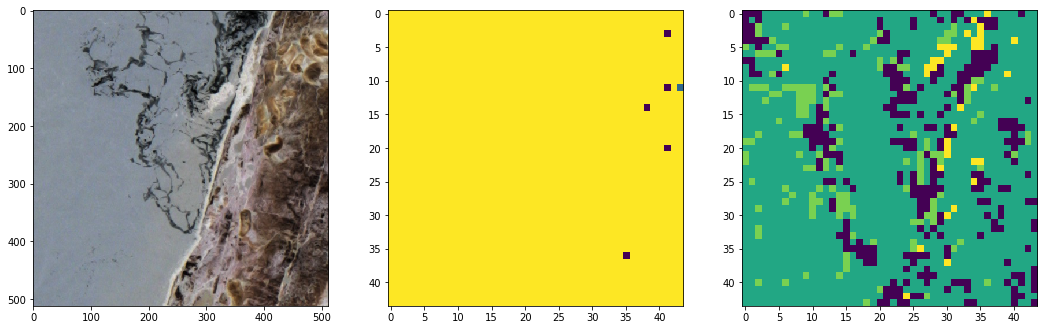

In [22]:
i = 7
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
classes_counts = trainPatchesGenerator.compute_class_distribution(100)

In [ ]:
classes_countsdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABBgAAAFKCAYAAAC3n+wyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsvUmsdVd6nvd8q9l7n/b2f0uyyOpcVSpJji3ZsYEAQQJDnmXoxKOMPEpmGQQBMg0yzSAZCEHgQeAk0wwMaBJoEjuWIEiGoVKpWGSx+fl3tz/tbtZaXwZrn3N/SkVWFYsska79ABfkPfee3d+D//vW+72vqCoDAwMDAwMDAwMDAwMDAwMDvwzmb/oABgYGBgYGBgYGBgYGBgYGvvoMDYaBgYGBgYGBgYGBgYGBgYFfmqHBMDAwMDAwMDAwMDAwMDAw8EszNBgGBgYGBgYGBgYGBgYGBgZ+aYYGw8DAwMDAwMDAwMDAwMDAwC/N0GAYGBgYGBgYGBgYGBgYGBj4pflCGgwi8o9F5C9F5Mci8t9+EfsYGBgYGBgYGBgYGBgYGBj48iCq+vluUMQCPwL+EfAE+GPgv1DVH3yuOxoYGBgYGBgYGBgYGBgYGPjS8EUoGP4e8GNVfVdVW+D/BP6zL2A/AwMDAwMDAwMDAwMDAwMDXxLcF7DNx8CHr3z/BPj7n/aGyXSqh8cnCIJI3/NQUCKq5Nd097KC7H9h93J+736LiqrCblso7H+a/z9vF0QEUKTftr6ylf3Gd+959adK3kD/H02745J+W/ujBd3th/3v353jqwoS2R9H/y37091tU+/eISIgIGr+6h4R5JXfu9vHq4IV6Y9X0fy66seOc/cGAeq6JqlSFB5rLYigu6uuCdWIIISYAME6S1IlxYiI4Jx7ZedCUsX0x59izF8poYCxFhHBGIPsroHZ3V9BVUn9ce2ON0He3u6hkPzcpJT2F1D69xox+fl45U6JgZQ+fv75ekt/nV69cArJ7F9XTbRNS9cFxAhFWWKMYI1FVRGz298rm8kPzf5ngiJCvgaqhBj7c1dCF2jahqTKeDQByfdDUyLGiLOGGCMxab+tu+ui/V2y1vSv5de99xiT/z6MtRRFgYgQU6RrWkKIhBiw1jEajTDWYo25+3tRUGPYPbMiirOJ0DTUm5q27UCUECHGSFWNsM7grEf7v20jQggBEWjbjph291VIKfaPX/47Nqa/7zH252NxzjOZjLFWsCYf+2q9IcaEEUNZFogoXdchInRdQFMi9bdeFaxz+TlDmE6mFN6jSYmaqJuG28WCbV3/lT+Krw4i8o+B/wmwwP+qqv/jp/3+6bHVN1/3v5JjGxgYGPh5ee/Djour+JX8LP5FP4cLKbVi8rntv3lr9Llt64vieLT5qa9fbcefaXvlT7Y/9fXJ9z6bavuzHsfAz+aT7hV89mf307b5ee/rk/jN2eUn/uzfLU8+1319Gp/n9Q3nN8Tl+uf6HP4iGgw/FyLyz4B/BnBwdMx//d/89wAYccSYEBFSahERQqsU5QhVpYsR4xTViPM2Fw8GbCoA0BRRAsZYBIsYRU2iqSGmQFEUxJBADc6YvqBoMQY6TagIIQEqOGPQLuTtkrClI3Upf69Kkv25YPSufhYRVBMppVzEWYNgEM0FoDGCGEWSJZHoUsRaiyQwxpBiIBFREqKyLwR3WOdy4QyEECikoGka6rZlNBr1+1eMM3ShoSh9LqCjIhhCCBhjMFZI/Tad9cSoWHKRjzEYUSQmuqYhNDUfPnkC1jCelEwPTvDlGGstoal59sG7PHr0iM22o27JWzGGo+M5ZeEwmq+FUaFuOjCOmBSRyMg7iLlYxnmi3F2H9WZFvdkgIkxGI6qqArHUdU0bAqREWZYk67AoVelJIZCi0qbcRSrLkpgCHpuvpXiSCilGVCNlYUiiBHKDwcZEEkMXQLAUziEpgChJIpGIdBXOC0qNEFjdLHjy5AmXlzf48YiTszPeeO01MLmoNsbQdYqIycU5iaQdZVmiKZDamu12yUcffcTTZ894eXnBuKyoqoLV7YIuBSaTKffvP+T+/Yf863/9/wKJcVUyn455+8c/4sWLa7z3lGVJ27aklGjblq6tiSnixGBsbiRgDMbl5sFkNsd7z9n9M77+jbeobIExhqdPnyHG0yVlNpvxne98h/lsArHj+OCQ54sV4/GYh/eOKF1gc/FjfvDHf8JHP3nCxdWKOm54dtFg1PK9732XoBsKN6bwI7q4ZTYrsVKwXtzw4YuXPHl2SRcTs9mMkXeEEKjbFldNODuaM51OKZzjB3/+FzhX8N3vfpeqctTrG86OJlRVRW0sH33wkhhaTk4POTis+Df/6v9jPJrgbIEYZbNusN5Th8RoPObhg8ccH53yD3/3H5LqQF3XLLYbPnz6hN//F//7F/Hx9yuhH1f7n3llXE1E/u9PG1d783XPH/3B67+qQxwYGBj4ufh7v/fhz/6lLyGf5XO4YsLfl//0czuGd/+Hv/25beuL4p98709+6uv/1w/+7mfa3tf/6Z/91Nd/9/+In2l7n/U4Bn42n3Sv4LM/u5+2zc97X5/EH/3H//wTf/atP/wvP9d9fRqf5/V98t/9Lz/3734RDYaPgFf/hfpa/9rHUNXfB34f4PHrX9OmafDegyRiDHk1tRNEFOstSTuaLr/uqGi6QEodXdfhS4v2BTfSr2RLVik4a4kpUThLG5WUEr5wGLFoEkLq8kqqxlxsq/Sr/3nlsyqKvmmRV8NTXngGYwGw+xVvg2jCOYeqElOHyG5F3KBJeiWDQSSverNfiTdoykqEGBRNikpWIBTOkMjNC1XF2iI3CWLetuLACqPJBLGeum6ZzCpAwUS8tTjncvGu/XFicwPFOoLG3CxJCWsdBPYr2QlwIlSTEVsS9x+c8cEHH1AWhsvzc7ZNwFrLwXzG7OCIy6sFimFTJ05OD6mqCu99XqHuAikErAghKpEOVaV0lraLjIoScZYohtgEutSxrddYY9g2DaLKdr1mNptRlCPqtqUcVcwmM1SVtuu4OH/JvZMjvPecv3zBwckpxngSBl9UECMqku9JJDebYkeMHeIMGmN+boygSREjaIqETvE2v88bl+USVsEkNEWMUcbTiocPH3Bze8tqfctic8vlxQu+9e3vMp5OMMnibEnqVQbGGrwrsdqgKMvVkn/7p3/Khx99lFf8xyOMcVxeXDGZTJhPDnn58iVlUYEqTsC5gul0mptTGCaTCSkluq6jrmuszQ2VwpfUdU2dWqTNjTlJuTkHQohC27Y8f/GCH/3oR7z1+hv9M5P4je//NhHh+vqai+srppMR3nisLzHplrPDGdMyUbjAD378l9xcXtHGlvGkYnVVU5QjqrJETUO7XdFuWwpf8/j1+5xfPiN0kavLWz56dk4yHuct6/WaWhNHR0d0yyWL1ZpmecN4PObg4IDDwykHh8csVzf8xV+8z/HBlLaeELsON51wcHDGerWgrmvmqWK1XDOfHuH8CHGCbJTYKWcnp/zG93+Lx49fx7uCxe0SgtBsaspJyRuvfy03tL667MfVAERkN642+OEMDAwM/GoYPocHBgZ+7fgiGgx/DHxLRN4iNxb+c+CfftobBMG7EtVIImCyAp8UHLkqjyTJhZEmkxUOOFLK0mdCHnJQIxij4ATRfGpN3WKs7uXvti8UU+pVEv1oQEqANYSU0JRl3aJK03V4a3pZfgKT1QNWdpLtXPiLBmxffO4GHXayc4A6dqAGQ0QjiMkjAkYMMQXQrFJQVUQsSETE0MW+2yq5SSFWCJ0SElibR0fqdosRhzEls+mYmJqs3CCQUiJ2FtT00vOEc36vsBCTr0fud2QZhqaUV+lF8nGL4p3Des90OqXrOo5OT3jj4CjPFqjSbDcUxyWKwxYjvFNCbOlipEt5pb4BNus11hVEjcSQqLyjKHxuLoRAXbeklOXsVTmmLEtmsymr1YqfvPMOt4sVZ/fv48uCUTUm9vex8J6qKLi4uOD09JTT01PUFNii7K9rIoTQF/eCJEFT6EcKEjaBM1m/kccqctPHIP3IhvbSecUgRBKqkNRgECaTvOp/dDzHrbfUbctqs+H84gXlaox3BUfH97CYrPoIgdB1jKvIcrnk3/7Zn3B7s+L46AznPTF1rNZLnC9RDMvFiqZuee/dd0ghcHbvlJvrS549fcJytclNhv5Z22w2HB8f470nhMDl+XkeawFCiLRtBGP6BoSlrCY8evSIpmtpmi0hdsQUqLcNT548oRiNGY+zWqULCeOE1WbDeFRyejSn2z7h4vKcpx9+yGK1JgGXi1uurjcEU3H/wRyRjtS1EARxBcfHx7zzzg/Ybrest3k0pCwtXVQMibOzM1BlOp1SX12xWq1o6prbmyvu3z/B2Mjl5SX1dk1TeTRNMGK5vrzkcHbGhx99xBtvPub4+Ji/+7t/n4uX16w3DeqErlcbzQ+OODo64fr8hrKoGI3GPH96jnOO+5NTFotFHn366vILj6sNDAwMDHyuDJ/DAwMDv3Z87g0GVQ0i8l8Bf0CeN/vfVPXPP/U97GatdwW27LaVR9VVEZMHp533tHWW28fe28AYg6rJ6gASguYGAQYlz9Z//BgjScGKy02GfjC+i3lUYXc8onk7xgpJE8bkwW1Rze6YcjdigAr2lVEGJYIYkmou7kWyLB4wuzl5kwtY0TwjryECWbXxqs/C/pr01yWSVQ+S2xUYa/cNiJ3nQIwRY/J/lYAzPq/OJ8mruGJIpDt/B1ViDNh+x84YomYlhaC0IeC95+DggPOrCxaLBePJjPF4sj9ONBflADF1/Qko1li6XpVS1zVIx/zwADfyjL1DDFxcXdE0DaPxDGMKVBVfVogzxNAxn8958803ub29pWkaJrMpURWrhrbr8N7gnOPqcsXBwQHVaJLHIPoGhDG2f076eyoOQy5snZX8Wj96YuRu7GX/fAGaOkTAG79X2eRrBzHmxtB0OmVTt3lsQxq6rmM8sYzH431Dy6IgCVDaZsP19RXr7ZbJ7IDTszNCCNwsb9D1Oo/K9LM3KeVxldV6SVH6vY9CPkeDc/n8XH8eZVlSlmVWBGw2/bk6lERRVTjnEDG0bcdoNObBo4d4b+maDXVdE0Lg6bMnVOM54/GYswf3s2LIWtq2ZTobU3rL6nrN4uqS66sbjJSE1FF3kS6AG+XGBikyHY/ZrsFaS+l9VgTFSNelXkFjcU4w1YjRaETsn7midJy/uMAYQ1kYytKzvL2ma7Yod42jsihIm2Ueq6lrnHNUVcV0OuXFswvqtmW9rKmKAmttHrtKULctCSEqhJRo63p/vT/mvfHvKa+Oq73x+G9sam5gYGDg15ZXP4crhnn/gYGBrzZfyL8mVfVfAv/yF3qTNRh65YAIxkpfAEHUjqQCGumaLYJHMBTW9SvoFsir4qrSeywITizWCEhExWB6x8UYI9Z6kkYKX9I0DUo25UsxoTEiZCM8MTvDvKxa6GJC+sLdGYPrC9cUI0lj78WgxBSyh4IIqJBUMGJzU8Hk1fMQ29yAMHf+DUlj34zIJn+5vBeiCikpqQ14V5AkF2Wl90QNQL5mJENMuldlGONY3qwpipKq90zIzQfBWEPSOzO9lBTbn++usRJUEWPJVhKOycwwmkz48U/e5Udvr5jPDnjrra+jaWcqaYghYG3cN42EbNLnvKGsxiyXSzbrLda2jOYHhJR4eXHBqBozMQY0URUl3lpCinmcBeHg6IijkxPqtsnGfMbhxFEUBSE0jKq788sNA0+IkRShLOxfe+QSWc2wKyKTRpDsk6Ax5fvVqz5M30ySqIQUwAghKIjFIIS+4XB2dp/r2yWVzSMIi8WCajRhfnD0V/5GEk2zobBZZWJdwW/+7f+g95hQXrx4xu3ihun0gNlsxjs/+iEHsykfXF4QQuD58+d5xEEFV5R0XU3XZc+SnXJhuVwSY2S5XOHEMJtmH4P1ZsWmrvcNvJQS4/GY7abmpq0RCdxcXWHEcnL6gNvVGhHh6dOnHB0d5aaPJg4PD6k3Cz764H1WN1e8fLEAPE1oWW07xBXM53Mmkwprt2wWDSIjTk+Oee+9n+CtR6qK9bb3DiEhCM6Cs5KbaCKcnT7k6298LTderi9ow5bFYkHXdUxGJc7mc9hsNjgxvHj+kvsPH/RNisTN5TWaoCwnTI9OMTabRE5mM25WS5bLJaHLSpLf+N732W633K4WiM1mpF9hfuFxtd/57eorfcIDAwMDXzJ+4c/huRwPn8MDAwNfab4cy1X9irv2sm2Arg14nw8vxH6UIOZVTiN5xT+FvBKt4hA1OTdB2K/6xt6JXqR3usegms36VCMpQdu22QxSoOkapuMxXdPk40q5MRFjh+1X8iVplqObrALQlIubRERjIvRNhf3qdsrCA2dz0UcCUzgQi6aAsVkpAPSpCVkJ0cV+hbvLhoy+LIkWRGw/2gCS8vjILq2ga2us8f0YgOsTOZSDgyKPiBilCw3WGoIKhLhf4feuQDURU8iqhpQVIFayGaKxFhVwRQHieOONN/jhX/yIm5sbjo+PqaqsKMhJILlhkb/y/RVjSQkOD49IUaiqMSElVssN63pN2wWa9pauCzw4e4ARBU04MUhRYQ3ErgHy9c9mmYaUApJMNvCrhLN7DyjLEus9OXEij4Sgkq+ZmjweIA40ICjeWqJEMIKkhDOW0HTZv0M1N4XEYr0htV2+Hl4wkt32U+ooXYEVZb1e5waWcRweHnJ1c8tiseDg8BhnS5xzGJOTLJypaLYdMcJ0dsTtesNoOia0Nc4qx0ezPnVBcSY3fboY6UI2b/TWEkLHZrPF7BQpJit51uusWPDe740/U/93Zo27a8KI53g2YrlcklR5/Y1HHB8f8vTpU95/9z3ats2pFiFweu8eZZnVJc57ZtMRze0T3vvROzTbltWqYdNsKKqKw4MjJuM55aigqkA6xZkRah1darleXlJ6T+UcIY6Q1S0htFRl9jxYrhacnZxQVgVtveHpkw/pug4jkYODKceHc7abBuM8pMTl5SXeGVxRULctbz78OmVVcn5+TukLTo9OaMVxeHqPyawihMDLly/587/4IfPplNPTU37zt75PCIFqXLBer/pxma/0v/N+4XG1gYGBgYHPleFzeGBg4NeOL0eDoScX5uw9ElKKBE1Y6xFR0i6SUCNmF1fYF9vW9rGImvYmhbvVZ+8MGqVPrcytBlHFaB5P+KvJjFb6lX2R/Qo/0kdVmlyo5ZTBtB9fyE2BgJILfqMGY/KsfW5gCNbkglT7Y8zjG7kozKvkhl2M4K6Itpbsz6B5pb2LcW8sKUYhJdT0xTxp/1pKYMj+Ds66HNfXJwuIuNyISTmpwtCv7qvQRxzkxId8sffnmGIe8RCrjEYjqlGRzQPrmvF4nr0xjGLkTi2wj5HsTTgNlvFkSlVVhAj17TViPWdnZywWixxnCVxfX+PLkqOTw+xokSDFvO/9tkT7pkZuYEi/Eh9j7E0KswpmN7axi2nce1FYg6asPIm9UmKP5uM2KogxdLFDomI0NziSfHx8RSQng4TQ5maUASQ3zNq2zSMFE9Nfi9g7hUZQoesio/GUuq7ZbrcsF1e09YbDgzkXF9d03ZLJaMRqs+Hw8JCbm5u+uaLYHIjSN9P6qFJV2ralKLIvxN7zIQQuLy/33iCq0HUd6/U6/zwFVqsVjx494PDwkA+NYbvdYpxHjTAajVAj2H40Q2OHppauCTTrBmdKfJHwvflkVTgm84pRCS4afBQ68j2LKfDG48do2/Hs/F2Mwrg3BW1DYrVY4K3l+PCAm6tLmnqdr7U1efwkJdarLbFp8t9K7MCVfVOloixLNpsNeJPPF7g8v6JN8LcOv44k5cmTJwDcu/cWk8mEbb3CGkPTNHQhEqPur+lXkc8yrjYwMDAw8PnxeX8Ov/svfrrr+2dxzf8y8XmnNHzSdXr3K26t+Un3+ZPO91d5DJ/1OD7tPV+Wff3B05/+s9979Mnb+z0+ZV98vuf1afwqn41X+XI0GPSuqRBCu09iSDaiMaJqepNC9uoDSPtZ80ikq9dYIUdYpg5n8oo71hB71wKritI3Ibgr5o0xhC4XpaKKdQanQtwZO0q/kpmyMiClQMLkQtZ6rDG0KRAkYgWwgnQ5pcKaXMyFTnNKBhBjQCWBZtM948G7At97D2TnSQGToxuTQBsCxjhiDDjvIQWs7wsrTN+MEJJ2vReFxYjFWEeILb5wbFYNRVH0SR2K9UIOThC6riOpxViwYvEKRvv99iMTIkIKCQMYa7h//z7OOT56+oT50THklgTSG0SGlOUbSUCSEMn7moxntE1HSJHpZM7NesFoXHFwcIDTHOc5HVdc3dxQVg439hjywyq9SeK+uCc3WmJQrHN0IRfAXYioWFTB2nxfxRhiSDhjaGLE9MqWLsb+udJ8zF1WMRATihC6DoxBRbDeQeiy6iZ1hC5RFJa2rRFSTmiQvOKPsXjvWa23LJdLTo7vQUzYIv+OJIMpJ3zttbdY1R2+Kmm3C8ZVQdh0HM0mHM0PUYWL50/5y7d/TNPl7Y4m073R6Ha9wlvLtuswxvZGnm7vOQHsi/IgjhBavO+VCC57b1RVyfzwHnW94erqivv37/P+fM5603AwnWELT9d1uXGTOspqTAwtxka8cZzfrhmPJozLYj+6U2+uGM2EGBPXF1dM3SPmB1M2acVoXPDuj98mNR3bzZaj4wMgN0bWyxVtF9EYuL65ZFMvsz+DtZACkpTQtIxHI2JSrBGq2biPXi05efgGxjluz29pnRC2gRTzM25DoG022Vxyecv3vvt9RuMyjySREBLTynO+bQh9I/CrzGcaVxsYGBgY+NwYPocHBgZ+3fhSNBiE7JcQTCSpoYlKZT2GAu8N222N9zmBAXKMpbEGDaHPb/TYAoKGvZxdIxhNeBFiiPv9qObkhJAiKQas1ey5YAUjETXZgA4g1TVlMoSQUGNwhWMbc1qEdFBIHnuIqSOaDmOFGJXYBby6vPrdmy8asSTNDYHsFdnRqaBicdZTlR7nsmohhkTdBsBQeI9qHpmQpJSimNjm4jFEcjxmgUnZzDHEFuMcKkITFW8cgqOtE+PRLE+5i+AEtGsp+n22mrDGUlgPorREuiZhZIR2ueliyoDYiLYeYwMH0xLtJpxf1yTjwWbfBhsMLf31SB1WDGIFaxwp5PEXkZLKG1TWzP0cekWK9ZamaajGU8ptw3ax4mA6zYoQ+gaH5FZDdlFQYkpUVui6FpvTQHvnitwg0NQSBWxMWCOEUONsVgAYkxtNRgwmgo2K2JIuhPzMqfQGjpoVNSaACxiTvRJMb0CagmKdJwZYLZdUVYWGLTEaNuuW5WKF+ALt2jymoKDJ8fTFOSF2PHp4H9HIYr2ia7fEZPjwyXPqrmWz2XDx4iWr1ZpWYHJyzDdfe531csHLywvK8ZjNzZKRy02x6PtRDAFvLXVdMz04yj4mFXSxzsksKZEixACXl7cYU1BUjicvX3B0esbB4SlUS37nH/wdnj15ysWT57zx+A2mo4J5VTHxNe+9c86L5y9ZrJfYwnFy7zhHfzY167phe3HNxiTOr7dU0xV/5xsPuVeMeftPn7BerFk0HWIThTXEuqEkcXYwZt0kqtGUq5sbttvIbGSwTrBuxHJTI0DhHKXz2YNB8r2MzjGpOkayZuYSqp5GHXUXKCvHt7/xGE/H1XrBt7/1HabjMWMrjCpPvbomRmG5rRmNK+azGdb9de+OgYGBgYGBgYGBgYGfzpeiwaDcyfDLssSooV/gJ8ZIUWTH+d1aYkLpug7tlQ9i8qy/zcP+0E815GjJO9m4GO3l8ZrN8ZzNxonSl6sJ6rql2TQ5QtLmVXxjcloD0EvDtfc32G33zj8h9bGS+ft8dmISxnhSDP3IRUQ1YcQjFjRG1qtNHlcwBudLRLJZIZr6iE2DJu2PM/UmkIL3FRoNarP0vvA+n34/t69kLwe3i6NUwBokaT+akY/XiSMlWC6XAMyPDlAb86qvc3tjSzE2KwFixLsCjOPo8ARLVijEGPHGIAFU8rhESlnpsUv2cM7lhIeYcIWj6zqKwvfnKxRFgRVhPp9ye3ublQT7cQh7l6YRcitBRGhDwDpH7JtOqoqzOWkk9UqKkHbjLnm8ZXf/AG5ubrE2Kw4mfoT26oCdumY31pJSTufQGAkh+2PEGEEsm82GerNFVOmahsVywfnlDficaPHNxS3z6Rijgkp+ZpOQm1QxQmz5o3/zr7DW8uDBfa6vrzm/uqTrOtptTVmWfOMb32J6MOegLHjStdnocDylNmvaoFhfUnjP4eEhsetYrRf5mXIO6wrKacF4cp+m3aCqvHxxwXazZj6fI0bZbrfYwhCaNqdokBMwvvOtb/P2D39C4Rxnx0eUhSPFBR999FFOlvAeW5QsFgusKKlrOT46YLFcY73gTIkGZTKZ0CwvKKqKqEuapuX45ID1pqYwhtF4zu12wXK1xZb1ftRjMhn1Yy/ZO6JwHm8FI4k2ZINH6z2jeclmvSW0NV3XEUKkKKYcHBxwdHLC2dkJzeqWk4MZ59drkoZ+HCmx3q5ZbBpSMpjCU6ju/z4GBgYGBgYGBgYGBn425mf/yq8G1fSKMWA/9yyJmLo+ojH1q813c/27aMTs15B/vosWzMkFdr+9pGE/u797b4z9qmcKfbKE/bhBY+/xsD8eemNFwFgIscPYvkjVu2Pav5+YmxomNxlyQoHs5f3WWpxYYtD9NjTlIh342PnuGiR/9Rgh+zUYk30ajDGQ8miFqmJyAB9K3G9vt838nqyw2O3PGYeznpQr8z4lAyAnc6SYj8MYQ9NFQhcZjya5eaDZBFNE+hV024dpCt66fv+6N2g0Vva/u2sw7Y5RX3n91Xu+a+S8ei67+/Tq97uv3e9Lr1bYfekr21LN4ys5tSQnB9RtLt53z9WrCPZjcaqxN13cbres12tEwEpWamw2udCtt2u26yUphv1zADCfzxlPp/vjz0VxflZHoxEWobCOw8MjHj54zNHREVVVsVqtWC0WxBg5PT1lPp9jjMvmj94TYstmu0JD7Btw+dmZz+eIZD+F8XjM/fv3GY2z4mFUVYjCbDKh8HkkYjQa4V3BZDKhqiq3jwAcAAAgAElEQVTGVUFVegoD7bam2dZ47/HeYq2la7a0bYsh0dVNVsd0CWcLJuMpGu6upxGHNR5f5D6nL0YY57C2oEuR7XZLjDGbQZb5y7rcuJuMqzw+lBKahC5mN5HRaEQ5qmiafB0BRmXBaDRiMqpIXaBrtoS2o222OZLU5GSZJnTcLpe0sSWmu8+AgYGBgYGBgYGBgYGfjy+FgkF6tYBq6n3vhJgMvjQkzTJ7VSUKoJpXzsmmf/Tqg0ik6/qGQYjZUFFSlsuL9BL3Xl4vOcrSGHPnE6CJQgpSjIiRrGAwBmNSX/zluXrrCkIIffHK3qgxSwskr7ADCbIkwiRy+qGgyfRmjJr9GciNgSA5btC6u6aBWIs1Bo9juVpRjiakmJUIrXaYXpGQNJBiHqUoR4a6WffJCCav2KugKe6jJ6GP0YwJ80rDAxVCSBS+yl4EdUTE4MtsLmmMpe0Smix5Wd9hbEk1mlGWJZLyNUaEEBtCp9nw0tq9eiGrBrKBppFA0oTZXTMF1UCSu4LOWturNRJJNSdKGCWEPqnDOpwxkIREIGrYNxB26RiaNKeO+KxmgNwQyNchN6Eg4n31sUZCWZakEAix60doTH9MOeJwuVyyWq6ZHxwyGo2y74EfoaqU3mNQ6iYrNxyQupb3fvKXVO7bjGfTvsHgmcznjKdjJDRcX13w+PEjyrJEVXn06BEATdOw2Xa8fHHO2x9+yGQy5sHRAU+ePMGXJW3b8trDR9iyyqkS2xUkQ71ZMxtP2dQtoQ0YaaibDSnFXgGkjCZjZvM5s/mE0HW5qRID6+UCEeHBo8cYV5AwvPnWG5wcHjD2hthu+PC991ktFmzrDWVREXbNPVWmszk3Fy9QKfCu5N79R4gpGJUFywYwQjkecVbNODoesV421JtAMR6hkhsFTb1hXJS89ughhc8NshmTrBCpO6g8XRsJCZyf0AXlydOnCPcwAikqZeWZTMdMJiNSqHn+9AXX5y8ICbZtx2w+Zr1ZsV4vWaw2WOcwzrHabqhGxV1+7MDAwMDAwMDAwMDAz+RL0WDIsw65gOz64tEaw6bZ5NXmXVRczCvD+bV+Bl8VNQnvPLYvZM3OvFFAJM9ud6FFjRKiYsUhhetj+gwhdiQNxOj3SQOpn7tvYvcx1UHqzQ6NCElzse7EEBTgLpFCY/Yc0BT6k0zEFEkRnCjOGGII2fiwl8znuEsgQaLDiKUaeR4+eMzV7Q1F6ema7T4GMmpCU8SqZdNH+HkH0rv052DNnLrhMH3kJoBikd7csu2bJQWkSOxXuvM9iWzWG7b1Gk3CaDzDuQrnFaOWzarGmpxU4J0QEZzJUaClLzCmzHGgmrebHf6hSxErHoxSFOW+2DXisDaPMogIWMNkMslKA1WsvVN0BE3ZkyECmgiSsNxFk+5+5nYz9P3Mze5eelfuVSsg2Qiyv8dBE9bkOMs8FkLvhaEYo6SYqDcbXr58iSJEFUZFiVSG45NTFtfnNE1DCJFRNcEXeXX//KOPuHz+EbaomMzmPHjtTU7O7uGtYWQTVeGZTcdcXl/z8vyK73//+7zxxhtcXV3x0b/7CwzC4wcPmcynPDo54tG9M4rxmOcvz5GgvPb667RNzeL2kvVqgTMmKzH6lX5jDDc31725owMjjFS4f/8+RVGwrTfMZjOur6+5vrplPjvCeY+xFsTwzW9+k+lsxGRsWNQ3vPjoI26urtAEq+2Gxarm8OCYwjlWyzVNHSgOp0zGcz54/wm/+Rvfpa1XNPUGjMF7T7eNnJ0d4+2K966e4auCe/fPeO31x9k/REGkwxXgnKNpGtbLJcZCrGNuxInn4uIlzjne+vbXmB3M2SxvGU9nGHE4K6CRxe2S8xfPWDcdbdsynky5ubqi3azzx0sbMK4itgHxDm/+esLMwMDAwMDA3xSf5HT/u3/2yeN8n3dywj/53p984s8+7zSIgV9vPmsCwif9PXza38Kn7etbf/jTf/b203/+ie/5tISJXwe+FA0G3fkbiMWJyVGQkCX0SFYUGINozJ6OqmjfZBBx+CI3G2LsUM2+A1VR0HV5VCD2UZb6ymiBqPZF6051IGjK8njTy+slZTl8jN0+BjP7Lwipj4S0kgtZa+w+aWEXSWlMNqPsug6jBk0Jbw3emWxAGLM6A7PzVdiNhyiIRSXSNInttqVLsW+esB9/iJqyXwM5DcFaQ0xtr9QQzi8vszS8GuXrrAljDU3X0AGjV26/poB3PidkpIR1+Xib7ZqXz5+z2dR849vfxbsSNLLdNtzcLLLs/miOatinGuTGTVYJ7Ao06Vf2Y++NEGLbKyd0P+KSNBCDYF2+ZtY65vM5EfZeB2IsSsJaR+ji3pcDS/Zo6HforEeT3I1L5FbO3tgxR1IKXdwd564Zo1hn86iNc32cZtqPMKSUsi9GVI6PT3C22CeSOFswmR1wdu8Rz58+wbkyqzsk0XUt9XbFarWkjlBUI5abQN0p986OmR2WlN7inGFxc8N203Bzu0RTyJGN3nM4n/PW3/o2s9mMk+mIzWoFzqHGc3txzfnVDWVpOTk5oW221E2HWDDOc3NzAwZOj08Yj8cUZcVisWA8nXJ4eIh3hpfnL3h+/RwsTKoR1hasthvGszGEyNHxHE2BGBK3i6usqCkKsIbF1ZIQheurm/z8izAazSiqCltWFKXlm998xEcf/JDnz5/RpEiXWqbzKRpzPGbdbDFL4Wtfe0CMLeubq9wEaxv8eERZllSTEZv1ltVmQxSoN1va0HB0fEg1mvDmG69TFQUfrtakmNg22V9ie7vBGTi7d8ok5M8TK+C9R1Oi7QJog3FjqqpidjBmNqpyo2lgYGBgYGBgYGBg4OfiS9FgQHrvgRQwxqNG8qqrZmNHUQXMx4u8V/7hv4vj2/3csCsssxliiqmXwgMkkH6On7v4xSzdD73XgdnvZ6eWyCaKKZstkvpi/q6hkOe9DdY6Cuty08FaQmz64jhH96WUaLuGSekJqtnaYJdE0BfIqmD7QvluDKSPHBSw3t2NARhHahNZzdF7UYhSNy1t2zKdTml7PwFbVPiy+piPg0oe/0DvrmdMAYMlaZ6DTyFQliVd3RCKAstdM2VXAIaUcC6v8os1tLHtzTp1bxCZ92t6c8583iG0pNjtvS60P6+damGnbNhJ1XNzBwzZ0wK9M2tMKadYOGPglWZS6htMd9GW/flbi+3fu7uHuYEg+2comwqm/XNmsGDg8OAINQJYjPO9+WY2vjw8PmG5XGLsRfarELP3eTDGoG2HMYa6rqnret9gISVCmxNCoiZevjhnu1nTtFtm0wNOTk7omoZuVHB+vsKKsO06mqbh5cuXmCKnmoyqiraLJAzWWMbjGSenR1RlwbZes1xGpmpRsRjj8N7vr493BW7sKXxFRJnP53jvGY3yCMl4XNA0VyyXS7oYUTG0XUcbAzEZupAVMN5aRtMZo+kUK47RuOTwYML7IdA0LduuI2pChNxcqOusJpHcwGnrTY58TUrb1WwWkaJoOS0K1nVL20WKomA0KZlYx8HxPYqiYH4whXj3TFibzTeTBsrJlLbZghTZTBbFGkMSwYZE4UtcWVFVIwqXn/E0TEgMDAwMDAwMDAwM/Nx8KRoMu+LL4vcFXUhp30NwzuW6ozflg50agSzBD1nuLf3IREJp2t4noTcK1LRrRARSCncmiTHhi4KUUo4ytBb6+X0QYkoUZS+n9w5R1xfygRA6vC8wxlLg0D5Zom3bXu5PL9N3hNSRUoMxQlVaojaIqRCfjSOts1mibQz6imFkiopKbnqokr0TnPQqAUuMWYUBhhS7fUxnUQj37t0jhqx0EJuL/5hClrwDSUP2ctAc66jaoQLWG0Kqaeot58/PaZsGVeHt2x/iqwK0Y7MJWFNgrfD0xXsYIzx48AbHxydYY7E236uQIgaD85au6xBrUc0Gf5oSagRfuF2fYF/U+9JRbzZZyq95W11ssN7mvgIJEb0bSRHBGIegJBVkFxghgpjs3ZDjQs2+mWCtA3PXuHrVPDNoVoHIq8ahkv0ovC9IMX8fU1bC5LQSoQswGh/y+lvfZtu1XF/d0IV27w3Rth3OOZwtKL1nOj1kVE2QFFne3uRivhpzdm/C8fEp7//kHQpf8Zu/9Rs8++BDPnz2hG988+v88M/+jKurK8QXHJ49wIuliAbrHdvtlm3TIsWI6eyAN7/+dUg1oWu4vLxkPJlRjKYcHhxhC4fxjpurS2YHB1jjqA7mnB6d8vjBI+69+ZCz0yPm1YhJ6SkLx/vvPeP68oIuQZcS2y6iGNo6YF2FiOf08WvMTw6ZTgs0Gh6//hCxNavbG5p1y812iykcYwk8+fCc9SpweHDC/Qf3cFZoN2tG1ZSuDVSTAz786AVlWRKxbFuljWDU8NobrzGfz5lOpxRVxWhkWS9WVFW1N/MsK99fc5tNMK3BoJwczei6jsVqDQaKqqKaTvMzJx2ruvmCPvEGBgYGBgYGBgYG/v3kS9FggFyIawg5QrE3fSx80Rvy5fQB0/sWJFUSAekPv207MAE09rGMecWfXrVgjEFcHnGIknBissEgOdUSVbz1+bVd5OE+SaL/EoN5RUWBQFEUxJhIqcPYKhfJmiUHanXvYh9C2Ben1sJyfcOHH7xDChWT+ZSHDx+iUbHOYMTQz0wAFjHZfDERCbEFUbrVltlshpLNGpOkHA2oSmENUTUfWx0IXZMl69Zhi6wMMX2xbKzgJDctRCCFSEJxJndGFstrBJiMZhRFwaZZU4ctVeEw44K2U8rKkXTD7c0tm1XL7dmCt775TYwjX09vsH3jxZl8X2JIeCeIK/royhw9umsEWRFC090lSvSKh51SZY8oMXb96yY3A3qTyJ1vx+73NbKPmsyKhV4B0m88poAYyU0PDK732Xh1G1nNknqzz6xGsfbjqR+quRFWjjxvvvkmKb3LxcVFjljsLEYc5WiyNxF1ztE2HRSGH/7wh1xdXePKCQ8ffx0xju9873sUziGaaNqaut7w5MMPuL29pW1bUoi8dXTEaw8fE0Ngu17x9o9/SN10PHj4mOPTMw6PjyltZL2+5fziAlSoyhEhKrPJDBVhMptxYAzf+J1/QHUwp7Ceg9mMYlZA7Ait0oSOxfWGF8+ek0IgomzqNpttFhUuBF5//S0OD46I1vH6W2/Rrq65Xa6YH0xZ3F6x3dRU5QRTK02zZr1ec3h8xsHc03SBUTUGWt566y0264aLq2uaEKnKCW0IPHl6wb0H93l49pDZdMrBbMIH778Doty/f5/TsyNil5j2jYLVer034RSR/HcjFm+FwllSbJhOJ1jnUTemqCYUvqKwHW2yGPul+YgcGBgYGBgYGBgY+NLzpfjXsxGBZEiiiLQ4MYyiIbYRC3QhIFgK54ldwBiLNUKUfuwhKXntOicZqCZCby5oTYk6j2hHTKDqCBFG3hNjyGaASh/7YAmasiGhKKUVSAIpjzKEqDgTQAWRvGLrncE6Swg11ro+KQIkRHRX7BKxNkCKbNc1z5+9YL2OUHrGriSlROGUpAZRMMYR++OKSFYchAaTFGcFX4zQILlpEjusE0IUDJ5IotMtUQMKTCYzNvWaTb1FGmEyrTBW6bqWKAVtG7HG4IzgjSf5lqgBa0uOjh4wn5wyriqsQNSWGDu2XaQQS+EddV0TaHj37b/kyXvv8ez9H/P8+XP+w//kP4Ko2GgQcRTO72M9kyQCChpQkxAMKWY/CzGGLubUitApRMEUiqpkFUaKvXeGRawlkpUqJR5N+Von7jwbsulkHrVBCsQYUopo6rJppOTzjylB//xYEs6W+zjK3EQI+RitRWP2akAUYxWDQjRIALGGSIdamB0d8eDBPUK3ZLVasVzXRGu49+AB6/Waq2fv87aLvPW1NzgaPQBruF7VuA5ufvITjo6O+O3vf4fpuCK2l/w/f/gOjoLOOk5OTnl2e7NPhNjeLth2G5arLcsGZkf3efTaa0zGFZUXSj9iVI0ZT0pWK5BUkLqAC5HtJvD4rbeYz2c8OpsznXjapuP68gVVW9DeFGxtxdoLzmwZT6a8XG5pk+FmseHevYekGJmNp5ydPGC9rVmuG45mB2yMMJmOOJ1XvP/jp0Q7Zn5/zuHj+6xXK2KMbLcts1nJW/ce4q3l9OwRbdvy9OWPcEVBalYU8xHSBeJmhCmmfP1b36Rwhs3NLfdO7hM0MhnPeXmxZj4bcXR6QNe0ODtmfnhAWZa4wtGEBlPnVI5tq+AKppWjKieU4xPK0QlBgADWLD82ijUwMDAwMDAwMDAw8Ol8KRoMeXU/5Rl6o9l7oV9hNuIwJGJKe2NAeTUeEnDG5ohEdmkPOTXSGZMLwZRXrEWyCsKauxEEY3IhH1JCxaDkItJYQWMuTI3Jq+NR2e9He7PAPNPPXlqft5vHD5x15N0nlos1zuTxiboNOb6wqvYpCXW9ZTSe5VhJTRjjSSmrEpTsSVCMHCkEnHNstg0aOozLt3C3Qrv7b9M0pM5SjLIixPW/t/Mb2H1v+zjM3XkC/biKUPqKZlOjMZJUWSwXtG3Ni8trHpyeUjmPipAkN0dSVOq65vz8nNTlwn9UTYltJMQuq0J6r4WdiqKLce/HoGSVwU6ksFvhT5I9FJwYoua4wr1Z5y5OtLd77GLeVtd1fdpExOSs0v34BdypIHbb2Z37bp856vROMWGtzXGX1uY0kiZmfwVjstdGf91jihhnwAommWyoWBQ45+7OJyW89zRNw2KxYL1ek1JivdqgqlmZELfM5hNmkxEhBLbbLTEmVssbljeLHN1ZlRhjWC6XhEVNkzaUVX6eTk5OKYqi//IUvf9DUR6zWFzw4OyMwlmsAyrP4eEB9++dcDStcCYS29DHhCpJEm1s+1SHHAHr+1SNGCMhBMqiwHvPxcUFXUx0MY+hVFWFLzxVZfIzmRJ1XXN2/5TDgwNCCPzkJx8SQiDGROFcjspMufG02m7y33SfhHFycsb8/2fvTZYsy84rvW93p7vndt5EePSJRAIEkgAB0koylZWZTHoNjTSqJ6mXkEYalZ5BmkgmmamoKhZJESg0zD4yI6Px7vptTrc7DfZxD1SJiSIhkAiCZ80irvv10/mN2P9e61vLOcv5DO8sITO4LKNMaReEEDRNw/z4CCUkIs+ZzWYYY9CZRgcNSiNNoO0HgoCqqijLknqxwglDdIGud5gs+49+rydNmjRp0qRJkyZNmvTr9U4MGEIMuODJjGFwLTaEROePEkRaPGulxkx1gjmmZghFFALvI1KkIAWotOkYJUJJoouIkYUQubW8C/z4p7ulpghEH1CZwblURaiUHqMKwG3rhE6gwr6zSKmJ0eNdQEiR2gXwYyQB+r6jmFW41tH1bmxzkDirePDwGeViTttsud5cURaGm+01SmQYU6JN+jlGR/qmxxiDjw6Pp+t6jMkZvEMCwTqkkOMiOeCH5LK4vU55MaPOFBKwrkucBTXuzo/gwugtEVDSQEzsCUQgz3MAtjfXfPHFFwgR2R923JxfsLm6SgwDFTlsb2hv9nSDw5JzfX7O2dkZtmspTA7RQQSlJbnUBJfaPTBZKs0g3R+lFdKFEQCZFrnISPQOL+U4XIqEZCPgdqjkfJfukwQj1J0LwnuPj4JMKcJ4TaQch1BCIJA4m6I5ya0wVp2OAx7vfYJzxlSlGWKKvWiTnBCpDjS5WEQguS5iTM0eItVsGp2nIYNQzGcz6rqm2SdOQLtvef31OQ/XK5pDOgcpxOisCGw2l0gFP/2Ln9DsGoYu4Aebnqs+1TReXV4z0wXXu2uOjuDD7/2AxfoYrQW50RRmbNbQmmo2p2sDL158xcnJCWePzshrw3fff8xyVpGryM2bc/bnNxxuDmSFwtQL5OhWWS4N1g24CHU9p67nvH79hvl8zptXFyM0Mqco5/TWcrSqKDIBtFg70Pc9Umv2+z1FPkaMnCdohUKl6Ib1HA4HeusIIQFItYwUZc56veLoaIW3LTJ4jIqE4cC8XiCE57DbEr3leLlACcnJ6SkALrg09NMaUURMrpgvl3R2y+n9Y7TMEMrw5qYlKyu++8H3KWtJWZZ/L595kyZNmvT7rl9X0/a/fP031y1Oevc1VVH+7vSNdaQ//ubfp9+06vEf6v1+U/26utTfRB/9N//TN772nf/9v/87v9+7cp1+V3onBgzEtOD13t/trIeQ8vC3wMW0W+rS34lkZ7/drdc6x2gI3icHwvgaSGSUeJts80olcn4CGoa7XfQQEnsg0zkhJH6BdYGuH4jeU1clchxAeCRqdAAEF5DCgIhEHBF/xwTYbncURZ14A3nByXGyfQ+24+mzPyArSqoiMi+O6botu/2GgCDEgTwIFqYEIkPXICS46BAI+pBgk14IohsrIUnxAm8DSgacDfR9z2JxkpgHwdN3gcxIlDR4EqsiRRMYhyLJxeFt4l+ICFGAVPJux/3DH/yArm/47OO/5pc/+Tldn94pGoUmoLOCmQahBB/97Jdcvb7g5OSE4BzL1YLFoiY6AVHhg0SIsS4yBrTWafDjHULcwhkjiICIPkEuSfWQb1tC4timEYnCEcM4GIkuQUCjuGvbsN6PZZ4QvceH5GS4dX1IqRK3YfxzjBH8bXVnuGskEXHkcET1tqGEgNGaKMAohY0WlUiUaK2Zz+cE55DyCq3T8/Phhx/y2ceGl5sdh92On/70p6nys66ReYY0Bj+0/Om/+T/Z3lxx/WaLtYGymlOfLnjy3jN0VVLVNXVR8NHPfokX4EIkCkU9m1HP8hQTih45DpWGzrOYz/nZzUd0duD48UM+ePqYx6c10Q60+4aXz1+y3R3wVlKVGUYpRAw4a9G6YLvZE5wgNxX/1T//F7z48kv+8i//ktcvX1FVC7Ks4OHTguvraxZ1Rh8DKvPs93vm8/kdeHW721PkOaf3TujblrZtkRLatiWvSlbLI/phSK4TEWh7y6LKmZUKFRxKRF6fv8SojFynD5LzV19x7949urYnLzJudlv2+x1aa45P1hglQKT6Wts16MJzffE1EY0yB6JaEEVGPsswRkw1lZMmTZo0adKkSZMm/R30TgwYEqzQo4S8cxTcLh7hbaWhEInbKIRCiJBcCTEi8GkgESOCmMj+yBENmWouI5IxZn+3gFUqtQuEkIB+gkAIoKIeKxzFXbVg2mEPBLirMowBhBrbHkIkjoOLEEaXhffsdjuUNImA71JrQlYWZCZDCUs/dBhjKIqCQ9shpUquAZEgj8SI0hofI57UiuFDIAYPMkEhVdrTRwgFyPHcFErq0YAhQAliEAQ8UcY7eKW4q398GxcQSCANXW6Bl3lZ4l2HdYqyMFSzks3NBSozLBdHZFJg2w7vAn0QXF2lKsOrqysIgfmiZrGoOTs7Y7k4Gm+ywA9pGivUyEzQ6i2YMQacS4yJW7dBxL8dANwNkkYzA3H8mogU6q6qFBLMU/gxxhBdupvj0EbcsjzunjtNcBE9Av68C2iT3DS3nhepgCix3qbrKl16drQihLe2eqUUxph0jCFghzDCIRV1XVM0PSE6DrsdYejJy4ooBJnW3Gw3fPnFFwxdB0GDNMyqOfViSV7NePj0aYqD9D3f/uADBjdwaDsOzQ5tUnRDI8iMwdk+uW18IFiXIhqux+Q5q0WN6xtyLbm6umC3b+h7ixZFcrQwgixHpkjTNHStJTcaI3KOTk548OAB280O5xxZlgCo19fXvPfkITGmGIVzHik1REFmCsqyxKgMby1aSrQe4zx5RoyR+WJB1vfs93tcdKmWsirQUhDxNG2bXBWLEq0y+qElzwyEyFdffUVd15RVgTEabSTODmglEcEnqKoBSaRrG2KEwXvIHZWMNIcNVTa/u9+TJk2aNGnSpEmTJk36z+udGDBIIWkOHYv5fFwoC4SW6NvdYhVBCbQEZ4e77zNKvR0yiDRA8DHtcGtt7loJREzNBDGK1GwwRi2GYRgHDGMMQqcWAusGIpIsy1ExtQYwQiOjkkiRgI/EmNoJfEDIyGAHmiZR6/M8x8WANuVYwShQmabKNNJEbOxR1iKix1ubYg86p6xmabfeJ0u3iJrgSYMF74mkikdCTJWLKBBDqvqUiXof+0jwkd1uRzlboXND0zTkeYUP6bUYR25DSE4BgSAqBT4NRrSRYxNDBKUIYyOGUop7xyccHjVcXGzxSLTKyDKNlhrvIofNjt46Budp+4HFrCYrLZvtns32Y9rWk5lkPT+9d4+zs7Mxjz/gXCASUCOzYCy0QI1xBzE6Fm7ZC4lZEe8aPsTY/hBDxMXEALgdWITgQQikindRmxAiUsRxHHXbGJGujxhZHVmmR4fK20aJW25IGkiMcRQf71gLI1Hi7j2bpklDqBjZ7xo+/vhjCqO5d2+JiIHtFXQt7A4HXEzVqedv3tDuO/CB+dGaZ8/eoyoXuBAp6hX1fIG1ltVqRfCW2bKiaTo2Nzu866nKOd4NKBVxLnBxcc6L5xcAHJ+e0vQDj56c8eThKcP1c4bO8Yuf/oTOV9ghcLxegJQIAb1twTvcUPD185fEKHj//ffIi4JhGPjxj/6E4/UJXz7/ikPTsVwuUUpx2O1QynO5f81qtQIylM4p6yLVtzpHkYPRGbvDgaZpWK1WLJZLrq+vGWzHcjXH6XSfHZa8LHn58jmbqyu61uKcROcaESPf/863+fzLl3SdwwUo64pqViCI9N2BZrchDB0gWK/XZAaiitxsdiAjHkmzGXj5XDALjxHB/r185k2aNGnSpEmTJk2a9Puod2LAEGNkXtd3Cz5tkjsgxLTbK5TEutQ4IJVM0EYUUhqMUkRhcc4lF0KUIATW3uaUJFIZ8BEXfHI/KHEXy4jRpjYAobCuBxRSy1QqMS5IIcUFYhx3cmXa4zd5xn63w3lLWWV0XZfqCyMp/98naCWkt9EqASRdHMiNZmiSLbxpU4a8mi8YXBgrDXuGYaBvA8cn6xTxkIIYPTEynmtiTyDCrUhthQUAACAASURBVFVjBERKhmGgKApEDAxddweYlEogiGPOX4MIKaYg4hgvkIlHERJMM4SI8+FuuWx0zvPLCy4uLijLkig1bdtiVIWShiA8z97/gKPj1VgrGimKgvtnp5RVqvIUKGJI8QgRLW8uLri6PCfPc05OjwkxIkLAZCrdoyDvFvRKagJDavJAEuLtfZFkeY619m6nXQt9VxWaBlcRISVKJceJkKRddaXx3qJkNrpgRgjmaPO4daiEX6m5tNaCTMMHN3iQMcUigkuRkxiJ3tMN7bjIViNLJONmv+PQtTy4d8ysMCiVsb2OXG+2XN1s8C4NtWKM5KZEZIKymo3PTmB+dMTJgzOiUGgdyTPNdrcjhgGpIo8f3edmu+Fre6CuK7QUfPHFF3zy2Wfsri0//KM/ojpeU1jLkwcnCHfADz2fffwJX335gmz9CCk0g3cEkeoxtZZUVUnfthyvTyizEhcDX378CUdHa7SCR48ekGUZUiiycobJc7TWFLliaBLP4HCw5FrfuTrKYkZZelRm2DV7TKbRmWYY0iCxqirenL+mxZNnBdUyQ8rA+cVrdrsd+5uBG73j5PSI9dGS680VXdfx4NF7lLMZ6+M5hA5vW85ffI0UAi080Us2lxfcu7egqjRGBvaHDZkQxNjTbSxfdef0XfP3/vk3adKkSZMmTZo0adLvi96JAQMw5uAlSqoUb5ACEQOZMXTOImVyJ4gYcdaiRE7wER8dJkvvIaVGiAQHjMg767sa6fcEiFqOC9C0wFRCI28bGKRMFZXRA34cQvzKIlXI5GQIAaMMITjqeYmUMw7NnrpeAgJrLcYIEAV5MRvPDZSIRDxGCDbXFxS5Rkg4f3NBXR/RtwFlDHZwKQISLE1nWbiYYgIxJteGc2ijEeEWhBjohx6pBNqkaMCsrpjN5mnQIlIEJcv0HSNCCBB4vIh31v8YPUYWSJWqHaXWaNJQxbt4F0uIUiO1YTabgTKYqkyDiqAo65LH3/4ujx+fpMV4SPfFWksYWQB5lqNHtoEKcHa65qNPPsHHGUrdQ9y2E0SHjhGiQo2xj2TVF8ldIG7HHik+4n6Fz5EiH5IY/TickEgtiAQI8a6a8m7hrwuCEyiV4jEyJht+iA6iguDG6IWGIJAqDb+ifMt1SPGMgFbgYgA8m+srXr9+zeFwIMsyVD4HoViv16zmJW17ycXrCz7/7At66yiLirwoUErRdx3dobuLVBy2OzbNG9Z9x9nTJ0gCUoAIA/UsZ7+5oGtbmv2W/X7PXgo2xnBx/prPnz9P0YRsgSxLFutTFvOSWnv6zSUvv3rB9WaPyQqct+RakGUGQWAYeooso6gWbC4v+NazZxA0N8MG5yzNYYuUksWsYrWoaZqGodujjWRWF1SlwnUZQ6PxoaUfWmIXU8NGrvFY9jc3OO/RJmNzfUNZzJBKjoMewdAPZMJg247+oKhzTSYXLCrB0fKY46MFy1XNzXbDD3/4R3z3wx+jc8325oI3Lz+jaw7cXF1QSEVWKEBTVnO2mw2L+X3KomC7uSIMGZl0NDcd/XmHHbp/qI/ASZMmTZo0adKkSZP+0esdGTCM+fowcg5CQI3tAtY5pJTY4El72EmJ+K9T/j2kRYALASUEIQpkgjVAgCBAqvT3v9ocEWPa0b5lD3hSPaaUIIIgjDC4W+u9EJpMCbxPwL8YklU+ktoWnE87/0rnwECe53e1kHJcnIsY0yBghA9qIymKAu8C1g+IwZLlCoIFka6FVG9/TnQRCKn1IaYmA0VAG0UYF+YhOoqiGq+RQmmJ9/YtqFCmBXh0CW4opcSHBNPT6pbPkAYKv8qrlUIT8RR5ic4y5BCQMkEMD7ubVAWoM3yAdujQWqOURt3GGYDgHNWsILjI4N0YBfEsFotUVRhSm0UYBzm3dYVBjMv3EO7gjz6Md1OA0gKpIzGmmEcIYzyBt3GKEDwSka5HsCOrwuCCJ/gUs/H+7dDhtqHwdkhx17ghJTG6sbL0bWRC3IJHR6SDtwOHw4Fh6GjblohCZpHVapmaL0LADp5hGDAmI0TF+uiI9957mlpDnOMv//zPsYPHGMP+sOOwP1DO5+laek+pNcEN7Nsbmqbh+vqaq6sNzeHA/dMT7p+e3g16IEU48rxCZzlFUVAYQb9rePPmnKvrG7KiIihJrg1agR8sOov0fYtkwX6/p1wsyYyiKArqumZelzTtASkludH0QuBIzR8mUxij8GG8t9GzP+yQtqGuKxijSs57tttdYjCYkr7vKYoiOVRCoFQZwToyKRHeMitzChPxXrGYl0gdUTLy/vvv42JGXddEIZjP57x+GbB9iyDgnafrBGVeE2OkKKu31a1K4l3HMHj6xiO7luC/gdg8adKkSZMmTZo0adKk/4/ekQFDvFvQIhLcL9qAHuMFKXufYg3WWsq8YGgDMabmAJOLO96CIyagYuBuh/n2vZWWRJEWmlopnB9Sn8IIDRRaEWPA2zQ8MErdRSmIkj74BFccF5LOWqxLi3g5Lkq73tN3A2UFZVml4YVPNXlaRJCC4ByL2Zxtv2XoLUiJNjk+pF16KSPPv/yS/W6Dytc85CHeJct4ckHcug4C1vV0uwPz+RLbeQY3oJRCyATJdNYRnUeISMCjbh0c46L81rEhhKAoc0KfBgx3bgFS/aeUMrENgPXxCeevLglOMVibXBnGkJnUflCUFd1woBBlunYEtE6MjMVqhdEaLzzWRYSIDF3LrCr4/PlzHrhHhBjTNRkbRbTWIJJDQek04AHGish0rDrT42DBE3yCGAohCF4jEHgXEkshvh04xCBSU4ZQKJXRdX1yu+g0uJAyjQ9SbaUcF+oC7zzKCCA1nSilcINL3yuBGBmGjpurK16+fEnbtlhrsW7g6PQJ5axGS0FVFfh2i1aGe6dnNF3P6mhF2/a8evWKej5DZ1l6voOnPRzI8zzBEaVCR3BuQISO5599QpFXLOs5F+eXbDcbhkPDJx99lKo2ywpjDItlTdP1vLdYcHy8xA8dn/zyF3z26RfsDj1H954wW87JVUHoB0SeoQR0Q8d+n6CdypVU5RxRwYMHDzAG6r6i3abXpUxNGYIE1wxYfEjnf3V9yeA89WrBYHtCCBwOWy4vL2mbIVFT4x5C4PT0lNlsxrxestvv0UoR+oFeDOAd28015WzFbntF05yzP1py9vC7zOYzpNbUdc319jVFUdAYQ24U3XaH9Jq93XPoLPfzNYO1SCGoZgVXNzuGw0DvNHkY3vJZJk2aNGnS30lTFeU/nP7dj9U3vvY+33wfvrH2kKmO8nelX1e/+Ovu8++jftMqyt/k2f11VZS/rsLyXdBvu2Lzt6F3YsAgxrpISLvkQoNzFheT7Vw4g0SD8MTQY4cBqUGODgQkeO8SoR7wMVVUCiGI1hMlYCKBiI0RoxUieLKoIAQCghglIoRUbRjGyxIFQTgEEqUy8qgJxMSAECliIUSy2kulkFKgpUeYQGFWuBiIIaKFSscgPPjA4CyInsP1nsF6yuWSQXouX7/gwdkZlSq5f/qIo/V9zi9u6A7duMgORCVQJHdG4gUoTLnCeYnUEeckAoGzAZEPuOiR5IioMKohRkkMCjc6KURwCAkSQfAWIbPR/ZEW6zKmnXZx21QRPXVtEJnAC8iqGUVeUcxKjM7QQrMuJNVyQQik3WsXKIuKejZLVZ3DQG/71IohBSozbK82aKHo2oApK5RUxDCQG8HQ7wFBrnPieN5yrK3UQiK8o2/SAOYWshi8GBEaIsVLAE+PEBJnJQKDkAElBUJ7vOvJdZYGCP62ttOO7hOJQaXUTHQQPM5HjJS4AEEKjNZIAlF4nG0J7YGf/dVPiNIQ9RxVZhyuL6lmOTEG6sUaQ8d+v6dvOprBYbKcer7EZJqzR2dcvH7FrCyx1vLw0TP0H3zI0ek9qlnJzIBWaXjUdA0vnr9gfnTMcrlktV5Q5ZqbzRbVK2wUrFYnlEVFY/dUpeHxesaj45L99iX/2//1pzxYPCUbIjEMlEXNbFYhgkPLgTqvcG3D7voGIww//cVPyPOc+2cn6FwTncJZS4gHihIkhvZgWc8rpDswWMfXX32JGwa6vqWqViyqFe1uj1AB4R1+iEBGmeUcttfsG4cwczpvWC1rzsoytWDYa4bDnqvzc4YY8OEcHSKzozPObzqEfMOz2RFGgw8DpZE8e3DGwgheuIadiAwhMlhHpmFoelyRowRkWrAocg4t9IcGMy/ThGTSpEmTJk2aNGnSpEl/K70TA4Y4AgqlGm30Ie0Ya5MiEM6nEMUthDASyExG9GONpRx3pRV3NH8hbl9LCf2A/I/iFUJCjILoA4wuB0bAX9p1v63AlKmpIlikMAgRUtwiJPdAnudIIMSU0TdKkJsClQl22w1FscALhVEpL99bz36/5/XFV/R9pJzNmFUVQ9/w5MkTgvf0fY+QkRgdi/nyLsaghEJryXZ7w3w+R46NCcJI+r5HS4kxWarfJOBduNtNDgSsFyP/MCCFQJE4BrfnLLzEC0EQCbKIj0QBxNs6z4iQGi1Lnj19n6urn4KIBOBocYyUkvPzc37xy/9AVWcIIcmKgsdPnmFcxsXFxegeMAwj00EiKGZzHhQ1J2cP8MFgjBnhjm+hlSliEZAIjJAp5qENcXRZRB+QOrlIEAohBVIKGN0pEU+MAkQCQxLT/XDWIZXAZArXR6SCKDwBRtdCHO/b2CYQRWosiRbvRXLAIIneo4mYUtPsO9pmx5tXr6jXJxRFhdKSZqd5/fo1D598i69ffMnxsqQdOnrfs1yvOb33kO2+4fT+AxZ1xXqx5tH9x3z00UccHx9T1jXFrEBrhXcDruuxfc/nz59zvdliyjTEuX9yj/Pzcy6vbpBZwcliSTVbslgsWPsFH37/25yucjJleXl5idYZIXrqZY0SESUD9SxHBIMdGtqmY+gtm8OWL59/zYd/+MMU67EHLq8uKMslQ9exXJUIHEpmNPsOQcD2DZurC7p9jzEZAonzA32fogjBOepS8/DhQy6v9+N9XhEzi9AaLyPCaFaLGi0DV19f82az4eryhtameE2Rl6jdK6IyDPcc5WzG6mSBsopZWaKcxJxK+t0V7eGS/dXAMDiiU8xnC9pmIDOCDEOZlVT5jOBVqrGU04Bh0qRJkyZNmjRp0qS/rd6JAYOAcUeau0YET0RHOS5ISXyGW3u70ISQ9tRFHF/kbYVgakEYs/GIO37BrashBEdUafGYuAWBGOU46Yh32XsYKyFlGOMbYRxYpK/TWqGUHBsm0rFEcTfGwLqO0CqqckaMgcH1WGvpurfguMFZTqoCKdTIn/C8ubggIkFJQKW2hfGghEi75d65xCWQEmstWmviGNcIIS26lZK0XU+eaXSW0Q8OERJ3IcZAiG/t34lBcAtOfBsrkULfbeJKPdYz+kC9WLI+WrLdNUgpqcoZVVWx2+34/PPPMVeCLMuoZgvmixXNoaXICozOyQtBWZYEH+mHLg0LJJioyGSGHwdOQhmCG97yG7wlyzL6fiD6Ea5IwKjUNiGFxMaAEowuhjSgSImSQCoASdBIbp+5X7HAJ0fK7Z/Sc/A3LS/D+DUhhHTvhUjPQUj3jxDw3tEPHeUYr6jKGVtj7q5rnudcXV1x7/4JT549IwSBzudsD31qPzg5Ig6W4ALf+4PvI41GZqmq9LBrePXiS2R6Sri8vKKc1Xe/A957YowsVisyUyBNQb1YcHx6yreePOb+8YrCRMLQ0ez2HK2P0VGjpaKsKpSSeOfItCQzOb4fKPKSP/03/w4pFK9eveLk5IS6SKwGOf4+GGOQQuIduDCwP2wxMmd3cwMIQky8kbYfaNs9q8Wc1lqMTJwOpSVGZ5yenmKDJJiCLNfMCkVZBozwXONGB4zDSM2+GfB+wLc78rxgWHSpZjYOOAeHbcuyKFBSo43EB8fmckNvHSHuUMqwXs9xLv0uaa3RWjGfz/FxeAtsmTRp0qRJkyZNmjRp0n9W78SAIeXcLUpnSKWSDd7blLWPkhCSlV6Pi92II4Q4ZugjYmx5uGUpyLEhQNwt/MYGChGIpF35xBcIIARaKWKUOOwYeYjIlGnAWpt2wkmWayVlstDHtEDt+wGpFFmWpQXmuEj3cUAbxWeffMR7z76Fqgv6tuWw77jZHahXxyykIYyVikqPvISQmiRcCBRFzqFNUQYlBD5Ygo9kuaZvGpxz5HmJVwlMub/ZsVjMf2XHP1LXNXZIVZVBGbQE8Mn9cMuoCJFAIESV4hJSEnxiLmip8fHWBSDxIqJCev/l0SpFP6RAqZwsm/H48TPun50yz2t6N3BxdcXV1RWr+QoRU/NniCBkcilkJqfrW7ztUcaQZRLnA8KPzgtPauQAjFBcX5xzfn5JEHB6/z6zusLHFENxwaONTu6SYHEukCsBMQEbQ5AEUrwlUxohSDDF4HDeAio9V9EilMQHQCVopJQyLd4jhOCQOj1bt1WqETE+GxalFIXJ6dqetumoV/dYH6/p+pZ5vWCxWHB9fU05W/Lg4Qk+RH7+80/48A8f0x07ZtWceb1kc/k6takYQEKZaV6+esPrr1/yy5//HGc9KMnR8T2ePvsWQ7fDdj1v9nv63jObrymKguOTM+4/eMBsVvO9Dz5AZy2KHX/91z/jL//s/8Fkc0yhwCjm1ZzBOwZrqes1mZBY3dF1Hf/sj/8E5xxXV1e8eHHg2YN7CALN7hoFNE3DclXT93sQA+evv+L8pR+dLxU+gMlz1idHHK+XnL9+Dc6S50fEGHnvvaeozGBUgcwrgtIoLZFY5jOL8g4RPD5YtDLEIJjXS3ohmGUVVV6yXs/JVGR/fYn1nqF3SFexqEvKqiDTEi0UNkR2Tc8nnz7n2bcekxuNC1AVBXmQ1MsFbbdP7JdJkyZNmjRp0qRJkyb9rfRODBiklKyO1oQQEm1/BDYqqYkRfLAj50AQfEQZhXMOoTQxBARpRz7tDoMPaSc/kf0T1FDIgBQKaxMAUEqBGxxIgSQ5EXxw6XtUWnQrFDFqpAQp07DB2bRTS4yI4OgGi/MDoQrstlsO2x3Nfs/3fvQDfLBsNldslyvq6h6X1xt2Nw3r9THr1RLGdoje92kXWEpAcv/eWeI3xIAwAWsHdKHJ83SetulouzRg6LoOmVdkWYb1nrbtmM/r5LYQMl0noRBKIaQkyzJc16SdfRkJLsUBjCmxg0WOQxUtZIpmKAPjgt0T8c6hJfjBsT/cgPDpZ6CRGOpqTRAlGYKMgtX6mLbvuL68SrBDFeg3N1SzBVVVoT1oIVG5oW1b+v6Qds19JEoztisAMWDdwKHZcXl1gVaGuq5x3lJWOYocafTd84SUKB3RShN8qvIchpH1EQVRiuQ2iDE5OQREMVZRErHeImQaVkgh8DE5EyISqRIEUogEfBTKYHsPErIiRygL5Yx6sUyL1mrBw8fPeP/993n+/DlSac4ePGRWleAa2ubA9uZARPP+tz7AZIpDs0NpUCZy+fI1RycP+It//2e0TaqgXCwWvHj5CoRmcJa8LFnVOW9en/PRRx/T20i1WDGvFzx57wOqqqKuZ6letIxsL7/m1auXPH36AZmZ8dmL5yyKCmly8qIEbbh/9gDXNFz3PfNZyfzpQ4Zh4N7Jgs1mwycff4Tte7KiSI0M85LjkxVnD+6zWpR8/NEvudw3LOo1QhhmdcmTo0cUuaJvtjy8f0zwMHQBXUoWqyqBSYdI17W0BMoy5+zeEcZ0zI2krirqsqKrJArFEB15mbGcrajLGatVRbPb4to1h7YhyzLa9gbCnrqsyFTOfD4H2dIFxb4bePnmirLMCUBfeqRsOZ2VPHn/W0j1TwuoNGnSpEmTJk2aNGnS/x+9EwMGYsSOGfcQAoEx7hBTnaKUcqwtTG0H3qdd/xAdIYZElx9p/gDOOZLLXoB4C5G8bQ+QEQbnCAEyLZFjBkCNC0qICJnI/THG0UGRBhbO+dRaIA1CCaS0+L7Hu4y+7zkcDgi4gxmWZTm+R6DrOvK8ZD5fIrVBGkWIDh0lh8OBxWye2AE6w+AJBIooENGjtMA5S9vsR86EZzab4azn5nBA61QXmWmNtXZs0rBjzaUZOQwCN9Z+plLFMRYxRkuklKiRg5GwiOlawghLFBClQMVUFVmUOX0nsGOUJStKnLfIqBAkpkUIgbIsye7fZ7PZsLneYnRG13X0fc/xeo7JNdalqEKzP+Bzl5odSpWunfd4Z4m2x4/vV1QzytmM/WEHIjCrqjEKk47Vh8BYQjK6D/zY0CERJAdG9D49Y8gx4hJTnEJGxAh7TI4YnZ4fKZMDZoxd+PH5SDYOjzE53llQEq0Mq/mCr68O9NYRRYpxPHnyhFdvLvHeUxQF5y8u6PuBeb0YByYDhiINlyQ421FWOW/evMG6gc8++QQhBPPFEYMNGBOZL5d0fYOQkOc5CIGLnrP7D1gfH9Hb4c7+L1VqMSEKVusjhr0gywpMVqCzDCEzFutjMp3OOc9zIDB0PUrC0He8evmCpmno+57dZovOdugsw8vkGsrKHClyghtbIZTEmDwNt4aBi+0NwltAYKTBO4FtD+S55LBvub7c4WVOsVoSo09DjCzxM5bLJVprqiLHu4DOSsg1JlMIFfDeUmaa4D0qgpaQ5wrnLKVJtZUXpkuME1LEpe9TNepmf0CZDKMVu31DXS/Q2vz9fe5NmjRp0qRJkyZNmvR7pndiwBBiTDvxY3UgMaKFxo35dalEancQkijSwk9rnRa/It7lzkO8XQyrt7n9MTIhIwgiWsgRBAhCKaKQd84Hi0cLmYCAADH9bIlMi1wfUqZ9dAYEm+oZtdYc2j3L5QLfd9zc3PDLX/6S+brmRz/8IUoammZL27acnhyRzxZEGVAq4oaBLMvItIYgEUJhnR9jGYpMg1SKwfa4wfLpp59ydnZ2V4H55YuXZPWM0jnKskSO9ZK9sygl0Flxt4AmeryPGK2JMeBcokkolRbySojx+kSc9whp7iCLWgps8CgczWHH5uaaYB227xGyYre/4ejkNFWAZjnR9Wil8DGmgU+IrFZrcp2hswLrXKr6HDqUqdDKoGea3fYGO7QoaaCsQAlkUJhc00XLvQf3uffgCd4FhFa0bctue6BpIg8e3kfdtpFIRYzJXSGVYLc9kM/MyPBIkRwxDkASUNLdsTqEEBijwf0K2yNGlEzwzBjBhcSwUFKmZ2x8LqVReK/Iy4o/+eMfcfF//N+8ePGCo+M1P/jet/nyi8/ITMZiuUJrzWq5BgT3zx4hoqescrzrCN7y/POPOX/5NSEELi5b9tsL7t+/jx08L88vycuC5XrNYr0ABVeXV3zy6edEafijH/0R//xf/NcURUHwFq0EJ+sl83nOTElyfUbTWp5/8gIl4b2nTynnNbNywXvP3kvDCBxd3yBlwAbHq1cv+eKzz/nss89QSnFyfI+2bVmWM5r2QBCK3aGlqDJmZcbpyRp/NVBXBVpp9vtrtv2ePFMoKWjaLjFOYslsVrA+mtF3N5y/+hwfcspmhdSSYbfm0dMzdJXx6Mm3uHx5gdK7NBgwUNYVgvR54F3HvFwzKzSzQiOzjKFvcLZn3/Y8PnvAxesNrVVwY+maju12S5SRzbZmd0jDGPnyFd/7ww/Ji/wf/PPwtykhxOfADvCAizH+s9/tEU2aNGnSPz39XT6LZx9G/ov/+W+uj/ym+r33/7tvrqL89F//+Jtf+9k3vvQbVQT+Y662/HXn+9s+r9/4Z/3r3+phvPP6V/d+8lv9vt9VZeN/qt/09/Wb9K6c16/qnRgwMDIRwl3cISawoUzgveA9UnikEsnGLwTeOSIeCbjgUGak+4dAwN85FkJIIMAYAgpB8OOiUQiiTAtFGQUiRpQ2dLYh0+OAInoIKZefeA7qzo2gtQaZmikinhBzdtsNEcfR8RKZV8zXNYRIiI7Lqwvq+Zw8z7HeI0TExBRZwA9IqRIDAQ1SJZCkCMTgE/fSx7HVQFAWFcFHtrsDi+WKajlPsQ+tE25PCKSSd9wAceviiA6EZHAOLQVZntN1XWIikBwdMijSejpylz4XgRA9WiRQ5V/82Z9RzWcEIWm2LaZQvH7zNfcfno2QSchzM/7MBJBUOj1qqhaYTCOUomkPHLZ75JCjMoMUipPjU6pZiRSKzjoiCikDUgryqgTAuxTfIEqOjo4I0fP6csuh7cmNQmlJphVxjA8IAfV8QZSpwtK7YYzP3F6XxNsQIsVlfLRIUuVl8Gl4EENIbA2XnkOpIyKm+xLDgEQggsRah8o0nR14cO+Y1XxG4yKX56/x337MxZuvWR/fR4kFMTjmdU0IgX4YsL5H2PRcX755iRsGfvHTX6aBUVC0+w0iBgbn8dJwfP+Ib3/nO6yP5/zVT/+CzVdvGKxHFznfev/bZFmWngEHdVVQZJqygEwoNjeB2fyIJ08kuvfc2IGirlmujqgLjZGKEByvrl6zuT7H9QOHw4FffPRJqiNVOTozI5CxRZsEG93tdsxmikIrnjx5gJA7pJRcbc5ZljlRl/R9D0ESoqLzES0iz+6fcHKyoGs2HC8rbC9phwNS5Ay7HZ9+ktwuayylyVjXc9rScRhajqoZvQXyMjkdpCOGhq6znH+1ww8OEQPL0rOsDWcPjpGZou0jUebs9i1t39Ecem72X6OU4mh9yr//tz8hhN8LyuN/G2O8+F0fxKRJkyb9E9f0WTxp0qR/Eno3BgyjYozJon9bGSllikgoMcYoHPIW2hhSo0CIER8TtT/Pc/BxhO4FQBDGxbUmcRUkaQGOTjZ+ay251AhSteFsNiP4Pu3cq8REUGMEIwaFUKlGM8SIt56rmyuapqGscparOetVjXU9nTdAZPAWfGS3v+HJk2+xWCwYHEit8d6m84kxwSa1xjtSNWZ06dxF+jpjDME6vvPBd4kBDkPPbrvn0aNnzI7L9HUujBGPJDEet/VpEIOMiOARUuOJDL0b3QyJWeFFmphrKQnReOqs8wAAIABJREFUYMeWCYkgeAex57BLTozzy0tW62OE1Ox2O45PTjGZxDmL1NkdcDMiiAGkTC4TJdMQaDYvsF7x6eefc3zvAY8eP8VaS10tsEML0oPMUNqgnAAcY/4BFwJKZogApigRMXB6v0zH7Qa89TA2XuTjMyKNZPAuxRpCIMsNMiaIZAjjdRsHSWKsIY0qNXkE59FKIYlolRo2ggjIGNFKQhQYoYjeYUyGExYUGC2pSoOiJAbPz37yV2gp8G7gz//s33J6esof//DHeO958fIFOte0bbyDT168vkAISWE0Dx485nhVc3l1Qdt0vHh9RTVbMHjH06dP2e8v+bKDZrC8953vsVitQMm7mMOirjFapRpJFPVsTjVf8OzBQ958+jlf/fUnmLJKz43r6ZyjOdxwefGKizev+frrr9ncHKjqOUJm5FlBlmXU8xWvzp8D4GKg74bEUuk6XNPjuj3OOdbzgvlshj10ZEJyebMnCg0Cvve97/HtP3jI5198ws2bc2a5xkqF0ZqsKNhve5q2RQQHxhO9p9nv2Q491bImDg4jC7KyRsg+cTljn9wXUfDy9SVlnnFvtWR7c87RyQmzeQ1iRvlmz3bX0g0Dm92edoyzSAz7bUvfD/9An36TJk2aNGnSpEmTJv3j1zsxYBiLCBDCJEo/AghkJkUevLcJ5iglLqTBgZHqLvbgGRflLrUUqFRKCEqlVggk0g8gBUIbYgiYEJApHk4g4KUAJMEJnEu1eSE4wKW8tkzZez/E0UovcNHx+s1LrLV8Z/2Uvrlhe31F0+45v9hSlHPWJ2dY51FqjtQ1PkiUDGRokCBDJKBH90VEKY31CUTpY0Roj48aR4RMETqPMhLjHffO7pHXBukDUjoEAkeKVMQgED5FGxxujAIAd66G5MgIPiCEwg2CECQx04gYiMFSGIUjElUkRgfW0m13yGJBv+u5OTRolZFXswRERKBMlq5/jKlGFJ/uRkyNHTaCkZLt5hqjBcsC/NDR9YlhMHiXnAU+oCI45wn0yd0i9BhxCEAgiEiMGT5ADmipuekbtNYM1hKFSEBOUu1pPi64e++SawXuOBEipty+lBIbJZnSSC9ABFyMCQipBEEECIFcSPwYpZFRMsTEzhA+oKUkougwCGmojEQbRScibrdnOZsx04LWWYiWPNNcXp1TFAUSy6OH97i8vKRp9gRhMPMFz957QnCGfS/JFgGzXNI2A/YwMLQDP/rhDzkq59zs9gwh0u53HC9XiOgROGblCUUGSnn2zUBd1hAcYbjGxh1+OKD9QGE01lu8d3Q3HSrW5JWnXkYC19zsnlNUJarUyCwHI1kfn9L1PZtdhzGRLAPXtbhDT9t1SBFZlUtqo2mLPMVNMk0MqVq0PtUIGtzmGrfbInxkVlZENyCCYrAOHzUhaJrBkc1nbL/8EoGiEBVNiCgTUKqnUoq+hTCfpcGZPFAVHkVHdCuim9E0A3U148m9GcrumKnIvgUZc647xWAjPhxouwNuZMP8I1YE/lchRAT+hxjj//iffoEQ4l8C/xLg6aN34p+ESZMmTfp906/9LP7Vz+HFg/J3cHiTJk2a9NvTO/G/yRhTjIAIkQRTRETCLcwxBIQIY65eIKXCD+k//rdtEbdVkilP71O1oIIgBNElYF4CK6RxBCIQQopmSK2AgJSGEAJmhEXemgF+dUHuxwWHCxalNR988EFaqNuWi+tzfv7znxNC4GqzA2GoXl6wXp/w3Q9/SFXOxl39QPQOQcSFBHC8/RmQrPlRiGTNB4T3KJPiGXmeFmjzekmIkbyo8K7Du4jWKg0HxvcK0eEHjxICCQSXdvUTozDeHYuSadceJNYNyHEIYK0lyHRs+Eh/aDm0LScnJ5yenlIVGabIyfMaabIUbYngvUsRkiiJISKiTI0W3mOyjOA9h92OrutwHgwJigmgMtC35P4YEQiCFyPcMzksfIxordN1Gi3sty6TPNd3VaW3Do50jzMsfgRZpms5WHvH6kBE9Bjr8MHeuUoSwBFc8AjPXRVl4i3oNMgRaXBx58AZ4ZreWqy13D+9hylnrI+WnAfPrKo5PdPMTs8oZgW73Y7tzYYnj/8QF3oObc+nn7/k+Zcv0aYixsinn33By5eXfP8HH/L+t99jf7jh4vyal1+94Oc//Q98/wcf4L3n9evX/PwXn/Jf/gtDWVQYY3hwumS9XiNFxHYtNzcHfNZRFhnNbsfNzQ1KKay1DEPHroHh0NEPPZvNBl0Yjo+PkcHzUkjWyyXlbMb/y96b9MqWnWd6z+p2E/1pb5P3ZubNpkRRKWc1ZBkulACVm5JtGPDMY4/8F+yxB557ZMADo+yBgJq4NDQgVJUtwGUbMqoElcRGzO5m3u600e7Yzeo8WPvETdJkiiQkMinuF0jkiTjR7Fh7n8D9vvW977O+vWF8fspoXFCUJaNxZDqboKSk7Tq2mw2TQjOZjJlPS2zTJhKL9yCSzeTNtx7x3uNHXF19wWa5wdmIjIJCGxySiEAiUEKzWW4IWeRsOmZ+es7ydoXUmuliCln6+9Te4mJAa8liMePlfsPx0QlaCvZ1y3a1Y32xRYSURaK15vzslIWP5JOaeLlk33bEkKU8mNdGoV9V/cMY43MhxDnwh0KI78UY/+jLD+j/ofs/Anzrw+JvhCdk0KBBg75m+srv4i9/Dz/4raPhe3jQoEG/0vpaNBjoR8KtDSl3QEREiPRxCT0qLqbCD0GMAqVMH+6Ypgukygg2FdfQF5hREJ1H9aGPwcdDJgEIhKQPcQzQEyQUIhX3JIuBJDUhkmdfpemAGJFSkGUZgkjbNey3W26ub6mqirZtkWREoQhBoE1JXoyIve/fKInEH7IdxF1TBYEPEUHsJzboyRgaKSRCBIgJkdl1HSGCco6IxAUHQfWfn9RAcR6tkiXBOYfWBiUMXfB90GVA6VRA+3733qCQIhC8O1hUfE/vUCZnNJ5wc3tBWZasbncoY3jwcESmNYoUMGmUInqJkGmdRIxYn8IUl7e3jMuCUVGwXi7xIbK+usWGjPsP7qHKEqI70CNCCog4NHiUUn2GRd9Q0oIYJERFjB2ZToGY1jZoMhAKY3Kc9eg8rY+PEWI4NAXoeww+OoJPFBMIBJ+mPQIpzDMS8D7QuZTBES0IJfEuHo4N3OHY7taiqmqyKDg5OybLc/7io48YTWacPH6b1lsCgaxQfPH5J/wff/SvCESETMXv43vHnJ2eIrTmiy8uOD09ZTQdMzuacnx0yjtvvc3Fq2fcXq3w1uLaDqUMznpulysW8xmT8ZTgLUWRgXW8evYFD8/uU607gquwncMTUUanRos26MmY3XLNaDSi8R1aa2aTCZnWXF9dIm4khRIodY51qek2Hs8wUtE1NdcXl5xOTrh3dkaInlcvv8A5h/UG2wW22y2P33/Ce+8+RruKzeUl1aZGCo2JEhEE4yynah2TouDFbZXoGeM5+yCYnD6gi5LatYhWMS7maJMxGY9wPjV2RmXObDLl6uKCynquXl2xWa2QWbIjzUYleEtRJMznb7z3iPfff0LTtjy7rJnPRtz1n35VFWN83v//Ugjxz4C/D/zRVz9r0KBBgwb9VWr4Lh40aNCvk74eDYZIvzudUIgpO8Ejyb9EhkgJ/9qotBOvFIS7HXmLUCIVSUKgZAYhoSq1SHkDElIqQ48blPIOvSiJIqIlNDYRB9IERULoOecgJvtC19WpuaBAKpN2Y3saQtt0fP7FF9guIQCts7gQ2Hc7ivEOrU3fmAARAz50SJkfCtO00x6IMY3eS5UCG6XzCJn8/UiQPWrTdo7L6yvefOsdpJIJsekhRtGHZKYCWiuFw5NlKuEAnUuFu0iTEgLSlAGJqCGCw4dkUrkzn2ghiSEg84Kj43OavWO1XuK8o21bPvroIz74dz5EhEiuTfLAe5AyhSMKBDF6qqqiqnYY6RFaUeSGuhhxPp8xOz5NRXxPBElTLaBURuxxpXfrdMCN9nkOMUYIKTch0wGtIs9fvuDx2+9ibbLRKKUIrktrgyT0DQZIIaJ3zYa74Ed5F/joPQR5aDLFCEVe0nQdIVgUEaOz/jVeZ024ruOzTz9GaUHbtkzmR2yrmjffeY+zk3NevHiBd45906KU5tt/9+/xp3/yJ5gsp5ws+PDv/j3msylGWLq25uNPXvDNDz5gdjQjz3PG45Iiy4guomRACsH3nj1lv2+YTeeU5QijcyaTKePxmEwltGNoJceTMZvlFd41lCPNerthOjtGq4zFYkGRQbXZcXNzg+08m31FcB3jwjAbjVnX+0Q+MYLlcsnRyQyBpO1qXr3comTDJFNcXV1xc/GKvDDYaCEKttuKpk2kkffefEQmHJ9/9AOePf2c7bbF6Iyj2RFt25GpEYvpDGEEZd3nZGhDNh2Tqyn5OOf24iWb9Yqup7EU5ycYLQneYq3k7OyMTz/9jM+fPqOpbWqmbB2SgFtYjuYjnLPQePJac3b/IXk+5uRcEHBo9as7wSCEGAMyxrjtf/7HwH/7Sz6sQYMGDfq10s/6XXxbj35masG3/+THUycAvs3PToMA+OO/rX7s/T9Pyv0vWr9IAsZPIgJ81Tp9XWgbX0Uz+En6RZ7/r6Ij/OB3/8nP9byfR7/38Gf/zO/ws6/t3yR9PRoMcEBFpjR/kFH1u/viMHVwVwR6HxJeMry2SIBECpVsBT0+EBIlQiuFlBERQqIsHN4LEBEpFVIJ9Ot8RESIhN5GcFfI3umO5nBnr9DRkI/KRGHQBglY1xL6xyqlUNIQ6Xfm+13uu0LZuS/dFvKwYx/xxCCQUaRd+359ZG8hmE6nAIfGwt3kRux36EPwIBKiExFxpGaFjBLV2y+C719TitSBIRXZ2kicTxhLKSW+b+YYYzg7P2Vf7dhttgipsM5R71tGo2lPAkmozxScKYnOY62laWqEhM1mw/FiglEKqQzj8ZhRXuCsw+vUEKA/R+nzpGbHnfVDf4nmcbfBnJpCd80Gx3a97skkiQaSGgxpnaVK10j63DLZH8Rrm0pE0o+5pGvIOWSQKJ3CRkGmQM7espFsFgEfLKL34kQ8L168wHkIMVDXNQ/fekSe54jRiMdvpVDLrtUIGWn2eyaTCffv32c8O+bBG4+ZTnPq1RXetxwdHVFORsnqINO1dzSf45yjzFLQ5nq9QSnFO++8dbCQlGWJ0el6iSEgRbqv3m7w3rJeV+nvSGoCyfrTudSs6boOJQ3ee7q2ZZxpslwjak/0FqTG+S7ZW6Tk+mrF++89RgpFLi3NqqbZ74k7x/xoyma7p95FQlScH5+QKcXmdsl+uQIf0rWpDDZ4WmsplQGpKMuc2TxgO5f+3pXCZBolp+xWVzR7T1fvCZ1lN8qZTcfIPAMgyzJs52mbDmsDQhhi9KA01qVJkbspha5rqfcbvMvoomQyzhM95FdX94B/1jfSNPD7Mcb/7Zd7SIMGDRr0a6fhu3jQoEG/VvraNBiIaUdakIIHiSTcZMI+pOJPij6UUB4KWe89sd81vtuRTv759LKHZoDrqQb97bvMhoSjpN81F4ccgSAEIcRDISmEJMtyjElL5pxDylTQe+8ZT+b87j/6D5AiHctms+HpFxdc3lScnJwgZEQh8aGDL5ExnE+76lpmfUNF4mMkRp8KfSkRWrBvOoxUmKLAdR1KqRQK2Gcl3DUoYoyIPj8g9kWiTOEWKXRRCIRMTRytFF1fdIeQHiPwKbsiJESotz2BIkSUVnjbsV6uDuu6Wq3I8jEff/wxJssoy5LJeExwNuVlxBT42DQ1q/WSt5+8ybOnH/OHf/h/sZjNeO+3vsVsNgMhGI0LondpckErMmUgCrwnXRchHauzFqkESmps2wKkqRQBIlqsbYne8ulHn3L/jTdRMiKJBOfIsoy2rg+oUecc+/2+P5+pGTSaL3qU5+uJCiklWmWEYNM6SdBSpeBQyYHGQQyImPIwzs9P+egvPmNbe6LSlK9mLP7Wu0it2C13lNNZslzsGryDo+Nz/v3/8B1G0zkyM9huhwsdUkUeP36Mw7JZLSmKAt8Z2mpHbgyz6RQtJUfHZ0S55uTkBJTmZDHj/ukJs8kErVKWyWI6o93tEb6l7eoULllOefDwEcJkZLlBC2gk7JuG4BuapkFLyc3NDd52SAHedmSjEmstu/0ekxecnd4jMznVbs3VzXNoRQpIFYpX12vapuN4fp/joxPeefIW+/WGXbXGExEmY5GPUoMuQtU0FC4ymeRMRxOa1F1DSM18MWVcSnyXQ3cPV1VU24rGViyNQoqIEinvpKr3bHc7ooBiNGa7qVIjQ0o656mbDjU2hCDYbrfUdU2WZYwmY2KV/UqHPMYYPwE+/GUfx6BBgwb9Omv4Lh40aNCvm74eDQaRilAhE4IwOIeSHJoEMUaiJ1W9UR6mCg4BfUEQfUj0CSlTGKQARIAYQNyFORo6H5E6JdNrJYg+BfM574mubzAYw13Gn7X2sFMt+qLd9QWnC6IvxDVSSvLFMbEP+AtR8I1vnvDmvuPyakkMls5bEtUwgEyFUMphSNhNYprACHf4QxJBQ3mJkQoh+zBMEoZTa02UEd2vQwgB31sGlO6xl8Eepj/61Tzs4Kf36XftY7+2Ph1T6F/faNkjLiE6z3K5pG5akILOWZRSNF2HW9/y6edPOTs7QyrIMwMhEJEIoVgsjji7d86uWrLf79lXDTeXN8TsmN/5nUepkLe2Pz6ZGi0uUSjubBF3nzHLzSFrIy+yZEkIgtxo3N6yubmlbRquV8+5vFnx+PFjHr/xgLZ21HVN0zSs12uklEzGU8qyZD5bpJBAralsl4ImI+R5jsmyfuXuJh18n7eQzkQk0LYWJWS6bqUmzyXf/K3f5OZ6xebZNU3TJEtNDNiu4/b6BrFccn7vAWWeo/OCTnSMRgW5BoRDG8lOKoQxrJcr9nbHD37wA4iCb33rW6xWlzjb8cE3v8nbj97mH/1H/xjrA9fXKz77/BmPHpzz4N4JRgmMysizPE33mJy6aei6BmMK3njrAUdH9whAU+8JvuX2+pa6rrm5XmKDRYpIJtJuvg+p6K7rGqU1TWeprcNqwaiUVPuapgvU2xpTpMaZ0Rmz2Ywn7z1hPp0SoqXdNyilUeUJc9USekLLvmmwKGQ5AVOSl5pTOSGEQFNX2P0tsjimGI8R5/dp9y2+/Qx0IFhHU7doIWmaBpMVnN9/wHR2zBfPX5CPcrRRFFmGdw1V21E1+0SNiXe0FYVRJYvZFGd/8tjpoEGDBg0aNGjQoEGDflhfjwbDjygVkxGih5B+jhKEUCT/QCrSo/jy40VPiUgKIfQFeUTGSAz0NgfRNyYkSklsTxnwwaemAnfj9z3VIaZwxRDCoaFxV6rf2RG8j2RaYTuLkMm7b4qc0Hm22y3BdwTX9c9LIZLJTy5B9MGTKLRUqbAXqrdxRO4s4EWZpcZF30DQWh+sEne6sw2knyH0t5WSh/DH9DnEoakgZUSImKZEcD98HiREH/EhoIVgU1XUVUXXdXjvybMCozP2rScfjdjv9yyXSwiO4/mMsiwhKvZ1y3Q+wlpLWYyYTRdorVkcn7Cr90gp6DrXf67X1pgQw+FzpQmWdFzW2kOB7/rJlRDT+WvblqqqaKqGziuk8el4nU1r1k9ebLdbjDEYkywaSqnDNIqWEiUlzoZD04b+GlD95EuwnijTNSCFQmuBiAIfPEqkXpgyhsViwdNn1wdyBSRihnOOartnsVhQ7TacnZ1hsjRB4INDxXT9r29X/XRNniYRtGYynqOUSZMMJllpLi5fIUwGIjWWHj28z2RSkmmFlum+LMvYV2u0yem6ZG2om5Zi7GmtIytzXn7xksk4Z7lcYl1HXdd4PD44sujIVMQoSd22uNbSWUtmBFJohBGMJxO6bsvR0RGhE3SuIQYgSM5PpkymY2Qmid5Sjsfpes4FIhpsbHCuQyoweYbOCqTOkFKw266o65rt8gYRI3W1Y3F8wqgcM5kvWJUlrmmIgEIl3GkQbDY7jo+PWaotjx8/Zl/VtLZGRnAWvG+JXtJ6j7eeKAQaQYiw3Vt8GMK8Bw0aNGjQoEGDBg36afU1aTBEhE5j+zEGUGk0X5tEj0i2CIFSOqEr+3Fp51wiLYg07qCk7AMZLTFaZO+l9zESpSD4RKQQSEKMdNYfmgVaGTw+5QfcYR59ynhQpHBBaWQKW4yvGxqCVLxJnWwb1nWpMSElea65f/+UFy9eslktOT8/x0WHFCphIvH46BFBoBAIBSqmz+J8KrhdDETxOtjQO0t0gbprAYUpIyqIww7/XQEtRMpSSCSDNO2hoj4U6+lxsad2hH6CQiJFhpCCKGJvQ0nBlEoqri5fYa2ltZauaTg9PWV+dITKRpiipBhNEELQ1hXLm2tePH+J0QVP3n0fiBgNPlreePwmH3xQc3tzQxUVu92OzBgyY1LAZP9ZUoMnHvIuVN8YUVodmi15HwwpI4Tg6JqGartN4ZsuUpYl0+mYKBzSKJTQ+Bh58MYbCJGyFJASFxJMIoSIzhTeBrR8He6IeL3GIXq8Tddh1BqiR4r0pxSjT00pABl5+MYDVruWfesP9IujoyOWt9e0dc16eYkyhucvHW88fhPnOwqjWd9ccXlxw25dIYXCx47j04f8zj/4h+yrhrOjU95/7xF1s+Pl82f8wb/4A/RozocffsiTt97i4YP7nB4foSVIIrPZjLquqVvLtCw4OTvj6vIVt68umMwfs9tWZM5RliW79YrPPvmIF89f0LWWk7MzTKbRoWW7vCEKQVEUBBtQeYF3EYejOB6TZyVZUXLv5IwH52/h4x6CIs9G5HmOLhQutGRlxmQ8QwrNPgRy1WLDkrb2BDT56JjJ7IiizAmsqNZLbNeQhRatNavba15e3vD2+9/g3sM3wTs2t9dsVxXb7RbdpQyKznrG4zHvvPM2ShlevnzJp59+jOs6posZmUrnTSlFluVUVYX3ntbBqCjQWf7X/u03aNCgQYMGDRo0aNDfFH1NGgx3YYdpHDniCSrgdI8R7EkGOko615FnBW3nkMIQXEBkMu3GE0F4pNFYL4mAj5HMZLTOIbXA05KplPUgQqIC+OCQCpQoIKagxRA9KA86EnxE5hnOekRUCBPYbLcICvI8R2pFjJ48GxGjS8V6UOgyQ0rJ/XunXLx8Tj5SZKMRCk2GRERNqQuEDzSdo/EtKjNEEZAiFdQxpt1wvKNtu2Q50AZkBlGSiwypRQpxdMk+oVTWB0dKhNA4IloKIgbd78oLKQkykimHtx31fkvdWcr8BJOXRJUaEEp0CDzedmzWSzrr6ZzDowmtZ1JMyMoSZxsEKbdATOYsFhNcCClDIXqM1Imu0XRIafhbH/w2AJvlls+fPuXhm29QqITmFEKB1FgHRI0UnijTBEkMnixKrPNkWUbTtEglyHRABEdV1+w7S916zHhGlpdkWZr+iEKBD2RZhpEa58KB1oG8y6dImQtKJ6KJQGBtIERSnoSMtJ3DtRaUZGzSeVBSYG1LnhvqriEQKZSBvEAXI0odmOUFGoENluOTE/a7HevVlul0wqO3zwhdhY8zqsZxcbWl8wFTjmjqjkDg+tUN9994yNHpCTJTEDtmY3jp9qxuKr7x6DfIsxHL9Zp9teW9J485mc+o93u61tJ2HflkyngcGC9zqiynLCa0VjKej8hHkreevM0f/K9/yJ995xPwkcJkeGuJrmXTrrCuxXmLkprZfELdObyDpu0I3nJxdc12lywS5ajg/vGCWV6yvb5CFxpBgZYlhS4QOgNjWMSMfXjFXrRYLVHinMXZfeYnBteu2b64QQjLZFIwmo2QUbBqPbSOat/SHRvmD94hn90j//xz1rtbVC7pnMMGD1IT0Zye3ePe/Ye89e7b7HY7XOdRd/amsqCcjJBGYvIc1WjWVc3v/4s/+2V8IQ4aNGjQoEGDBg0a9Cupr0mDAaTUQNfv1BtidIfwQiMVMUSstRhjcL1PGtEjHmPb+xbU/2+cXqFSgJ9Ku/qZ1HRdhxYqhQcKebBk3PmvpRKI+BqJqE0qbFVPebDWst2uOZoXmEwjSMGEkBCGkRyioAseHyxFXqKU4unTp9x/+JDZbEZUOhW9OFQCJ+KIWJtsAUYlAsMdspF+4iIES6HTeLwUmszkgMfaNiEwpSISyAuTpjmagFIa5xOa72AtiA4pwTnLZrPi+9/9HtW+Ji+POD0549Gb76AKRYgBoxStT577tnPUbYtHY5G8ennJwwfnzCZjjFI4n8gVXnhEFLh++sRHj7MBpTXOdgiTmkfj8ZiT01OuLy85v3eWLAICZCA1c1SiXci7QM/g6YTDx5AQjb31IAbwLqYmTEyTC+V0QtfWbDYbxqNjrG376yY1kESf0/HlwEfZTyvcSfSWg5SrEQ7XiC4loieYJMJFwn42TYPOdLLw+BSQ+fjxY+p9w+xojhLgk2eA0ajk5nrJyq+5/jc37KuGe+ePcc4xm404PlmgVY4UmuubG8pM44JjUmQ4F7i+vuH4qODm5obOtsznc05PT2n2uzS5MU5Bh6NxSVVViSpRjPFxR+csq80WpAQpmc2njCYSGR3r5Q25VEiliCFwc3ODwAPtYa18iEiRrkvb1WhlEBKur68BsLZNnyMPVKtb5kXJZDajmKRjKvOCYlTiAFvtU/MIRfSB+XzCO28/YLl5xe31NbfX18xOpigEpVbsN3uKfIQqNUfn98izgq6zKJ1x+sZj8l3BrlqTEdAqZzyaEXxkt68oJyMePX4jUTZkTuc8q+Wa1nqEUomkYSX7zlJMJ1/KLhk0aNCgQYP++pV/Wv/M+MB/+vt/DdjD3/+rf8lflH6RGMhfJLbxJ+E3v+rzfhWy84/55aNIvwo3+VX6q0ZRDvqr1deiwRBJo/yCRHS4wzQSOVgDJJF4h28M8YCvTM+PfeGcCp4QAsj0+9g3DoRQiJgCDv2PkOeklCkQ8scdW0yv7fvsAm8d3nv0QgOYAAAgAElEQVSOj48pshLZH79rO4QuUDoRK0KIyB4VWNU1RV5y8eIZWZYxn07JtKZzLuUMxIBWBnpSZGo8BLx/HWZZ1yl3ICtyQGJ0nsIsY+QQxSAS3kD2RXHXOnwEHSVGFYeGSZQkHCYe7z227Yjes68rNpuGqqrIyxFnZ6eMS4PWgk3bHiIupJQImXCHRVGkt+7PkwF8jwyNxB4Zqoiht3CINJEgkAgBQYVDFkLbttiuZTKekpwiqrfBJByliz4RDEJAiGT3sCEFbkbvESHQOYcUGq1hPBrhiDRNQ4wRY1LOQug8KIk2KgWD3q15jKmpczfhEdN1BOKQbZFlGcFLMp2sFt6HPodBUjd7lE7XkhACay0xRiajgsViQVYUxBh5+vQpV5cXtLs9nRf4zqbcBalZLpcIJJNZyW6343iRCvKze/cpMsloUqBNiVY5Ro8Q7Dk/P0drTVEUOOvxLrKYLhBCkOWGpg+2bNsWs9/x4Lw4YBuV1MxmM4oyQ6lI11bIIDhaLJhOZuw2G64uX+C9I8vA+5RDoZQ5NN9ymR9Qrnmep1yS0CUMZ7NHIyjLYyazGdmoTIGrQuCcowsB1+17coxCCDg+nTMeGz7+9ILtekWe52nSgIhAIo1O2FdhGI+nKJ3R1OnayRGMpjOCdATnICpc16WQTTz3C03T7EFqMuPJiynZaELoLF3r2Gy3KSPDWoqyxLofziUZNGjQoEGDBg0aNGjQT9bXosEgEOB7vCKp1jdSoXp0o5aSKGPa578LWxSS4PpmggrELzUchJT9RINAEBFK0WMoiCGiVarkU2hjml64y02IfWZDet9EDCCknIdIwPY7uAoI0RKDQMhAlmuiE4ioUVLQNQ1KpgmJ8WiC3ddoKdnvKoJt0y69TsXPxfUtCMVkNsPkGcYYlFAoIXDW46RPO64mS1McOv2O0KMupEAZjQ8dMXq8T8GVWqVJCoGCKFDirkUQUtYFjn21Zb26SajNcsyq3XBzdcEfrzY8ePCAk+MZR4sZJ6cLTk9Pubq9oek6Qgg8evSIxfyYxdGMaDsIESkkIvZhkkKhAG8tmUn2E+ccShm8s6kojZHpdMp4XNB1HZ9+9H3ee++9VPT1uNF0miIRiZaSrrUI4VHSAL3FJcJ+s2O3rYlCUo5HnJ6eoo3BujYFYHqfCCF4utYhlSEAWZ6aJOm6EglP6S0BkD1tI89zEAHbJUtGZ1uiEKmREgOBiNGSqtoyP17gYqCrGy4vLnjyzjew/u7ajLx89YJqu8MohdYFhS4IWPK8ZL9L1BJjDE3TpJ91RjGakGuPyTQudNg6MF5k5IXmgw8+4F/+yz/m6HiB7yznJ/c4P75HmeV41yEJNPs91b5B7GvunTzARQXacLQ4YX40pxzlBF+xur2lMBlP3nybPM9pF3OKXNHsK/bNFkEKBM2yjFGWAiQniyMmsznr9Q7Rh3Q6H9FKk2WSwhTIPAOtKGZzlBCsl0va7ZYAjFXkZrnDO5jNZtw7m/Lp9/+Uq2df0FnP+elDMq3w1nJ1dYVSOTErmZ4ec3x0xtXVFduqRonIprVMJxpTjIneIqJkvdok+0uTJiysLdFZjikmTFWBLidk2rPe3eJjho+wqbfcbDd4PzQYBg0aNGjQoEGDBg36afW1aDCkAp8fwkFKxaGZEHrSQ+x39LXKfijd/Y7mcHhscHgXkFqjlIEQCd6itMT7VNimwvu1hHi9Sw0gFWlXXEbapkkj9F1ECgPCo7WhbRxaK2LyWvQ0CINA9EV0IFMGGwPn5+fk44Kqqfjuv/1T6vWGXZfGyK0LmLzk5OSEo5MTHj16RNaP7NvOEYXg+OQ0YQH7ojr4tGbOWUJIhXFvN09jECLgoiPLDdZ1aYSdgI+BIEL6fDJydXVB1ZMh6jZhHOu6xbZr1ssludFkueatd9/k7bffJisLPms+A5Xz/PPn7E8ajDFMSkO0DuccxWhClOn8KS2QQRKiI5KCEjvXokRvedBp6oIAWkjGRcn3/vw7LOZHnN5/QDGeEaVLrSLfEqJBydSoaNuUBxCip60bbq+vsQFckMxHExaLBdY5xpMSo9P7eRfSOiF59eoVWVFSjixaZUwmk/5ac4kkcWeBCL632by+TmIIfTikRSDR/es751itb5lMJixXO5qm4/L6ltl0zr6qKUYzzu894FZdU+Q5x4szhIyYTHG7XNHUt8zmc87OThIlwoHReQpIVJbF0Zy28+iYM51IlGzY73Y8evSItm0ZH02YTCacnJxgu47MCMo84/T0FLlco5Sh6zqEVhydnDGZLzCZRuII0fLis2dstjXT6ZSHJydc3zjOz47R6oS22ZFnmtivT5mlNciLEUpn3Dud40Ky0qxXGwB862h9x5/9+Xf5pskZHx0zmk4ZuY5qvQQ8bZumTGbzOY8ev8Gzzz/m86efEl3gaDZlthhT5ilXhBDYNwGZFxydnOICuBCIQmC9wwdo2pS7YoqC3EROctIER93R7QSbaNHGUIwFAUMxUilnRUG13yGlZL/boY3CuwFTOWjQoEGDBg0aNGjQT6uvSYMB6IveRItQhOjRsk/m7wt/2aMEQz9hcIdbFLJvDIiI0hLhBUqmEfpgHVFIMqORSmCdI4aAFAIlFdY6ogw4FxHCHBoVsUckSikRWkOUGCPxIVkirOuAVOhGfPLlK43zvkcmRkIALyLGGAiW2WxCURrs/oSPry8gSPKsYHE0prWepml49eIFl69e0dnU1Lh3cp9sNCIfpVF5azsKBFoGnPMIoYgRiImA4FqLNioFVXoP0aMkSOnSFIb3CJEsAM463n7zCR//4Acs189YVg2l0UynGZN7c2KM7Pd7ooxcvLri+PiY/XaHiNC0Ldv6hvVmR9u2vP/2m0xGJcaYZA1QrvfVx2StiBKp7jIlAlEmTGYaOkmPEVoxO1rw6tUr6jpNIoynDVEmcgDAbrejaTzWWqy1KTtgXHB6cs5ifsRuvU04zHKMQLLbbqmbiuPjI6azeaJSqIgSgjcfj4hS4D1sNhuEkMkCESMuRoLtjzMdYrLuqDShEX+IdCHw3iVbRNfQuUjXdVjrAMl6uSUEzdHJAq0zfuM3v0mzr3j57AVX1xd9ZobGdp5qt2U2nVDtd3z3e9+hKGY8ePAGjxZHlJmGAIXJiF5RbVeUI8lqs+H07AGRZKc5Oz+lyDVKCESM7HYVQWom0zFaKIzxKddCaeq6pmkvmU8fkGl49eoVq9WWspwgtWZxPKPOHNFZyqwgE4FROUnTNa5BAnkOgY7Lm2vO33jEbLbANXt22z031YaLqyuOT065vrhEas3DNx5gjGY8LWjqit26QUrJgwcnEGs+/eQvwAvu33uD8XSKLjLy3CBawWQ6x9ISswKdj1mtt2RZgdDJ+lTmOZPJhPliAtJRjgJGtHhr2d/UrK+37FYVAUm2c4wbSznuMHmO7Spsu06klH1F1TXpb2jQoEGDBg0aNGjQoEE/lb42DQbRYwBTbkLysIe7jIVwRxD48c9xAbQShJDK2fQ6HAgUfd5jui0ivB5+SHaI/v67ALvYV+yCtAufAgFACoUQgWS9uPPme4SEGARRRjyR0Oc2JG9+QAR/QF9qrTk5WvC0T6HUWpMVI1QecV0KKMy0Zr/rcM6x2+0oe0yji4Fc5wcLQtd15EWBtR1a69Sckeo1TjG8bpJApHMWFSGIQHQeoxSr6zW3N0t2VUs5nrMoky1FBHEIUPREhAi0+xSYWFUVjQ10GEzmWa/XbLZbJqMyjdVbj+3fO4Q0Ui9EIMZ+SkSENPEhAiH0TSWZ0I5lWR6Of7vb0DnH7fry8PmMzjm/94Asy8iyjKLM+2kTSZblHJ0UOOf68Ms0ch9jxDl/WA8hkjFGSomPAgiHBob3HqUkSkHsd68FiiBJGRzBpRyIvvDUfRZBoqA4tDLUdg93AZ0h4VS7rsMYk3ChSqGUxhhDphVX1zdMZyM22xqTKdq2paoqPv70U9589A5nZwnHKnmN6/Q+WR9ijFxdXvPd73yPD7/9DyhGI0xu0FqRZQbXtaxWK/LxGOcjk2JEZ1sEEe8sXV0jTU7b7NDjnM1mS+hzDlxwZJkm5hmqzIitIJMeGT2IgLctzlq0pLeLeDKtyMsC59L9m90e79L6LmYzXFOzWS05OT/pgxYlrbMUeUaMluubJfvtnlE56RtqFmEFXf/32jqLyQtiVuBDyuDQUrwO34wCby3OtuSFJjjH3u5pdw3b5ZbbyxUbV/dZDjvybc14uiPPc+q2oa53qTnoEvJ00KBBgwYNGjRo0KBBP72+Jg0GgZIGJaHzHc5HfEhj2HdUCPmln+lv04/ci6hQUhKj7ScHQt8YEAghMcYQQot3/jD94JwDJZFKEIRIe+jitSUDVMJP+oR7hISLvGuASCURWgE6WRViwAWPlAKTS5SLNMH3WQQCnRnabo/JJYiIjx3OGYSNGOtZHB9hhEwj/86R5yaFMnrBfr/no08/YTKb8fDew3SMrqNpK6JIuEYXHFL3DZm+QZLWCBCBeHc7BLQUCBXZLld898++w+dfvCSIjPuPnvDo9Igyy7m9vODp00+Zzed4PGVZcn19zWq5pNpUdEExmh3jvee9d98n+FTIVqbCZCNMoZKtoV8T7z3ed6m47psgUkqUECTAaCACpiw5OT9jt9ux2+3YbDZkRYGWhtPTU87vP0BJg+/tF5E0jaGExIc0NWJMCUIghSDPBCfHKUCSfiJGIYje4vs1EURm8wmuSxYHL3yimijR2130AXcoQoqFVDI1PLijkPTX22g0Qjmd7Ba7HbfdkqIsqasttzfXlCONjJa2bajrivVySbPfs7y95MXLK7wVSK0pRjmmyMmLCUdHZ0jhkTJDY4hRomUKHd3sltR1A2RkxYize/dYHI/JS83NzQ3RefJijM4080lJs664vnrJ1c0r9uuG2fwELQK3t5ds1pHNesdiMgPnWa9uOTku0qTBbst2s+J4OqKzNZCyNdpqR9fuycuSyXTCdD7Ch74hJyU6L5mbHCEEi/GI7XbDfr1kNC6w+4b9tsErQTHJ+eLpZ7x89gKcTE2q6MA2dCvHaDqmc47OSUQxQpoRTevpGo8wisdvvk3XtKyuXiJ1x363pdvDi+df8OLpM6qq5vrqhjIrMKMJeZ6zWCzQKmPnPTsgKzOMlqlpiEPpPuhz0KBBgwYNGjRo0KBBP5W+Jg0GUD22UQqDj64v4F43FlLT4A5LmJ5zCHVEEjzEAKKnR0gkQgpCSDkFQqTGgkCkcf3+dYW821WPaKVSwn3/O4AoU5MiBoEPESFe50SA6i0aEREiUilctKko8SB1Gr8XeJy36NxgfUcUgqZpcE7R+YZsPCFEQZSCUV6iCmhsc5gkuNkmG0J1ccHx/JhipFAqhTZKBUE0iUARBVpn2M4hiBhdEILvjzOmgtmmaQ3fWS5eveLy4gqtDH/7t7/F/fd/k+PMIILjeLFgPp+yXN/iY6RtW5Y3K5SEo6Mjqr3D5AXj+ZzFYoGMlnpfUe92KZ3fFuR5T7oIaQpAq4T+DPjDlEIiUgjopyWkNjx++zHr9ZpnT59Rb/dk2YTpbMLJ2QOEMAhtUEHgfIdUkhDTJImSmqh6Ww2CtmuJPTmjKFOBKqVM15WSEJJdAxFpuwaJwGSSpu3o2iahQGVPslDykAEgjWI8mgIkK0TXkQmFMQZPpLUWgJOjBS+ev6TabRFS8rLbI6i5ub7A2ZbV7S2bmx3WdezrPbkxbPYpnyIGybvvfYPxZMFyteP+wxmFySEkW0kQgabb4p2lqiqO5uc8eeddZrMZwgg636bpjUBq3hhHMSnYr9a8unyOtymfwzU1Ung23uFCSzke02wD9XaDoGI2OWFbbdisl0zzgm21p91XeG/BWcaFpiwLJrMZo9NTpvM5y9UOnWc0tuX03ilCK6JtuXr1HAkE37HJSvb7Gmxgdj4nywJ//q8/ptu1GD3j1cVTnt18gXeR3bXl3psPePz4MaPZEaq3RInao1RBnmtyA0VWUG2vaNsb1hefc/3yFS8/v6HegkcQjWJrO2YhoiNYH8CncE5PwFtLWRZ4JTk9S82zu8mWQYMGDRo06Beh9knJJ//dj8cE/qz4yr8OfRVWcEAH/nL0VdfFT0JRAnz7T368DfTb/GS05c+LAP15cJS/9/ArcJl/xRjVX+Tf1i8SA/rL0l/6r2chxP8E/GfAZYzxg/6+Y+CfAm8DnwH/RYxxKVLV+N8D/ymwB/7LGOO//mkOpOtxcCH6w067VIKe4ogUJgUGikSUuLM/3NERQvRE4YlC4kJAIV/bLRDEqIjRI1SyQIiYmg0iChSq705EEJ4QA0YlOoCIHu98j9HUCO37KQqFStEMRCERXiGDIwOijXjlEcHiu4ZNVWGD5fTkiOg99XbNZrPGzOZMF1PyQkJX00iDN4ZZUTIbGXSmkPkEJy+pqorSZLTVljgusTFiygKtJEamUXJvWzol6ZxCSkOUBSEIBA6JJIsOsojdbeiahs8/eopVo/Se52eMtSRgEVJSTI55NJ5y39ZcXr/k+9//PlHnCJ3hhMRMBE/efZfT8/O0zkIwnkzJbMJp3rxcojLD8ekUqRPWMgSIXpBlI6ytU+MIgTaxb+L4fjokYzY/5sO/c4brOloXEEIiYmpKeNcglUgDCVHhLfjoyFRxyHRwbof3EdeBVAJTCHIJEPDWA/3khEij9RIB0SNjROUKHRRSKqTQeC8IMaFDlQoIRSJSRNAIopB4SbIWlAXbq1eMyxI9LZkcz6lf3NC1lptXK47P50QkTe2plh27Vc2+q9i7PUZqijLHeo+ZHvP4yW/x6GxCZiI6Biyeuq0RwbEYS6rNnlcXVzx/seLdb/4dfuM33wXvmKqCQquE5xQRbTR5ViAaAcFifIkQe0xpQCqkNnQNKGE4Pzvm0+qS3W5HiIbbC8Hy5jnBWdTRHEIguEjbesaForOGaAOh3vHBu7+NUAVXFxds13s2VUe5j+SFYTrOWFUrlMzwuxbMCWY8I19kTI87Vp9fsbzc4pwkWwS8gOZiSdU41l3BzXeuefZiz+/+3r/H2ekM68dEVZKNJxSjQC4rcBZjN3zyvY94+tkz9vs9zd5ifSBEgfAJ5Rmalqg0IkT2bUM5zpiOJ9TNHtfahFIlx6iOPBsaDIMGDRo0aNCgQYMG/bSSf/lD+CfAf/wj9/03wD+PMb4P/PP+NsB/Arzf//dfAf/Dz31gX5oikFIexv1/OFfgS1MM/Y743e0ffR4IpNCHx/7o66Tnh8PzDzjM/ncJYZhS8++yItxdU+RLr3XnsScmm8bLly/57LPPuHj5ku1qTVNXtG2L1oYsN+R5IgTchRYqpZLvXPQowLxgXJQAFEXBqCxx1rKvquSj96nh0TUNz58/56MffMJnn33Gy5cv+2MRKWSScNiBbztHvW9pmoZROWaxWJDnOZ19bTGx1kJMmRFnp/e4d+8eZ2dnzOdzyrLk3Xff5ezePYoiIR7zPGe322FtonSMRiOC61itVnS2JfjUAFFaELxFa33IJDiscX+mlNR9ToFiNBoxGo1SVkWW/dB5/vK5z42B6JL9IaSgS+cc2qTJgrtzdjj/X0aIAEqlx91lO+QmO2RQaCMP4aPGmNT06t//buLl7jXuiCfWWlRmmExeZwncXVMxgrWWLMt468kTnjx5wmQ6+qFrLoRAnucIrRhPJj/02YVI+RBt2/Ly5UueffGCk5MTJtMxeWFQSpHnOUpLlJaH7JG2awgh4Hy6zrRO6+z6yY4v54QUJjvkfFS7+rCTf/f7LMvSeZAc1sE595ru0Yefxj4nRQiBjwKhDEiNtQ6lM8rRuCeyJPTp3bqORiOmkxllMUIKhfWeqqlpWsdoPGU8nVKOCqQIaJmmD5p6x3a7ZbXa0LYttnN4/zp7wzmXjjVG2s6xrWratsXk+Q9dG3Vdp2P50vfBoEGDBg0aNGjQoEGD/nL9pdtzMcY/EkK8/SN3/+fA7/Y//8/A/w781/39/0tM/yr/v4UQCyHEgxjjy7/sfe6KuRAkMkaEUAgBUkmc9YdQPbhrPqTQQClFH9YXUpxjlBit8Z1PMY0i4RxTXgP4O9SlVkiRghjVnYWA/vd9TdG27SGXIWUzxEMRmNoRnq7zqegkYrKMdl+lQsvWfPHFc65uboh4xqMJ/8+/+j+xbYsWCmsFXVVhRjlag/GCo3tnFMWYk9mEtqnYVhWqaphPRhwfv5Net92zafdkWYbtYLtb84PvfoeqqqiqCl2UPHz4FqNyjogeLSAGi4qO/WbLFxcv2G9WBO8Zz4+onODo7CyFAyp1+OzamJ7skROk4Lc++BDbefCBKDVC6UOQYZYbvG0TQaLzBC+YjHPyTPK9j76LKTX37z2kLEZ4G5L1IPbnrT+nIkT8l4o6ERMVwHnH06dPefDGI2zfmAgoQohkWh4aLLoP2gzYPgQxMB4XyVIhBN5bfJ/doYROIY9K9kGi4e5a7wvLSIhQmByvIt5HMq0QMuV0CERv9eBQFAst8cEh+mmSzXZNOT9hNp+jtKQsS7IyZ7fZULctWVnw97/17zLOc6pmR/b/Cv703/xbBJr5fM69h/c5Ojri6KgA1yKlpHMWQYCYsKiffPwpn3z2FJ3lLI5PkSIyKnKct2w2NWWZI7XC+5am3tK1KUQyyzK8bfEuIJTCto7ZZMJ2tabMC8o843g2xnvL7dWLRJ7QWcrv0BLnPD44bNcQuhplAidnc/b7Pbv9jstXl7Rti4yS2lmabcPxySPGowXOBppNy/OLFR8+eofJ7AilLNWupqob9nuLdo7H/x97bxJjWZaf9/3OdKc3RbyIjIich6rMruqR3eo2BZGCFgakjQFDGwoCbMiGAAKGvbd28sIL7rzxigtD9kKytZMWBrwwIFqiKUhqkiLF7q6uKYfKMYYXb7zDmbw4NyKrra5Ss9hDtvp9m8x8+fLlffe+dzPP/3zf97t5SD4cobIVHz39mGUn2WXIH/3hn3Bw7TZ7R1Ni8Ghh0a7lk8cfcnr8iofvf8jp6RwhM0wu8aGlWbcEPEjFcr2hbjVCNeyhiFpxV2eJvOItg2rIcBhZrxryzFwOdbbaaqutttpqq6222mqr/7C+qP/38FNDgxfAYf/z68CTTz3vk/6xf2/AIIT4bZLLgZ3dKdbay13SGFNLv1SRGAJKGqKg7xMApVOPgidc4i29A6MzolB4F1Cqt9OH1EcgEAR8Ik2EgMo0Plhi1Gjd7xo713cppKJHrRShX3QSQYiEqUzDhrTrS0xYyhTtMEQCzrb86z/455zOa975ytfJjUaLli8/eMBids4HHz5G5RPyYYUxhtVigYlwfDbHIymMYTQs0sJ8Z4fNqmNd11hr+eSTp1jnqNuWED2DwQBCYLlcsrO7x+HRDSa7V8irEus61vWKYGuInlfPz3hx/CJdeKEYjne5c/MOpsiJ3qOMRriIVAYfI947ogsopXsyQ4HMFNYFfI/hDKLfGQ6BshhQ5OBdRApLnim+8uV3ePjkId/73vcwOqMoSg4PrrI/naYdf3SPsnQXnwuUSt0W3gV8VOxMdmnbluEoI4gAQfYFkgIlAkJFRIQ/+dM/4cb1mzRdx87ODllRXu6Ip0JGlRwoPdIz9p0eaegkED0tJMUePNYnioBSOS44CKCFJLiIFxeDjVTM6V1ASKjrundPdCBl+lwoqIqKzjkWiwXLuubu3beodiZkeKLOefveDR6//yGrpWO1WnPFOYK3zOctgypDaoMhYERAo6iXZ1gXcA4G4x1Oz+d0TY0RgsJIIGAyTYiOEB2rxQllkSFkZLIzYjHrCy6jJhegPGRSEZRif29CvdnQbBq6ziJDRESF7TxSRJyzeO9omhYlDVlmyMsBSmmeP3vMarVC9rSVTdsigFVtmS3m1HWgs4HJ5CqmGjKa7NOunv+IM6Verzk9PuZwOsF1Dd526GJA6zq6uuV73/s+XxvvoJViJwssXjzl6Ufvc3Iy4+RkwXxV09SJO5FnBcUwS06MumW12aS4lBAs6o7r4YC66fBesVwuL91KUniiDz8y2Nxqq6222mqrrbbaaqutPl9/4YBxjDGKi+3/P9+f+13gdwFu3LwTxUUcQmiEuMA6pgWHVMlWfvHrGCPyUyjGC7oDUSb+ID2CsF8ciD7dkOL5EiEv/lwgSIfhNWpQ6Nc7llprOvvpGEREKPH67+8XrtF7YvT4YBEyImWywO/tH7Czs5OQfTEgQtu7HSR5UZIVOc51NJs169YizQAXBWWW4b1nOtzj4HCfs9NzbNuyaRo2mzWddYToUcZcHmue50wmu6yWawKaqdLg+93umBaGq9WKvKg4PDxkUJZkpkQUJabIE57Tdpc7/sQIUmJ0hg/Jzm6tRxIIQuFiwIeI0imCESUE22M+fUBI1XdpCA4PrhKivBwwrFYr2qZjb2+PLC8vaSGIiBSpTFGQijWllAyHY1rXJndDAIRCxtTTIfqyS+89s9kpd27fZZTniB4TGkJvzw8+lUkCgeR8ubjGF4MrREwdDjKiIBVASvkjVnnvfU8xeR25iDF9LrTWSCXQRmLbZPkXQpBmXenz1jQdxuQMBgOCSJhUrRU7u2OqsmC5SN0RXdchJX08pP88SkFw9KhVAUiMzrF9pEXESAgOkRWI/px673FdRwgOHySZMpeRAaK4REjKPqLi+oJLaxMyFR+oBim+IYg4H19HGYTAWU9ZjSmriuBhvd70AyadSB5SopTmfLFCq4hQmkIW7EynKary+n5AnmeEKFk3LTF46rpms9mglaQTkUGZMx4OWa1WrDdLdnZGOLthdX7KerFkvVoxO5tT1ykeEUIgRJmGHyYn1C0h9i4lo1ivamznWSxWTMYVZR9VGgwGRCGIrv0RpO1WW2211VZbbbXVVltt9fn6ogOGlxfRByHEVeBV//hT4Oannnejf+w/KKlTY6IQkUi/2Bc/moEWWqVogjUY8hwAACAASURBVOuIff8AgLUJPylFQAiNSEl8RG9nl1L0fy4ipbqYQRBERIrEvL+IaCTHgyJeLNqESHQJIt6nQkAR0qKw69KiNxARIpEWBICSfPXrX0dkY6QpEF1D9B3dOtCFyDtf+Ro7+9eJ2tK2LX/63X/D6ctTbjzY586NW7x15y5ds0Lnhn/++/+MVy9PyLLUCdC2HWVVoUzqb2idxXtPUQ4QUlNUBcNx6kmYL2YUueDxo495/PAhX/r6r/PunVsIJBIQQRGlTsOCpkU4C7l5veMf+wGPUCihkarftVeK4EGr1EzrvUMFQVGkksXoA4IUd/BCMhrvMhjtACnGII8Um3UDMeFCF8sl43GVoi9K4HxAK4OPIkUqMsOwMAThaTtLpg1CRpy1FCoVicyWNV/7xjephkOUyRAoEAKhBc51KGNwPmJkeu/Sp/LH4B3GJORpDA6jBM62hOBYNzXKGKrBhEwbbOdQAvKiwAaQUqClpGl9KoSUEi0kDx8+JDeam2/fJM8NTVtz/PIli+UaXQ148LWvsjudEgGhIloqdkYVmdb4IHAuLa61EpdRoGBTnwTS462jcw6lC4pyyGJlqQYluZZoqQnWIaXAOg9IBJI8yzg/PWM5nyO1IcRERcmyjGFesJqfp2JVKWm7mrZrECL2vRLQthYpI1FqmrZLw4GoiDIilGE02WG+2HA+X9M0FqEyIJJnJRJFVYxBuv5znBFw1M2aFy8eM9aW4WTM9MqUxWLFYDAgLyVSwWBY8Pa96zxftUhgPjtj9+oRZ7OXDEuYzZ7z7MljPvrwEct1y3LVpn6PMgMkm6ah9SuyvKAajdm0HS6Asx5MItI8efiIV5ni3t2bXLky7WkjgrPVEh+2Doatttpqq6222mqrrbb6SfVFBwz/FPg7wO/0P/6TTz3+3wkh/nfg14H5T9K/AMlm/2kEpI8eFeLr31Ma0e/Ifrqw7yKucKEQPRFQShL7ToYYAqJ3LCilEFLgor18nRDTICNZo3UaXPTFdPSle2ngISGkxXfTNGgpiEIRogMkzqfFYpZXHF69icOw2jQUxRgjS45fvuD0fM5idcpB7Xn3K/eZTqe8/Tf/Jo8/esTxusaUJSoz0CS7/ZWDIx4/eUpEcPv2NWzncTFw5TClUo5PT7n61hGZzulax6DaZf/gAG0kTb2kLHK+9rVv8s1vfodFJ4hKQYwJ+SnSTnmMkTxT4JMbRIqIMRIZEzpUSdP3JaQOBoTAKHHZaSCiROu0MAZASaxNZAgpVfpR9R0HeBCaajhCSY3UAW0E8/kpe/tTnj9/jkAy2dllONxDFJrQrdOuuxQYpQi+TREWBI8fPePjhx+BLLhz9xanZ3Oci9y4fpud3THW10gl6LoWqTTOewZZjtKa4LrksuiLJ6PwhCioNyuePHnCst6gdM6N23c4PLiGlhFBwDYt5BlGpW4OYwzaKHyw5HnOt7/1TX743nvE3u3QbFbM5+fMF2tU2/HxRw8ZVEOu37hGNKl80TbpPTbOgzZcv3kTrSQqRsSFo0EorGtxXcfJ6ZzFqgadcefuNQ4Odsh16hmxbUdmciQGIeFsfczZy1NWyxm+syAd2pREIaiGQ4wA61qkANfTVKpBie8cKMlsPqcsS5QWuHVLEOl9dz4RJdabDucFm7qjbQIR3X9XAq9evGI8mkAUVMMcISwhggkdz599jCkyrk0Uk91Drt3sGMzmzOdLnF1Tty1RCkbjAV7nLBYLxpMBTbvm/T/7E/L4JdzZc54/f8Fq07FpPQFwIbDZNMm94T3WB2Kck+c5Re8ICSGkYVGek5cVudE0rUObAnSgaRYMBuPU47LVVltttdVWb7A+D7H3eUi8v/Xlz8YR/utf+/F4w/v/8L/6iY/rTdMXPU9vij4LEXmPL4ZY/Kxr/PM8F5+Lovwp65cZRfnLhof9STCV/4hU6LgvhPgE+PukwcI/FkL8XeAR8Fv90/9PEqLyAxKm8r/+8xxMFAJtUhN/cC616AuB7TzepVhAaqS/KGrsOxtCKuCLeJwLCKEwJkdKQdv6ZHUXiXcfLwv6AkrLfqFhXpMlorzcjXbOJixfCMSQcISZVgTv0UISQ0RogVEZ1ntiAB/TznbbRQQe1zWcnc45PNzj7tvvcHS94fnTV5yczXj65ClXrx7xweOHjKsRt9+6T5SK1nus9+SZ4d7bbxOAerXh4OCAjz96xN27d8nLivPFgiovuXn3bQAKXSJD6i/ofEc1HCaHhdQ0nUNFTWc9pVGpu0JItIlY7+lsQAkFRJTS6Zx5j4wJc+l8QGiJ0JLoO4QyKC9QQuJ8wPrkApFSYp1D9D0KWmX9+XM473qHSkJ+XjglyionL64QfIdW8NFHj9hdLLl7b4BWGSYThCBSR4ZMgMk8N3RdR4iCt956lyuH13E+URU2mwXNpsGPSrSBEB1FJkGm4VEMvne3pM9BsA6EJ4qAdZ733/sB/+aP/pDlpgahuXHrE/7St77NaDxkZzTEiIiPHcGCkYbMKHyMEANSQJ5l3L9/n+g8s9MTyqpAaUEksFyscE+eATCsStjJyXoKQlmW6Kxj9/CQd77yZQQe3zoQEV0aNnWDVuCj4Pf/5b/i2vU7PDi6wf71I64dTfF+Q2EyzKCgbSzLzbqnlAwYDMY451i1M4zKCSJ9f1xwhNAxXy0QMTJfLtEmxSiEUYhMM9+skXmG6gTrJr2m1hpJipcolYMwtK0FYRBS0HTpMxFCYL1es1k3TNwwdW1IQYivKIoMaRSf5JqqzKkyTTG+QjXYY7k442T+CiU1xox4cLSXyBHTAbLM+eAHf0Y7P8et16zW6+RaUBFnIs76hLTVGh0MpjdBuRCo6zohb5UiL3Om0ym37txiMh5SVQVOSYpySDUuWczO0dr8mDvVVltttdVWW2211VZbbfXj9JNQJP72Z/zWf/pjnhuB//bPfRSiRwdeoB9FICqIhGR1v3ha7yqI8SI6kYr+iGnnNhEjBDF6QvCXvQoxSkRMO+o+pnI/PtXnEGLouxniZa/ChUIIeBdB9Z0L/XFIpT6FwLs4BkkARBDEkBCBwXvWyxXhyi4mL4hCcnB4hdlsRpZllGVF27YsoqDwDpNluKYjz3OIHiEjt27dQktJ23SXi/LVesni/JzYuyy0MnSNpcw0UkoKUxBxeGvT+1cGGSRG0Wf4Q98lYFCknWsRUmlhGrSkRbhCp/gJAkLE45FEoreEqBChz+6HQIwhuS8ur0O8vGYyRoxMgw3vXOpSkAGrJHgPwqOUSvl371kulxiliEDXdf2wQqMVON8hVRoy7exMGY8m5OUI6w1HR0cMBsPkLFAK69c4b5FCkeICKVqhTZ6OMwacsygDEIkShqMBd+7c4dXJOZ1LyMnHjx/z4MED2rpGFRlGmhSOiR6fpkporfG2S5hN0iBMXLg8JD16NLlB5rMZs9NTsmwPsnCJixRKM9nZo6oqZAQtJVpC0zQUpcG55Lxp2w6TFQwnY3anE6Z7uxBWOG/JdRqkCJnKDKWUmCJn6IeEtqNxgWHfM4AIbDYrQnTUq5oYBHXXJadPjBiTCj8vroG1qbQSIciVQvedJVIofOgwOicNqRwBRVYYNusGI5NrJAoIPcmlbS3SWuo4BBEwWlLIjMloyMHBAUfuJjFA8Ib96RHSSOTQ0MaO+2+/jV0vmNv+ey4ERaaxkUvsJkLgpUCGAEKRQY8LTX0fWmtGkwnT6RSTaYQWRKlBavLcoMwmIWe32mqrrbbaaqutttpqq59If+GSx5+WLroOAmkBcLFA9SFFApRSaGX64jponUX1EQhBPywIkQgYk2GtvdxRD14hZHJBRCRKC0IkIQeFSESC2PcD9OV9zqXYhZQSsgvKhLh83RBSOZ4NHuc8QhmsCyghsAFMVhJ9S5lnvHXvTl8WKCnyCj3RXNndQfQFhHdu38U5R2st2VBdojBjCITg2Z1O+PCHH9K2LdY2/OF3v0tRlkQpGI/HdNaSFyXRphJCHyyh84m4gETr5CIoMoNXDt/VaVgiBa3r0hjHZMgoiP1AwLqWXOm0y5/QGWk4ED1CkMoTZXIhRB9R0tB2mzSoUAqtE80jhAAXpYB4jFKICL6/Zt5bZPQYKbC2Q5HOsc7ytIveu0kuBhXz2Rmz+SuqqmL/ylX2Dw5wfRwjhEBZFGipaTcd52cnjHYNwnf8i9//Ayb7N9nbnTIeDpFFwGRpAd60G+hekyxu3brFvbfv46OiaT3z5QZiev2LoZIPluBhs2k4OztP3RS5Zn+6iyIyHA5puhXWWuazU6y1/YJecvv2bQaDQaKH5IJRJVm8fMRsPmd37zr37r+d3AwEyixDCYGSiohLzoE8o6yGdF3HlStXeOf+A7SKVLnBu0A5yGjaDvrFcRSC3Z0prioQNqLbjnIwQGvNcnHG6fkZMQZcdLw8PqPxLQAHh1coqwrvPYvVKg2xWkcgOUfyIn0GOuuTW8FHimoArcfQIVFMp1O0WhOcAATDwQgpJXWT3A3WddRdBBmoSsNybQndmhu3jji6so+UktnpCinzVNSpDN61hK4lOoeIYIxhMMjYbBqU63sjfOplibEffvXf16IoLgcQOztjrt28zmR3B6UUKtNUgxFRCiYDxaAaoXX287wNbrXVVltttdVWW2211S+13pABQ8JOihjJhAYJ3neoYIlCoWQkSokNFi0kBEemJN4FIKB0gfMtUoKMEd91CCnx/TAAlYrypFF47/A+UJgMESM2eqQWoCDEtACUpMWkpM9qx4TCdLIjEyo18sdI5y3Wu34Y0CH7BY2UEulgvakRGQQRePbsKdcO75DlBTFEbty4wWK9QAlQWQU6IKVD2zn5QGFkQaYycpOwfbuTHZ48ekSzmjOfzairESYfkI+mtJs1hdFpMa4MMSayA6Jv/McjJHTBE11NDDa5C2RFBkQhET6gNER8InZESWs9WguiiCgliFFCBBc7iAIj0u933qJQlHmZ4hnBIzuQJISj1CmMgACLJ4rXRAcjBG0U4EJCPtJSloqmqfEy4kJH0XdDiMyQlxPu7O2RmeQWiQGkMcnVIAVOSPIyRwrP2ekzHj99iRCCP/7uv+XenY72YMmsKnj//e9TlBk7OzscXT0EIXj58iWr1Yrp1Rt8+5vfoKs7QvSUZUnTNIQLB4cOiWJBYHF+wtnpKT5IEIpc5+yOclbLOYElXbthtQk0tUCbiqtHR3z9195Fy9T1cD57zuLE896/e8yqy7lzd59bN/fIceRGIXJF51w/OJMUZU5wgqu3bnJ8PMN5z3g8QClHrsaoDHQWGe5olueepo0MhkO0adFlzmDlwa7QWiC8pwiRTx5+zA8/fMyoGqKE5+TkHI/mSw/uYeMa11oa6ZAE8qwiSE/EEU1OISPN2vL00QkPvvEOqpyzXrYEDF5LmtWKV8czlm3DwfU9lGuI1lLpkpfnSxZ1w7AK5HHIfLEkNxnFYEInKp49Pk4FpoOS2jiUkojFGklN6FYUKuKNYDyosKIDldM0HTYGWuuxPtI6TyARZaR0jEYDxvkQk2UcHF1jsLPHeRMxRjDKBqwbQddaXrysgURK2Wqrrbbaaqutttpqq61+Mr0RA4ZLt4IPBEnqNwA6FxA95s75gIgeFyPRB7TKX2MHexxgjOHy1/TxByEEeZElbGDiU6CkTDZpQGtDJO1yXrgXEmqyRyfSFxPGVGznQ8/LlCK17mPw7sItIfqSyQA6srO3SwgNjavZv7JHiC5l3jVUO0NUaWi7hkGVE6InmcodvmtZ1Ets53n57DFnZ2ecvDpmvV4TbYuUkuPjY3S+Yv/wOsfPn/P00SMyXXDjetodL8uSGGPa+e7PhXWe4Dts26C1TpSCEIkyvacYA7IvLgxElsslZVleRkZSmSUgFAhoraVzDi00vnc6CCFQRqNCXwIZ+kiJ0AmhGANKa1zb29gBGftrKD1ZllFvGs6XNR9//Ij79+/jmiYNTWRygBAtF32SxIAPDilSnAQfiFGi84zBYIB3Q54+e0JmJMJIumBZz1Z86d13ePHiGccnJzz+5DHGGOq2ZTQa0X7ymCfTHW5cvUGmDOfLmufPnlEUOau5pV6V7Ez2aNuWH773ATt7+xxePeoxlBvOw5qzk1fMzl/w/T97n/m8Tt0E2jAcDfjw/ffZrJaslguU0RRZQTWYILPI2/ffYlAVZEYipUApiUcSOk+RVzjbIYXm5vXrPH/2iuAdbV2jtUfKgJISaR1KSySRoshRfQSJEBmORsQmpCGZdwTnGZQDBBLrI5GILgqMztFljmwyJBH6fpJRWWGKiFaCvcmIw50Rjx+/5PTsBCEjN+/cZLN21F3EyoCJB9x7WxKFxDZLXjx7xGy1Yb1uOD6d4WJkb2dCXlQMyhKiROUZi82arChSV0KR0bmAixHXdsTY0llB0zVMRruorEKeL1mu1yxmqSzTWot1EJEIKcmM7pGkYIoClRnevn+fzWbDZDLpaSZzqqpK94Zo6boO518XyG611VZbbbXVVltttdVWn683YsAA9B0JCTvfL9Hpk/9p0R8jPgSIASUFIfjULXCR9Zd9zKGnS1z2KFz0AQgQvB4MXGAp059NJABPRPaxBfhUhwAi9RbItCsfROpZAIEQaeHlo0DrRJkgxr4wsCUG96nIQ+zt2YCUZFmG1pqz03MEjmqQ0zQ17//wA87PVjRNR1evGI5HGGPIsgxMyvqfr2pc2zGfnRJkWgzt7V65XFylgszX5zfGmLotAB8T7SIiiTJcnq9E70jODS6HPj4NHKK7/Dn9ICYk40ePtPzRnd60wZ8eCyEQRexjLBBFRKoeHyoEMoKSAhFFinj4FDtZr9dAssCDSkWJMWXnU0yjP3YZU+9G/z6DSEOq3d09iA11M+Xq1at4PMNhxf7+LYrccHCwz4uXz3n//fdpmob9/f3L83f66piu7nr8Z0aeZywWC4zynJ28Yjg4wXvPy+NXZGXFZDIBoKmX1JszYnDg05CmblNvwbAsCCHw4tlTVssltm0oxztkOwW3b93h4ydPme6OQUSUeH3dpJQIrV8PekJgf3+fsiyQwGa1YDQqUnFpPxhLJaipf8H7RGjxPr03lSlWZwtcY4nOUVUD9nf3aa1jNT+97JMIIZDlBiUSjlOiUEpRZJIQPVVeMBgMkCpdo845WtshpMAGS9N1uBDxDvAR72s2m5q6tZyenYOUDIoiDf2UwvqIUtDYrieo7KG1pm06lmvLcr1CF5rMeFSArrMUIsVwskxjOkORaYxK71tKaFtPURVkWUaWpzLXoh8wpA6UMvWdAFrrS1St74dhvwwMCSHE/wL8Z8CrGONX+8emwP8B3AEeAr8VY5z9oo5xq6222uo/dv087sU/7Wb6z6ISAPAPf6p/1c9Vn0UL+GUgRXwRfd77+iLkhJ8FbeOzSAefR8B4U67Xd/74z48s/+h7P91jeBNJEZ+nN2LAkIoWHTLKntYQQGqUSjvcMfTlisFfLoQhDSKkEATr0EZcOhk+jbGE1wvRC0SltR7v0oJXKYVAgpAE36UeBi5KJ1M0QvS78AhASSRgfSp3DFEhelRmKqhMPRAQMCKjcy0hCOpNQ5ZppAapFFJBY1tOX57QbVa8fPmMmzeOOD4+5v/9vd9D64qqGjMclmzWNWU14OjaVZpmQ9e2tJ2nqS0vnz/n/jsPmE6nKJVQlSYT1I0lL0zqWogRgUIqj5QaZzVaZSipUzqlH+dAipI0nUNGyApDCI7gQfjs9QK3HwSpnhThvEPGiFQy5eRDujYxpvhFDGmxJ0jxkihjPzQAgSQEj0YSfODDH35AXbfsTKZ8+UvvoBB4kUr5XAhIoYkepJYoFfAelBAEAbYvj0y4UUMMLYvFgjLPOTrY55NXc5y3VIOSQZmzWi24fu0ae9Mpjx4/ZrOuUUbx8vwl3//+eyyWa5Qy/Ppf/isAHF65Qgwdzo/4wR//Eat6Q+sCWVnQ+S5FPGzNajHH2ZoPfvgx69WGzkuQniEjFudnNHWdcJ8+kldjytEON+/dZVFvyI2mzA1aKZSQ+AghRPIsT+6ETBJ8ZHc357/8L/42k+GI/f0x0KFEhukHA7bp6FrYdC2DYUFjW5SEznnqdkPX1sldEgQ4gXcRJTKEyVNRqMmYnZ5yY6TJjSLLDMSE4nTBoKRAKpEcOIMBxWBAWRV474hRYtsGLwKLxTk4gbCe05OXnMxmLNcbVm1AK0OzaTh3HePxDnVdY4zBGJPKGF86JDAcDtlsPMGDs56ubRgaQ2cF5+2G4bCkKvP0vTzco+4cDkXdBepuzWCYBkBVVTEaVHQuFYoakzEejzFSEYLFtTWLxZyu66jbhmZTY7vuZ3jn+6npHwD/M/C/feqxvwf83zHG3xFC/L3+1//9L+DYttpqq61+VfQP2N6Lt9pqq63ejAEDRJSQhBhSySBpJ9uo1IYPaTFL0MSQFh1S6zQkEBc74emVLgoBI69dDNbavvyQS7KERvWDh4ueggs3A0Tf/32ESzRiiB6pNMF9aqc+SmK8aLFPu7pSCpy32A5UbmhrT8CRZxXPnj8nBLh35xYdkfe+932qMmM8qHjn7Xs8/eQxx8+fQwgcHR3hvWA0GuOJrJqW9atjCJ7oLbu7u5y4GcvlnMFgwmSyx/GrM/auHGDyVJDooyB6i1YZPgSiSqV4wYPqkY3SaJyLCBkgpgW/1hLf9WWW/cBGkNr502AhT5EVERIlIUE5WK9XuOAZjEZ9iz9Ed0FRiDiXBj1S9CjSEJBKI5XAth0qBF68eEHbOVzcIITEdR0ik33JpEyfjRDBhRRe6V8nYUoTFSN6ifWeKss4uHKV2ekxhSkp84Ynjx7x6sUzmrqm6HexJ5MJuo/OxBC4enSDH37wEVev3WK6f4VrN26iRCrQ3Nuf0mw2+M2SP/q3f0LnHDvTaX/NLev1nMXynHq94uWLEza1RWY5WimkhKbZ4DuLt5autTgi67omywxZrqibNUNfYYohhdas2w5jMsoyxSYg4FxAuUBV5Dhv8bZjPB4QgkQJidAwm5/gnEYpkwgWUeBdwp8OBgPOT45ZnZ6zWwwps5IirygHQ64cTlmeHdPayGax5LRJ+NGNd9TrDSwa8rVkd3fMvF6ihIeeUiGBsihYzjeoGFnOTlg3G7pVi1tu2GzWzBcLFuuW1sLB/pDhoGR/Z0yuBHVbg+s47xoyrWmCQyLw1rFoIk3TEEWgrHL2DifYvOXk5Sl5VZLnBUpnmHJAay3D3YDzkemywUfBcJDjfcemDhwdXkMazdNPnvDk8SOiT98pLQWL5TkuBPYOriBCJPbDyTdZMcb/Rwhx5//38H9OwgsD/K/AP2P7n9qtttpqq5+ZtvfirbbaaqukN2TAIFBGgU+740Iku/yF8yCEgED2AwN5+ZiUKmEn+3LFS5u/9xhTgAh0XYc2CiV1b6EXl/Z6KSWRC9JBKh5M1AmXBge91dwHh1T98fTrjYs4hoS0eOdiSNG7H4JPCE0k0UtMpsnzkrZt2dRrjBNMxoNEz5CCk+OXrNdrmqZJmEOVLk2QCiUlA5MzHA24cf2Qxx99xHvff4+2dVRVxWZT45xntam5VlQgIkVR0NkaHyNlpui6vlU/xMt4SIgO1yVShclUss+bjBgStlKL1+fUOUfXdYQQyHWGJBU+hujxzqNMInyEnhiRUJhpwBPxBP86unL5nJD6LgAyrfGdRWqDVglZmoZFaeghZBouSCF7KkVIeFEujhFUlNA/VwKZSecwywqOX53w3vs/xOiUxU8IRs3+/j5Pnz5jPp8ToqQsS37jN/4aN28F3n7wJa5du8ZkMsHbDiHBti1aa6qqYjqd0hyfUhQF3ra4rmW1WtHWNZvNBmc9WmtUlmFMb883GYv1Jp3TAN47JjtjOtvQ2ZbHjx8znU7TefIxLXJjwmlKqdlsGrouoTDLskSbdN2cc4SQug7A4l2PmLTpPOZZKqqUUbJaLTDGkOc5zXrDZrNBK4NWGWWlaJcKSFGitmkuaS512xBci8xy6rZmvc4YZhlSJlpFev10jmYnxzT1iuVmibAB27akr4NEGcN0OGY0GlHkhqpIfSHeOoosvyzVbDbJ0dA2G1atZLFYIKSkKg9oO4dQBqUNm7olzwpCFJSVYbIzQm06pMqphp6u86zrGm0ybty6SZUNUJnh5OyM9XKJFhKjBUYrYvCpKNY7jFL8SM7ol0uHMcbn/c9fAIe/yIPZaquttvoV1fZevNVWW/3K6Q0ZMESc71JBoDLEQCp0DPbShh8iSGHQRuO8JfpAlKCEwgtPiAFBJARPnud4n/L+AtUvblMQQAiFCJBlCWWJAB9s70JQKETvXiAtcoUgSolWOi3+RcLWCZF6FoSMyB5fKPrgvJIakRm8i2idk+U5QVp2dsbYtsU2NQrB1SsHCAmr81P+7N99jx98/4dYH9jZO0w2bx/BRabTCbdv32S6OyHYjq98dch3vv2f0FrPet0yGO9eOj1C9JRFSWdbIoEiVzhbIwXIvvDx+cnLlOGvBigt6LpAcBGJxLvUO6GkRmcaLdPOfRcCo9GIGCMmGxHxtNamyIK0KCnJ8xxp0yDI2Qtnh7m8xvCp8swIQsoUKwmRLJO4PrISRSQvBuRZQfQdSImUmhhS0aQgIns3g5CRECLRA0Kmz4zIUFpzNjsh+Mh6veZ8tmA0HKK1ZjIaMZvN+t4EgdE512/cxlrHtWvX2JnucfX2XUajnctj79o1wTnW6zXeewajMW8/eADmEUWumJ+fs16c8/yTh8l1IQReSJTJqKqKYlBRFjld07BYLJDaEKVK/QY6faZ3dnYYjCfoLEMIiXcerQSCSNu2SCLBpi4MpbPLPorS5EQXqdua6EHQ4b1PjgcdUVpjihR9KbKM5bzDuzQwOV8uqMoBZZmGFINiiJrs0FqBY83idMW6daydRRnD7s6YyV6GRrCua+ZSsj89osgrjl+dEG1Hs7E8fviMhL+95gAAIABJREFUfFRQljkxgzrUWBfonGc0GnP14CZ7OyMEjsXslLZtGZYZe7sjhsMhi/mKk9kZwVuevXjB+Tr1R0wmI5p6gLeGruuwQXI8W5EVI4qioBjk3LlXcXY6o+k6JmhaB+fzBZ2NjCdDdif7aK2ZzeesVitKbXASgpJMdocIAU1dM5zs/BLPF14rxhiFEJ+JwxBC/Dbw2wC3rr8h/yRstdVWW/1Hps+7F3/6Pqz3Jz/X49pqq622+mnrjfjfZCRiQ2pr10hkFKlsUQmkAKEUzkaE1gm9GENa4HsPn9pkvHA81HWNlOZyZzUGgQ8WoiQrM3znEEKQaY11DXlmSKTEgOht97Lftb+IWTS2RYjX9IkLkISPDqUEPgREfF0OKaNASYMTEEVAGs3AlFBpQgPz81eczjcoLTk9PeXjR09oXECbAmkK5qsabQyZkNy4c5dqUJEXFbqs0MLTtpZcCZQZYHr3wL07tyF4mnqJ0pLcRJzdYFQq57MBrHXkec5qteLxkyfceeteOu86AwHKZIToUdAPA1KxY57naZfZRaJvkUokRiQpUhIIvXtDJudCfy5euwwCSkmcs/157C+akuSZgljjnKNtW4wpODq6inOO3GiE0kDAiVQAqUilnSGEPvMfUVESZeqbAEsEpJGcn8/55NkzysGQB1//MlprXrx4wWK1Yjafc3DlCKEURVnx7lfvU5YlZZXKGDvfUeY5XbdmUBokhtjVnNcbXp2+wjrHt779bUL0BNdQbxa0dU1mCrQyRKHIq5JvfOubDAYDHn/8Ecezc2znUMJw+/6XuHb9KlcmE/am+7z11lu89c67OBtYnc1Ynh4jjUDKQKYz1us1WhuKvCQvS56/esGwqrh17Yim69GjQhI8VOWALKvQOkMYyMqcHZXTugVB7PJ4eYpzjvPzc0LvFgrOoYSgGhTU85b5YkVoPfNVjSxzyjxnMh5yuFeSaUWzseADVV5RZgWOjk3Tsdk0l2WK+ISMbL1jYzuENIgg8G1L1yryXCUXTHCMh7sQPL5tIDqsbVk3Neu2wbZpgFbkhlwbZrMZ69WSzXqJ955N+4zJZMLd6oD93Snj4YgQApu6oXVweHQFR0bTOopBiTGGe2/dQQJPHz4iug4xLKhrRYwBU1Z0TfOzuuX9PPRSCHE1xvhcCHEVePVZT4wx/i7wuwDf/kax5XJutdVWW/309BPdiz99H87vXd/eh7faaqtfar0RAwZI1IEYITpPEBIpFNr0PQkRbE8w6JzDaI0LLVIpvHPEINCZQCqD9x6tDc5d2PUBUsmhD54YUr9Cnuc422Idl+WMIJBa07kWoTW5Njjn8MRUuqc1wV9ENxKVIUU5PFpJrHfoaFKPhBBkJsN6jychNo2mb/Jv+Ff/8g94/uQleZ7x8uQYgeTa9VtkecFocoVrN29z5eiQncNraadaRISSECzW+mSL95HT2ZLz02Peeus+w9EEFzxCpkGJs5b5+Qld05BlGdXoCkYZEIG9/X1GkyE9KbLvrRA9PUBiXZM+HFKmQQ7JDZIbBdEQRUT1MQtI1+2i/wJSkkQKgUQQ8cQYLuMjF5QOgULIgDEGV68uYyv3337A/tUbvXulH1ogkHiCiAkn2kc9iBHrPSoKGmfJ8jx1RwTHcrVAyMhwOOTwK9eoQ+rimO7t4b3nbDZnvlwwnuziAtRNx+x8QYyR3f0Dovccn7ziYDpiOBjSNTW//y9+j48++pjv/OZfZbp/wHg85nx2TLupKbKMIjMcH58xO5vjewqJtZbVasVidk7XNEx299g/POJb3/4O3/z619jf26XUAhcdRucUlWGQ52BrrK8xmaLdJIeBMRlt2/LBRx8RCdy7c4fFsGJQVsnFEgJFnjEYFEidIaJG6IvPuKAoSuI6OW7quubjjz+ms4FytMdoNKKpa+azE16drWi6JdMiRyqNkJrDw0NGRcZkYMiUpNAlhRJkJnV+rFc1q80aESXlcEBjO9x6g1QZUkqKQUVn1xRFgZGKrmnJTU5eFQgJz188IziX4iRSs25aXpwc44WiKCqkEmghOZ+d8Or4OcZIpILz2eLSefP0xYA7N65y89pVxqOK0XBAXDdooenIUDrio0MEyWA45ODoiKcPH2G9Z7VaYV2b7g/O0zUNwb/5HQyfoX8K/B3gd/of/8kv9nC22mqrrX4ltb0Xb7XVVr9yejMGDFGgheojBwoZBRAgip7wEDA6LVxTeaBCioLgAjEIVOZx3mKkudxlF1FdvrwPliAiSIV3CUfXBkuQHiscIgpkkEhVErpIjBrvBUFGRKbAubRADh6CQqASrUAZPA1ay34RrVLxIxCNwfmI0QIdBcGDFh1GOVbdkpMXZ6zWLctVg5EV04Mj7r3zFaZ7ewwmu0yGY5QQxC6gVSDXEJ1DErGuo3PrFP+wlsWypXPQRrAiYJQD33L87BNOX75idjZHCs27X/0aB/v77E4n1K5hOJkQGouWJqEC+517EQMyyrSk9+4y1pAwk4Iobe8UEEQ0Ngq08mg6POCcROQZzgcKNDJqutjhvEcKUCiE0EQE0W8QFjJRsrA11fCAyc6UyWiY+jGEJvMeoQVEnygcktT/4ANSSHSMWAkZJUp2IBqMVrz/g4fcvnuTyW6kbWviqmY4HPHo6Tm3bt8lzx7z8PET6tYikJSiwzXnLJclB9dv0HmLjy0KjYiKzXrO6aJh1uS0KMrRGN/W4BqMMdR1zaJ2vHx1RgyQk3CPx8fHCVFZtyhVMjo85MrtO9y5d4ObN6ZUZUmGwltLIQWh6xBaMB6PCD5ns9kglCTPLF1Tc3p6zvHJObfuXaXaLVk1S0LrGU3HKW5SFOgyEUyyTBCsTmhWGTEV2OcbDALfOTa1oMqHjCtNlUOwjsXZEh0DwoPPRpQDg1KBXLYcTAcUOqIIeAn5YAcr02fSOghBEbwjRIvoAk3XURYZKmY0G8/+3iEGQa4Dg3JAsBIlBHVds7aOpmlRbSDTHuccSmhisDjXstlsmE4GzGYr6sZxvrRolRNsRnRp0PXyVYO3ZwgqyqplOGppWofUmsF4Fy0lvtPIIDCZYzRQDAY50bcoAgqHkR6DwcR/H7/6JkoI8Y9IJWL7QohPgL9P+s/sPxZC/F3gEfBbv7gj3GqrrX4V9TeufTZi7v969uPRdH/pf/hvfuzj7z37n34qx/Sz1M/jXvy3vvzdv+hh/og+F1P5czqGL6rPO/bPxAr+2puPRHwT9HlYxs/DL34RvOXP4rx/ETTn573n//HgT3/s418UHfl536Ev8p18E/VmDBigLwZMO62qp88Llaz20b/+/YuSQCEEUqV4xUU0wvWLjPS82BcZpl1x1e+EX9AlUv+CT+WPPf4yvU5Aa9XbzUFKge67C1LZHUAAqS5dFUKkwkmiwAaBEooQYuqKCA7Rd0Qcn55i7ZqTZ89BKK7euo3tOvKs5C//xm8ymu4RhUqdA0ImQkLT4qVj3a1xXceTR4/4+tff4cXTZ6zXNcEbrlxJzoRgHSaT6AgxSM5OTvj444fU6w6tNR6Bt5abb93n6o2bzBcr9oc7tHWLNjoVYqpEHEjkCIW5xH8GrPXEEJE6FQAKkcgLQaRIiPMd9ablfDHj6O5tEJIYIlobhEwxFRkDGkUTAiGAzhSbtkEFgZSa+196l939K5isTKWTKpETLos8kXgXLgskpZQ9ahTwF5QQzXrd8OWvfhWtA1JUnLx6zsnLV/zggw9xQXI+OybTAnxImMW8RGjFfLMmVC3OOTIj0VVBCJEfvPch57MFp6fn/NXf/CvcuX2LIjMsljPWqxXWWtq2Y72qCYC1Lbkq8K7j2ZNPkEKwO5xw9eo+f+1v/HUOj4742pffZWeYY60lEwpRZCgEnXcMhwPKKsPbjsViwfMXJ5wtNnzw/sc8f3HMW+9+hQcPHrC/P2V1/IpMa6oqgyhpmobW1UitqWtPaQao9E3phw4ZMQpWyw1VVXFl/4DJTk6MgeVyiSlyXF0n10tZ/n/svVmPJdl97ffbUwxnyJNzVmVVdzW72U2yKZESadEyLHmAbBi2AQN+8IMf9F38LfxlDFuGAV/bsihSIkWJbDWra845zxTDHv2wI7PIa7Evr3xBF6lYQKMqT2eeExEnTqL2f6+1fhwdHmbyitZM5zNcvyERqSc7SKlp2zZ//pLHW0vf91hrsy1JatrOIijZ3Z1z9OCYSaG5ffOG29UKU9QgPHU1oWkt1gaIATOb0Ta58LS3lpvVDdoolus1V1dXdNYSkqAwEQkk64gxMq132Gw6fvz3n1GXZS5XrWtigiQLFnv7TOstO7tTtE6sb65IKeG9Z7GYEWMH5PLRpm/f/k55h5VS+u9/xf/6s9/ogYwaNWrUv2CNv4tHjRo1KuudGDAIcpGgGroCREyE6AheIaXMKMNhI1ErlXGJKSAkKCkI5IUnpIG+EAeMogASUUAhFT5EjM4RAedyd8IddSKKhFGZBSEGW38IEecDWuqMTPT+DiKR7fl3XT1JEINHSIUWQyllyGSGlCQxRJwNnL254Oef/xSZEt/+9vfYe/SY3d1dJmXFpu0RpmA6mbDabNm2LSkElCyyg6Es0VLy+PQhP/zrH3CzvCSExEcffIP3n3wlRxxSQvpIVRmCDGxWG7abBqVKprM5r948p296Xp1f8vVvrvnmt75DjAljStquQ5YFybqB2JF31KOPGd2ZElIohFJEhmsbE1Jk0kFVGWwLF29esd4mjt57DyUlIg5RFZEt7CkmIh4pM7YxOEcKifPLC8pqwnS+wKeATBahEgI/lHPmngujDCLlXId32YUiBAip8mZzkmzWa66vr3EdvP/kBOd6VutbblZrEILdvQXzScWbF8+5vLxktnvEw4cP+eLFc5abNR98egIpYpst3vb87Ec/5/zsEh/gu9/7Iz795qdEHJv1DTH0rFZL/uHvP8NZz/7hEbu7u9zcXnH+6oLtbYsuCpQ0NNayWxbs7u9yenpMkTzXV0uMMShTM5tM6Pue0mgQMaMxRWQ2r9Dnkslkytc//SaHJze8/9WPefDgFGMEcr4L1hOD5erymp9/8Yzj0wccHp9QFRVFUVApIDkurt7Q9z0317fc3K44ffQIJRQJybZt6JzFRYGppsiYYxlf/+QTmqaha9f0NuDD3adW0XctMZAxoSkR09s4jY8glKEsSqQsOX3/PXb358wmFfQNz168IqTE3s6EVAo2jWU6l5TG0G17EgpSRESF0DITY4TChcRq3VJWNUoldnYXbDcrVEzZRaQK+r4lBIe9WVNWHZPpDttuxdOn50wmE4wRfPrpV7Fdg9KCxWKOtT1K5c90iD5HqtJvbURi1KhRo0aNGjVq1KjfuN6JAQMCtBJIIQgu4FIEEUlRYRCg8gJXkAjBIWW2Lsdwt7uYkFrlHf8h946IIHIZoDGa6CJK5sdTSGgpSTGjG4XMXQ9R+MG5IFBSkYgYBgpCkgMxQd99mZ0KPhBJSFS27Ou8+FVCEL3LfQgyIpTkW9/+Lp9++il4z/q6pVcVSlcEoSlrRVnXaK3ZnSsa1dA1DVVZoWQkJcdkMqEuS5LwXP3NBdZa0lBKKSQUWqFFpFlvWC6vWS8birIGobjZrCF5ZApcXVzwf/zv/4qinPLpx19nUlVM6pI2OrTK1/mekgF5KBAC0qhMbhACKbMLRAqFkpHgO1LwdM2W1bLH2YApNVrna567FyRalkTvIQaSEEglsD6xd/gAUxSowhCCQ4iEkgmiJ2YAxTC4AeKdU0HmazsMkrzzvHj+gk2zBGBa7yBSQEmY1IaT01wcKWJiu1pydXWF6yyTqmK5uuH1+Rl931PPFyiZ6LZrzl6/5uryhtXaYqqSejol4lheXQIeYxL/+Nk/EIPk4YPHPH7/fV6ff8Hj90/4YvqCq8trto3F+sAnv/d7/Of/9X/J733jaxgBMyP5yd/9I0VR8MmHHxKKAu8cWilSCCTyyWYnh0IKjfUthyfHPHhwTPQBqQ0CqMqCvrnl+bPPef7iFfO9BdpUqMJkB4qEGD19t+H8zRvevD7n+vqG48MJhdH44Omtp9m29L5DSpnvie2W06NjfG9ZW8+2scx3pwD0PhFcghhQMpGCJzhH1/VYl5hOdrKrwXtODvfZ351R1xoZew73ZlxdF8SUf15ow8PTE0iS6+UtTdNgrb3Ho2qtcc5l4oYLkATeRQSZqjGd1gBEMr4zGk0KAS8jm01PCFvKyQ67ixqpAkZLri4uONid8/DkONNd2g2r1TUhBC7fnOfPO78DGIlRo0aNGjVq1KhRo35Dkv9/H8C9kriPOoiY7dwxRkIONeQFpR526aXMXQyD5BClEBky+XZBJfLz3BULZjxiRMq7osHh54dywvvvI//83SI2pXSPgcxRjTQMJOJQJJmG4/knnlOm+2PdbrckkTsk2rYnJFhu1mitqcoJIiWi99m5IATFgCsUWiGVJiRAKITU7OzuEWPkHz/7nPOrCzabDQBKS/q+Yb1e45zj9NF7HBwfsbd/xHw2yUWKRIJz3FxegUgoLbGuR0uyI0EEpASlBUWhEDINg5lAirl/QUmJ0hLJWxeIECKjKodr9ovXPaV0H23J1z4PkZRShATF8HNK5XLPEN8SPO5+Xog8WEpJAHJwrWQZpXLBp5QYqbi5uclljyncIyB9jLnAQSQksF6vh86O3G2QUmI6nZKEwDmLt5am2WCtxZQVUpnsXIkhYx4FxOBomgalNHu7+yilqaqKxf4eOzs7zGYzYkhIadjdO2SxWOCDozAKCSwWC4zK3R0hBIwxbzsvoiBFcNbDcA9u1luurq6QUuKco9s2SDIu9a6stKoqlNJ5cd7nBXiMMZ+Tz5GL5e2KvssOhTS8R2VZst6sUMZQ1/U9rjWljMkEsNbStJYQMzrWxzg4ihLODSSL4VhDShRKo0RiPp2gREJLSMFTFJJZZSiMZDqbsL+3Q12VmFJilMBohQ+WOAwotJQUWqN1HvAVRUFhzPAZEZTGoFV2EimlmE8zghVApETbtjSbNVIIZtOa3Z0ZkshmveTm6pJ2u7n/jHddB0nSth0pjg6GUaNGjRo1atSoUaN+Xb0bDgYYFqqSpHLEwEsPIS9cnRAoKd8u8okUJi+0Y4ygsl3bDwvRqqrwwSGHgjaREuJuICFzvjpFMnJR5t1voSUueiTcL5jvFs8piozCTGLY1R9KHWNCSJBSEXxePN+RA7TIAw7ItvEUoSwqhADrOs4vz/jK0cN8rt5TlJroPTEGvHO0XUcIgXJikEiULgCIPlLUc77y4cc8ODnlJz/+GX/913/NH/zhtzg82mGzWhKHRd/vffsPMFXJ3uExzjkuXv6UH/c/ou0uSVIymRTcXJyxvhKIwlDOaq6Xl2y3LetNl4sQJxVKqUx6CD1GFTjXU5RFXtiKPHBJJFL07O4teH2+vl8oxzg4PLQeCiKHIdEQT4kxIYUGqRBSopTAWY9RCuccQgg6Z1FCoKTOfRjDewRQFCXOWWxwVFXF6ekpPhywu7dgu2mwtsYHxw++/7e8Wfe89+ghBztzXn3xlK7tscHz8tVzpFLMdxfsLPaJMXJ9eUlze0lVTZjPJMJMmMxm7O0vWK5uECnSdy3ObbHW0ncrfvCDH/D4yfvsHtSs12uKqgKpiEjKesJXPvqQuiyZaEWtJKHrONzfp+s6vHOUusj3zzA48d7Sd44YIKU8XPjBD37A9/6DP0YNZJNJWbHtGzrf8+zFM16/fs3J6RMWi0XGLJpEkIqoBc739P0a53pub5dIbbDes1zdUhUabTTf+ta30FVB37acn72mrms2mw3b7RYlTcZhtgrrAyFqonNMCkOKEMmfmzQM5gCMCiilkXi83XDxeo1WkloJlHJMtUIrx7SeokuFtYG2SNSFYDGrcCFRFAVRqDwoWK3Zm81pe4tQOUKlJARnSSkxqyt25xWkRNMGwCNUhJho2g17e3ucHh9wdvaKi7M3BN9RqoxhnU4qqqrCOcfV9Za26bDO/UZ+/40aNWrUqFGjRo0a9bugd2LAkBIUyuBCIvvhySx6LbOLITiUKoBESCFn0wFV6NweLwXR5QXo3S73/e5rSESfEPLOqv/2daWUhLuSyKEUEikRw0AgVyy8dTGAwCiRc9li6IBQkuiGqIVWQ2FkQgiDUjI7FiJIIn1vMYVCSLi9vSF6R0weXRQEFwnBcvbqNd57jk4eUpYlaRisKKmQQuFFYjKbonVEa813vvMdKKZMqhKCpSwVIQjqaU01m3N9s8Kdv8klj17y5IOvcnz6hM5azs7fcPbqBdF5irpClBq/XdF1lsurG/b3f8Th8THznSmHh4fU0ylSaI4PDwk+UpkSlKQPASEVXiuc9RSmzEWaISCSJxGG3gSRsyVw71AQSSGkui/ZDD5A9JkwESEMy20hBFJATB4h9IDXVCAEZV1h+w6RJJNigpAF3jY0qzU319dcXp3x+s0VYjbn+PiYbnVFWRqk0Ugkz54+RQiY7izY3b1h9+AU36/Ym1csplOOHpQsFgcZ2UkkGXj68jm3t9coFXlw9IBXb67pfcOPfvS3uNAxn1XUkx2uL1fs7R5RTKa89957PDzcZ6eQqBBZdz1FaSjLkkIqQvDooswL+qZhd29BSgrnA4iM2/zzP/9zTh89pCoMwTmCz0Oxclby+dNnbNYtH304xUgFIiKVoK4M1rfY4Fhvb2ibjATdmc9IBNZNy9HB+0zqCiEcry/OsV2PVIKqrlmtbrGuQ+rsikBKrAWhDTJC1zuMlgSfqOuaWsrckWAUpU4YqfjsZz/h4uYKUwqmVcHxYkZZT9FVSd8uubYbwuAEmujEwaKm0rkgct17jg9P+eKLp3RtR1VprOvx3jFZ7FBoge+zG0aSCMGy3W6RCcrKoIMhxoRrLGWtef78KZdn5xgtUeTr3nUd1lqqytK2DqULikqS0tVv6LfgqFGjRo0aNWrUqFG//XonBgx3JY8i5vhA7gAQOaYAEAU++UyuTIkEw1BADN0Mg+0+SaQUhGBBRpSQCCkRSeIIiBiRQoBMyKEUUAyOg/ysQwSCO2JBXvRKoYc/Zbbox0AecUASOZKhlM4ldAS0MvALzmoxxB2sBTH0SyidcLZj02zYOzwAIfC2p7cdJIH1PaWsM1Yv+iH2IdFS4n3EFAqS4uz5G+YHDyi1oi6mWOcoK8OBOWDVtMQYefniRT7GFJmWNUJ4dFGxY0oKKZlM8u781fKW275BCEdd1FxfX3N+eUlZGYwx7O3tMZvN+NpXP+bxo4doKYlRkoQYuhoETd9R1jkPn4ZrJITAxYBA3X99d62VLijgPs6QCPk9GpTC24iKHgYRIXhE+IX4RRREEoTAZtsQQo/rO7qmYb21nL25IKHYXSwoioJt8FRVxYPTUy7Or4iuJabAdrNBKcP19TU7U83u3j7TyQQlNUrL4fXg4vqWV69eobXkqx99BaPP+fyLl3gXWK03GCW57nqUaRFoiqpmMp+htUbEgO8cSQh6Z5lPd3LJYxxiJiGw3W7Z9h07LPJwK+brcXLygJ35HG8tfnAwSJlLTyeqpqhqPnn0BCEETdMwW+yghyiFVnmgFlOg6zrW2y1VPccYjVJquO+hbVtcbwnRMZ3UeG9p2xalFL2191GIelLhvUdKnd0+Ug4FoJBCoNB5kBaDY9t1nJ+fc9tsODpaAAMtJlhSHymrgsJolDSEEFhd3XB7s2bbBnyUyCK7KJzzeSCnK4RMFNpQFbm0VWs9DKHyuXddhxx6O4QAhliUj5HVcom1FiULMqMkO2m0FNwsV7SdIyZJSoJ3H1I5atSoUe+mfhWK8sv0V//D//hPPv69f3Xx//Vwfif07xph989BTv5zj+E3ibf8yz9Q/+TjX4Yi/CN+N9GBX4aB/FU4x191/QA+5N1AfX4ZivJXvc9fdl5fpn8ujvJX6bf5fvp19U4MGACCDYSYEJq886pj3i0e8JR5/fO2GyGkQAjDUMB7RJRE71FJkQQE6wkCjCyIPhJVdi/cLTI0iXSf6c+v8dapMCyC0zD4uFuACUgx5F4Fkd0UxIhU8n6goHTO+OcFsRhK4nIkI0cGPN72+NATkmWxmGEKidRQ1SWnjx5ye7Pk4uIC6z0Pjx6zs5giRcLbHikVRWkILtv7m2bN+dWKaV3yemq4vXpD7zz7R0c0NuBsoKoLpBTU0yOO9naZLxZIo/AkalPA0E3wSVGyuXzN7c2S68slnbMZtZkCUgmur6/xveWn//Bj/uaHf8ne7j71ZMbi4JD3Hp+wXS0JPnJ08ggXA5XKu+iJdD+4iWG4IsMw5vLiip29gxxDkQIxDH1i8ISgBxRhQYg55x+9JSKwLlLVNUJpnLf4GCmLAnpBWRfoVPO0a/j5y2dYa3n44AlPPvmI2azm5nWk73tOHjxgd++A9fUFb14853bdsLld0qxXLHaOWW4bNk3LfFJzevIArTWds0wnE/7kT/4ELSRn56+xvWMyzQvu6c6cq/NLBIqE4vjolG//4Xf56te+xuH+AbVUKJvLCsvpnJgcCYHUmq7p6NYrzi7OKeuapmmo65oqBJbrS25vbzk8PkYLSfCW2GX3TT2p6H3P/sEJEoVShhg9s0mNLjSQaLqOvm+IyXF+fkbbtliboyX7i92hdyAihcPoXKB4cXFGiB6fAsHa+54UTY5E3A0CjSmQEsqqwnYtIQQWu3P6ztE3PevVBqRkOt9BKI3UBUJnWkyz3RJ9S6EkyiRkCBQiUgBXTUNA0neOG79BK0VRTilKg6kK6rqmdz1GKaq6JsVIirC8Xd/jJaVSuBAJKX/ur65v2KmmtE1PTIqiKhDkjgqfIsvGEXxCGY8Q6pccT6NGjRo1atSoUaNGjfpyvTMDhiQFSgHKZ7eC0MiYSxl9zOV3gdx/EEUixYQUQxle8qTkEKZAiIhMEiE0SglQgoQHoXKBIRJBJAlPrnMM94QDJXLHQqZRBJQShBgCIQTUAAAgAElEQVQgQQJSBFJCCgghEgUgREZoJpAqn0cIHiMKQjavk0gIZdFAipJtG9gsN3z/L78PRCbzgvfee4+TB49AKI6OT5nbFucc1jW0m0ChSiLgpKOuS9bXDc+/eMHV8objk48Bz8X1c1y7ZbN2eKfRdUHTN/RtQWFKlApso2BaFBRKI0MgBEDm3WOVNIvDBywOH3D6oR+KMyVKCqzdcnnxis12jb+95uVZz9OnT0EIrO3YW+zQ9Z71tuc73/1TymmFE4KDoz1SEKggc5wkdiSRiyyd9dxcnzPdqdFFDQliVKRYZnKCFAjygk9KidYJTIGzIJRGoKmVxnlHNBWSFp+2XJ1v+MnfPmX/9JDvvH+MdT3CFVTRsTxbc36+ZN04lPZMJhPE4YLlZkUXoe97fIh842tfY1Iourbl8vyM7z//vymKgkfvP0akxGbd0rRbYpKcnDxhMtklRM/uwR7WC6yF4/c/5k/+wz/i9HAB0eKbDQaNLmvKskQ5R+slqQdUz+bmik0rMGZKMZngU6TdbOg3W2SQ/ORnP+XRR0+gLJDeIoOEJKmmu8gaFju3TKdTJvMpWmuiMCQUfejZLJesl0viRnD2+jw7OdqW6CJ+21CcHuG9IqQeFwLl1DCdH/Ls6VOcj4AkSUE9DC18DBChrDRGm+wySYqkCybTgkllKGRgtcnOjMliws5izm5d4PuO/ekEa3tQGuESvrG0bkuMgZ1pjRFws1rT+kRZTLntO2xynB4tCA5KXZB8JPlETJLpfo0uYH21wYeIMjXRe1zfg8huhzYE1puWj977gKqqWN9c0a5X6ElJTILttkVEQSEEFZJA/CU3zahRo0aNGjVq1KhRo75c78yAQescQ4gp3kcW7qgDwL2zAMhOhaFjIdMLctmbDwGEyCVydYlSis5ZpFKIJAghImWOV9w9t5Yy0wUECCGJAbQySCPxwWGMzAV22dCAIluulVJIScb0IYfjSYTo0VqjvMl28V9wRCQlMaYkRkESkrKaMJtP0QV8/vNnfP75c+Y7C568/xVmix3q6RRS4PbimuuLG5QxnL7/mKbtCD4y25kjLy9JQnL68BFf//ojrs7P+N/+4v9k217ylU++iq4qtFAopXC248WLFzx4mEsfo3XYGBCmZHd3kvsvUo4bGF2QhkiKD4HJdIfHhWGzXfJ8u+FnP/0MTyZ3FJXi6dOnxCQRwvDjH/0NvW85PDpgOjWUxQStcuEjIhKcBQQxBea7i/v3XqSUuyySvLe85/dMImUipYBIEW10LvgMbwkGMkZ88izXG/7q+z9AxAnffO99ZGHxruPvfvATvv/FF0SgKidIZbCuY64NFROkNpycnKCkYTabsbOzgxGRuqo42NvFdh3eey5vrrCuYzFbsLM4pprM0Krg5PCI+WLKbDFFmwkxKGQ5xRjYmRb4Hrqgsd6TpODqzRuqqiKQ8iBLOC6vr2lawXRnlyJGNpsVsetp256maVitMuEhhEBlKubzHZz1dL5Bq4Ku91RVoK5rjDEkJNZagu95/uwFzXaN6Txt0yP0lLZtIcDx3hExRm5v1+hKEQeCSzGdZhpEiAgRCUGg9ZTgswNDCsFskskkpqhwKaKCYHd3wbRWxM7Q3qyoqgo9qXn83ukwYGixzRYbHMkHApJt7xApoLWmt57OhzyxEwJjDIdHE6pSc/JgwdPPnzKZTCiKfM7bTctms2EyrZBSZkxlADdEk/q+p+97ClPlvpOQXT2hn3B1fYkhEVImZEyqSb7nrQM9RiRGjRo1atSoUaNGjfq30TszYIAcIZBKYIPNg4MkfgkhmfPo+Xvv0JBKDQQHpRAilzvqoWwxEYfceXY8AMNCVtz/HYYeBiClvNuqdF7ESaEIJEIMpJTQWmVXhUgMzQ9oLZDpDsvIL1nHRcxuiDvd9QUUVc3XvvYpTpTs7MzZP1zw8uVLrq9usL3HlFVeSMaIkZLpdEp0CT0g+YKP94vIJx5enq356KMPCXHLwf4hDx6cstpsOTg6JhGIIVEoA0iuthv6psUoRVkUyCTY2n6IdOg8FIl3kQaR+yfI55WHIjOODk9YLBasG4sQAiUHTOgwDNpsNlxdXVFWBTEEqrKga3wub5SO25sbduYLkg/M5/Oh7PEtytLogaLgwv37f5eaEkLkQZLvMaZgs9kQQ081mxOjxloPQjJZ7KCKkqQ8ySbstqGzFu8iShcYY4CCru3Z299lOplhpGE+n/PRxx/dv5YxhhQ8i8WCGCOTaU3nOlzX399D5aTED4vjqtSZmlAVSK0ReIgWoyFVedddSo2pSgIZLZkjDZFJPWPdZHu/cxZnG6K19F3H1dUN18vbfM+mSCoE1lq8CyQh8d4zn89RuiCGRD2f0FlLCILQBzabDX3XokIiBYkLnohgd2eHg4MDVqtL+r4nYJBaUFTFfbeCMWoguERSDCilKLSkMhWShJKKuiqYFmUu3awKCgWd7ZjNZrTeIYeFfisTRgj6vs/0jJDQRUUSgslkjnM9UmsiLiNPC0PUJccPHmBKiZQuxzS0ZHd3wXLV0Db9EHnwhM6jdIUYKCXBW5AC1yeEjhhT4INls87ISoGk2bYkKdCqGGJMkSgEUo4RiVGjRo0aNWrUqFGj/m30bgwYhMhFgTLduwsQYnAJ3DW9BxgGAFVV3f+oUooUFJn2kP+LyeUYREiETKhDJoVUJuMryU4JKeVQJCmGwrqCqpzS2g4hEinl8jgpEzHeOR88SiikykMFNeyy6wGZqYRCSw1REkPILZUiElIccIySxe4h09kuEY3SmUrx+L0nPPngQ6TU+AHN1/UtyhimO5rJZEbb91wvbxEpcLK/l/GI9g0fffwJLsG0XqBE5M/+i/+KkBI2BqqqoNQlUkqa9Zr57Q2Xl9dE5zk9OSEoSV3lIkMfI0ZrBBEXMl5QCIXWgnwikcJoHn/wIf/Nf/vf8Rd/8b+yXq8J0SL39ulaizYFdT2hUJLXL55zc/WG9x+9x6PT9wGwvuF//l/+J/7oD7/Hg5NThJSkGFGFHpCVOWICueQzEyUgKoGKAhRopeg7h3f5vVRK0TY9ZSUw9ZTjR0+Yzw4pqxkpenq3Zj6bcHJywrMvXmTSRVnzwZMn1HWNSIGb/SU//+xzvAucHB3n4kUCIXomVYW3lkTMGM11z+X5OW3fs9y27O8e88f//ndRhUIqQWkyEaSI0NuW1uYYjlKKsiyxvb/HISplUEqQYqCeTSk3PTZYupsO228RPtK2LS9enlFXU7wPaK1IQdLF3DPgY8J1gY8+/JgQPVLm+/n29parqyvOXr4guB4pJd2GvJBWBVVVcXx4gA92oCh4TF1RFBptDAJJNZngbHYMzeoKJROlEQiRKGQkdFsighQ9i5MH7B8e5LiEbYlJsnuwz/7JMZerJb1rubEtpw+PSdow3z9gf++Q2f4Ruzs7tNs1MUY+/+wznO9A1rRtz6MHhxwc7JDwvHj5GiFgZ2dOXddcXt8M11ZDEsxmM9bblr6zuOAJPtE7h/UBESRPDg9p2kust3RNh3UJH/OgwdQlnbW5FFOWBOtIaZwwjBo1atSoUaNGjRr16+rdGDAkCD6CDOhSUagiPxzy7n9RFDibrfBKqSEWIbKNPoGSZnA/5MFEDBZEHiKQMi3iLhJxN7DQUucFbIoYY7AIQpD3mesY+YUF9lDymATI4ZBTdjDc7bpHERBCkmLCWocS+RszHSEPDGQC7wNSqkwlIA1RAPIQIgSc66mqCSE4jDHE4NFCgMjXYW9S462ltxGtK7761a/ThhyBEDLHNNJAW9CiQhaaruvzDrkpOD4+pq5rum3Di5evOXr4gNm8JAow0uCjA+R9DCQ4UMqQYgQ0IXqskCz2D/jDf+973NxccXF5jut73pyfkyLsH+zx4fvvoY3kxz/5IT/8wRl/9X/9FVVd8Gf/2X/Cn/7pn7JZtVxcX7Gzf8RM6zwFignn83mnlBBDqWBpDNoohL5DXIJUCZkEzgesdchiCrLg9NET9vcfEINhVtV4Z5E7+/z+H3yLH/34JwRnaVrHydERO7MZMUaub255eHrCZz/9KevVLX/ztz/kT//kj5EiYW1PsA4hBF3TcHb+itlsxgcffEA9nbJuLRdnN1RVTXSR6Dy6rEguEIJlWtd0XUtrW7QqUEWOFmipqJQmqkyoWK5aeu8RWuKdzcMlmbDO0zQNnz39gv/oP/2PiTHSto7d6RyZ8tBCp0A5qUhBEL3Hug4hRB6M7MxoNzPOX96itKS77ZjPDlgcHmT6gkpsm3X+bGjNdmvRWqEnBdtmTV1NkKK/H8ZNK41INqMdVw0CmC12IXZMK83x0SF932M7TbdZ0zYdzXLJst3w4PEJp8cHeWgz3aHvLbb3vL68RqiCrrWsbpestj2r1tNHKMopJIExgpubNWdnbyj0JHdymMHxZHuKQjCbTUk+kELAWjt8TrMTRmtDAMqypHeJvu9Zrxtmiz26ts8xnRBASBKw2rbE5O9dTqNGjRo1atRvo76M3vC72mb/qygCv6vn+2X6MtrCb7O+jFjx+d/9049/GQHjX6J+1b3x74IG8k4MGBIp7/ADBJDIYTc7L86Tz//I11rfIwvvFqRqGDIIdQeOHKoEhliD0hoREkbkxXd2OkiEzJZ8rQwMC7UQY0ZA6oI0YCHuohgCmWkRQ6eCHxwNzmarfIgRfTcYiYIoMnkhxYiQIr8OYJQm2EBRlsSYsX/BB0SSGC2QAlK0FENxnifv8EtJdmhoDSGhJAgpqacFhczPLWOikAIv3hZjuj5QFzUxeSQJnWA6mTEpa9579B5RCtxAeUgyQcjdCHdW8UQiDRdWaU2MkiAEUks++MpHvP/BB8Tksbbn7Oyc29tb2k3L7u4cSHzz02/w7NlzXr04RynF9fU1N6slr19fM6mn/N53D5mh8g40ub/CurxILIxhOp0jUsixlHRH/ggUJuMZu77N73MhwGisd1RVxfJiSSo0k3KCVoINlgcnB8Tg+OLZS5598ZTedlhr2V3MESlxdLBH0zT8+Id/zXZ1zdc/+SonJ0e0m4bXr1/z4MEJ+4fHhOi4vrpFrbdMd/bY29tjUs+oi4LoM041uDAUhxaYQqB0diwUuibEnhQC2iiWbUtvO26XN1zfLhludaSIdH3HzeWSly9eM50vOH304D4a40JkUmVnSl1O6Pt+IJVAio7nL16yXq+RUnJ7c0MiUqiC623LbDanLkt88ji7JUQHCupqgkcwmUyG3guJ0BlDmaNFEUUiekelBbrKg7d5rdk9OOLocJfSKJpNjxQJowVNCLS2RwjBZr3lRcyxGAlsthYlDZ0P/M3f/wwRPK7r6TrHpgu0NpcsrtdrmqZitV5m7GZnsXXLeiPo+xYlBPPpDJkSV6sN3nYomftZtC4x5UCOUZrNaknfbDm/uCJ48F5SKJPjISGgi4ysdM4h/3k0o1GjRo0aNWrUqFGj/sXqnRgwwFCGKNIQVZAINAyEh9xdAEJJUi4DGDoPJFIq4tB5cNezAJBT+8PjYuhZGNwJUkrSMI7IlQqZTpFSXlgUpRnoFAMG8xd6H/KMIQ8qYoz3ZZN3Rup0j7uMQI54IPITeO9zp8Hgprh7jRgyAlOp3B0RYiSpSB6G5Bx/3tEfRiRDdlwpTZSJMMAw1dBVcff8zjkkucMghpgdDhKEUkjIfQVKEWQcOibkL70fil8u2LxzggQShRDE4VjuKAL7+/scHR2xvL4ZShHzzv9sNqPvnyGV4vXZBU3XEZNAFyWFKfO18AEhJVpJmnaTuxhUwfDmEVKClIsiQwiYoQegKPMtHIbzLaRAacnt7Q070xmWRO97lqsV15eXNJsV2+2GmBRKaubzkrIsubq4YGdnh+l0ym1rScFxcX5O37c469mZzxFCsre7z+s3r9iuVmy7Fuef8e3f/y5VkYdLtu8pi5q+jXRdjy4LmmZLSnn3PKVcJpoIWNfjXN5tb9v2/h6BSJIB31uur255/foNH3z8+7mTQEoKpel7S9+DKTQTXRPbiHMOYqDrOi6vzlkul/neTJFgHUHnhXSO/UiMNOxM97C25Pz8HKTFJ8Xu7i57+wv+/ie3uXgzRpQQSCFQIg1/SlLsqaqKelIRvKVrG/qLszz4aTaIBDZ4iqJgd76HNBJhBKvthkIZnE9EGVmuGqILlEoSQsT2Husj3kUSjpgCTdPQ9z1GF/je4b2nbVui90jB/ecy91fcRU9Uvm8GBe9pmw3BeryPMHSsNH2XhydK3f8eMMbcdUyOGjVq1KhRo0aNGjXq19Q7MWAQ5DK9iL3PU4sgCcNiJvclpPvSuXIojMsL8khIjhQMMeWFMkOWXw09CTFGJIPNARBCk4TOy+eYhlgASCUpVXEfxQCIITsYgPuBQAiBiLwvmZQiEYOHFAkhkkREDdQJKQygSD7lMsgYcu8C2Y4tgaIwxOjxPrshsl07l0YKIZFCo3XuVOh9QCiDQSEkeALObyl1iVYTlACZbB4ySIWM2TZvhMRHEIVBJ5GPIQTssLCKMeKDoxBqiCZ4VFkiwl15oyDGMCy4DCHlmyclMRQXSuqipG02JO94/vwZMXkEAaS8J0VcXF2RhGRS7bG3/5DJfEbygRih0CbHBJShLAyFqfAugcrPEUl5yBQsQkrkcN/cvecqSUKwrLY9j79ySrSOq7MrrG+x3vL06dO8kFYVL169Zu/whLI0HBwdIW6WmHrKR48fo4uC9WbJm7PXvHjxAik0T548Ybna0lnL3v4u7z16xHRak4TiYHHArDKYUmKKktubJXU9Z9t1rFZLiNkVo5D0nYMU8CHgXUfbeRCJajKl8wHn2kwnsT2Xl5f87GefsV5thggMeNvT+EChDNtmw4SKGCcQEolI06xZ3l5ye3vN9fV1vt9jYlaVmYgic3/BdGeK0hIpAraDNylgZEFRlCwWM7q2xXvPtMqRnFy+qVAxUdcl0TuCgPmkRkZP3zlub67Ydj1N2zOtSiQwqcrsiFAw299BaEHbtixXDSlC03W8en1BpSXzSc1q1dC1PTEqQgx0tqcsS9brNX1nUcrQuw57vcRUOWo0nZU061z2ScrkiKooiAG2XXbFyDtyDJFm21MWVf48DMQapRRqKBQ1RY0QEZK/H0qOGjVq1KhRo0aNGjXq36x3YsCQeItyJAEhIjCowaafaQ3ZDRBCIMXcXZCb7UHIRIiOEIb4AwqIeTig7+gSEikkPsRhxz9/r49vXQUMmWuh1BCN0KT0FmmZnzcMA4eBdBAsgjv8ZUJohSQv3DKZ4q1LQQ0OASkl3ruhmE7mndokEUITk0NJSRpKI++e4+7nlMpkB5kkiAQxUBiJFpCCR2iN1hKBwNpIoQskgRQ8uqzpYiSR0Zyl1vjgB1qCJjl3nznPxI4wUA4UApUz6jKhdYUIHmJExjTQOnKEolrssr66ZLvdgoi40NK1lmpSY3RewG5bx8PT93n46DGgQCYEic5aohTMpvPcfZFyT4UXFgT4FBE+vi2CFAIGnKm0Do+DSuB8T1EXiCjZ2dkhhQm2lzx8+JBqMuPHP/lHpC64vLph//AQXU558Pg9+qbFes/rZz/n1auXXFxf5WiM0FRVzenpKYdHJ0wmFSE4Yip4fHpKZSqaZoXxmqN6l61v6G+XSJljOrP5nLqcEALc3qzu4yg+BGzf07ue6+U1bd9nkonz9K7nzcvXvHl9hkBxeHJMVZX07TbvztdTZrMJVV3Sty3WWZzvcN5ye3udKRR9l6koQjA73CX5gFQQomPbbNBG4l1HVeTr5Lxnsb8A4ObmhsV8RlVVdE1DoTW+b0lS4nuP0RJVGCAxm1Y01rFZ3fLhJ1/Hu8B6dYtBkJRGa03bNWyXN2AUTdPw6uUZy8sNAkXfJ3SZsajeBdbblpjyEOtusLLdtHgfCMGjpM73PuBsj+9aos0uhKhKzB15RMN0OmXTO5RSVHXJtK64vcwOpyQinbWUMn/e+75HKIH1HhEERS3vh4ujRo0aNWrUqFGjRo36N+udGDBAInmHFLmcMAJCe3xKCJkxkCFEJBKjDL3tQEBIQzYciRQKScgLe8XQbC9IUaKEJkVPkokkAlpJQhA4FxAx5/pzB4PHR48hkRI4a0lIVFLEBIUQBHJXAyKSJKQoSUnl8kYiVa1IRETMj2XLdcQURR6CkBBSIaTAe8j78gEhBSEJpCpzcWXKx6BlxBEJaeilIKGkHzCakkImXMrUBYShcx6pJVIkJhqUCtk1UUpCdJQYQvIgI4iMr0whxx9C8pQ6EmIa4hASKQ1CSGJ095QP6Ro0jtvlNb31nF8tmZaGJ4+O6W1P03f03RYfI8EnEpqyMJR1TUqaclJz+Pgx5WxO4SymLOlsT0qZwiFCQClIKZBkdnGoJDBD2WXreiKJqCUyCbyzXJ+/oo2C9z/5BBklohck65jOZggJNzdbeg/rTcM3Pv6I1XLLm6sb+rqmLCoO9vbQRLRSeP+Em+WKp0+fsV6vSQFOjo4oCsOzp1/w8dc+wfeO4Ld845Mpru0IIVGrkqaJzOY19aQipsB2vcXZnu16g3eJ5WpN71weGklJ6jdYl7hpe6SIlAlE6nD+ln/8/A2dMyz25qjJlGpaULgwYCNbynoXUBQSRLEmyAa3XYLbEPoWhSR6x2w2p113uL4jJcXtzTV96JgtZvgBoam0YFpWPDne5/ziBbbvOdo9IPnI/s6cEAI3/QaPwChD4zwTk+NJ6MTeZEa46cG2VJVilVpsX9DFgFINdZlYXm/44uUFy/UKL6BtEiJInKo5PJjShZ5V3+CjRBlJaXLB6HbTMNuZkFIuzNSypbUd9aQmpZq1WxKEGMpIHSEZ1p0lxgT0w28YSXQRKUpMIWlWHSHkSNIm9hASha5x1mOqAmlA6Hzvjxo1atSoUaNGjRo16tfTOzJguNsxT/ekBxhK2qTMze5D/OG+v4Chi0AIpJCkFIavIcahXyHe9RWAELk3ATKxwodESgI5RLRj8kglUVJn1GUcXi9lBwVkK/UddjLvnN/1NLx1GNzFCXLsIJHC2wx4Sv/vv9/RMHywv3Q93vYepF86XzVcm0yfEMQQhuNjcB9kyobSQz9FjJAS3geSMKjh3BDxlxZPd7GQNBROCNR9n0OOpoj7wkvvHJtmycXFBTEJpFQsV7dsd6cElzF/MUmcdSidnSiTyQSpNc7DfD5nNpncP3/uspDEeHcN/7XrNXx9957868d89xwxZjxjYQwxRqqyJIRAoXMePw1Iy9xzkPsOVuslbddg7ZbHD07QUlFPF+zs7fPgwSnb7ZZXL15TlyVaa16fnSFEop5MSEQ2mw3V0EEhpaQsS0J0tG1LURqmsxnRQSs71q7Be39/Ht57+nWDDZEkBNpoZPCIJFnerlhtGoqq5OHpKbu7u2ilwOX7HJmRrVoN10skYrCk4HHWIoGbqyvatqXdNhzu79M0DdbmaFGp87WJKWKt53B/l6osiCncdxuE6HJ8qdDEPgzdIgk/3COBlOkv5F6PqqpYbtaUPrsWvE0DwaSjKqY45+4dMSFFiAHvIz55jDE02y3R58dMWWJMpqM45wCTY1Qx0Gw29/d+UVYopTJppu/RUrJtmvy5GWgqxpj7iM7de39/v8tEsJ5AzIWhQpBsYj6boPU78+tx1KhRo0aNGjVq1KjfCr0z/4IOKWV8o8qLghA9SuYBgpAJEfNjdwMIFzwyDVboAV0ptRjKHgfqhAKRZHYSmBwHiCnhkiPF3B+gRS5hFDEv4nPEIi/ZpQSSyEWQMeLxw2I3ZQdDCuSNaAlkt4UPbhiMFEhpCCkSQ0SR7d78wuDgrp5RSkF0Aa0FIUWE0EitESnBcM5CZoLF3c73XZQhjzOygyP7GzLOsu970AJC3p3OA5KIT4FAGAYJCW8jMeSyQCETQmiUuMN65khGuu/AyK/Z9j3Ndovre3rnQBb8P+y9Seyl633n9XmmdzrTf66qO5TvaCdOlMlJJyQBRXjREmLDpht6gVpINBt27NiA1FsQagkJKQjU6gWIPUJCsAjQBIV0h7Tbdtuxfce6VbfqP57pHZ6RxfOeU3WD4wS3Y9e1z/cubv2Hc847V/2+z3ew/cC3vvUtpJRsOsfgEz5JlDC8+dbbnJ2f8tFHH+FDYnF8nImg4EhS4YLHGI1UPA/HFJBEVplIlRs0QIzkwxgEmiJS5daDvmkgwGa5YnE05/GnT3lweoEuCwrGEMrTI0RK3Fzfoo3i9OyYtu958uknBGdR0TGdTjk9O6EsCmJITCYTvvjuWxhjuL29xadTgvfUJ3O0FGw3HbHKQYbWWrbbLULl8MKqqrCD4/rqNpNNUVIUBf1mgwsB5xxCZXWNKSRSOnxvscOWr//zb7PeDvzab/wqX/2bX+WNN17DyEQaCZjpdEqKFl1ogu3YrG4I2xtunj3jn/zhP+Z/+8d/RG8TXdvz1pvvsJgtODs7o0YzmdbY4EgycTxfMGs00Q9IAqvrJwgfKJRGl4aqqpgjuL68xKwTxIi1OXNDuIiWgn5wVE3i+HTGJ0+uePqswweH0RVNc5QtEkOfKzpVzkjw1lMWGoxi6xKTuuT6ss3EgQ+IlDg9OSOEwNWn18xDMz4P8jEkiByO2fb44CiLgqZpWG02iBTwIYGPmLLYExDbrmPbdUQR83sow7yZUZWGvu/ZLrdsuy4ro1JgvdyOKogDDjjggJ9+/M1Xvn812f/8+FDt9nnG57ma8Qdt+w+sX/wZu2R/2CrKH0Ud4U8KP2if/6L9+kHPsnf/4O/+y27S5w5/nef/pSEYEJGEwMXnK/siixf2GQG7uDXvfc4EGJUKOxnCTt3wYo5AiI6UxBgWqJBKoscBPYREcMO42gkSM1ovxtoIoRCk7PtGEXdeAhgDGDNpkEalBGPdo0jgnEOrPBBpPQ7vUkOMhOgBSTGuqsYQMCavSgsUCoW3I4GiBIyrrQqFtRYRBXIkK6y1oOReqbBbvbu4aBEAACAASURBVDfGkKJAakUIffbbp0j0A0VREKIda/wq0ljHVxRFln0AKfn9eZBSE8LzUM3j0xPqUnD19DG2H3CxZz6p+bNvfZdPnzzl5OI1giyRuuD8wau89cUvYZREGcOHH3zEtKkQIpJitmFoLfJquRCQIjFFPAElilGpkbJyI0ZSipRmzMzYXxuGQOLVV1+jdR4J3L84Y7Na8/SDK7p+w1d+5edpmpptsSY4y5Mnz0jKkJSkb7d85dd+mfXdLdeXz6ibitV6nWtRY0QhkQmOZnOOjo4oioLlcsnQdpyfnuBdxFRiVEnk68d2lpXest1ueXp5RfSeFCQuROzYlOJTzDYerZDSIqKj3a758MMPefxkyfzsHr/5e/8aZ688oNGCQiso2QdbipTww5bUr7j+9GPe+xdf5+OPHvHe976HTIJgPbPpAusSUle0vWc2K5gvZtyt70gSvO3xpqDfXFNqRaEjx9OGKBLaCCbHUyZFydHRhHZ1Q7/ZkgBjFChFTApnAyFaTo4bhHnI5eUlH3z8IZvlJZP5htPTBWfHU4RQlFVB7CxNWROUQaB5eH5O8AP9tsNITVHma8PoklKD1kuEkISYCD5RVw2x3eBwmEITnKOZ1IQQqOuaGCOrTbu/D7z3pCiwg6dr7zg6mSFkYLsd6IcOo8F7i1CKo+MFPgUqpXMWzCHj8YADDjjggAMOOOCAA/7KeDkMxtnDAGRbRAg5u2CX4L5XMbz4tdhVVYox+DF+5ucxhX3jgxDs6+pSej4x7N+H/Fqf4gty+7gnKiAHSe6qLXfBjYLn7RI7yNEeoaR5bjFIiefv9AKS3L/2xerK/LmSiNjvU4rP9/fPQwq1P167z8zBkaO6QslRjjEeB5VVIMZk64BSOUBTvrBvOWDis+dgt63OOYqioCgKpBQYpWmaBmst1loG50EWVM2ce/fuo3WJMYbZdM7xyRFd1xFsJhSSFM+l6GK37y/UjQqBEApSDviML5znP3/sQgjUZZkrFMfj6H2W3/d9/5nzGWOuddRa07Z5GG3KirZtQYh93aH3nqowFEYxaSpKnQfWEAKbzQbvw/5zhJQ0k2ofRrrZbGi3+XOti/TO7j93d10m5GgZcAxDx83tNc+ePaMfAqfnDzi/d4/JfIYxiujHRgRtqMp6DAu1tNsVV88u+eTRYz569Jiu7bGDpyiqbAdygaaZkNJOIcJokzBIJRBElAStEqWWaBISiCkgtWS6mHF0ekxZFvv7xAafrxHAup5hGAghMJtWTKYN06ZhPp8jhKAsS4qqRpfZOqGlIvjntqK6KdmuttjBYa3d23/6bkAKhR5VTVJm9UKu+0xE7/P5qSpCyIGkIebzbcbrujRZwdD3/f7+IIl9I0VRFHRdh9aaxdGc1WqF956yMhwdz7/fXXvAAQcccMABBxxwwAEH/AV4SRQM4z/8RUKk54P0PnOBPLCpsSEi7BQKQo9mhlHJkBIxJdKoJBiGIQ/eu3DCqInJ50DG9FluJcZIEgofI1qMg7UQuBAxo9IghIAa2xskahzgVaZpQg5H1GVWE/gUEeF5hsLOv777WsS8nVJopIrEBN7n/bAhUaoKiSSpSIzkFXAYcxMS3uUcBSklMWRCQI6DcUhh3/wQfCSIRIoBkSJC5AwCbRTRO1LKLRoSsHZAoD9z/Hd2kwRZRSASIUUMgpPTY05PT1mtu9yWMF8w2fS0fc/Pvfs65+fn3H/tFXSpicFSNxVvvPEG/eCxw0Doe0Q1YTIrsZ1HRoEdOpp6QqGzAsPHnG0QfM6B6PoWLUzOU5Cart0SveduueTo7H5WcPhMXrRDz1vvvINWieS3pAQ2eJKQTCYTbBTY3rJeb/iTP/4TbLel1IZ6OuPhw4ekNNaiVgW262nbQCRXKxpTAHBzc8P56QlVU1JWBmsHlssl1ns2mw12cDj3PIy071sKU+brNwmiMoQ04H3Ht7/xDb79tW/Tu0QUDQ/fegdTaFJwlFrTbTtmJ3NCSmyWGwoNQ7vmD/7X/4U/+b//T77znQ+xdrSsBDBS56YK61gsFmyWK87Pz9GFQveCui5JwHZ5hZGWsq5YTGru7jqsHYiVxLoeUxlKVeVzfbvEu4CQmejQBZAc3XZLe7fmtTfOCaHj5qbk7PiUYjJHCogEZrMZR/M1ddXw+NENq+0GJQ32w/dp25aUBH1vqeqswrm7W1IX1UiqaKqypO9aFAKRUs67CAHvc/vJdrtlMpkQg+P09JiyLGl7S+hz5sV8PqdtW9rOUVcNzsPy7oYULVJKJuUsN1SEfJ9mUir8NT73DjjggAMOOOCAAw444KcLLwnBkC0KWhmCyOGJPgbEuJLtk0ewCzGMuTBBZOtAXrmXeJ/21XU7abRWOdAx11xqpIj5vb1DFzXee6TURAmJiLWWqihQUo8hcJpEyLkIgDaKFAQkRRKKNNosSAIls88grxKDkhrnXG6okJIIpBD20vbcIuHHcMDI+HJIEq0VYgyVTGM2hFJ6v0qfbReZyIh4UgBjNMQxAFJocjKDxidPEoJIQmRXASIl0rjyvlMtKAUkRkIhZzHsiIYYA6YwmaSQAhE9MQZOT0+5fHbFx48+oSxLjk/OaQfHqg288+7bLBYLlMpqg0x4xBy211mGwTGdH4EMeNvnVW3nWN7c8Wn7KaYsOTo6YTKdI0RCiMRqfUdMgaLS6KLEWsvtOPAuFot8TcSAkoAQTCY1iLRXSUynU87P7rG8XjGdzglCIpVCGcMwDHz4wQckH/jmd7/H3/k7/zbn56dE73AuhzY657i6uWUym3F8XHIyBid2Tc3xyRxtBLerDZeXl7nqkFylmokanpMiXbcPO5SqBOVoNxs++vATnt3c4aPk/ltvc3HvjEomkh2IChQqr7YbyaSuubt5Rru+5fGjj3n04cc4r0lKE4LAhtz6Udc1KSWMkhwd5xyGq+tnNHWFSIEQHMlbTCkI3tO2LSEGYvDg8ter9ZbalMiqomgmJFmQUsJaz3xaoYSg33Ysr1c002dMjmoWi4pnn9zRPrtjOpvw6uv3URqOT464uV3n61RrpFZY7yEJClNSlDW9HRBCMvSO1WpFCJ6yLOn7Hmst7bDNtbNJ0IVMAnVtNwa+KmaziqZpPqNsyXWXgmZScXm5pKwV5+f3ODqZsl5fE2Nkc9tyvJhTTRo261ustTtH1AEHHHDAAQcccMABBxzwV8BLQTAIRh+9jySZ2w9IOfRuJzdPo2UhhyOO2QcpD56CMVFfaGJ0e/uCVFkOTZLEmAMefbAYrZFSjinyAhEUQikKxlaCRA5aFDoPMiMBIYLL9ZdjY8Bz24DYtx+k5Ee3hyISUFIhpcrfe2FaiTFl20fKcnQxNmjEMTjSkdAyB1TKUVKeiQdyxqTMzRhaaQqTCQU3jAN8zPkJSLVv5kBECq1JUSKURIhEIqse8qaNdhJ2ao4xa2KU8DvnSESi9VRFRCTHZrPh6vaGp9e3/PZv/zbTSUk1mfLdDx9RVhptsolEiqw+EMB207PdbqmbY6aTGVINRO/ptltSCJwdn9JPLDHA5fU1SQjmiwVSJcqqYGc2EULw7W/9GZOq4f79+0xmJTGpvW3CKM3JyQm9j6xWt8xKweLkiKqq0FLy6KPHfPjJE4wsePvNdzBK8ODsmL7v+c77j7i6usHanrOTY9zQ8d3vfpf1ek01nfHlX/plLk6OASi0xtuBfmgp6/zntttgXaTdWHRR7O0Wbdtx//xir4bpug7CBmEs773/HZ48uiSiiVrz5ttf4uRowdRoCpHPT13XhDRgbSKFyPL6Eh867t0/5+T0Hk62hBC4u9sAeYDXWnN2doZSisViAWRia9aUTJqCq8sVlVEMXUu79SzZBSBKSBGDZrvpSLWiWZwS0iNCGCBEtiFQ9wXzxjBYx/vvv0+SMNtMmU2mfOKe0a4BJMGBKSRlZZjUNVoZylqSJMSUxvwTAySmx3P8AFIYhFAcHc+5W97mfYqBSVUTU7Y2RG0YvKOu60wiKJ23XyS27QbnHKVRuBgwyiBlDofsree1117jF770Nu32jutnV3yr/c6Ys+IIzo2qigPDcMABBxxwwAEHHHDAAX9VvBQEAzCu9LKvJARQMkul0wsrkS9aDSA3DUSf9v7q3CLxPCgyCUFMCS3z8F7sAgJHeBeQShBjVgGIlNP+83bklW+lcoOFdQNams9mLuyqKWNCylx9icgr1jvsAiCREhEjatyHEG0Oixx3WgpBBJTKqoFAZHCeopAobYhASIxERiKSUCntFR1aaxC76sYXjtF4vCQKH8nVliJbNGKKe5JBSCDusg1yi0SM+ZjHGJGa3ObhLTeXz7i7XTEMQ07mT4LZdM7Fg/vctgMpZGVCWZZZKaLZZxsoaSiKbBPQRrHerNmsVqxXG2aTCSenFzgcx8fHCCEYbEdZFBRlrhvsui3tsqdpGk5Pz6mryZ5o0lIikkBrSDGhdfbta53DOqtJzWKxYLVYczY41ttNJiLaDWtrOTo6wuhLjDFMp1MAqqriV371l+gGRzOZ0TQNdV2jtcYoRQwG8PRDl3MLZFaYTCaGtu+JMVEUJdPpDIGgqirqusb2PXc3WaK/3W5JUWK9JY7EVwoORaRSJZAIKZNMPlja7Zq75S1aBpqmySv2l3cEl+8VLQRK54DRXWZBSik3VwhBWRmkAqMUPubKTOftaMWJOTNByrGRVRKTwFQ1NuSaTZESPkbsEBi0wNlcn3lzu2Lbd9x79YLZfMrN7QrbDaMFyO/v0aIoEELTe0tdFKRC0UzGNhMDISgqXSNSIqQt22VH0zRMC8Ow3bBer/f3XrYg5XvIGJObTDYbvLU5v0EpsHB7d01V1+N1HjPpGEMOiDyZUxWGkHKOQ67NfZ6BcsABBxxwwAEHHHDAAQf85XhpCAYg5x9oDYnsvQ+jYiEKIiG3HwRPSjHnMAiFIg/X3ufBJw93OtcnAqQcEigUGGno+25US3iU1rgQ8SERUx6Q1AstFBGBEQZpZF7tlxKtsuw9N03kITwrDBxChJwjIXIBZVmWuBDwMVJouQ9glFLirSOJmG0Ju7yJAD54jJZZMSHFZwLs5N6GkX0YQgh8DHg3IKWiNA0+OBiHLu8DQgmU0dkK4ARRAEhC8sQUEeRjWejRozHmOkDO8JNJjAGGua4yh+9tefzoYy6vbxCi5J2336XtOzo78Nprr3Hv1S/w9OlTun7D6ekpTV1CcHg78PjRI84uXqMsS4beMgxL+n6gqiouTs8pi3p/HUzKgpvbW3Qp6fuOSVOx2axQhWFSVMzfXqBVCSFh/ZYQQZclUkjK0uC6HoDJZML2+glO5gBBUxne+/B9Pnn8lKKpOTk/QXPMq/fOuL6+5vz8nMvLS9566yGfPv6EFBy/9Iu/yGlZY+oGIRRqPJ/z+Zx2u2S1XrNuHd5bqqqk7QdKPWFwnqYp94OqfiGAMp9zjy6hNCUhJhCGkBJ/+rWvcTQv+LV3XkEbQ9c7Jo3Bup7tds3TTz6lNJrHjz/m8uoZ3TDghry/xgiqqkYbgw+O09NTlFJUVcXt3R2b5YbTeU1RlYgUcd7Sti3DMFDX9b6lwkiNiBBDou0tdd1QNFOkVPTbFu8TIWrarsc5S9/3XN6smR8vmB7NOL04ZmgbXAgs79ZUkzgSRNnOEEWue/3k0ydUqmHSTOm6jvnpNGdFYHDDwONPn3J6cYofLJvtGtflOssQHUoVlEqyWq5xIUDbUZYlerx3pJRIrSnLhNCKm5sbEAltNFfXl9zfHnNxcYRIU2bzCcMwEKOnKhsWM0F6fP3jePT9S0EI8d8C/ybwLKX0i+P3/lPg3wcux1/7j1NK/9NPZgsPOOCAzwMOdZQ/PA7P4ZcLf/wr6vv/4L/78W7Hjws/qG7wB9U5/jD1lj/sZ/0wlYg/6vf7UVdR/u0v/9O/8Gef53rYHwVeGoIhxHE1EklMEaMF2jtCStjgQCticIiUIOZVeiGAGEgShB7VDTFC0ChGC4WGJAI+QgoJIRUpSlKKpJAoxgaDlBTeQ1QRafLwJwWkIOm3fhyuE8G1ABRS48cke2TMDQgkhAApNUZAiBEzJuArFDIkQlTEJIhC5UA5KQmjZF4IgVRmn41ASCjhRyuIQiIIYsyaiGHcxkTKOnOsb/ExoVVBCgGNIPgAIVtPohQYDTE7JhBSE2JCFXkVO0WNEh1CaWJQSKFI0uUKzeBol7dslhu++Z338GFJ08yBiuPT1zh+cISTmtZGKq2YG8knV5csJjNciLz/vW9zfX3N0ekDFkfHlMrjhw1PPv6Y43v3mZyc4YXIZRcJhJYkGZhMa0QMaKNY3d1gqhKZNEoXGKmRMa+47xQjPkaqqqIqJ0SbUKEjhISan5FMJEXP5aePKIRkVh3x4JXX6TvH0aJBCcVsHvnVXz0hRYvtO1555RWm0ykuCRpjMMlTKYFvtzgX6NcbfHCUU0OhNa11xKjRIqtFmrLJJJlIuBDoo6MwBqkVUmsmx/nnTb1AyhzuiRDE5Di7uCApRec7ps2EmAaeXl7TbbbEaOldx+WTT7h5dgmpxRQNRVFgBse2tfTdGqkN8+mUk1nDvaOatV2yxHK12dIHz3LV4qzHeofUCiMNRTnJ95nrsW5N2ymUKqmrCQ9eeZ1uaDFdx+r9DxlSj1ISo2dEYYiyxboOfKAyClElalnR9j1BCmIc6ENk23dIVRCcxa895tzQJsvxyYKT03NmlcF1HSE6Lo7v0zlP33aIpKjnM7puS99HdFFy8/SS29slhdJMj46JMaCrGhcC3WaLliVKKdbrbbaaTOa4wdNtWm4+fcLDiwbnO4bNCiFLBOBdl9tOXlA7vcT4h8B/CfyjP/f9/yKl9J/9+DfngAMOOOBnDv+Qw3P4gAMOOAB4SQiGvLobx9q+SBpX1Y2UiBQQUeBHewQxjjWE7BUBQol9EODICiCSHisocwhjtk3k31d614yQFQhqVCVIIkLm7IZdMF8IAZly3gGCfSZEIGdCiNHuIKXEeY9EZqJBvmCNQBCCx4dd20X+rhzbKbKqQZN3L8vP9zYMZdCG5/uTyOGP47GLXqDU2HLhPUIrQrLZ9iAUMmXCJuc75Ndb249khtorJxIpWyKSzPxF8ggiKVhi8AztmkcffMB7773HbH7B8fk9pCqQouHV11+nmmv6vqPveqqJREh48OAeKUW6YeDTTz/Fec/9ZkpICRdgu2lRRc10Nt8rNSSRGGLOx0BQVAaZAilFqmaaawqrPEgrJJOyYL1a0XsH43nYVXMGEnbwxJSrDPuwJabIYn7Mw4cPmUx7Ts4v+Oijj5h9+YsYpTg5PiMQ6LYbrp5eMp3P+Wd/+jV+93d/F2st5Rgc2XUd1npihEBEW4E0Emc93eAwuiAlQVJqH70hhCSJfB2UWhKIFErjvedoccLp2RnLTaQyhtP793nt9Vfz/ijN4CzBJ1xvUQocntvbK6KIXN2suLrt6FzMyomyZH58RPBybFUIXJyfZruJ90QE1nsiJbqsaNtbdNXkwEeVr2+AbnBMx/laqgLnE/V0jioNQmmkFNwt15Aa6rJgNp0zmUzwIdeVdl1H124oq4bFyTGIwGq1ylaN6Flvcj2oaQqa6ZR7r76GtZZ3336bvl1xZVtkIZjWCzbXT/HWMp1WTCclMQmKcsrd3Rpd1pycGQCGfsCUEmstxhicc6zbdt9So7WmGxyFyYSmUoq2H+j7XLUZU1Yctdts+/k8GCRSSv+7EOKNn/R2HHDAAQf8rOLwHD7ggAMOeI6XgmDYDdNZmh9HsmAMH4wCoSTs0vgBLXODw+5rwQtkgxCAykv0aZfXAJIslxI5sAChRhJgHCF2EvbdtmRyAuQ4zovxN3eeb/7cn59v/3OSALn7WRzbJZ6/d86SCHupvBitC7CLfwj74X8XaBnHrAUJxF2Ow3hcdp+fQxBHhcb4ZgIQKZKkGrdZI+QuxHG0XURQOvvOSbv9j+hCEDxs10tW6yV929L1z+h8TUIjKbj36huUaTIqSDyJwHQ6xbpAO+QEf1MU3L//KmdnZwy9o/U9gYTUxT5rQ4gEY8VoygzSmLvBfhhMQqBN3uaiNBwdHbHdbPbZHGE8JsMw7N8nRZGbJITGu9xIsFgsGKxms9mwcVu6rmNydIxAoUWkqUqmTUNRVRwfn+TjK3KLQzQC6x3Oh0xCkUBLQjfQDx4hFDFGrN9ZfMbrfFToCJEJtExwZdtAXdc8fPiQT57eYZPk7PyEZlJlRYJWECOd3RJ9IBJIwfH1b3yN9d2SDz58RIiZWEkitzGcHJ9ydHRGXddUhcEYA8ERBagx/FEXhqIoskVnJKRSSqMdR5LItZyC3f44kJIUQSiFdT0yJWJIOOdRzZTKCKwfq1qDI0af/+890gi23UDXDmhTonU+DqpQTBdzKlMxqSaQJMPQUzcVJiaiMxRGUtVFrqb0Ee8Dw+AZnKesG4auxXtPURqmswZrB7TW+6aWxWKR7RXe4a3DIylMSdu23N0u830kBd5lws97jyoqhPxsne3nDP+hEOLfBf4J8B+llG6/3y8JIf4e8PcAHr76UvyVcMABBxzw04L/389hfbb4MW7eAQcccMCPHi/VvyZ3K6f7IXpsbNgNl1LkwVJJiQ8Qo0BrQxKewlQMQ5dfL8myeBGRSeUMAbXbVTv6tz25OxJAkGIeXGP0Y8bB2AwBRJ9D9ZF5cGcMl5NSPFcSxDjmPeTX+XEVfockAkrv8h1yTaXzdv853vscfBd36gS5Xz0VSFxyECAJj1ICqUAkhUgqB1VKSRQQgkXpMcCRQPQglSImj3M5X0EiiCHlZgfBmCOxa5HIA5WUAiHzSns7DHzzm1/n+skVQ2/p7MBdu2TbWoqi5gtvvosusiKkLEv8YBEqosuSQmjcYPn1v/E3CCGx3HQkWXI0m6DUDFNW+zYOSSLFOLZ/jORHCjgXQESqsmAybT5TPSiNZjqfsh56tBCElOitza0iQDObZhKHgEoSVdR413Fyds43/+xj7t17wL1XL/K1lyRCSoyBdrOh63r6buDo9ASlNMMwoFQg+MDQjderVISUiD6NKpSE7XOIJkqgkkAoPZIfAiGhLAzOdYTQ8uTRJ6yWG55d3WUVComyrnn33Xc5OlqMQYYSa3s2qw14z9CtaNs7ri+f8fTyisubDVo2PHj1Aq01s8mc4/kRb3zhLQqt6bct69s7JJGht/tQSGMMoapBFiiZSELhvcP2gbIsKasZpIARCSmhbTcEa7FuIHiLEjA/PqbbtDy7vMXbxMPX7zGrCqSMbDctXTcQkQzDwNCGsR2mpJ4akqoZvAMFp+fnnB2foKVk6Les12u6rsMUOeDy5GTOdFrRrjfc3t6x3vRYF/AhcnIyBRGoRAXWURQFTdPkrAcUiEAkYsdclmlV4mNis17z/gdblne3nJ6eok3JZrMGIZkfLdi2w2cCYT9n+K+Av09+wv194D8H/r3v94sppd8Hfh/g13+5OtRmHHDAAQf8aPBDPYfLt149PIcPOOCAzzVeGoJBpjwg70LwpJCIPBvg+x6kBEVOfwfECzWRUhi8dUhhxkEuv6ePOR5BYnAhD/ZSS1wICJmtDFJm376Uci+xz6vmYhxkPUbrrAwIkSCyoiCEsK/LBPYD766CkFQQY0Sb/Lta5m3VWmFtrtJUJisK7OBICfxg90GOZhxKYwIfhxyySCRGhyCvIpMESubUfMTz+swYI2VhCC5gCpntJUqQZEFww74KtLc2D+kyS8fz8TRZKRBtJjhiJFjHtG5YmxIlDNP5BD2ZcnJxTt+2/PN/9k/5wupN7r/+ChIoSBSloRCG7aajmdR84198EyklX3jr5zFFQ1lplBC4JHKExRicKVRESQUCwqg+CDHtwzd3ihHnLavViug97Wa9Jx0iIJTEx0hMudJQSkmIDts7vHeEBGVdc3Z2xsnJCV94+yHeddzd3XF0lJsr1us1y7sVddXQzKaklCiNJgSPEoG+z0STkorBObwNGJNbLqpJiXcBIQLRR1JyKGkI3qGVoO83xDBwd3vFH/7hH7LdDlzdbNCloZrMSaLkK7aH5BAYkofrZ5d0mxY7rNmsb7m7fYoIkn4zMJ0co4sZb775JsFFhrZn1sxIg8VbR60lw2ZL3/ekBGVV5PPqPG3bIqVGSIkPHVJKprVBawUE6trgo0OLAguYQtGuO4IduDg/Yblq+d6HjzBSkaKgKhWTScm9+0dIIdDK4ayn7Qaubu7wQWB0wSefPCPJYjxeU2bzKU2jid5xdXnNd7/zPvPFgtlMk+SWkgjes91kFU27aekHDzoHbk6aKpMjQeJd5PLZUwZriTFyfHJCjJHTkxOstTjnkCHm6tVoeNrfIiioqyk3cUthcvNJZhU/DyaJ/y9SSk93fxZC/NfA//gT3JwDDjjggJ85HJ7DBxxwwM8qXhKCQSC0ghcUDCmxzydQxuzbFwCU0CT1guWAvNqdZfUSMQq7hciVhSBQI2GQhN/bFXbtE1JqvI9oI8bXPR8qRPYXkGIiiee1lC9aKvYKCynHSr+YbRijRF9LmSsHpd5XbUYgxvC8WjPF7yvHjsmTYkLorOnYNRConZ1izHmQSiDGesqYElIopBnrJXeZEiMBsdvuFxUWO4Jk97PgE0Xx/BzsiA8pNc45Hr7yKtOjOddXz1Ay4mxP3/dordlstrz2yn28i1jvmQrF0dERJEFZljCqSWIMJGlybeZOTrJrWBhtHpKcFSFGe4hIiTQee2stLWAHx95aIQXyhXMTQlY/7Go8nctNEqGQvP7wIQJJU1X0IkDzvO7w+PgYKRTDMHBzc5O3Pwa0jqBSzr0AQvR0fYsuCpxzeO+ZTDRSiT3pIGI+R1VpGGyPtwPGgLc9y9WK7drigyQGj9tuaRpDqQ0pBYQoCDbgnCNEj3MDIkVub+4QQhJ8JrnOzs6YT2eUZc3y5o75ZMr56SnReZzNyh5jCqIHkqDrOlzfGvTqOAAAIABJREFU5qqQlO8VrTU6JoxS+cIXEa1VbuQIPud6xIT3PXboIEWur68ZhgEnFEZLVpttDjxNAlMUNPUE6z3b7RbbB7resVjkms7lpkcgmc/n+bpIjpAsq/UdznqaekaMidvbS2qd79W+bdlsNlRVQ1FmkrBQGikMRiv6duD27pr1Zru/v7quYzIqGqwdFUzOZ2sHkRRiPo5lvo+tzQqcEJ/bnj5vEEI8SCk9Gb/8t4Cv/yS354ADDjjgZw2H5/ABBxzws4qXg2AQMAxDtgpIUOxCFvOgIpVCyvyPfSkgjB7xuB+axwBHJFLITAYQxyrHhFIFSaa9dWIXurcbuJUSRBEJo61h50XPOQaBJARSCwSa4MD7hFAqD7IiD+C5XjP76zPRIMgKf0cUgpQCUuwqH/Nq7y4IckdS5EFe5JDFcShWGmLYfS/nAATviZCbMkzOIhBSYuOAlBotC1IcVSAijbkTCZxHa/084wCQarR6pHx8fIgIQCogSYL1ELOFpBss7bqld4mbP/5/+LXf+gq/8Atf4uHZnOWq4/rykqKqcO3AvYv7IAUX5w8I0fP2O1/M51gXJBRGZetHCAEhE5IxLwOJSxGZww1QQqGMQSuJVokQHcEniDnXou97YoqfybeAbNdQOmdNOOdpuy2lNBSmBh2ZzCrOTl4lhEDXrZlMaqZ1nQM8/UDTNLk9wjlubpe8//57nBwd8cqDc2KIJJnQSnF9e0uUmiRAazNWqQa01hRak7zHWo9SWTEidYLkubm84/GjJwhl8DiEKknSc3xyQl0vODlecLKYILeevusgRnwYuL654r3vfYdgHSlUvPnGzyHLhtffeIejRgESjeH0+JQHF/fYbpbc3Nj82dIgZb4G1psllsD9s1Nu766JIVGakloYBD1Ga2ZHc2bTmnXXE4NgCNkyUCgIItL1PTc3NzifMwuIgZu6oNAKIQx28FzfrAgpsLUDKeXjb3TByfERxyeGsm5YHB+jZOTp0yc4P+C9Q5tytEgoJk1Nu9mwXC5xvc2BqiGglUJJSd/3eN8TU2C9brm9W+bg0pTQRrBa3+H9QPIBrQuMycSRNgrnBEqVDNbTD1u8GyDtam3/gpqrlwxCiP8e+D3gTAjxCPhPgN8TQvwKWZr7AfAf/MQ28IADDjjgpxw/jc/hv6iC74et3/tx1vb9xp+G7/v99775Y9uElwY/TJ3jy/JZP85t/0H4Ud8LPwg/THXoD8JP6hi+HARDSpRVXhlPKRGEQqSEQGKMwceIKTR+sFjv8wAs5X5QDiEQgsiZDaM0Hhn3yfGRIRMLPhMKSQqkVPjgqIv8uVJKYshj+956ISUh5eA8uff9l5nYIORWgJSDIr33pCj22yWJBBfwyaOVQCIYhgGSxDuHFFnNsJP9xxjQSrPLZwjR52MzkhfOBUICUxjUWGWZIsQkSXiST/jos0oixhxo6B26kPjg9oP3rg4TwBTPtyGlQECQhMMHMEJC9GzWa+7ubnn27BnHx8fMZ0dYl6BYcP/+fSBSKscf/R9/QJge8dYXv8Tx7IRPn17zyquvcXW95N7FCRBRSo8VjBFSVqArGUkeMhuTRhVHJJFQMmXLTEwgIlJDsD5nGQhB8BHG4yfVjqDYXVKZjIhJo7Tk9vaa0CXuPThDSoEGJtMamSTnFwuWd9cE6xFRksTOpiJQqmC+mKHN6wTnnqs5UmQ7dFxePePr3/o2g/UcH53w1a9+lbIoGIaeoe3ZrFZ89NFHmQBRgropOTpasFyt+e733iNEMEVDVZ7wG7/7y/zWb/0W0/qIi3vnCDx+6HBthw2WQMAmj9CGjz94zFtvvIvUinW/5cFrF5joCT5xcnROY0p0WaAGw2yxoL2+JSComylDHBicZTZtcj6EMljboqTE1AUnJzPKuqY8muMD2K6n9wmKCffuX7C5hs3dDd4OnJ6eknRLjIKjacV8PqWsG/rOsWlbNtstUSRUVaJFzcX5AxZHc3wYuF1uqaqS8/MFq5urrDYJ5HsJz7Zd0VDi7cCjx09HFYSjMCXOdzifMz/abgN4lJLc3t4Ro0Ibg5SC6bTEGEHbtpRlSXQxZ0hEmxU+DggRFyJVKXnwyn1E0hS14emz68+FgiGl9O98n2//Nz/2DTnggAMO+BnF4Tl8wAEHHPAcLwXBkEiEmFd5c8p+tkjkYTzik8+5AkZTlSXWWnyw+LBTMsTc8yBMtjOknM4/+hsYbIc2JVLmQT5E9un+1lqEhJgCIiWccwiRV8SLotiTFC4GQJDfVu5XzHcDe0xxn7afMxc0Uklk3PVcgEw5V9IoTUxZjq2UwtncbEDIgXK71giRsjUiRYkQoJGkIAkEpDQIcpo+yeZtSTFbI4Qm+FzBGYJHS4WPDqU1aWw+EAICAmOyFL93HhEjyLz6rlH4fsA5x+3tLdt2zTvv/jxXl9d8+OHHfPkrbzOdTum7Kx4/+oh2s6GeHhNC4PrqhtoUGFNz/uAVvIugRvWEUCQXx0rKbHnYW2IA5x1KZXVKoRT4rESQCYJ1xORB5vfZBfCVerRc8JyxFkoiyedXKcGDV+7T3VmsD3Q3G2aLxOquRaTEvfNjlBD03iKFyhWTuxaPlChKjTGLnBnRD3Rdm60UApqm4Utf+hJSGeazBSEElss7hBBcX93x0Qfvcf/+fWbzKXfrJe99+B5FUXB3u2J1t8WhKOsJX/zyL/GVr/wGD+6/gkiasjIEbxEh4KzFx8jN6hZlDEcnJ/zO77xBt3UsN0u++HM/x2TRMJOGupqwWm6JXbaCaK1RxuBDQFc1k3nDcDeM95pivd2CUNnuMRJ2MeSgzJunT+ldgKgJQnI6P2W2WNAvbwgh0G632K5HaY1KkpAya9RbyydPPiWEgA0enwJKBE6PFkynUwCsG5jNapQq6fsV2iiGbcT7yHq9IQnPcr1hGEr69ZblqqXvB9ww0GIRUqMKQ+8sXd8yqQ3OD/TWomWJMYb5fM58XtG2K6rCUBcVfey569aEGJBKUlUl9+/fx5hE115xfLJgUk55en1FXdd7u80BBxxwwAEHHHDAAQcc8JfjpSAYBAIZEykGlDQIJQnSAp4UI8SQ1QCiwLm0H/CV0JBAK/BxV/Eo9579lBLCW0wCwrjSnchegyRzjoGQxHGFPIkEKZBSRMkxpwCJTILoI0aXROFACLQmB/6ZkbSwIYcTJklMEIRFCUVZmExSJEHvAyE4wpgnYeI4wEgBMuCTG3MECqLPvxO9IJHGBotEoQUqgJEJPxZoukGjlEDIDpEsOmkEBh96hEjEKJGUAHkET+yPkUzgQ0AJSNFRpAIZNYFsz2+7NZv1HToVDBvH8rZlUAtOFlNKv4Ho+PjRMygLTidzpqngdrNi8coJ9195NVv5VSRJiUsBLRJKgRQaF+OeXErS5bMnwIjRphIFUUqMgBAdygisj8gY8d6ipEZqjZcxh0C6QGUq3DAgJCSR8rVEJIaAbCIpBFaXa9Z3LVpILi4u2G63KMS+pSSmgNaCJEEJSRjyuU0RkAobBN2myxWVVkKArt0gPMzKOchE229QsuetN7/AbHpOitCbSLfuub26RiDxQeJTgalrXn3zIbqa0BSJSjlO6oSzhuWw4catkTHiNluUShzNphhZcXO7YrPtAUOhZig1sO5WuBiZzipC6pEqURhFUdUEIQlSE5OiMGXO3BARJRwFCZUSHsGNtUgf0ULm6lIjqOqSaQ01nlllMCpxu7Xc3PUEKUgioouGziV8iCzXyzy0O0UMidPqiIuTeygVsEOLiImyUBSlYVJUOOdYRY/zlqbJVhVHoN0OrNYdrg0IYYhSEAQczeeZ2HOWEDy2zyqmxkwpa4PW0LW3OGdQQhGixNmAUYKmmpMiLDctzXFDVQaUlthOkaxjPdyAz4TjIcr7gAMOOOCAAw444IAD/up4KQgGUsphi0LhQpb7x+QwY7gjIq9yD0Puto8xy/qVzD8P0YEwSCGBrExIo3ohIcZsgTAG/ZkchBh3lY3gU9qHOe6aIESmPfaS+KyU8KQkxqDFrBjYLZoraXI7xW6X0PgwDrZKkMbAOK0KYkhjC0XMuZaC/HOhMpkwVldClosXZYkLedXf1DW9d/jkYQxCLIoi20Jirs1Mu8YJAdZZClN99njLnPewU0rAmG8hJcSsypBjaKUdKx+bpuHjx59wfXXLr/36v84X3nwDrQdC9EzmJ3z56AHzxTlCGU5Mwdtvv4VSMtscdEHXbylKk8+hMkTpsc5SFvqz50cavPcoBEoopDJ4b0e//EBKgt7lcEBVgBKCFBJDsBhjsG5AqZQrJbXEjHke23ZDM6mp65rz83OGzrFarQghMAwDtuuzdN976rpGyEgiXyNFIfAuXyPGGCaTCbe3tyzvViwWC44XC/6vP/ojYkg8+eQZUQaKUvP2F14nJs2Tp0+pqorlcslms+HrX7/M50EoppMp08WCrm8ptOL4eIEMnhACTx8/4+b6GUpIChFwrqMqGpTR3N6uEAJOTo9omhqlJG0/QMqqlLPTCzZXl6Qo8c7m6zx4nB8IZNvN4CyNKbAxoYxBpECInuVdj1KK6aRkMZlTLeZUdU2Mkc36DhkVr9x/na9/7X2GrgOjKZuSQhXYbqCcaOaLYzbtHX27YTE/oWxq7tYrWOdmFectCyEpi4rrmzvu7u7Ybrc4b+mt4/Lyks2mw7lcGzs4gU+e2WKBj4HNZsOkbqiLElkW+3rYYRgwRvD02ZO9wqWpp0wmE4pS422kNgWbzSY3g4yKqNQFrA3c3K1yXsbgWK23BO//mh56BxxwwAEHHHDAAQcc8NOHv5RgEEK8Dvwj4B45qOb3U0r/QAhxAvwPwBvk8Jq/lVK6Fdng/w+AfwNogb+bUvqTv+RDclgikuj92AYRcwhiysN3FHkg9t4jhBzDGGUe6JVAhohkzF3I+Y65JQKyWkHl0d+HAEjM6NkPIaBVTtF3Kb9eIElkUkDIsZJylPKH0fMvhBhzFLKdQihJYYq9RSImhSSvgmcJesh5ASqvrEutSCM74UO2MwgpQUAMKe84OWzRe482BQLFdrtl53GIKeBCoBAqh1oKmQkJDTFExPgeQpHVACGgtCbGtM+KyERH/i/GiBIK6z0agVKCi4sLgnN8++o73Nzc0EymPHzzdYq6RJNbJqazE5rpEaaa4qxndlQym9akEHDWEaPASIHtB9brNdt+4OzsDFUYHj16RFVVLBYLYq4OGds3JGG0rSgtsT7bYPq+4+52yXw+p64anPXjPgpi8vjgSELg44DGsG0HPn3yhOVyyW/+K78JQFEUTJp5JhqGHiFAFYbl3YqyLNmEDdooqiqTQVJqwO0v16IoqCcTlCmybac2HM2nLO82PHrymN/5V38HYxT1bEJhak5OBdF5Li4WJHq+8Y1vsN606KLi3sV95sdHSCn/X/be7NXWNL/v+/ye4Z3WtKcz96mqU13VpZI6klujbSEHO4TgKwcCyVWIQsA3yUUgFzH5C3yV24AhFwkkhEACykXAhGCFxLYsIclSt3qonqq6znz2tMZ3eoZcPO9a+3TTVaouJKUU3i9sdtWa3nFtzu/7fAd29Yb1es2stLguUG9W9NstfQg4aTFEgutY12v+2T/755ye3uPd996jKAyurwkhfS+ssago4BTKG5Q3VGVBCezamu1uje87IgExgvewmE/RKrJbXbBZ75hUOffvnZAbwW92bHYtdlKw6Xo2FzvqXcO7736Zy/MNXjT0jlJnzCYTXO+ZTOfMj+ZMjra4LvLq1QvOL5a88dYbaA2TScX19TXRBZ6fX3J1cUFdbymKAmOShSQiZHlFVML1eoko2GxrtBEmeYF4x3QxTy0egx3keFHifA/+mPVui3eBo+M5KiqyLKPZ7Vg1u5T34gOvnr9EaUGb1HCy3tUpoDPLiPLjjTIjRowYMWLEiBEjRoz4dHwWBYMD/osY4x+JyAz4QxH5P4DfBv7PGOM/FpF/BPwj4L8E/j7w7vDzG8B/M/z+VEQUWqnDP+pFJZ82pEyC4BiCD1PrgRpWutObU8lh8D0alYIeJWKMScoExUHqrLXCu5BsAVqTmZtToPdZCcok+bULaK2IKYUw1SYqPQzmAaMzlCYN7KJwrj+spBKFGCVZNcLQbmBSm4QoUnND4NBAETzD9jQ+9hAS+ZBZkwIsPUN6vkIr8DFlVigB7wNKg4oGoxWRNHD7PhERhzBJNCAYM2Q/9P2BiNnPUYlISZWFgY6inDCbLkCrNPxZxR/8wT/n7Te+xPvvvYMSy+nJHa5XaxYnFflxTjkp8P2OGCPNruGb3/gGnXN0Xcc7732FB28+RNl03u/du3dQa4QQ8K5PBJKkbA7XtTTtTaNGDHB2dkZuMvBglSXiB8ImkFuIeELjcU7IbU5VTlhfbVJo53AuQgj0fY/RGpPpdAfGlNlQliXX19eEkBogYoycHJ8eMjOUUhyfnaKioAU6t+PXfv1XWS23/MnXP+DW7btpld57rDFE15HyLT1vP3rIdrtmta7xQXN6coeoBIIjeofSgehTheJ2eU1oa2Lfcbl+yWQyYVe3PP7oYzabDY/emXN8sqDve4oyR2mL0ZpZNSH4iESD7wKu9QTnUFZQkrJM/uy732a322GLnNOTOVpPmeSWbqMo8orFYsrp2QS33XJ9taUop3gJRNOzvF5DsMwXM37zt36Db37re9R1TXCOLMuAbsjT8EzLiifXz7m4vqZxntVmy2KxwDnIC8PF9SVPnj5jdb3k9tkZVTlhdX2N6z19gCA9F9dLepfu0+lsRmY1pTVMy4Kj+Yx6t+Xi4oKsKJgUc7TAfFYRY2S12eI7j8fzo4/O8aGniwElhtlsTlGU1PWOum1om5667agqg3hPVPJTq2NHjBgxYsSI/7/jr7L14S86Of+T9v3TtvNJzROf9nl/3fFJ5+Mvo3ng81zjT9uPT/u8f/r0pz/37u/+9s+8D/DX+/p/2nn6y2yY+HMJhqHD99nw32sR+RbwAPgHpEoegP8O+F0SwfAPgP8+Ju3974nI0U90AX8qUnYCyRbxmoQfhhBDpUAJouJBSRCjHt401C/KzXui3DweY7JA7LFXG7xuFUjqheF5UkZBHOonh3PwE+cnDf57ywWAiwEbBQ83++gSCRD2oYaEtGIvDAPvzWtFhBjUaxWYOW2X/vAZYzA64gb5dwDMUNPpIykrAD8oFNI+RRFQColyCKXcHzekfSD6FNL3OtGgUkXoZDJhMpmgdI6xlufXG66XV7R1jUa4c+dOylvIbJKc9w0SAjFELs5fJitI36O1Zj6fH+wiIQSsNofrqkXhhyDNG4VFT9P1WJ2aAYxNpJBSQ7sEpNyLEFBaCC755pttjVQFtrBMigllUaV7yCViwZqCvEiKE+cSWZMN7RwAZVnS9z3O7Th/dcGkmg65CT2z+ZQoit6HFOSpUtvJYrHg7/ydv0NRFGS5ZbPbAQFjNDH6RKBZTZFlPFk+p5we8/TpUwLC8d1bFLkl04YsN1w+fUXXNIjrESKu7fjo/Jzr1Y71tmY+n3NycoI2OceLBU3fkmcVxmryPEd1oGIiurSyGFEoJYP1RJINZGCVJKR7UmtNmWdUk5yiUBgl1H2DQujbBmXswUJklAITmc2n3L19i+vra7quS00NQN22zI+PwLUURUFRFLR9TRRN2/csZlM676jrmuvVCu8dzqX/b7oOozM61x2+VzbLsUYQrZlWFWWmCc4PTSGOtqtRxgyhqTXBg8RI6D1930MUWteTGwuhw4eAtZamaTDGIl1LVhR0ziXCZ28ZGjFixIgRI0aMGDFixGfGz5TBICJvAV8D/hVw5zXS4DnJQgGJfPj4tbc9Hh77MYJBRP4h8A8BFscnWG2GlX6VVAMS8YNlwf8EMZAyEMLBtkDQQ3VlwAdHCHHw9feIBmUUvpfDe18f5PeVlCKC0al9IXEV6bkAKJVW9cHDQDSICH3oU6ZCCIdhXlmDih7lIrnJiRIIwZPEAxE95B+43g3NF4IonUIJh/yDSLIwiOiUreA9WpsDMRAkHvbbKpOSJiQRCMMZwvk2DfHCkOkg+M4fFBbGGJqmSY0baiBmQuphkJik9pFUK7lYLHj48CEf/ugpbd/z1a9+hcJatqs1dV1TFhWT+YyjaYHrd2hxvHj+ktVqxcX5Fe+9//PM5kepXlIlqbpG0wc/WF5kaI4IqHhTOSmS8gRmw+DoQkeWZRhlaJuULaFFMNaybbZg1NBCoTk+vUWz2xE8ZDbnK1/+Cl3XYW1GXdc8e/aCR48eoRQUeY5Rgu/cUAnaUxYVMW45OjpiNp1DTFWk1lp2ux0OSSGTmcVajRKNNkKMGZkxZEZRWo1IRIcWYzVd3fLk8WO++93vcrncIssdt07vkhcFx4sjThdzdOhRPvLs6WNC3zKxhr6raXY7fv/3/pDaRUQZJvNjlM6ApPCpVEmQRLSUecXq6grnPGI0hixZLtY7mnYHER7eu4/NM3zo+ejDH1Jvt1Qa7t29i7GWSItr12h6fOexWUXfgLVlsuxkgWpSsFrt6EKLMoa+bnj28jmL42NMWXD73n1c21DNj+njhziucc7R94YXr85pd1varqbvPJnJ6PrAenXFer0mL8ukgGl7jo9Oqaazofkl5XHcuX1G9J7NaonvU15LXli6rmO73qVsjaaj79LvRMzZpMxpGspicvgOXS+XWGsTyaXTtQwkcmY0SIwYMWLEiBEjRowY8dnxmQkGEZkC/wvwn8cYV697k2OMUUTiJ775pyDG+E+AfwLwpTfeiiGEtLKNQSGpipCbgDUzEAwxxtSCoFJdY6qRtMTQETQoY1MC/FAvqcSjFZg8J4SQViglYrTdHxiiUnaBiQaRtKqfBm/hoH4gpDyIYfAN0aWQSXoCYWhlSB75ACgUbVujBytAarmMN7V3PiJWkncjOCLqkO/wumVAKU0gNU1EGFQNaf8QQbQBOoLzSMzw3oNNAZKgkABRRUIQjFV4l96bVupjCq506fiUFiwaMVlajc7AGIvbr0x7R9fW5LnlaL7g/Okruq7j8ePH5IXl9OyISVWRZ5rvfOvrbDc1d+4/wAeoO5dW6o+P8d5B6NGiEGvBR3yXKkeNvbG+aJ3CAI01AwGkKDNL1zmKMqdrO4wtcL4jekcPGJOloV5rVCnEfZinMVgN3jmOjo54/vwlbdtSlvmgeBHMoKrYn3s77Eue51iTgUTaruHJkydcLJfkecF8tuD4aEaWZamFIgpd29B2jtA7rIEi12y2ax5//DEffvgx610HSjM/OiErSk5v3eL9n/sKd04XZHTEvuPjD39IoSwv1xfgOq4ul+RFxcWra/rQUQfNrmuxRZ5yOIwBFcltjveBq6sr1hfXxBgxucUHaFuPUhlaDZkDhWWzXdO1W9rasoyOvl7jQoMxgbMjjQqOLC9wIeCD4fJ6l65Zptmsdzx59oy69+zaDkxGdXSMrUqmiyNc1AQ0KMuX3niDTdMhJAKnms7I5pq4gqqC4BwXV5doURRVhc1yjrOC3nvysuJoMUcpRZ5rrAq40DItCnZbmM2n2DwnCuyGatWu7Q/hrF3XUbct00nJdDpl3dTU25oinyCDbcYWGb7vWcxmGGN4enFF8I6RYRgxYsSIESNGjBgx4rPjMxEMImJJ5ML/EGP8X4eHX+ytDyJyD3g5PP4EePja2780PPbJn4/Qdw5j0tC/X02P3OQDxGHwTgNg+ld/kJSLYFQKq4sIEBCd5Pbps0Ia7gdLRVIGDB0Rh89TKchvyCPYI0hAQiIFRAmECIPVAkBUJMSQBmYNStQh9NGjUcoc1BZBAA9RheRIEJXIBgFiRBPBpJX7feEmkDIfBiXFjf0jtVwQFckXAXuBhTEGVJcyICQg0aZzEAOZ1URJCZjBO7RShDCQJhzmbHxwafgfLBohBLquOygKrq6u2K42+M6DizRNw2a7ou12aTWfSFenx+SlJZqS93/hl7DG4GPKOlCDkoOQgib7vkdrS1GYwzUIko40xojzfWoB8CmjAUkNACJC1/fJUhPDQBANrRjWErynj5GIp+8DZpD5379/n7reEqMnBEdpLHpoDUHiIQhzf7/0fY826cqUZU5WZ1hriTFycXXF0dEReVaiQmC5vETwaJMRc02MsNlseP78JevtDhcixuZEFMenp5ycnHA0n5Ibi6bDdY6+bTFWWK1WiO94/OzpkB8BkVTjWVUVZVUdCLA8LyltjoTUylI3KQfjaH5CcBHRhugdXlLziAhE3xOGfAyRiIqarl2RZ5o6N+jo0MrQuYCPFjcEg3Zdx65e03eOGMBkBW3XYzLLZDHH5jlt78CBC4BWTCYTiCkUxWhDDJHpdErdODxwdHSUrnsI5FmBjxEbItZkCGC0UOQW7xpWqxWN2UKMWKW5btYopSiyHDeQSvtGkED6/kwmE7IsqWG6tqFrUyBoNZ0O9pqkYFGDsihlqXzaX64RI0aMGDFixIgRI0a8js/SIiHAfwt8K8b4X7/21P8G/EfAPx5+/85rj/9nIvI/kcIdl39e/kIk1f8xlENCak7wEg/+dq10aoAYaiK992SZGRQFqYIPE1FikAAhgBLBYAmuJVoZZPbhQDBAqnTsh1yCREoIznek2SIMgZIDGREDkEICjdWE6NJzBpxrMeQ3vu0ghBiJQYgx5SCE2CEhVWOmEMnu0EBhtEKchxjpnUOpFCgYYhpyfPTEmBovtKhELsSU1eDCFkUaplN2gR+GZLBaE71HSAN9xBPCzUp9Ci5UhDgEQSqhsBl107Hdrfnhd/+Mtq6p1zVVVUETadueaBRvPHjIYjajmpT40HF99YpnT5/w/PFj1ps1Xd3wsn3J+arm4ZffZ7EoCSisTq0SgYALHaDIsoIYI12X5OxRhBiGIE6rcM6jiPjQ8+LZOXXd8uYbbw3EhEZrh7U5+1gGEcENDRQmavq+Yaon1ENNZmorSISOMQbnHF2dpk6KAAAgAElEQVSfLBvKaozVqMEqknIsEkGVZRm3b9/m5Ox2ynPwARSpftNFnOt48tGHrDfXNK3nnXcfsVkvWa2vefLsBVdXW3qvOLt7l3e+8j6PHr5BVVXMZjOqzNIuG558/BFGFBeX52gtWJOz2azYdgLWkJmMuw/u88Zbb1FMCkLfobVQVBbxaV8kxOH7IPjoUNoynZWs1tc4V9O0NTH2ONewa7c0fU7vG9arnuM8YrIKFXQKIxVNWU242sHVektUkOWe66s1UTSbekOWzXjz0dscnU4IsefJ05ccHd1CYiK/RAJ5YZnkU1wfaJsOm1eYLOM2hq7raPv+kJVSVRXTyYwQIk3d4UO/L46lD46zs1OqMmd5ec12U9O3LVGE01sLjhdzXr16RWxatGiiaJQGkyebjcSItZbNZkPtkr0iM5qqzHBNS4yRIq9wrkm1sSNGjBgxYsSIESNGjPhM+CwKht8E/kPg6yKyj6L8r0jEwv8sIv8J8BHw7w/P/e+kisrvkWoq/+M/bwMCWMnp+hYxgSApfNHmkzT0RgsxhT5aTUr/VwaiHjIMAgFBDRWLuc7xxFRXKYAydL5FBY0RjRabmiEGtYCymuDBhUh0DhUjRqvBqqHwAXrnkBghKgTBdSkEURtDpqBXHcG3WGvTCvwwmIU+yQKiCymMMHqUFWJwiEQkJvVE3zlQBi0KnQnBeQxC59KQrKMj4vHOE0RQWJRKq/VaFak1QOJAOlggIOJAOtSQwyAM2QYqNXY43xHTUSIorDG4GIkOlAm4zQsef/gdnj9dYosjbt87oSgytM7YNR26mmHnx3gCRmvu3nnA/XsPWL//C1y9Ome32/HDH/6Q82WHwWBUgXYtoiNeWZo+orQFnVQEIXq0KPrQDSRQGvw1afDUAbrWsWsbzm7dZlvXyTphDD4K3/nGN4g+MJ/PuX//PlmRJ8UJHt/11Os1WVHQR0+WCRYhRogu0LWRLBhKndMan2pKUSjS+UfvFSQZOub0bY0YoSpy+r4nJ1WohuCIIpTTI15d/4B/+S9+n27X03nHttngsDx88z3+jV/8Zd7+yluE9ZpMoAwKiT21W/Py8iU6ZGwuO778/l0ms5w3z1/xr77+AdtWMT+a8ODhQ6bTKVpZxGryyYxcaQxC065BeeYnx6w2G5oY+cHjj8nzEmuFe6cnrJfn7JqO1WbDpqmZuh58R4ni1q3FsNJf0muD5FPO7r9B/fIK3b4guJ6+bclsjlaWyTxjujjGTgz3bh2xWa348IMPKbMj5osFWW44f/mMTOX0bWqGmU7KQwCpdnA0X/Dk+QuatuHs7AyrNaHvCTFytJgQjCWEDqt7JAiu7Xm+3KZ72AqzasZ2tabUiu12y+XymogCL1TlhLbp6XY9noAmJ+pAUBHDQDCFwGpVk+chbRtHkWUoGYMeR4wYMWLEiBEjRoz4rPgsLRL/D5/sRP63fsrrI/Cf/iw7EWOkd13KVYiRGCDPytSQYMywsj6s2BPI85wYwHU+Sdl1xGTJ220kkQ5WpdXXvvfJaoFKLQB9QGWREGMavCU95r0nRE1mU2hiCAEfAsoKIdysYu7DJkMION+l7AZjUlr/8JwflBbJTpEyHWTwIKgoiagQQUjyee8Coi3EIdASbgImicTBC66UOlwIGZQcxJjyKQYrSCQk4kIJMlg0BI0YhffuYNkAUGIGtYMMFY4OpQ0+9BiTVB1N42k6RzbVLBYLVqtLvv+Db6Ntzjvv/Rz1dstsNsH1DrEKH8FmFQ/efIO+aZnP5/yLf/nHaBURHD70aWjXGq0iPsSDTYQ4WFEEGBQXgjo0X4gIm82GPM9TU4K2KEhqAzR37t7Hu46+7Xjy7CmPHj1Kw3+eQ+/YrJdIXTM9OcbaDHEeQdHHSJCIF48MlhnvfQp+9B5Xt2RZRucdRaZhUJc451ivNim0UlII5Hqz4v3338eFwDtffpOPf/SUZ0+f07Yt58uc5brm9PSU46MF7bZGvKdzHdW8BByr5QYjml2dlAJHJ2egHD6kEFCt0/199869QfWTrAXp8UBWFqzPl7R9f2jnuLy8JASYTqfMJwXGwmxaobXnu98/p2sducmYLhbsrs5T5asyRK1AKW7fvUtRFIQQmC5m9PU2hSh2NXXbcnZyiouawuSE3pPZnIdvPEIXM+bzOU2bQhcXiwXNbgdRkec52tpEJE4FR+T09JS2bQdLkXBxccFsNuPZs2fosqIsLapMROLVakVd15jcpNaOI8t8PqcocpbrNW3T4WPEiCUWkcwYXPQEF0ArYu/JsoxyMknfVwbVlPc03rPrO6SqfpY/YyNGjBgxYsT/J/gPfv4PP/G5v8qKvU/bj0/DH6D//Bf9DPg89Ys/+OZf6C78tcDnqSn8vPfaX2Yl4k/i37n/Cdv6H//KduFz4/Ocp89bRflJ1/Iv4m/Gz9Qi8ZeJIGHwu4NCDwPTkEYwDMBaslSnGNxrA70nDfByY5dwARUjoIdWgHAIfAuSbAJKDw0O7H3WAkGIYch82Ic5+kQuKKVSLsRPtFDsLREH28WgFBhmeJSE4TNTSOO+IcKHMDRVDA2bw2eEIXtCG30IlVQqBVFG/EAY3KyqxmEwBxCtkiR93z5BCpcURTo2SY0RPwkZgi4JagiwDBA8hc2JMQVJHp2cYLKMyWSSQh/LCQx2E+cCeqgLFQUxCj6kBoPZZEL0DiWp4cNYfVCPiEi6ThH8EK0hpHwFEUWIJKKEdF+4PjUCFOUk1W6KsHekRCUcHR1hlGK5XPLy1Qu6riOzmr7vEREmkwnDZUGJxnuH1iopWZRCYiASCS7lPOyJGBksORphubomszlZUaIk0gwDsS1KyqpgOpukYEIRunZL17fs6i2ZzZlUMy6vd1STFEyJz1DWoI0QYo/SinqzG9QowtnZCRHFarVls2sgCmWRrAOTyYSyrNACRql0f0jKXkh1rOZgG5hUU05ObmOURqtA9DXGCqZL2RbWmKHZQ1LNqA8U2qB0lsI9Q+R6vTrUeTYx4mNMChKVEYOwmM+YFCXLZWp18FFTFqkKUw2fq1QKcNQqEQve+9TuMMu4Xi4pigJlTXquaamqCucc27qm3WwpcstiZjmaTQ8Vs8ez40RWFYq+82gdDnW0RhtUvLEkKVGJCBpUPNbapFDyN+0q+1rMQqVAyBEjRowYMWLEiBEjRnx2fDEIBoloI2ilUUrjXcT5gEjAueTDl6gxRuMRwlAZqCQiWnCdS3kJrwX8RRfSimTvMNYAOlUgGo33HfvOC6UUMSiU0jgf6V1PNtQOxpj2bR/2hwjexUMI4ettD4mMSOGFIGgRfBwICRUPr1GaFK7ok4IhDCqEHyMNhmEnkRlusD1EQgRjbWqCIK1oC9A2g4VAp0EqSiJdQiQFX4aBuFDhsA0/EB2Qwi2DhxgErwSUo+/XPP3oR6zXLcErvvpLf4M8i3z/29/k7OwMU1RMp1PKLMeHgNaKrk9NEJktqf0ahaLKC44mJVbFNNySGi5SYGFAxIKEVIsZIyhB7ZnsENHGYIfQveA77t69j9J2CL6M+JAG1eCSpN0oza1btzg5OaHrW54+e8Zuu+Xe2S3KskQpYbVcs5gdkWfFobHCZEImSRHh2xajE6FEDGij6fs0rO82G56vX3ByegetNdPpnL5rWG5WZMbw9NkTTs7OktpiuWW32xBiz9V6h6iSLz14yO1bJ2Qams2Go7M5s3mFNj1N3bG63NBserzvOb19hgvQtOC8pqrm3Hvzbe4/fIM3Hz5MK/fa0PUtCiimBfQePyhkApDnBbOioGtdIjkKw9XVijKH9bKhrbfcuX2P4IXG9cynUyZHRwStkXxKMZuCylhepYpJ7wK7pksKhgCx97RhTd30zN96yHq1wnvPplcsbltyoygXM0LoaJod202N0OIHUlAbRUbKRumcp3MOQmC1WrNaLen7ntVqlYIao6c9qdARtDKUZZnaVFA0XcfyasPt2xV9nxpLVIzMZjMk3Hz/wlDFajIztFLkmIFkIAQwBjPcc7Pp/ED+jRgxYsSIESNGjBgx4s/HF4JgSL0IPjUwdDLkHBi0AWsNMShiEJzzBIn0vQOJ+OiSB9+m4VSj6L3HGiEMA7rWGqJGo4khDftElWwEklQQfSRZM2I4KCGUUmilh6aKNMRG71O4Ism6EZGDvDoGQWs5rHzHGNGiiIRBueCxJgVZhhAGiX1qiRA9kCpDuKO1JmU+KLBGHYIpiRHvIgwkTNpGGJQeaRJyvgMiUThUcSZbRMTmmuAjUQnRB7xLbQIxpm2L0sMg5rAWvvNnH7Db1ihbEVCUk5Jf+dVfp3GKLMsBjfcBaxSE1ESwt2yIKRDXU1U5v/rLv0zXNGRVieQGfESFpCJIZIrGh4jH4XqP1nv7xlBTGtN+2awkErharynLCtGCtobge1QwyQoiKQxUlCIvSx49ekRT16yvLrlcXmOtZXp8ipJ0f2RZhusbXHBoo4iR4XdEq9QK8urVKz786IesNhu8C8QotN/8LsYYHn35EbdvnTKbTimyDOd7nj5/zpOnH3O2uDsoUgJtV7Pbtvytv/1bFJnh29/8Bl9+9A6P3vo5ilxjTcvj734f5RXKS2rj0MJ6veP6ckNWLXj46Ji/+/f+bRbHR9w6u0OmDTEGlAiZtSyvV6yv12SiKcop15sdVWFTloRSBOdwDhazKW39gqurV0gMvHz2EnX3Ll96cIe337xN7JMiZNP2NBLIuo7NpidEzXq7ZbNNQYjT6giRHLEVYjQXmzWTwmBdZHZ8RKE8fZsIpb6tubq6om17lCRl0W63S8RgEIpqkiwTbctut0Nby3Q6pW1blEoNFEWZUxaG1XJJ33RMJhPWyyUB2K0dbddzclaw2dbp+xQdvvLMqgld17Ft6kQo6dQAIgq863F9T9/38FqDTJmV7Ha7H2uVGTFixIgRI0aMGDFixKfjC0EwAIOMXWN1jqDxvSDD0BzxEHWqV4whSf5J5EBy6ceUY6AEqzXIDVEgWqW8hmGlWh/sDWnw7pxDSRr8i9wMK5lxqP4bshqUJgSHtRbvhoYC5xB1U1lpbTZUOsbDcLpvcgDIsiwdy1D7mFbrM6IIrvOHtgKtdSIzhoRKUSkrwrmh/UKbg1Ii5UY4rBkk584luX2ISEyKCq3TEK8zAZIvXYXXlAyv5RtAUmMYI3gPv/rrv8Gjd2v8MOAryUGDsXkKpSQgMeKaFpSnKCyEgO9qnC6Y5SVtUxOj4fHT5zwsKyqjsaJTuGQUjFJ0rhsaOwy9b4f2jKEycLBIGNHE6HHOk2X5QdKuJKCtTeTCYGWAZBMRIt6n63Z0eszV5ZLVZsPO9ZzMF5zN5iilaKMaSAxP7z1G0n2wXC6pmx0/+MH3+M4H36aua4jCbLagqI65ffs2q9WKF8+fkmtFXmRMp1OWyyVGZ1xcXnN25wSTW9TLV3TtlufPnyPaIwru3rtFJg7lHG274uMPP0J3lr5JA69zjleXa16+uuJX//Zv8eDBA+7dvZ9IIVJI575GVKLn+vqaerXlZHZMXlaozGIyS57nLHc1hMCkmjMpp+w2T5OFJMu5ffsERKNNRu+FzklSGmSWo+mM9WaLc4rgApdXKyDdq1UxZzI/ITs6QRvD0UJ4eJbhmw3nz665vn5FrVP2QVvXRL9vBcmHY0h2BFwkK3NchPnRgtPTU7SCrm6S5YPAYrGgdy0Xr15SlRM2XaRtW7SNXF5f8+p8Q1VO2bUNm12DMcUhpyNIOFiw5otjWu8gKvq+Z1M3A9GUk+U5nXNUVUXwqcUkKZJGjBgxYsSIESNGjBjxWfCFIRhS/sKNTUBpIYRBNSCpelGjYBjqUwJ98s/vB/b9z947n4Z0DSRrQrIcDNuJIcmrByIi5TiYQfWQhnel9JA/GA/VmDGqlEsgMsizE+FwQ2qE1wIT9XBccqiJFKWQYf8DaUgWk4YYYwxI+DFZdgqbjMSYrBdDtEKChKG6L2UupG3tLRxy2G/Rab8EUNzkS4DgQspPSMSCQaICFKIyHjx8k/liw6Z1PH6+ZD6ZYmflodrRD7WCzndkymAGi8b5iwsW99+gaRqqGFnvtiht0fvQySGIMwgYFVFRDTEYN7kWMcZEMkiOd56oE5HknMPmWXrNaxWCOsVhogRUhEA6dmsNEAhiOD09pZpOWW43hBBouyaRGSHgg8f5QHCepm948vhpyhOIkc2uochLJtWU2WxG2/Y0nacocoLvKasCHdOg//GHH1F3LUVVIcby+Okzbp0tmM/nLK87Li7POT5doK0lKyxGQZ4bLl6sid7jvaLte/KsIIoi+KTCObt1i1u3bxMJqcrT5gRPItxCakNptg3eBZq6I88K5vM5KEVUMVlzjD6oepKSIClctLVkeYEyWbIp9EnVE/vI4uiM589eUuT76lAhKiHLcuazBfl0RlAGNJTTEqMdnW9ptiuanSPqREq5IWyzbnvW6zVVVSXCznuq2RSTZTRdm7IyygqJEY3gfJ8qLLs6BUJai0KxXW2RmHI99ve5C4G6rqmbBmOH+lkVyawc7lljDKhEEHZDDoTWmjh8/9y+vlUEtBkVDCNGjBgxYsSIESNG/Az4YhAMEYzOU2K/C2gthwDE/bBprKF3LWFPKIhCD6GMIfbsB+pkJQhElRQIxJQ670ObhqO9/UFrEBKZMEz0PnQggTBkL8hQPai1HkIMY0rYD2EIM4yIAqUVzifpvGcY+jUHO0ayRSRyQ4nQ+W4gFlJKPxJhWIm2SqfPcxEkgErnQRubWjBC2r6WiLEagjus2msj+CEtUSs7EDMBJR4GFYS1Fhc4BOx5F+idOwTcCaR6P13RuAaTQbda8n//7v/FvYdv8zf/1q9RLQoKZTEGjGiKrMLRkxUFwTk+/OgHfO3ufUQrrq4vefLqJW///New5QSrIkI6LiUqKRSiR0SnHA5TwP4cQ2qd0ElR0LsurUobQxAIwadBkEjXdVRFgQytFBLjIHpJyhalUphnXmTcKk44f/GcSgdq5/jTb3/AartjUlXMqgkXl+fcuX2X+2+8STUpyTJLXqRhvNk2PH/+nIvzK5SGutlxenzEnVu3uDq/oCub/R2AB+7evU+RabrWIyqwXa158fwlb3/lEfk8J88iZab4/ve+RyA1Pmy3NWe3bzOdnzA/fUA5mfLGV75C6Foya4gBuramdwEhYDR0XYdre7z3SWkhisl0jifQu5bTsxPwgaZp2NWei4s1zoFROY/efpO8mqIR1rua7WaHaM222bJrHNV0hlFCu9twcnoGJmMymzFbLFC6ROUVKhOO5yW75Q+5fPGYr//xHxHjhPnZPWaLBcF3tF2gaz1FUSbyQyJ936K00Ox2mCIpUy6vLmjWG6zWbHdr2rblzt0znHPJAjRYLFIDrSQbhbE0nePV5RW9D1yvrg+5HtvtkizLMDpDOU9VlHTO4/qWzvVkKjW7uBAoihLnPNOyRGdqJBhGjBgxYsSIESNGjPgZ8MUgGEhVjcak8L4YYwpwHMiFGCNtVydVQ/RpJRYGEmLfApHsB6ltIeC9IwSG1fGIMkAEhUJrg3M9YtLKvTJpRV35gBoyFERSa4NET4wMtZaJ0IBhuDWDymK/ou9urAdRPL2PA3mSIUqGVdY02Guj6GJMx8NAogyhkfvARlBE5VIlJZCog6RS0FqhiChriD61VuztAN5F+i4RI+hEIOzzIZL94oa4sUYhxgyWkDCEXxqavmNiNK9ePeEH3/sBpbGcHd+laT1HOhBcjR4yGLCGSGS325FlGX/jl38ViQ5jFedXF7z7Cz/P7OQ0ETKxT8SB90QVCFGlcxcdIIga7CwhJjsL6f+1RHRmkm/ee9JlGBo+hh8JHCpFYwxECbihFlMJRB/Q1tC5jsXRlCcfP2a73fLBd7+NMgV3zu4RveLtd97FaEuW58m6ohVN26NFYbKMs9t3iAGur6956603OZrPcV2yK7x6dc63P/gAQXF0/wF37v4ax8cLNustVitsJjgfqSZzsspiDezqNc+fvaDKJjTeMT85QbIcnVW0zkPTEEh5JF3XDefDpt8qBXauLq+IMZKbDBV1Ira0oJShzAQrID6w3Kxptjtund5jMZ3jEE7Pzji/XtF1Hb7pEGXp+47ZYsHVcomxOb6r0Ubx4MEDJC/pncfMC4zKiT5SFTlHk4LvfPsx508+pqm3rFc7rnc1VTllcnzE+fUKm084Pj6mmpQsry5AIs12R+cdOqRMlWa3SxaRvhmURMJ2t8EYQ1FVPHv8HN85rIG+bVObxOlt5vMTVsuPyYqKznVonZQKHo/zNXkGRW6ZlSVFlqXMENHYPKfIU2tE07RDRakmy9P3dsSIESNGjPirwkm5+5nrHv8qqyg/DZ97Pz6hPvDT6vc+Dz7t837tX/tPfO6Lcn4/D/6iz+GnVop+Sg3k56lE/LR9/6dPP/m5d3/3tz95R/6a4vNex09931/srfFj+IIQDIJWGdEHou9Sc4MWWm8HqbxHq7QyHXo3hANG0B4lgrcG1afmiOgFFx02ywlElBiIihiHmkqfGhOImtgn2biOpJYGHDFqfEh5CT70yWYRUpaC1hWi0h8gq9KquiLlBIQukSImBmKIuL0iQCK9DxiVH/zySiTNxqZP2/EZRhVgOwIe8YLE9HqjVFrFF49IAC20fQrcCyhs1DCoKdCBGDREg9YGkweCgugMShvwQhc8AQUaMqMJvk22DcD3nkxXNMGjc02or/nGH/0ZP/jwCetY8qUv32ZSKZpVS5Z76vUl3//ge/zrb33I3/93/z2OygyJkTwD5xq6RlDFjGpxhiYAHh1dUm2YSJSIl4DvPBKSVL9zPV3fo41i1zZMJwWIJu5bPEjVGVopovdEN1QO6nSePInA6boGK5ZMGaxJlY1BWfq2R6QntlvWF5d8/Owlu0Zx/607FJVhu73gd37n9zk+OuWrv/BL3L17h6KyxOhwgM0yyknJ4tYtFneOsZnBtS0urDg5y5k/nyCSo3LD9XLLn/7pt/nFn3+fo9Pb9D/6EeXpgq/+4td4cO8uM63xu57l5RVHxZS2cVxfXNO1ngrDvWrKvVun2DwnC4lMaH1L13cgLa1LloKqyni1ekUlJXkuiARE1/he0XUdL1684MG9+wgeq3tmt88w3KNtW2ZnD1ltLjGypek9jQusmg2TquCNkxnb7ZLz8xVVVfFz73wJYwObpkZliigBoiErC7Jc49stt8sJzuZURc6L5RXdq54sq6l2PTovqI6mxBipN9ukPnKey9UyqXKsxWaaPvRsmy06CJvNBte09NsFZVmw2j5nvpiwiT1tHzi/qPGUHB0vuHfvNrG7IM4i/a6myEpMZhFlEa3JioLOOYpJTqUULy9fEPue4IXVuuPly5dk+QRjDJOiwThF9OGn/cEaMWLEiBEjRowYMWLET8EXgmBI2QCpVi/GSAwRv5cmS0SGmkKi3GQa6EFJMDQNhBDQSqEQxOtU7Tj0OIoIYZ9HICk4UYtOCgXhtdDFtMlUMXnj708ZDXIIfkyvTSvviUR4/XU32H+OSFqFP4QpqpvWh5TfMNRIDsGREgQ92ENSqd7NZ+/zJfYZCsSIKJ2GygCibgIbvfc479DKHD7D6AwXAz7uayJvwh334ZVxGOBRKQgvhMB0Nk32BCWsV2vmStN3yf++Xq9pmgapcvq+R0Vht9uxXG8pyvnh82PwKFItJ+zDNlMmgEiS+fvAwcJirUWJQbQ6XPeY6BGAoT6U1K7hPTbT6boONhirNcYkW0oYzse+McN7z8X1FavVChHN/fv3mVrhHE9RFKzXa2IM9H1PpXJiECaTCU3T4EJgOpmD7vDB0TcdSgw2E4piCBfMDbUPXF68Yr25T6Di1q1bHJ/c58GDu5wczdEirNYbnj17xnq3Rcd0nfo+EU/pfN+oeJzzN8et02uzzLJeX9O2LYXJcc6lQNEQeHl+fvis3W5HnqVzmo4/ZX045xLx5RnaVYRMZ0iA3OQsmxVt25LnFjWocPbBoQHBGIHQ0bUBmRqMVRRlnqwrIdA0Hd7HVGtaTWjbls1mw3a7RSRlnTRNg4hQty3apG20bUvsfNrXGKnbFmU1ZVli8xypG8qypCxafNOm75r3ZFmG1s3hu5baItI+74NUjTGH75C1lqZt6V26J0NMJKNzjrqufyznY8SIESNGjBgxYsSIEZ+OLwTBABwS5cXmyDD87ofrTBtEpaGD/SChNYE0bLs+kCkLLuJjyhlgSI0HSSqHmIbcfVVkHJzy8bV6SoXGxUgMAWIkM0lOn0IaFSGm9H89hD86l0IOoxKs0sSgEK0QH9LALzc1lmkY1ocgyBDTYJeaEITgk6RfxYASm/ZVazofU0XnkNuwD6U0Jkt5AzHiOp+yFoxGUKRFfgE0Knq0MrhB+SEihCCIaPazfiRVaorV6GARJYTQ4PrAdHrEO1+ecdkpnj5+zGJa4b1DEI6qipPjM37la1/DdR3nL1+yXS35+NlTNk0LYvitf/PvEYInqAgxWRsUQhxaLkTAGoNWhufPn5OXkyRNF8EWJhFMUQ4Ei9IKM6hD4sHKAlmejs35HhFhXk3Sa3zED0qWICnQzwfB+0g9DL9ZlvHw4UMmBs5OjyiLCd/81gf88R//cVrNnhXEGPCh587te7z99tscHeWEIKnqsyjBBdbLJeeXlywWC0yZ8fatW4S2Z7vbcHF5TjmfcO/uHd56eJd5Zamymm9++BFX5xe4LqKN8ODhQ0RlLM5uH0gfBXjXITESnCM4R9M0h5/18grvOuq+ZrXq2W1WrHdbuj4wny8oyxItQtc6FvOK5fUK18dEwOgMZSzWZORZyjbp+z75caJiuVyhlCKzmhh7cqvIy0myCmUKQoe1BmsjJu7IjFBmOUYVKJ+xbRtUH7DTjjuTCTa3xNAT0GhlWK82LNcblFLUzQ4koEnkROhTnasxlqatyYuMk7M5NtMsFkmJdHQE/YzcjVAAACAASURBVMUFq9WKvu+5d3ZMvetYzOaIVhACRVUO3z/F0eIkbauuybMSXRis7dO5bHu6vqV3HVYFtM2II78wYsSIESNGjBgxYsRnxheCYNivEh5W55UhMwrwQ7K+xyqL0VlqWdgHLsbUfKCDQkVQQ6hbjCncUdCHlgPUTe6ADAGBe+WCGuxEKgq4VIWYAuLUYb9S8GRqm9hbHdJ2FDEmH7wWTQwpd0GJHLIOlNIgOlVWxhToCIpcZ4ToIXokJvXFXkYhw353XY8d9iVGhdEGrRPp4qLj0IMJeBeJ4lEqO6w0K7EQU1NDINVbRpfOgdaavmuRGDFFMeRRCME50FDvWrKipJhY3NZxffGK3bXhzbffwsea69WGyXzGV+885Hs/eswffP1PqNcrdl2PKuecHJ9RTmbpumowWgguJIImKiQEovJEFenbliqvYGh1EBGUVijR6KGdYh+wuW++UJmGkNQKyhi0gswaGKwl+9f3nUOUoiwzmqbBmhw9nfP2u+9xt2n54MMnrK+XzG4fM5sf83PvlxCFJ8+eU5Yl7777Ll//xp+y3Xr+5E/+hD/4vd/n9NZ97j+4w3u/8B6zqqDd1iyvV7x8+RLJJpyenrJeXrHbpdV0k2V8+b33eHDnFvPKIn5Lt1myvNqgVUaRl7x48RKP4eWrC37lb/4m0/mcPM9TnWqzO6zC903L5vqS5XKZVB9DE0IfPV3XsVwueeedd3j6/CVWaRbzI4iCVobNeov3QytKjGR5Tu4qlFqjlMa7kG6pIDx98pw8KzlZVJycTClyz7wynJ3ew+YFTbdls96hDXjXsro8Z3lxzbMXlyxXHds64DFEhN4FbGZomxpjM3xwrLdXrJZrVk1NkVuEiJZIUWb0TYsyJpXQxqTy6Z0jIhhrsd5Tu5rV+hpCIDqPazsuL1t83x7URXlZ0NUdkO73q/6StkkZFd4F6naX2kNCxFpLWdihvjYytXYMeRwxYsSIESNGjBgx4mfAF4JggJsqSEEdmh8kuFRdqMKBfEgr0YO0PzLUQ6phNX4f8AepdlJSaKEIqL1VwqG4sQwgadhPwZCvV1nKQWHgQ7JhIOEQ+haGIS2GgNIp2R8lRBcADTEcqitvjo9BwZD2L72fobkhtSaEEMhMThcGdUSQNJwbM7w3rcYfVvRFo4bqzoAn+ACklosQAkHCYC3RxAidc0kVMAQ+6sGiEQlpH+SmItSHwGw2Q5ShPCp5+eqC3XbN5eUlR8cFfd+zXG9Zbp9zsd6i4kBauJqpKZjM5oPqImB1queMEgk+DmGSaaU6hmQLyLKMIOAjpMbSgUgK8ccIhn2V5X7004Mc3vs0gGoR1KBu2dMvqTp0qPLEoLOCo9MT/l/23uRXsvQ88/t90xliulPevDlVVRaLLLKKokRJNBeyF20bhleCd90rww000OsGvHDDf0GvDHgrwIBtwA3YgA3YW8NAwwNkty1aIiWyyGIVWZU15c07xnSGb/LiPRGZbLOq1RTVyqLOAxSykHEj4pzvnIi87/M9Q7y6ZTGbsV4uUWcncpmV4tGjRxRFCVozmUz47ne/y+3tLU8++Dnf+973uL29JRN47Y3XsCoTfWDTtGw2G2pTDW0OEhh4cHTEvXv3ePToFU7v3qG0UJY16+unXDy7pGsaZrMZKWu2bUdVT6kmtVhEtMb7nug9oe8JwbNer7m8vCQnCQA1SkHWFGVJHNaxsFYySYwocZxz5BAx1YTb5QVGKaxxg5VI7iljDH3f0wcJHF0ul8wXUw6P5szmFYWLGDKxb+nblsvrc25uV/i+BQJ+e8Pm6oJnF7csm54+gE9ZPm1ZUxSFBCgajQ+RZ8+e0WxbknF4FbA6k0joqkQBvfekKJ+MsixIQNd1WPeCVSMnysqhtORNtNslKYDSGj2Ep3ZdJ5YbWxBCoG2EtEwpsd02uEIUM9bJ6yilJA+iLMeQxxEjRowYMWLEiBEj/hXwchAMOZMZKiq1DM9dzhIEONgXdooBaRBIoDTWWSBhlUVrCSmUnVl5jjGGFCMoef2sZaDHAIpBuaBRWtoZdMhCEgzBkjllTCEBkcBANOhhd10aJZSTyrwYJTtCDT72mBIxi3/cGEUmYHQhwY3WstmscbYU+fugaPA+gopkM5AjCozRxBgoCqlJDLGHBDG+qK6QY3RWE7w0YYQQSDkQk4ekMSajtEUDKSohP3jeHJFTJKZIFzoCEZMj0+mc7viEmDOXtzc4E1n3W5589CFtt+BkMZe6UO04OjridDrh2dOnRFPxyhtf5/WvPMZ7T1UayBGjDRhD6CNaG6wSr3vXh/0wnckYvasHFPJI5UAcyB5Ze4g5kiPYgQzy3qNIYgUxEHppUMgJUEqIKQI7XiqhOTq9y/zwhPuPXoUc6bpWPPwY5osZBwcHKCt5Hn3fM51OOT48YDab8b3v/QWTyYx33/kJMbXEtmOzXONjYqIUXdsTYma2WPDG197k6OSE1159nZOjBfNaodKWXNcknzg6PCHGyOLokJNyytNnF+ScqaqK6DucMay2W65vb1mtVpAiMbaQE1oZQoCyLjk9PSMeH3Mwn/PpJ0+ZTSbU1YTsJTskxox2SNNIjLS+ZzKfEhJ0PkgAagis2p6Dac3J2SnHB1Nee+WMwmZyd8n6+oLzj55ydb3k5x8/4fJiSdv2eN/RtluatqXzgXWnyNmBcgQSk9mU0zt36X1H13X0/S2np6fEkFh3HqMzvtuSQk/hHClGrq9XpJjBOkxh6YLn6npJUTgm0wrnHNNpxfX1ima7RKGxtsfogq7zGGNolp2QbTHTtq20qxQZ7z11NcUVBUbb4b4yMBAKRTURa4l5Ob4iR4wYMWLEiBEjRoz4MuCl+O1ZDZ56PVRMai1S8JSj2AaUIiohH3Y/J156UQVYbVC7HXijKXRBynoIc2QgMMQ2sQt93L+3UoSUQGWsEhuEMQqM7Hjv1BSyu68wRvIRdqqDnbdb7BKZSEAl8f3Lz3pRCmhFjkHyIGJgOqsJ3pMJ0nShjORD7IP3MqhIympfX6kNGAwpZ/oYsEqID62HsEfFIO+WYD9yRltLiiKHVymglcM5OYfsW6lzBPJAjGQDDk0OUE9mHJ9Cyp4ut/zkR3/BtJqicsHTp0/56GfvU5qKpEvOr644rCsKY/nG29/mt373O2ijqAoFuUdh8Z2oRzabLVp3aGVIqsUqQ2WMkB5GpOuyrqJMyEmUFmpnlRgsECrlfR6DUUqk+ElyLDIKYzJZiR0jxjjcD5KngQJlNGVZY5oGUqT1Hbe3t0zLkslsRtv3lNphtEVrIW0WiwWvvfKQ9957QlEU/PZv/zY/+PPvsdrcsG37PYHUdJ7j4zvMD+fEnOlaz2a95e7RghA6CpWxrmY2mVANO/vlpGbTeKbzOVVV4YxGY2nblvV2S+cj2lqCl8wNcgadiRlMWVNUEzarW+6d3eeD997n+OiEGMKemLHWoq3jzt0zlqtbuq5juVmj0Czmh6zWt1RVRRXh5OSYB2fHVGXm5vJjou9ZXnzM6uaG82crmibw9Pqam2VL1ySCj2y7Fq8gKshKoRXMCk1ZlEymc2aLOV3jsK6g85l7j16h73uub5asNyvWNwFTOrabRpQO1pKMIiLKphgSyjoOjo5RhH11pRAHkUk9ZTopWG86tm2DNW64bpmcIylJyClJSbMEYptJL6hoSHpoIQlAg/kSKBiUUq8A/zVwhvBnf5Rz/s+VUsfAfws8Bn4O/N2c8/Xf1HGOGDHibxf+/Qff/tzHvqhi7suIX+f38FUz+VLXIv7rwvv/9PPvr8+r5vtNraL8InzROn0eft3VliP+6vhV7vd/2fPe/+Ff6ZC+EC8FwZCzVA3KID4M9imhLHs5fFYZpRLGGmKMe6+4UorsMgpwpZXqOyQ0kQRGI80M7FQI6QUrxQt/ZpHTG2MIWQIEY0oYzJChkNAqo42T40ARld+3EsgLgWj/M0a5faigDMWybx6H8EaGYScPMm4YzgUju7aIigJlsFbeX4gFjylE2i6uDCNZE2RCjKScsVYGqz5FsRFoUBh0lDVLSZQeVlsJmEyJFDPWWgLStmCSQtmCer4gxI7pbMLN7RVPP/mMk7NHHN85oFmuaDZLynrBG1/7KpU2XDx9xv1XX2c6m6ByJOdO6jCDJ4XIpmnwIZJTT1EUaAvGanyMQ4uFJw3yd2cnkmeB2EhIIqHfWUlyiDgzBG76hHV6H/CplMLHSKElx4EMxkhWRsqRqMAUDqU0hTWomFHG4UPHxbNL0sUF9XRKUbQURcV0Mtnfr1VdUlaOsig5PDzkO9/9ff70n3+f2aphNl3TxkD2ntdff527ZyesmzU5BZ59+glffXBCYcCgOL+8pSoKfNex7bbYasJqtaGeLzg9PaXvOoyC3Hv6kCSDQBmSUiQFpIBKCmUKJpMZm22LdTXOOr721Te5ubym67q9bSJrUd24ylHXNVorttuGECUYdbFYcHrngG9Nj3Em0q8/45MPf87TT59Ku4j3bJuOjy+u2bY9TZvZtAHfSYNJzI5eK/JA7FVaY52hLgvOzs7YrBum0ynWlfiQ6buWEBOLaYXOgX69GtRDmaquKMoaHyPr9ZqcJYxzNptTFjXb7TU3NzecX5zT9z05SUNGH3o225aYwDpDG/3eXpUT+NChA7jCQtdRDc0yu1YM3yfarqOqHIeHiy9LBkMA/uOc8/eUUnPgT5RS/zPw94H/Jef8T5RS/xj4x8B/8jd4nCNGjBjxm4rxe3jEiBEjBrwUBMO/iJQDKUChrHigh15CpRQxx8E+YMg5yvA4IIQAWaPt80q9XZXh3se/q6oc8gxCCPswxhQHRuKFZgnJAEgDCTJYLLKYC2QwyRhrkA3liM6SNRDYNR/kPUkSQ9oTDkrJ6+zrL/OuvvH5uSIb1MTkZSd1qNVDazS7xoiBUMkatNQ9JtSQI2GIBMgGpfTg1YcUhoHLyK7/8I6y9jGj05DtoAxdDFSTCYvFgrfeeovl1Yrr2y3X19eklDg6OuLug9d4482v8+F7P0Vpx3S+IHrxvStEZdAMnveUEipntDUYq7GlxVqHUYoUM846fHhePeqGakGGes80XBelFBF5TXLGaCPBmkY/D+AEYs44KyRMTO1ArGgiYreJREqrZfC2TjInesWnzz7lyccfM58vePz4KwQ/rBkRHzpIQh5NpjVZd0ynU1QUq4atHVBATFxcnnN4eEhZ1Nw5OcEoIRcANpsNTbOR3IMYuFqu8SlzdPeUw8MDub9ieF47moGcXsgfiKI+GYZjZRxaySA+qSqWg7omRql77GMgAdYJYZeGcNXT01PIYSDRAl0HqQukvpW8ha6hbwPdtuN2s2XbRbZ9ZLXxbLsehcFqK40ew6Uqtaa2lrJwTKY1s/mUlBW9j6ShJcYMgZ6QqIqCg4MDmqbZK4L2aiWr9kqhruvYbDaURUXf97Le1lKUE2LMkh0SI7svDe/9vp6y9R6lwA45L0opMEoaWZQidj2EJJ87rSVg89fyjfbXi5zzp8Cnw/+vlFI/Ah4C/wHwd4Yf+6+Af8b4i+2IESNG/Noxfg+PGDFixHO8NASDSNjZZydozS8M3sbqgQSIyPbtkJugxDaRst+3PcQYyUpUAiEElIoopfc7mQyy+t3OZVkUACT8fndfDXaJGOMwrAM543uR2ocYZPBxZsiFgBwCRmvhDRKSJ2FkqE4+YLQ0HGQtCgv94sA8EA1KDUOx1mglmQQpyeAdiWInecEiYZDmipSFKkhDG4XvA1gtJAQara1I7qPs4gOoFMgqAgarhxwDVwqZERNGF+gUaduOlBIPHz5kWt6y7Z4Qidy7d4+6nPL646+w3W6pJzN+79/4DuVkRs6etmvQqZNhNUHbdPikyQmKUqpHnXOkmCRvQMna7Ia6EHtyNBQmSdinel5XKZdR7oeUkljnB8IHnqtics74FCi0BAKqnPav34eAyhkHOAPtMPSenJzQ+o4Pnjzh408+5Sc/+SkH80MOjxZ85SuPIAdCkNyIvu9RGl579TGb5ZZPzz/lg48+oaocOSUmZc39e6csZoecLk4wRuF9Q4odNzdLckoE7+m7jp/9/APefOttTk9PZZhuGuqyYD6doo2RkMucSFlaRpSWQblwBWhNVdYQPM6W1HXNYrEghEAYwkWVUqQY2bZb0tA4wUB+TeoZvW/ZbraYMGSFKCB2bJYr+jbx7Nkty75nmTJ9TESvSbagUBKoCKCVRqlMoQ2LouTo7l3u3r3LbDbDGvmsdl2P0Zam3QoJmKEsLGZxQF1WPD1/RvCBkBPaCNHU9w1d69ka6PuON998TF0J8bVetkyrKZumw/dRVEFKEYc2mc57uVcG4sm5GmUM1XQCKdL1rdigkhruKSjLktPjE6ms/RJBKfUY+F3g/wLOhl96AT5DpLu/7Dn/EPiHAK8+fGn+SRgxYsSILyX+qt/D9s7BX/9BjhgxYsRfI16O3yYVGDfsKEaRV5uccYUlKUmiN7oUS0Qyez+8UgqfPMaBTrJTDWq3F0/IAU0e7AwyvCttCAlROgA6G1I/eLLCYEVQAcgoLZWNWolIX2tNCgmNJkkXAcnLc7PKYES6rpRCRQ9JEfetDhljZHc1J4vTlj4MeRM2QuwAS0xKcghyJGPABHRW9MGLjx6N7zqMcwQ8SWsKrbFoYgCjNCl3JHk2KQ2ZA0BIHmdKCq2I3kvORBaLhBynhiS73IUxNO2akCX8cVIfMV90pAjTj6+4ajacvfp1yrLkJz99n/v3HvDq176BdYbU9Wy3W4rCMC0sJsM2BmxRoShQ1qByJATPdh1x2uJ1MZA6WkgYIlYr+nZDMalFeZHSUAuhJHdDWWLq9k0TmYg2GaUhK/HVa2WIfcBbiF5yOiCjNRRRSJ+QEknJ/SO1ppH5dMq33nqLzWbDz3/2Ac16yXm3JcfI8fER2lSS+qESOjvmx1OmBxOafkvfBW5vb3EW7py8wp2j+9w/O4bYMZlMsKFjtd7w8ZP3eXp5MzSEWDSOR6+9wf1Hr+DJBKWJ0UCSkMpFVdO0a7CGtgOrxeJRakeVMsk3OOe4WF2TMywWC2If6VIkFxpHQdVJ44W2ClJmu1zhkkItZkAmh8Sz2xtCXHM4T7RtZlJMqIvEJjZsrzRq2VJi2Ghw7LQCQpQdlhKaWhQFd15/hbe+9gZOF/jNlvP1hkimciXTqpbPoHNMigLI+NATyByeHKEShOhp25btes1EZYrKkKxhEzo+vbjF2gkHkzv0m09IaY1RPbqwODcnZLHd2KxIIUpOCZJHcefOMUVRMK0cm+UN2hWkrLi9vCFmg3ElsW9RNj4nJb8EUErNgP8e+Ec55+WL9o6cc1ZK/VJBRs75j4A/AvjO71RfBtHGiBEjRryU+HV8D5dfeTh+D48YMeJLjZeDYIB9hZw0SmqUSjRdL2QC4EPEuBKDWBDMsEPpjAGdUSlDFGuDtoYQI9YaCVkcwiCfD91pCPqTqMYY076ucehPJOZEoUuiZajxG6rxrFQ47nZE1WDfIIodQ+oyE8ZYYow4pUErQvQy2OndOMagjBgsGCTYxdllsWkwKCmM0lJxiSKGINaDnNGI3D6GhPybNUjORfk97OxLWCZDBoUPPU45EjLA7eopY8qSD6Flp3y9bURJUuiBuAnEGLm8vMTHRFlUPHr0CKUMrz14DWst2YhiQBlDXTt837INHX/yz/+Yjz49B13w1W98i6+/9U2KosBOa9bLFV3XMZ9OyUlsLsYqDA6UkEwxRrQBrS0pBUn7z3IuKQkZZLIGEj6FfQ5GUZQYbQixx4d+v46iglA4WzyvvVRaJP45YJ1hNp9iLMxmEx48eMDTz865urrik88+o2k3HB0d4kNHu2mBxP/7J39KCBGVYL1es94s+eEPf0gbFG+88Qo5Zw7nM6qJZnPesLy5YbXcsN1uOTg4IGWopxNO7tzZ2wdmx4fcPLvCYKjrmr7vMM4CBpM8ofdAZD4tBvIrEHLm8OCAtb8hG4VxGhsVW9/hU2CiHdPphC70TKqKqihg10RCZNt4Nuslip7qTs10XmDVMWU1QZUVvT9nve3p2h6nHYWVQFYz2Hem0wnT6ZTXX3+dx48fk1WgXW8onONOfcJqu4EgORjGaLQzzGcHaAPrzZK6luDLnf1hs9lgLFw/fUbf98RgWW63TKoJ9+6coCclBwcH9J0H5YgJ1puGmCMJUT0VQ5aLKQqp61TQNA3EnoevPMJqw3K94tn1Db7rSQqMmaMGW9WXAUoph/xS+9/knP+H4a+fKqXu55w/VUrdB87/5o5wxIgRI36zMX4PjxgxYoTgpSAYFDJYyiBvEMOAQevBg600GakkzFnmR40iJlEP6GyG4L/ALtMAnsvCIYttIYv9YIc82AqMluE0D75srfQQtChDrXi6896ysbdQwBCwKMexk2DnnNHGPD+OpKQKchhsRcovxxBTkiBKpXalAJIVqRRqRzTszmF4PTPYJDQilRdSQXIX+CXkuBxTfF7RmONAaAxp/8aSkofh+WoYzHbtA+IWkaHXWktVVbKYRuOMoyorUkqE4eJYY/AxMJlW+KbnRz/+MZttx8HRKW3bPvfXKxn4lI5D1WeEkDBYBl4GYx0xeZQycmzDNVVqWNfhOlhjiakfcjbSQC4lIi+E/OVdevBQKTo8V2sztAVkclbSIrILFx2OdbFY0Pc9KUe6vuHu6Sn1pKRtOq6vr+l6z3q5pixLiqLg6OiQ29sl62azr9H0IVOljCLRNA19K3ac+XzO+z97QlFJrsDu/pI2kQQanLEyHJNIOWCdkyBM7SjLkuQDqlL7KtcYI1YZovSSPg80Ha67NQ6vPNZpiBKE6kMihEQfApOJBIXaQuNtZrPZ4L0Qa4Uz5FRQaENZlpTOYq2lrmvu37/P0dERr776Kjln1l2LMpKfoXRmNpuRQyS0veRdDATF7jFS4vb2lqZp9p+lo6Mjso8sV1vOr1bcrjbcuyfnenR8iNHw/vtPxHphpXLSWQvaUg+flR1JaK2on6w2UlVZ17TbhpQSk7IiZQ9KUVUVm83mS2GRUHIj/xfAj3LO/9kLD/1PwH8E/JPhz//xb+DwRowY8bcUv2lNEV+EX+f38HG95e+9/Se/9LEvc9PB550TfP55fVEC/he93v+N+eV//+1f/vcAX+FXS+L/TcSver5feE0+Z+3/3p9+/nO+4JL8rcMXNUV8UTvKX2dTxBfhpSAYQEk+AeyH6qwkuC8OA1MGgm+xxqC1FR99ysQoO9gkyFk9VwjkIFJ72foX2XwcZPZIHWZKgzJhGLq0EcsFSA5EGH4WIKEheSETFMQUMGZYviwkyC5wUCIYBvIDsW+oLEF8u0EvRHls1zaYd60RCMGhsVKtlzMx5P15WWuxThOikARCfsh5Gf08VHJn6cgZUWekNOzMFvvayqxlGIeBaHAKRUajyLbAOA06kIZgwfl8ziuvvcpm+T59K2F7wfYUWogHrUXdoTTUZcF2s8RZyze/9S3Ozy85ODphs9mIYmFyTE5QVwWxD/vzMErUHjpr0GB0HgigjMoZ6wyh60iDnUIIgEjftSQ8phTrS4wReVqU8EKtST17dQOoIUTQDAoSI4Gi+RdzHrbbLVdXN/swUWNkMD06nPPkyRN++MMfkrLi/r0H/Nbb3+b46BCtIpcX5/zJn/6As3un1HWNMYqsIpfXn2F9w/XFJbGTNZ1Op7zy+DX+/J2fSkVikPVQOTNbzAgh0vvBXhEdfQzUswmVKyBnXNSEPlAUBaTMZr3FuYLQBTIa4xyFCpio0QS26xWT2VwUHLHjenXFzz+8ptn0KF3iakNVz3CuYHYw46MPPuTmumOzVcxmU9oeUgTnHIeHh0ynU+q65uzsjPsPH2C0DPmbpkUHR1FacoyEPlLUBUobdAJnDCFmVqsVKQe0SrRty4cffsjls4s9wTA7mLJer7m4vOHiasNsdsjBwQHaWTrf8vMPP2Sz6dC2wGhDWRdoZQkhUFQD+RUC3nf0baKsa8rCopOma1rWyyVd33OwmFFP5bN+eDDFdx0p//8Ju5cQ/ybwHwI/UErt/gX6T5FfaP87pdQ/AD4A/u7f0PGNGDFixG86xu/hESNGjBjwchAMWXa9uy5QOL0P7Yt50DKIIp6s0n7wslZ2ua127PLwlTIYo+lDI8Nulh3XnGTwTSmTXiAhInkI3Ys4bQZyQQIcFZqspAVBoYfBWaGHasyYEkk9T8J31korxBDa2IUOlTVO28H2IaGGSckA40Ok0OY5IZIkvE+sFxE9PNYlCRPURnbw+xAIPmK1HsiJjEVL+KNKaD00VAAxawk2HIiNECPaOfoheV+UFxptNVklvPeQFZFEiImsEkoHrMn44Pnkk09QWVFPCloViaGjmNVkgqxHynRdR/I906mVhH9d8MZXv8bJyT2UtpxfLkk+SmFGFqLno48+4vHjxxSuRGkwypBTwCgtoZlZLCved7IWgz2lcA7vn+/OW2tJg1Jjp75IKaHZEUtqrxSJMe6v3W6QjUEaSmKMdF1H2/a0jefmailhjkoxny3ofcdyeQtkpnXN6dlDTs/uM51OKeoJpUlU5UMWh3dRZYl1CnLE+xZjAsvbG66vbyBr7p3dYbFYoIuaP/iDP8BVpVRvDqqHNNhqpnWFdY5KK3zoqeuS0mhI0NysMEmxXQt5U5clppris4QbKq1wyqGNYrtck5XBr1YURUHvOz799BNCiNxer7n/8A3mBxOM1YRsmS/uYMqakFoub5ZU8yl3752hleXePTn209NTJtMps9mMmET98/MPn1C4isn8EKc0uffcri/ISlO5gsI4bq9v2TYds8WCsrL4vpesEi3Xb9NsaZqGkD3Pbldiy6gmaGv5+NNPeHDvFK17Lm9vaDuDDZkDM0ErRetb2rblTlXR9y1934vSIyWy73FVyaSu2a7X5BjxXYd1Fffu3sEYQz0puTy/2Ce6LJXeGwAAIABJREFUvMzIOf/v8LkH+u/+6zyWESNGjPjbiPF7eMSIESOe46UgGDKyI2qMESIhyyC+i/vPg01Ahsa8a62UAZKEApSR9Pc4DPjaiC0hpiS7uFrLN3/a2RGe2x1kCNu5C3ayeU1IQzDkzjaxr8hUMqAP6or9Mb7wJ1kPJIVCK9E05L26IKNUFmIkR1SU990RAy9aO3YVey9WXkoV5ZB3mBXGuOFxUQ/kNEQZCisjDQtyUi9YDBQ5ZVCi0jAootYy/KPISmOMRpmEUpHQ93zy0cd4HyjdhLos0EYGdZ9aqZiclGQS5+fnvPbqAwpXQc7cOTnlzul9+s7Tth9QWDfURsZ964Oz0uSREyirBotJ2lsUdhWektMhaoJ9fahSQ7Dj0JQgFx6lsmR2DCSOGs4/DsTT/v4brmPKEZTYdIy2lEXFbDrHuStilHvFFRYfei4vzrHW8tFHHxGz4e79V6jqKcZoUpIA0slkStJyX+ucKZ0hoaTiM0qDhrWWttnw0/c+ZHZyl1fUG0J8DJahSCamyLwsUTbRBI81TgiWuoYQueka8lA9ipLmFLG4yDpZayAb6D3OOVabhqqWj/5205AztE1PH6TNIw95JDEqnC6Yzg4oypaclzRdj9tusK5mPp8zP5hxfOeIqqqwRcVm2wOZkBI6J7IHNNiBFGrbFt/2zIqSzboh5kRMnq7xoCNd04pSwy73BNG26QkxobQh+oirpCWj6xqck+vfti1FwT6XZbvd0vuWEHtR/Vi7z0yZFBUamFQVfbeV+88YUIrQ9bjZdH9P5C9FUeWIESNGjBgxYsSIES8HXgqCAWRQjUPgHiqRkADDJGp/tFYi3R9yDGKOKKPwMWFIOFvjQ0Bl2cn2oUPpjFKWvvfkodpS6InnXn4JfISQEiF6CR9UFqUtOiRiElWCNUrG8Iz4spUiJo9xDpUUIUactfiIDJOTGp0VoY+QE9po4S72wY2KGAMacNYNdgyetyXoBEZjtdg1utCTU8Y6zXa9oaoqjFLknZKBvOfOk5J6PoUe8hZk/V506OzCDVXOtG2LNvI+WStCSChtycqQU0fKgcuLc1Y3S7wPxInHK8Vf/OD7TCczXn0gIYZ3q/vknFksFjJwWssnn3zCgwcPiDGyWq2wFoJv8H0rihNnOTw+5urqCoDpfI5Dw0AAhBhR/GLuRU7sm0TIWggcndAm4wdSCJ7XmJLFjmJMASoRk97XmWo9WEmSkAu7LAlnDFVZ4+5UHB3e4d333qPrOi6uPsMYQ9tsaNseYuK9996jjYq3f+ub3L93hk0ddWHw28jl9pIYv8bx4YyqsNzcXPPhh09otz31pCR4acH47LNPcOuG73znu8MHQhQaVmmy0mSd8F1P6D0hBCo7Yb1ckULA9z2h7zEIaSEWEclSCDFyNJ2hvCh62j7gY8SlQNdnbFFx/+xV7ENLygplLLpIWG0luNEc8vjVr3KwOAU75enFDX3ssaXFFIrJtKYLPY6CxXxC0obNqqX3kbou6X1HVFmIFlugSBgU559+Rut72r6nnhSsu0aqTdtWlDu+53a5ZjKZ0AVP9KCM5fTeEYvZjK+8/phJafjZ+z+BrCjrAoVCq0QMHeSAUYqriwuKqqIsS7bbLWVZEownxUBTGjabDQcHB8SkuF6uiGiycRQTK5amNBIMI0aMGDFixIgRI0b8ZfFSEAyiOBAVQlYKjab3HSizs8vLTrbO5KEBQkwRhqQShTX7TAGGOjpnFSENO9NIwr7sdEs45C7EMKaE1aCNxhlpoEg+7psmxKcPKSvJhhh21NULAYBSr5jQpsRYIQqCj2hlsW5QF+iMIkDOmB0ZIJUWxAgKK4oGrVB2IFCyyPqTUmKJyNKWMZ9OZfc+DdkCUY7BWE1EchyUUpIRkTXkwE4hEVKirmsJECRhtBtIHWmtSDmLIkI70KCywqDZrtdDc4em2WxYtR3bKGv02Qef8Orjx2RtKIqCk4ND2rYlxsi9Bw8kUyB0dO0arSLL5RU//clPmB8c8ZU332Aym1Nax2bTcH5+ztm9uzL0D2oVYywpRTovrSIKTQyZFPPeQmFLUTyIJWJQamD2ZIQerA+7+00pjbVqrwxBZSEZyMS0CwnNaG0xzvD1r3+dlCO3m4d8+ORn3F7Ibv96teHZzRXXtzfcrlbcPTvF5Mx7P32f9VXmd/7gbY6P5hgSKQQ5ZlVQVYbLq6dsu0Q9mfHWW28xO7mHMYbCOCGxsjRhJCCnhma7ZbXaiJojBiqr8d7T9S1WGQk5VQZrS7GnuIKkPZ3vaZs1Kvb0EWKGzntszsync/RkIZ9BZ7ld32KcghRJPuM7mNYHTCYTlHa0f/pjTKE4PJrjyhJXFWybDb3vhkF+hjMVd0/PuLnd4LOn0Iptu8U6Q+EKcog8eHSP1XJN03XDZy3hQwCVMMaJRcX3tLc92hVM6inT6ZTpbMLBwRSdIr7xFKrg5OiIfLMkpufqn7IscG5QLShpHNFa07YtzXaFUYo+dlRFiU9Qz2d8dnmNTVBMam5ubnC25PMVryNGjBgxYsSIESNGjPgX8VIQDABd3w9J8+wtC0YbUpIdeGkQ0GB2gz2gM2aQy/fRo5QlK0XMCS1SAKwtJWlgUAiIf59fUDBkY1CDlD5Gj3OlJOoP9omdlcLoIXF/sGto44i7RgStSTnsvf3AMNAOlogYUfr5TnzeVWwaTfTyPtYYfApDBoWEHO52160xZBXxPkjFpZw+KSZIBqWTVHUOjRQpgtVGrBj5uc0jJ5HQg4T0oSTDIHipBeyDB1NSVgWyxELS3Llzhw/f+wjnHClkjo+P+c43vkkMmevzC44Pjjg6PJZsDDRd37Ber3FFzWRasVwuubq+5MG9B3RdJETP1eVT1M80jx4+RNcz+r5ntjhktdlSFY6qdBhr9koDaww+SJhlinGwh0hbR+97jNX7awNS6yn+m4RPScgWwBYGHyRv4/m1HepIjaIc7BpaGbEZpOdVn0fFIVX9JpcHn3F5ccWz8ysm05qLy2e89957vPWNN3EoFvMDrp9eUpYl682SSisMLefn5xhjubi64uL6gm67pPORYGu++2/d29sInLH4fsvBUUFhLVV9wHs/fZ/l7Ya7d++yvL7hNklGQwg906rGakdhLH3fc3R8yHKzHaw8ke12i2/WXF17pouaRMS5mu22wWRLURQYHTFWoXWi71pUyIQ+E/IKVycOjmb8zre+ydPLp+gicbiYy2evb4nR8fHHH3P37BGFrXnttdeon17ywdOP6Lwnes+kdsxmM6alQ4eIc471dsvNcsn5+Tl9aCiKguCXlGXJ2dkZTduTyKjoyBFiCKToCb7l9naJ7zq2q4ZqCHOU66/2WR1d1w0NNWJVKYoCreUx772EdsbIxeU1USlee/yY9bbBe49W9ZempnLEiBEjRowYMWLEiJcBLw3BYFGQ8lD3kOlDQleJkCJaaUyW4T7l5zkEGfnx2Ed5nCAefqVJypKzJgeFzrvQP02MCp01Gk1MnknppIliaHJQWEI2MAQ8OiAT0SlhtKHNHUVRDNWaad9YQM5k7chGk7TCZIXXmR6PUWBSJkfJcEBDwJOjRRvINhBywlKissTKZZUQo0gPKAlxzEaCF1MeqiXFI26HYMwUxU+ijAGd8MmTc0RrR4qizlBO03Sd+NJxqJQoUiZ1Wy6f/Ix3P3zGq298hUdfexMKRWoyCkVdzignNV0f0YWRddp6FoeHnP3WPep6PgRTKqLpyMESk6IigO/xbcfh4g7rJlMUFcXECaFxs+R931HPJszrCffqY9Zdz2rb4apjQlS4bFBJoZPBIfkMGEgkog6SveAjOUec0gOxIsGeGIWPoo7Rg58+KfH9G/Q+YJSUhtpLCEScqbFWy+536iHvWk5Aq8jp0V1iH6id5Wg6oeo1m6tbNssNxWEJE8dX37rHdLLAB1CmZZp71p9uWW42bNOWCZbeTFjdXNBGz83lNf2jHqU0ZrDGqCwVlanZ0jQdxaRGOUsMmSc/+xCtFN73FKXl6994m63vmVRzIglUT85ik4i9Z7nqePfJz/jtb36LQk/xnSgkQuypakXMHkXA396QU2K9y4HwmTIWlFVBXWZUVBRqysWzK87unVK5ihACofMsl7fM5hltC8qFYnFb0veKtW/xIaBtRFnHdrNhu7qmXW2xBlbLGzKa7SbQhshm29J1HVkxhKiWYB3OlFilWd0uiTHSeI9xdiDnPGVZUpVW8heCx1hNl6QdxFpDTAGNISVFDI7Oe2bJE0OPywVaOUJYoXVFzomYX/6ayhEjRowYMeJlx6+7YvOLKic/r7bvi47hi2oA/7bhV6kU/Zfhc6svv/2r1S9+7Z/9/V/pOH4VvPt3/st/5ef8uo/vC6tDv2AN+ae/1sP4S+PlIRiG0MSQEzkOoWvIzrsZYh13AY670MccIiiFNUIc7HbqjdGEkEUiP7z+85BEPUju0/Ce8qeE/El0YkzSIqGNRg/ZDSlJgwNI0KDZ75IbIQTSMAhpyTEgJgmFHHoo5CA02ihiTFjj2CVZ6qGiUyshQQBi6gfrhezI+yh1jKKO2En4tQzBeVBjkPExYHe7+FnJbi1gS5HaS1WlghTYNh3EHgj89Kc/4rNPP+LyOkDhuPfGVymyJSuNKwrsbMqbb32Tm+tbVusrzj+74uMnH9L7jlMNVVXjTEkio7PGGMPBfE6zXfLxRx/x7PyC7bbnzul9ISXOzgghcP7kKY1v+Mb9M+4cHqEzXF1dUU+nLJdL5pMZZtcGYSRcMw4kk9aamPM+AFIrIWBeDPDMu0BOFKU1pBzwvpeQxELUFjFG1HAP7tYRlUQlM6x1TEFyLYxiMpkQdOTu3bsUVcWhKVjoikjmvffe4fd/71vS5KBhMZ0Qug1VLZWXP33/Z6y2a8q65uSNI25//C69j8Sc+bM/+zPu3X/I2dkZzhqm0ykxBdquwenM0dERGMvxwSHtcsW9szOaZstHH33EndNH+yaMzWpFYQq6pgEDzXbFBx88YX275PLiir7vsbP5UJPqsc4gcZJpr8bp+552u+Xm5oZnz55RGMvR8SGukjaK9XpNzrDZTJnNptKc0kc2mw3eB+aLBUVhOTxd0DQNrkxYMgWKZnnLkw8+5PLiGlDM5zMALi4u6H0UlUrhcEUlLRIhoJXF95pt2xJ9T06BHBMHR4eUpaf3kelkRoxpr1xomoZyOscasQE557C6IkRP8BEfIweTBT5GFgdHLJc9OcFsNsMQubq6GtpHRowYMWLEiBEjRowY8ZfBy0EwZPA+Yoza/0KvtMYqGabT0ASB2hkOoGtbZtOaGKNI/pUmZmmKSN5La4RS+BDJWTIbtM77GkKQsEZnHSkHkdpHSXbIQxziLiRRq91ALzaDXxBN7zIYEBICMilEjNE4YwhJqjVJQjPECNoYlAG9s0ywU1gkchYCxQx1ilmbIWxOSAwfpLaS/RAt55GzlHUqRPqttcZoO7RyyMCojEGLK4OUMkonyazIildef43zq89IBK4ub7i5vuXk9BBrCkLsmFQz7j+ouXP2kG79jOXV/8P1zSWXl+e8++MfcXR0xsNHj5nMZhzdmVFoSfRfr1Y8++wpnQ90fUeIkhnQ9mJ7SFZx7+wuhwvJAbi8uGC5XLJcr3n77bdl6NXSFpIZGjmkk3SfuQBQFsWwDlI/2vf9kLNhiQSMluDPGCMxBqx9fus75wh9L0SDUhgrGQR7csF7yGYgfCI5isXDx8hicUCImYePX+NH77zDuz/5C377m2/S9R0uOBSBo4OKHNZ8+PHHnH92ycPXX2U6qziaTHl6vaJPGVfMeO2NN3nw8D5VVXF8ImRL03dsNp57d05QaCZVjbWW+XSCCh2T2nHn9Jjee0If8N4zr0u2myVd11FWjq7tmVYTCuO46T190zKtK1EIkKkqy3KzwipNyolSG6I2bDcthat4dP8BAG3XEBr5rNgYsaZgdbsi50xZlhRFgY+Rvhe7jYqeYqopihIbNjS3S9qu4fLykicffEAbFVU9xfWeg8NjirKm6wPL1YY+CqGzmM3YNA1GW7TWXF/fkqMn+566rrlzehdjC0Kzoqhq5rM5KXiabYcycu5paFoJIRGzVLQG78USYx0+eqwGW5X4GNk2LaVTgP5S1FSOGDFixIgRI0aMGPGy4KUgGPKORMgZtNoP7DpKyKDWhqzUMHRkjIKysOSYZHAfavXEXZGwRnz7OWdRK4RB8ZC1lBNYNQzwCh8COYsyQWn5TyO7/8H30vKgDdpqch5qMfPg189i2RDphMEojXRf7OT5el+pmbXCarMnN1JUoiTYrUDOeN//YoaAEsvDLsRxtwu7U1/sgh93SEl87SEnGd7TYMlQ8h7WGLIGM6yvcSXJywB2dHKHR48es9l8zLrp2K5WzGcTssk4pUgoXFmjE5R6wf0HZzRNQ8wWHwMXl8/wAarJhLPuDvfvnBCjp3Al8/kc3bQUZc319TVt34OSoM3D4xOcUXTtlmwKNpsNk6ri8PAQlaUkUBmNHao4dySArDn7tZKmjSAVnimxXC555513mM0W3L17jzunZxQ6kbMoIYxV5EEVklIiK0VGE1KgzIaYIzml4b4ErbLYP3Km33Z8+uyC66tbQlQcH59wc3XJtC44XEz4P//4j+k7z4Ozx3z7999iUhli73jnhz8hZUvXRMgdhbV87a23eePr36CPcHrvEYeHhxRFQfIB7TRVVVEUBTfLFTFIu0PfdcymJbPiiBgjP/jRj/nzP/8h/86//e9R1TUhJYqqYKInJJU4PDzi7PRU7pv5IYvJVEiqlLBOEXJidXOLMZbFdEYOmdXNCp2hmk6YVAU5Z9qu4XZ9u88JuXp2STWt0VrTbBp673FljS0KqXfVmcavUQFUH4ltx/uffMLt7a00YdRzZrOZkEc5U1dTXCHXt+080haT8d5zu1qTUiJGj0Exm1ZUkyl9iEynM7ZtN2SJJGLwzBeHbLdbbpYr0BajPagsn2WnmUxm5M2W2+Ua4yzL22e0XeTR49dpup7YpyHj43md6YgRI0aMGDFixIgRI74YLwXBADIg+uTR2Qw5DAAalRIpQ9aDsmHw1luj96FuMcUhQ0GGgV142274FuWBHawV0gARU8YOgY9am6HyUPIG9gP+QHDsBnVpMJBd9H3No+KFIf8XhxGV8i8cgwRUJlEk5F98TKwdZv//YWi9kIrJF143a0DWIis1NEnIvJ1jJg1kyc4SYm0Jg2x8V4spuYdiAZBMAYMPgeOTMx49UrR9kFq/9YaDWYWtCjnuODQsZLj34AEhiuz/4uoZbZeJOVPXNaenpyiyBOqpCYujQ1zZcn29ommWhCSVklVVoTT4vufi/Jz5ZC51lje3qJQ5PT0hpci2lV1naxzGmP06+RhFUTCEfiql8D6gVMZay/XVDU3TsVgcDmGdsjaynlmqMIfruA8IVOaFYM+hvSSCcUOdZZD763a5Yb1tqCczFosF777/GZtmyWazIfSgtGV2cIgpRCGjgGfPLpnUR/RtxPuOZrtEmYpXX3nMoqqZTCZMp1O5/UNkNpvS9jLM31zcyAAdAipELJEUPNutWCTatpUsCmMxGrTTaCVZI/Ojo6GtJPLwwSOcVljr6JpG1D0+yLolsLYgtc8DUXdhiCBKj/l8zvXyBmMMffaEvqfruuHnEmhRBlxfPaNtW8iSi+I3W/y24WYgF/oQKIaqUeecrLERzYAxhqpQxAw5BApX4Vyg6zoAQk64ssQWBSEEacSwdn8NGT7DzjkUBq2tECqAUaC0XGNbFoTgaX2k6XpSluPx3rOYz2naDWOLxIgRI0aMGDFixIgRf3m8JASDIqld1aIQAbtchP3wpw3GyODtjBmG6hdJh4wdaul8jOgX2hpyBqXlPbJWpOhFOj+oD4zRIplXEuqWgkcZS+kMySeUGiotyVhjh1YDTYxiscg57zMYduqLPXmQpH0i5CRSbW0JIVCYgpxFzaC1VCzKrm/av07OeV+HuWumAEhBciB2tINPQqgYqyT3QSlykmaK0LdYa6UCEHDaScGnccSQKN0MVCKnyOLQ8O3jB6AtGMvV9SV//v3vE3zP6ckJD++/gnMlReU4ODrl7OwhmcQPf/QDvv/9d5hMa2aLGbPFAqc0pXN03Yq6qri4vKZtA2XR4MoCa2Rdri8uwYvcvp+3uKqkrmvadsO77/yIGCNXq2u0slRVxe9++/f2N61zjt7HIaMioq3B5kwmcXBwwB/+4R+K00GLrUIpIXhyzpDEYoFSBC/ZFjEFWbMQyBour5YEH5lMptyuV7TbDe+/92Our69JdsrJ8R3eePNr1GXBbF5z/uwp/+v/9n9QHC1YzE949PgrVLWjcJnPPrtmu4k8enjEarWibdbMjwoe3LtH1Iqz0zNms4UM7r4j9C3+xrPeNPR9T99EprMFzmpSiFw+/QTw3N7e8u47P2Z+eIJyBVkp/j/23iTWtiy98/p9a6299+lv85poMyIzsnMjY7uKMlVmgFwMYAaMSkJiVMIjBkjMmMCACRJQYoCQCoEEEohBAROEhBggISQElKGqMp2utLONiBfvxWtud5rdrbU+Bt86576sygy7kkw70t5/KRTv3XPuOXuvvc/R+/7r3zx84xFNVRXVScNsNrMmjXFgzNdoHhFRlosV3XBgGCKVq6h9Rbdv8XFg1lRUTcOQIttDyzB2bFZL6lnN2eacYRjI8Y6siZcvXwKwWm5s/fqBtttzt70l7gaiZl69vGKMQ/m8KlXVMBtMIbS925E1FWuRpwoB5zL9viVnpVnMedjUdF3H3d0dOWcO3UAcb5jNZsxmM8ZxRFNiGDtTODUNKVmVaNXMTp/JoWuRYqGpg+N6P9DGRBbPerNkHEcuNmfMZjMWi8WPfO4mTJgwYcKECRMmTJjw2fhcEAxC2cV31uzgJJBKZoJzDpewULdMiVSEnBTlNYWCc7ajL4KI4spcoFltR9iJWR9EEa9oTngfyu53IsYR5wVxx2rDBM5aHlKKpFGQcG+9cN7jkZMSYswZ1WRVmYUYkJKPkDGCA0x1EHx9IkWOx5+zIj6Tyk7zMQQy5QFwZgexF7D3516J4H2wAEJRW7scT6+bcjrVUqqaysD7qryUIyMQhTFmUE+UBCkTRDg/P+e3fuu3uLu94dNPnvHd736fpp7xwdffNysCjpxG3n33XVQruhE2mw1931PN1oxZGSN8+vIKwfHBV77GG293dH3L1cvndH1Lu92iQ+Ly4WP2bceiqvnCu+8wtHu++Q/+PimPVLMZTdOg2vDJJ5/w1ltvGbkwDOQjYeAclRQFCEZAkZTgTPHgQkUcegsz1IyiZjkIAfUWvon4YrMJ7Pe33G1v6PrEJ09fsFw0nJ2v+crXvsZ3vv0dehY8fvNtmnmDSiJUns36jOViw5e/8ktcXD7k3bffRGPP1fNbfvDdHzBbbKjmMy7qwGr5Dut1zVjVzOdLqtruieubG1IyZUJMCRcCvqq5uDyzYErJ9GPH9fVzDoc7NFuI5XyxwvnKGkS8I2piiIk+Jbbtgf1+B6o09RxSxosyDBZ2GPuBed3gnKPb72Dc471n32652x3MtrJY0A0jQ0zMVwt81bDfdezafQl8NKXHvIQr9sMB7z3dvqUbB8Yh4eoZzkMInuA9bdsiWVAX6A4HLs7PaJqG/WFL3/Xs93vafsDXM4RMXde8++7biAgffvghA5mYM1//0pc4W6/5+OOP+c73vsf5Zm2EgypnZ2ckNTKqqSrGcaAdest7iZEUM12fWK5nfPCVLyMKKWbGIXL54OJHsjomTJgwYcKECRMmTJjw2fh8/OtZLNTRw4/s3qdcQheLncAV+4CaHh7K8x2lRaGoFo67jqqKc56sRzuDO1kIABsq8ZaXAOb5zxBK5gOaTq0OwD+uTijvGYvXwDuPSjFqqEfV2ihEjTxRJ0jJjNDMycaR05FkyCj2WhbZiEn4vREQtgb2O/fJC2UBEVBnhQqlVUJw96GI9mOkWAAAJBhNoWSct8eSmt1kzImUEt5lFqsl73zhC1RhxjhYYGIcR9Qb0bNer3n0cOQffOOP+PTZC2brGe+/9wF1XbNe1miG+WJBFWrefusBKUdmdeBue8urFy/IDOX4hAePHjJfLqm88ODhBXd3t6i38wkh8OzZM87OLlivK7tuJYAzpUT1mi1GFbxz5PSaksRbPWFmPBZPnOwS+Xhdiy0ikdgdDqCes7NzHj2+ZD6rOOzueO+LX2LXO7OAVA6NEYqVYLU54ytf+xpnF5fMgofcctjdcfXqGl81JAeX5xecbzYslw25qqmq6iThTykxDLGEUSYIFbX3hTiTE1m0WiwZuz25WAHm8wXBe7yvEM0MY2R3aBlipOuHQqpkfNqymM2Y14Exx/vPlrN7xcpH5ESkxRhP9gPUWjuM6xJcMDWOls9dztmIkaKu2d3d0rY9Ko7FaoUKpToVYsr47IhJ6ceepmksfDENZQ1M+ZABYmZWm52l7y2o85TZgtl03n7zDR4+fMDL61ecrzfkGBk3mZevbsgpl3MZqesadYIXZTfaa3nvaZqGd955h6cffoLLUM2ack0mi8SECRMmTPjTw1W7+JlXOn7e8Vm1iD8J/zc/W4XhZ1Uifu9bP9O3+tzj83L//XuPv/ETH/vTPMafVDn509y3Pw98ZoXlnxE+FwTDccCRowKhNBu8HmlQV9Vp4FGxgUaKF59kO5k+HG0RjlyGJxucjiRFJnsbNppQ2+6/2PvWdY3mSDwqERBypqgSHOK5D6H03jIMoqkKLLDRlzHV7BQ5Cs4FHLEkJjgLmhQb5PRop1B3UlGoS0V9cQwf1EJCJJujRUCUUI752KCQowVc5gw+CN7VpbJQTwSJZiH4AGUNwbIXcs6knBAi3rvSSqHk4o1XLAuimc8ge2YzC82Mo/LJh99ju7sF13N3s6c7DAwxsu/vOPSZxw8esvz5b0l7AAAgAElEQVTgXd5+9z1TEYinPXTcFg//G4/fZF7PePXJc7p+RGaO5eUFoa6YNxW//du/zb47cDgc0AzPX7ziD/7hHzKfL3n/S19i3lQ4J6cBd0wJd2whyZA141ww4iilUj5hxIu83gzihBgtBNCZhIHFYsE4juSUefRwyWazIaaBfdfyjW98g/WD9zjLkcdc4IPy0fd+yA+//zHvvvM+X/ryl1lt1px7YTUb+c73X3L94gWL1UM0KOePL5jXM9SBC54hjjQxkrwRDPv9nphGU5cwID6wbCyQNKiyWsx5cHmO94nbmzuaprHjGxOzyki3MfZst3d0w4jzHld5YhrxwTPGDk1WsOqDY7PZkPNo9Z2jEI+NHc5CJlOx6Ozb1sgGbXHOMV/MWAyzUumZGfueoe2oqgrvMrVz5NXclAy9KWnSODKkZJaXZs720FLNmpNS4EgeHJsocla6saOpZ3R9z+G2IxZbTAiBQ7tnt99yfX2Nc45f/uVfpvKOb/79b1gWiwjVbFZeO7JcNCzDGk0jOY5Ub6x5+M4XWG1WvPPO23zy/Y84P3/AbLEqtqmf4xffhAkTJkyYMGHChAl/zvC5IBhskz0jriKPVrVITPg6lDDCkX7sIQHOEVxFPg2QJvN3rlQLliHch9qGFZw1DKQO1UyVFVGzLwgQNTLqCM6GHlcFKLujIs7qIZ1V1qkIjg6bYa0xImaH4FHxVOaJoPaOQbFgSRfs3HxGdSBnJUtlu78pETUhLqOSQRxegNJeICpoLm0YoTIbgziyOpp6hkMZ+pbkXdnIz6SoNLNCHKRMyg4ngSxQOavQ1JLaHxqHq8wWkHvFp6L2wNu6aSBheQ4pD1arieKBet7w6O33eJAzwQs59UZ4iGdMnsWyoa4qRBMpDux3B/pxZL5cMFstCf6cEAIXmw0319esJNCNA931LZvHj0k4+pSp6xneBZpGeHX1Md7Bq1dbHjwaqBcNdePRlKilous6Uo6IA+88WcBJsgwO1fJ3R86mFhBnuReohRjmHFAVcI5m9Lz3+G2+//Qjbg63vKVvIDHTeEczq7m7eU5/2LJpAq5y/OH3PmK7a/ml37ggaMvar2gWczQeePliy+3OcfH2ivfffpOrF1sevbmmDplu1zObzei7gW7csb29tWuPx2WhDnMqqWHs6dqWzWpBs1zxxnyGfvxD6tklf+k3PXWzpBFY1DWNb0jOLAXeew5DT0pGMnU5EmZzhiExqyvaw4H5LIDLpDwyjj0OxzgOXL18SZfiiQirqoq6cmTpEedpQsXZbM64bQmhYauWYWFkG/jQoH0mJkVUqZsKX3nGcSRFaPsBVWV/iIyq3N7d0FQ1Te3pj0RFEBpfE9PAGKHvMlGVeR1ISSEp3/z9P+Bbf/BtQgg8enTBL//K10gh8cMnH+N0xvnmIQC+UrIXLjcru94JVmcb3nj7LQsFfX6NdxXeV1SrGYv53LphJ0yYMGHChAkTJkyY8CfC54JggHuLQKg8kk2mfWxSMMuD2Q8EZ3kFxyYAisy97Eg7ezGrj4STksEyEKz1wYlDs7UsiAi1D0S9r8e0gep+Z9ysFxmzU5TAx3if/UCp2UzlMLp+RL01VXjvEZUixXY4Z00Vx/dxhawQp6QcSckk65UPqChks4qEsg7H8Maxt/DGqqlJfSRUAR0zPojt/Go81XdSbBvJDhqy2SZyVpREEEcK1jIhThDEjiclyyxw93YOESGnhIi38EDAO5g1K4ZolpB0tJ3o/fW5vrmins3wwdE0K1OsqOBi4v333+ejjz5hVtW8fP78VNWYUKq6IqeE4lmvzmia57TtnldXL3j0puUShLLGPghOqxNBFIoV5Gh5CK4yKwSJKjS2k19qUUUE70wRM8SebojMV8vT/Xd7e8tyFqhCzePHj3n28hbNIx9++CEXDy949533OHQd6/Was7MzkIyjQ1S5ub5lHCLvvPMO88WcqloSarvf20PHbr9HnV23EILVn+ZMFZoSaOrYHQ4owhAjI0rlHJvLB6xiZHP2kNu7PU3TkHOk6zoEZbVYmEViHIhjsnNVs5XMamub6PqWs7NLbq9vaHd7+qHjcHtNjJFYGjpEhGEYaJqGGCPz2QwXwqmBIxRSoSm5GF3XISL03Z6UAuM4EjVydr5htVrRtT39EMnJLD/7NNC1eySZNWQcA4ijPXTEnMnSEcpn0yo8B4ZhoKqDNYFgNgnF8cUvvstHH37M9m7H+dklT5+8IEerdw21MJvVnK/PSFG5uLhg37U8ffIEX1U8f/6Cd956H+fAi6Py/vRZnTBhwoQJEyZMmDBhwh+Pzw3BkHMml0aHnJNJ30sIohNHLsOOtS3YkB9TOtkLRITqtewF8o+mFFgugQPM2y7q8M5BVrIqIThwzhoicIjj1BZx9Hp7URIes/UrccykFPFVVZiNEjSp+UfGEnGKZEFKawVqwYxaCIp8rJ3MoAi+KCdyIRNUI6jgSqyllBBJa9fgXvFQvPPiFI1Geuipls929Cnnh7PnOgkWeJgSwUHCqi5VPd6DSCCLktJ4Cpd03qNZTjkGqomUrNkiI3jvACGlaK9Z8gTqEKwdJBZVhjh8CCWxv2G/70jjSN+2p0yCoY+ntZyvliwWC66urVnBOUflHKJKyuOJVEjH5pAjYeTu7zE9Wkskl3tHESxY0wWHEBCMUKldYLFY2Dk7R8yZ2WLBF977IoSnbO/uaPd7coKvfu2rLNdrzi82pBypfE3wiTwobW8tH7PZjOfPn3N+8YDFvEKT54bdaR2PxyilxvR476VxtHscT1axXInKE+qKUYV+6KnqBodZb7bbLcvVwiT+zrFarjm0bVH0pHINhXEcqENA02jXKEdSjmS1Px+JF8sGMbIpJWW/b5EgLKr6dN95sSHeyByl8QEfGiQrOQir+Yb1+oykSl0JVTCFUE6KpEDsB3Z3d6Q4ohX048gQI1kFlURd10YciuKzZxx7qte+vryvoFidnj17xvXVHamsYdcfUBp8NSMl5cOPPyHGyNlqTVTLOlmv19ze3vLOW2XdU7L8kgkTJkyYMGHChAkTJvyJ8TkhGGzYzSq4kkkgZCi7p1KCCr0LPzpIl7wDL6+pDUoLg2YbCs3cIMSccSjJSclAUMZxtIyGIJC0lEcoIdyrGVQV0WxDa85kZzu3HqWuBSeNhVE6ISsn+0QliogN66i1X5j3/779IaUSLomi6vCuOoXXSQiEcKzoNAKBbAOkuhIA6ZQYlaaZ2YDsOSkgnC8EgKoRHC6Tc8I7DwiizpQcKRHREvIIwXtQoe9NpTDGDrCBm9O1yCRNqLpTYORYKh5z1rLWhTAp1+att96ytUaQypPGSCThA5xdnCECt7d3/OAHH/H82TNCCKw281IjqTAk1stzfuVXfoVPPnmJryq6w4GwmBvhkiNe7Jo755CshWwBnLN8jJhQkROJVYUjGeTw3q5LyhYEKE4JDj744AP+3v/7+1yszpnPFsxnM0I1p1nMGPueb33j97m+vkG8tT288fgtQu5R7VnPlO98/wX7u57N5pw49JydX+K8Emq4enbLEG3dNIN4jyZFvCu5EUoaRlQCUQecb2zH3gntGMlJiNnx4uqGs/UlOh7QQXjy5Am/+mu/Sghmaahrq/7MSckMxD6iOdO3BzSN9L1ZIsZxZGg7s0okU0J0sWQnlGyIBw8ukeShh+xaxm7AOU9VVWx3B1yoqIEhDsxmM6SGjV+RcWzW52Z/AnxtBFLf9xzaLbc3W/bbohbZH7g79CcFTs6ZQ0qW/4DQdR3r5YKqMlvMMAyEqmGxWACwuzvQ9RbeWNemoOj6PWMcePXyqjSveObzOVUdEFEuLy/Z3t7w6uVzHj1+k0ezOTc3Nz/vL74JEyZMmDBhwoQJE/5c4fNBMBTFQVOX4EUn5JhPO6KgJQvhGFrorVHCKZoVH2yYPibfw/2gGcdM0hHnwTmPc1IsGJzaJeJou/c4oa4ayJkYTUqekqkjyJkxZ5Ai044dwTvQkco7hpTwvkLL841oyKddaPP+lwBCcZZCKPl0rLZzbLunqNB2w+kcQqhtYM4Jj+Ne82AkyDB2eF/qGJ0Q01BsJFhYZerR5NGSoXAkbUxmbtWbXhJ4IxbUekNJmUJUqHk/VEhRgYRzHildoCkrkhIZE454V5OGkaqqTvWCEgdiNp9/CIEkdn1D8Ixty3q5pKkq9vs92/2Wp598zBeq9/G1Z1HPEAddd+DBo0fUzZycMx997/t8/Ze+ZuftjcBJKeJxRQ3jUYe1cmSlCjbU4k2NQGn08M7hQiAVa4KqMsZIPXfMpObB5SWaUqmOrKjqOaG2Vouz8w0//MZ3ef7iilc3N/TtgX/2L/0yjpHG9Xzrm98CqTk/u+C73/sjchR+4y//Ci9fPqPdR1Q8MWckeEjgRMgJs0o4Z0SQM1VL1+1PNaCr5YK2HxCU880D4qg0dcN2d8t6vbbhvih6UhypfWWNF1RIo1w/e8HYDfTtAe8t1NN7Iwqcm0MYuNnt2O4PRdUD55s1d3d3NIu5va5kNGYWiwaw5pEYIzlnzs7O8MFByoxjZOwjnzz7FMGxXC6LjcTu91nwXMXeQlyzklQYhsjDRw9wInTdgbYb6PseSu3ofD4HTXRddwqjXC5WvHx1jbiah5frEgQb6YYDQz9ye7MjhBmukJFOAg/OL5jPjNirHGy3t3Y9xHFWLDITJkyYMGHChJ8ffqpGgP/mJz/007Q+fF6aE/408cG/+vd+7M8/q5XgJ/0OAJ/x0E+Df+Htz2hH+Izr/7PGTzrnz2wy+VM8vp8WP831/5Pi80EwYDvkxx39Y9p/zhnn5NSmgFgVoCvWAtVCAJR2B+cs3NCJL1WQQgjOKhU5EhCuNAlYS8VRio67JwCO3vJcKuxUlRACmiMOweVYmi6M0BgztruvFtLovbOYA1VccUWknKjrphxzRPVYk4nZQXAEd1RvOMJi8VoV3zFTAIKUKsqyK2+NF/6k7DjmUnjvSTla+CWmavDeF6sGqCR8kJK7oEYSKFaOqWZLEVdIGGfHGUpdYsz3VZ9HQieEQFKzgiRVmnqGHj38Jc8ipUQWI11CsTaM44iIWWMaV/H+++/x9OkLnj7/lEN/4L333qM+u8SLJ1RzkMxyUTMMtgt/9fKK9XrFYtWcCJqsiqOEffpATCNJlUoAUcZxQII7VTQiHk3ZQkNDsOFzUTGMW7OlDCN936Ou5gcf/ZBf+9XfxCOoKIfdHX3f8wff/hZf/tpXOH9wiWiiCpG7qxc8efKMfbvgrbrh8OoZ67OHHA4HkLE0XNzXrVbe47SsTcrMKsuhSGkEEnEYicPAfLa05y6XkBRJnutXd9TeVAKL9QLBnSokyZk6BOq6JmrCpQxJCeKRZoHGzN3tllhsJ74KzLyjamYs1YNk5osZdXA4oO/MUtFppA7B8g/KIO5LZsTN7fXJoqEZDvsOVccwRO72Le04cH5+jmqm225p25ZxHKF8htebFQ8fPMCL0rcNV3dbhiHiCgkSvJAjDH3LfLFCRDj0HXnXsZivWS7WhbBoaWa1ZUpEOOx7EG95G96xXq954+E5nz57xsPLSxRo25YXL57TdetTlsuECRMmTJgwYcKECRP+eHxuCIYjNIvttItZB0BQ4TQooQ5KTqFttMvJdnB6jRJkeKqpdA4tZII933bzbbfdhmnLQtCTLPtEPCjk4yCaMyEYEeF4zeMPRjA4il/fmioyCXEOTeB9KBWaWkInFfCn9zmqL6RkODgxAsGHipxMgeHxFOmChTaCDaOUesnXfPshFLLFOYqUAVWLrLM8i0JCYCoHREymX9QNUgZ0Vyoxpezuoxbol7OcAvBy1mO0hK1HeY1jDoIWpUBwjpjMEkDCZCSSXwvLxHa3zzuiRp69eE7btsRlxIkHF3AuW/MF8PjBQ3a7HSLCbFmj2dYNyimfzsXCNY18MNvEOI4mIinXMKUE7hiIKaSy0DlnYqlMrGYViCPmZDYZsZrH4CtCCGwuztlsVuScmTc1dy/3bPcHfDgD4L333mO22JATpiRRC/ZEBQn+tftT7HwBUi5Ek5FvMQ2IrAjBQxTUCWmMBH9/vauqIjQ1Q9+W++/+3nLicNnUF8l7gtQM8UBKRmIdDgdmc0iqoBZUWje1Xb8QaKqKKjSklLjb3qBZaLsO7wI+eFZNQ9U0PP3kY9q2pR8iSTNDH9Ek4AIz5zjsO87OlJQyDx+/wbbt2B2Gk4pks9mwWsxKHezI2doIg1yIk3lT0XaH02d+iBFioqnsc1Y3wdQY0jCkka6zUFSRDl+yQFSVuq7NFgTM6oocam62O+rZnJXqRDBMmDBhwoQJEyZMmPBPgM8HwSBCEE9SC3EzIYGF7iXNNmj7QFaxvAIoKgYbCG3ApzQElGpJzTi1ITf4ijH3WCSBgDNbhfcewZPGRMoJCRZUGJwrg6fcqxqwDAhrekg4LNjOhYqcj5kPQl2FQkB4xOkpiPE40FiYZcQJaMkKyDkiavkIx/aFmO13crKWB3FH+X5ExNsObi7kyilsUU/BjU4cdeUss+EYFpnMIpGyZU+Y+cRq/0QhVBW1L3aUYk0Zx74oDiojdMrQdQwi5ERq5NJKIeAt+DHnTCUWCnmsC029UrmKVB53zgifqMmYGo1sLs6omoa7uzt+8J0/IlBx+eARvq5M3p7sGr3x6BHz7YEfPvkhq/MNszoUIoli8+B0/ZyEe3JHhDFa7em8njGOljfhvDWGpJygrvAaIEEcBrbbLaEJvPvee6CCd4Hlcs7jBw/5Zn7C5uKM2bxis9lQVSPknu/+4YeM2fHe+++zWZ/z6PGKu67YeCRwt9/ifE0iEzBLRBMqnJjN5T7I0hPVsVgtGccR1WONqpqNSCLBK3VVkwHnK6qqYu7MfrPLO1PxJFuD3c4G86HvOezvSHk45SxcXV0hYQR1DMk+S33fM4yZ5eKSMQ60ByNcxFf0wwhagiCzcLFeM5s3pPiYV69eMCZLXairGf0QaduOMQrOrRiHRFVVzOZLzi8ecrez1ojQVFxeXLKYNYgqQTPLmQWQdl1HtVmhKSKaOQRP27aoGwmhYtFYU0lMPTn13FzfUc0aQgkT3e123O13VFVgvZpzfrFBNHGxXvFH3/8BL7cHsjhevrji5uEjhmH4+X//TZgwYcKECRMmTJjw5wSfC4LhqEQg3+9k5yxYyUOyYbZs2bsy/NvzcskYSIi37ALvHTHmsmttu9MxRmsIECHjyEDbHwfnTBXqMlBba4Qc1Q7HOsliHbCaSNvoNvm1I48ZPbZaZKglIJgXXXw+qRv68n5JFbyQiIgGMuZ/l6NKQpVQeZO354gjmOKg2EdCXaHxXhGQ0mi7rGXnPidw3v5vTRUZ78GV5ousJdjSCS5ATscd86JGSPcWCyWXXWBTNzirsDAlQIKcjCTwomSXjego+RMqtl5x6PHO6gizJmazGeM44nEE8aBqLRmvqUdE7HTef+9dPvn4CTe3W1brCwIOcZFAYhhHgjbc3Nyw3++5udvyzltvgo6IZmwchRRNAeC8J4tlaMQYqesaj8erx0nFGAdTa5jGg1QsJeM4oCnz6sUL9v2BX3v062Y3CRVj37NcLqnrmidPntDrwK//0q9aO0gF3/ujj4kKLniSKjFGvA/sti2qIy54FEFyNqKsKFxSCQCVDFJVOOdYrFb0Y7Zd+OBJJLwXxjjQ9S0Oz2K+wlcV1bymG3qqmSkPzs7OyKPdY1cvn9PvWzQOxDgCsN3dMo4D/dDhg+Pq+o5hGNnuRxbrM84vVzS1Z7vdUocAmJqhLzdbIjFrGpIqnz5/xmKxwJfa2MoHI+2qgHemgBiHSLvf088W5CrxpN2aCsJ7Ql2zOVsTY4SUQIT1Ysndbo9XWDQztoc9cehPaxbTUAJFHSkpvnK0/Z5u33J7vQOxLJfQOOomcDlf473n7bcec3l5ydXTJ9xev2J7e8OYhISwmNcMXXuyAE2YMGHChAkTJkyYMOGPx+eCYFCEqA58KrkCiuCJaSxDV8KRUS2DrjRowqr0nKIqeATvsHo5lKhGPnjnCF4ZshEHeBvWa1+Tx0SoGjTbgBtdS05CLXNQT9ZIXc9IOuC0NFG4AGQ0R7NEJCyzIGupYIwoCaeeHEfzYCSHqJC0DEXqcGlBdskqK0Op6UxmCRk7a4TQnHFeSCjqwakAnqgjKXY23GtVLBhCFqsTHNXTdj3eV0YeHH0VCZzPiE8WE5kdJEGcR3wgZvA+M/SJyldkIqojGU/Q5mQn6PtMXVWIswGVrMRo2RfmeuhwoSgFJJOyt2wKHDkmJAjZqTU6CKh4UIcU8sjnxGq+5Hx9xnq14cmHT9nfXvHo8UMqDXgRkosEDyqR7rDn5ctbHj54zKIJxDhAduQYCXWDc0YejZTqU3VU2eGqUDI0sg3mzmwKikPGEYInJ+HtL73H8uaObhzweAZn2RqSHOfLOX/lr/4yY71hc/aAmWsgbdntD3zn1YHanSEpI04ZspJ1QEmI83i1azubzahcoKlqSJBjJGWgMjtOCIGU7B5ZrJdIcNzstqzrBaKepl5B9shiQ13VkAdqKlKM4C0ksXYOj2f76gpHTUwJKshDYjnfEMfn5DSQgS57xhQRL6wWNZU4JDv6qOSU0LEnxsiQjGhwJX+j73u2ux05KS542iExtEUt0yt1CCznMzrpOAwDn7x8WtbdCIB2jMx8oK5mjO0t2WfEOdocmYcG74V26EixJ5Vslmq2Rrsbc7fkgdvbF6Q4cHu3A0CC0HaW8YA6xpRZLwdmyxX1Zs1sEchjS3/o8X5N5RLLecX5Ysm2PfyIgmnChAkTJkyYMGHChAmfjc8FwQAlJLCkt+ecS/qC1TqC5/XwQop33tQGJ3/ASQL/+q6jkRX3cGr2//ucAC1ZD8eMBnfKDziqKY52iaPF4ZTPgIUghmDLaLWI3kIR5T5cUXO23AdVXg+ljzECmaq6z2cw2PB0/H3h+GdOrRb2/oJkOSk1Xj//43NcURUcjzWrUntP1qMN4v68judwzHHIaqSOCETNuGyqkdfDNYX7zIujJSGfXrcoQIrqwQvcXt+wPl/b+TkjFcAsL9boEBB/b22o65rlanHKTQiVO635OAxUldkB/MlWYMGeVfCo9yS1e2sYevJx7TUj7j4YU0lI2eU+Xts4mj2hrmsePLzEu8CTZ095eXXFgzffIMdIzPn0GnU1s9YMB8PYQ2rJwHq1tlDGokQYx/F0rVJKVLOGcRxpZpXd25R8iFDWxTnUySmo9NguQclc8FiDQhrLY75UpZbd/f1hx9XVFYu6ZlaZeiQ4f7qPjvfc8R6IMRKCkTjr1YrZbHY6JuftmKzq05eGiPvzGceRGCP7/R4XLGj12G5yfD8RMVJB4ebmlqTKen1mTSPlnA6Hw+n15osFQ98zCw1V5RmSvV8eI64KVJVns9mczr1vO25ur2nbEe89szA73UshBHzlTg0qqTSDmN3DE0JgHmqq2uw8IYSJYJgwYcKECRMmTJgw4Z8Anw+CQUuyv7MBXHBlKHbFYpCBElAnviTWZ0TuB2ktw9E/OjTFlKh9KLkKFl4X8PeDsUayWmWk+BqSMsRoaf7VsWnADseL0JfAvMqX3VsXLGQxJUJdgSRiSgQpygAELTaOI38gIkS1QW4ce7MMiDuRG4J/bUhXy4xwYqqKaENnzqkMt7XVD6qiOYF4a6PwHtGMYhWNDhvavYdx+NHQv2OopfeeoUvUVSCOmZgToTbriUnRbZ1UIeVMEMeYIu5Yxyl2tt6XpotC3Jj1QXHecbe9QYKwPLuwa1RsMY4jwePxrqhRVGnqwINHlwx95G5/Rz27INTBbCoiPHjwAJxjSOBS5vmrlzgvXGzOmDcNCvT9eFozC53MREZ82Tk3O4s1aQA4sTSPnAYkK16U+azm4cUlL15ecfH4LZwqwdd89OIF//APv0ObPuav/DN/jfksUGvNt3//Q8YIjx494vLykroJxNxZG0W2ldmcrbm4uGA+n7Pb7dhv98RxBMk4D+Idq43VLW73I23bsl6vaduWRbNAkhEMy/Ualz3z9ZzgHO0+EbPy7MWn7ErLRWoaDhyoqoqxDNeh8jgPu+sdeYzknDjsdtTNDAds1mvWiyV9HEr1aUbINHNTs8TrLbvdjhgj4ziyb1vquqbtOwtPLM0VYMN9M5udPpvL5ZJnV6+4ur61akkRmpmFZVZVRS2Oru1NMZSVMA+Ic6ZMEmEcR9I4MA6RerYgjj0ShaZpOLQ9IkpUO64jCTQMA/V8RmhqqrrmbDHn9tUrrq+vwXtmyxkz70CSER599wtBMIjIF4D/CngDu7X+tqr+xyLy7wL/OvCiPPXfVtX/6c/mKCdMmDDhzy/+tL6H/8av/N6P/flfxIrFz8JnVin+BPy01Yw/i0q/CT8en5e1/Z8/+fHX/7NqNH8R7pmf53F8PggGMWVC1ljS+bRkLdiObmYswYrOghGFYo2wHVULNryv+0MEVx5DIePQZKqImIdCSmSrT0TstTCZvz/WWIrtoDa1hRsed3d9sIHJBatjLFKA0qyQCxmCDbDiiDGVXASP45gDQVEXKJX3pBRxhVPRLKX0oZx7HkEzqSgnRCvAWUaFBOKYCPVRieGRUgMpIjY4FwWFiuCDkReolrYFI0HcsfKSTPCVkQNq1Z8pKaqZ4CojPVSselCVMVvOQV3PSMnqQ+1XzaLinDuFWyqZPo7M53M++ugJX12eAWJVnSJGTkgu2RYJjQkndmw+OOahZtfuEO/ph4G6qk470m82byLOozlxeX7G4XCgOxyMtCi76EMykiHGkaHtWS+XJ7VCqDzke+VL0sGaQATEZ3SMPH3yMZ++uuLT24633v8KqzozZCU0NdvtlouH79C4CqFjt7/j1YsbnK+ISUkovqrYbm8Yxh7BBu/VesF2u+Xm5oa6qqjqQBwGEplxjMzrCpyFTuaoaBaqUOMXQtTpNBQAACAASURBVI42ONtaCavlEnUQdWTQlmcvPuV6e3V6Tj8kametCSn2eOdNkZATY9+BRgLgRdkeWlbzBVVVkXOmqSqa2nPoOgSh7UfS2JOGhMfbtZZibRhGxDu8q7i73XJ5eWlrmhN9ybPo+56F88yqmrPNin1vmSVDjHRdx5MnT7g8P2dW1dzc7aiahnR7W0iMLdv9nq7rGIeIimM+n5NyNmIvBCMZup4QAjFn6qZiuVwiInTtACI8uLzk/bfe5nD1lF3X43zNfLGw76CseBGeP39OTPeVrJ9jRODfUtX/R0TWwO+JyP9SHvtbqvof/Bke24QJEyb8RcD0PTxhwoQJBX8swSAiM+B/A5ry/L+jqv+OiHwJ+G+BB8DvAf+aqg4i0mAs7l8GXgF/Q1V/8FnvYUqD4STNPyLnMuTZdnUJADzWON4TClYnqaeMgNdj2Y6+fi0/dfhTzgOi5TXLsK2OjKMqO+pHO4Q4S8Iv68GpGjPLqcFC8CQdARtOVF6zbJCNDDnZI9z98YkQXCBnUz0cj/5YGXlESglNZuHw3pfjf938UZ6v7jXpfy5tG+70Wjkn6qYx0kEV7yrEWbCgOKhCYEyWp5BLGaaqvS7FqiEipyYJ54TX93i9CPFUayGIs+M4Vo6OKXG329G2HU3T4KpwugeOpyMip2toO8hm1UgplZYPKedaLBkZgvNUIYAGLs7OuL6+tufWtakXxhHvA8750/sdbQHijlaO+2vuvSAkSEYsPfnkI15eb+loTo0YTqFpGmKMVN7jiyJmf9iy3R/YbDbM5vf2CCNLxNo8inLi9uYGgMvLS1MCpHSqLB3HkeurW2LOVKV+MkdT3IgIKVtzBxIYYqSupVSQZtr2YM0QJTg050x2jpTNxuAkUzW2FlXtccmCLkMIjG1LrOJrpJnViVrrihhJkWakcUvOFojpnGOIEfHuZB96HTlnhmEgR1PydF13qr48b5b0fU8/tAw50w0Dh65jjIX06TuqbCGnQx7w3rNcLol1IqUMOaMpkUZTeThfnY7dtCiCk0TTNCwWCwiepvLMguNuzIX0U5xTKvVk7PvoFwWq+hR4Wv68FZE/AN75sz2qCRMmTPiLg+l7eMKECRPu8Y9PAv84euCvq+qvA78B/Isi8leBfx9jZb8CXAN/szz/bwLX5ed/qzzvM2HlAUKKSooWwofkMjwW/7Sv8VIjGkymLzZwoCbNT6XR4DhcHwc6EUeK9hpHj3vlayMoVHFeiMl2gys/o/K+FDIUWwJGJKiWEMcy/OVjo4X3NqQXG0AIgUSmqoNxIs7hCiEgeJRATkoWGzDjmKnrmlnVFL96USN4Z/+VqdvUCXJPLmA2BVfOCShtGJbtkOOIaCpVmelHfOh9N5ISaCEjcgkQ1JRAhSY0pJRO6+Wr6j7zQu6bPlzJULDd53yqOkzjiHfhRBillOi6jq5vT2vdtu3JznJUT0SNeG/2F3U2LCOKdw4RJeWIZvDe1BRjKtfaQ44jY+ytOrQc03e/8z1r41ClbszKUoWaxWJJHBPOWUaDUO4h7gmh471ltpGWjz76kNvbW+azhVl4nGO2WNLM12w2G776wXt87YMv4GXgsNuxWl7y1a//EqvVqhAyiaay4M+j9z+lhMehMZOGSBxNmo8Kvgp2zX1AxNljIbDb7Ri7/pQ50rYtr169YsyRfuxp2z3bw45u7MhYmwhiWQJ939P3PU1Ts9msCE5ouwPBCcE7nJiVZt+2fPryBTkpwTn22y2H3Y6x70+v45xjs7SMhhDCiXhbzOYs54tTLeRx/ceY2e4O7PYH2q6z/Imq4mJzxoPNiuWspqlqlvMFOWdevLrmyafP+OHTp3zvySc8f/WS67vbUwPIarXi4uKCBw8eWCOI92b/SPGUBdEVK0jKsN3v2d7tjVzxcHG24fbqFZ8+fYriGY6fGck4lNvbWxbz+Y8lSz7PEJEvAr8J/J/lR/+GiPwDEfkvROTiz+zAJkyYMOEvCKbv4QkTJvxFxx/7r2c17Mpfq/KfAn8d+Dvl5/8l8C+XP/9L5e+Ux/95eX0r/ifgOND61wZmZ9HwpRrRo9mR833QombBu5qUFJFwyhXIuQyoJcPAlxrKcRyLBcOGY+9dsVd4+49ihRg628GU/FpQXf2ju96qiFpiZIzxlP+Q1UISx5TI6in9FkVl4bGYhHKOZbc3R7FqzSMxUkIOzRZSIThCXVE1NkjFeO/TV70nD8ZxJIijDsGCJ8tQbufqcRLQsut+HAqPpMBx3VNKjEMkhBrBkfR+YKesT44j5FSyFhR3vG7enWwNiJI1MY4j3/72t/nGN77B73/zW+y3W9549ADnhMNhb00hTktYp9L1LSklKLkOR+IopWShn8Hb4FyqHVOOZE34UI4zZ/px5NX1DVmsqjPL68oToSr2ih8JOEyFSBJPzNkCHNX+jnesVivGOPCHf/RtU6ioEnNmMV/xO7/zO/zmb36dB5cz5t7jpWa9OqNpGu7u7ui6A8Mw4LxlBBx386+vbnnzjbf40hc/MBVEVRF8Za0SoSH4ysIMs90nVVURnGMYBvb7PVdXV7x69Yo+DfTDwGG/N9XDzSv6oTudn+SjUgY8Qh0CVXB0XUdONoTf3NywP+yIaeRud2C7a9kXEkRL7Wq737Pb7bh5dcXTjz/h5avnXN+8Yn/YEtNg18DbG0qOLJqK7d2Oly9esd/vaduWpmlomkKmlfu9dp6zxRJRIzScc1R1zZgyoyrNckE9m+GrCnX34axd151UKvPlksVqxXw+Z4iJlAXNxcaEEWsWQHlgs1xwtp7z6SdGGvXDSIqZMQ5cX1/zybNnvHr1kv1+X+7FXwyIyAr474B/U1XvgP8U+DJGDD8F/sOf8Hu/KyJ/V0T+7otXvzjnO2HChAmfN/wsvofzdv+ndrwTJkyY8PPAnyiDQSwM4feArwD/CfBd4EZVjwblj7mXgr0DfASgqlFEbjEbxcuf+AZK2aV2xfIgp4HTMgiVnLJVVJ528IU4KmhkdInG2ZArIowldA61zAELzCs2i2zBhknTSWbvvdUkas54BHVlZ11zGbDucyHq15ol4phOrofgzEIQo0nLI8dayZKtoFpsD55QBfp0oPLWjmHheTY4ijsSEI6M4MXjioUiKzg1xUOWwWotJeG8Q3DEscjYrUMR75ypJZJJ6R2CVBYwqSX/4dh2kdI9wZHTfatAHQLkTFXV5Gh1jkhCnBEuQewWMhKiBzgNj7GoPb721a8TvFD7wJg6umHgk+cvyDmzWn9wWiPnLCwTrAlBUerQMI4dOdrapqhUzgJA/WttE/Y76ZSVUdc15xcPoZAUKadTzoIXsSpIFPHezBvOCC1VxWP3QwYQTzNf88/99d9ht+/5+NOb8v7COCRW8xVf+OIXWK1qlnPH9uaK/+N//7949OBdNo/epG6M6AlOwN0f7/Zux/PnL3l8+ZD9YcdqtWJ3MCJCSkDoGBNNM0NEuDg/Z7VZkTVyttnQ7ne0nREKDqFPPZtmScoDbdve219QSHatK+epK6Wpam7vrhiHnpQi4zgQs7VU3G63dH2PL0TGLie8g3EYUZSx7S1XxKoqqKrqFPIoIoRiB8mljeL87IyUM/u2RcURs6JjTyrXKKfE3VHNQqauZqiIXX8xZUnGU1XeiLHK07cHxsGu3+Fuiwu1fUdwbz3JOZsiZcwsFgsjdsbMYrHk61/+Esum5vvXV8WSMZacEat5bfuO2WxGHsY/ydfj5wIiUmH/qP2vVfW/B1DVT197/D8D/scf97uq+reBvw3wT//6TH/ccyZMmDBhwmfjZ/U93HzwzvQ9PGHChF9o/IkIBlVNwG+IyDnwPwC/9P/3jUXkd4HfBTi7uCiqgHzKKbDd6FgyDmzYB3Dii/c+mqogeZyLZLHOidOQXHZthVI5GTyiAglSURkcSQPUlaYIe24ZVczScKxkFCHLa5aFY+Ue9zvjqQyPqpZp4NQGKKsMhISe2hKO2Q65ZDm444CNDfp4h1PbgRUcGRu8kyperKYxEokxoRoAPVUYquRS/+hIaUQkkJFTOMXJliDhpPjIWQmVQ8r5ZLXgS3dUhBwJB+9R53BOGMaEE3d/PmW9U7JcBID9fk9dNVQLq0jUcm0dypDGe0VIITpysiYJEYViTbFrKqfQz9fuIY4nNcRITCP7/Z44Jpr5nNVqZYRDGnFeqUJluR6AD2ZByaL3a16aL0TkVJmYMsxmduw+1CzWD8lxwM0dXjxVsbaIz6AjXdfR7geG1UhMA3UVmNU1dRPIamSNFlXIx08/YRiGshvf4oPD51IRmiJVaMzGU4Z9VbUMg1qpaqtRjN5qQa0hxKP5mEuRISVEfjQT4Xi9XWnpeF2dcgoGFTk1NnhfW8hoCVDMxSYTQqBy3hQlOcNrbQ2+hHY6vb/XvffUzlNXFaRAXdu9Nww9bdua5WRmZErjG1SFOls96qhiIZhVoPIOv1iQEe7u7tgdOrK2RiKKBZ+2bcs4morJeW/ZDzmzWW746le/ymI+Iw4HECPr9t3Aqa61kE5H5dIvAopC7D8H/kBV/6PXfv5W8QUD/CvAN/8sjm/ChAkT/rxj+h6eMGHChHv8E7VIqOqNiPyvwF8DzkUkFBXDu8CT8rQnwBeAj0UkAGdY2OM/+lontvadL7x3Ymvda0oAJaM545zaEJ1tOApVIOaBgLOBNQSGtqWprH7yWHuY1cICPTaYS1ZUBe/kFGpo2Q8Jc+IL4jLeeZQEijVXcMwKsNcAqJuGqAnBU4WaYextR78KNrAmC4604coG8piMtIhjAmfv6D1oGczqqiamkSS5hFpaRaTtRtulSiXYUFQJwZHHXFQHpvjIMYGzTANcCbBzYo0ZIuQUCZWzoVQTobRIxBghY80CKmXI99YO4RyiFuA4jiMuZMbRCjSiRpwcb6NjlCbs91tSssF3NpuRkykosmZSHkl55HDY2XCq4RS8mQUk2at4CcRk6hZf1rJvWyq/wLt7G0lKidvbO3LOPH36FM3wT/3ab5SMiGPGQyxZH8cGVLPIOBGGOKIZEiCqOPGlbaPsoqPM53OQgZurHQ8fn9P3O+ZLyx8IIeCkpx9Hfvi97yM42rZlOY60u57NaokQydIT00gIRn585ctfJedE3/eICOvzNc7BOCbGbM0i3lvzxdVVSz2ryWlkf9jx4HJD0zTsDtamcHN3R+MDKXb3w7FaA0UINcv5jJxG+sOeu3ZPP+7oOmtjaIfW7iEt5EMIrFcr+r5nrCry2J+yR7xziLcqya7rOJJ0RuplcoxE58hjJLlMyqZkMZJkJIrQhKpUtP5/7L1Zj2VZmqb1rHHvfSab3C3cPSI9MyNyqKKa7mpK3aipG4TEPwAJkBDc8R/6mh8CQkKIOxASgguaC8SgvqBUjbIq54yMCJ/N3MzOtPdeExffOsc8mozIrCQry6t6v1LIPczOsM46+xz59653ENVDs5CGh1BDPEsulJjZ94PUeZ6ec7aak0vEWsNs3vGTn/38qNQQm06DbyzeeNbbHcpWMkMpQkjs9wOt67i8vOR0rhn3cPnBQ9683XOiG/LYk5M8nvUN1CBNo/9WkAx/CvzHwL9QSh16kf4p8B8qpf4Yoc5+AfxnfzPLmzBhwoS/8/i9fA+/D3WUX1WVCb/f9X3tOv7rX72Or7vPz37w1c/121RYvi9VhF+Hr1rj1+3TP+er/130z//4q3/3MX/16tD3perx6+oovwq/7fp+1xWrf1P4TVokHgKhkgsd8O8iwY3/DPj3kCaJ/wT47+pd/vv6//9H/f3/Ut6thvjVz4LWHqUsup64jiGjjIQkxjCgSBiXpK5xVCjtSCVSCuSQKboQcqynjkpyC7SqPv6AKUIiKGUoSk6vKam+xoM9Y0SjSEXk33I6L9J7OZktpDrohpzQSp4pl5oPgGXfi/fdtU5CK5UnhohC6iS1DpSsITWkLDkOolCAnBJKOUoKlHo6rwnkmInVymFrfafKilyihAEWhTaFnEdSyeSSMcVQokaj3zmZH9DKYtJB3VAo5uDPd6RcKMqgnRAJxmh08ULCEMEi1ZtlxBiNyYaQsjA4Y2DpHSGMWAvrXWG73XJx/gCMIsU9SsPzL37JbDZn8/aO7e2aOCiyE2uEtZaSA6ZaSoyOx3aJVEaubl+x7bd8/M2PUbmwaDUmj1gSTnne3F5zcnJR/fqWkiNGabSxKG1R2qEqkaEpNTBSY4uc1h9qGZW2pJDR2uC1xzh49eaa7b6na+ZYIsvVAq2L+P79jNZnVEm8eHmF6Wa41ZxY9iwXmbtXP2KdC352SrEzCooPHn/AwzySxx0qJ3b9wGKxENtPhHE/YF0hq5Fhv8c2HWmzZxh7bGMIOZJtIqiBGGF3e8ezIeOdnOI7W6MzY0Er8NrQbzfMimIYdlLFiCGMmTAMWGfYbAeGlLlYdMznLZ23pDIScyJpxW7oaZyj8w1Wa6zWbLY7ybpQijFnsjFiUSiZkAs6K6yCIUbGfk+PkB9N8JAyIQSGGPDeM4yxqmUUWltmixnKGHxjCEWsHyjDy+tbru92KKWxTUvbNrRtS9M0KGOxXct6fYvWln4/MA7gG8t8taCZtTw6mXMHjN0t67sNfe7ZjT2bbY+uLTC7IYlq5B0LzvuKUsr/xjsdNe/gt+5anzBhwoQJvzmm7+EJEyZMuMdvomB4DPyXNYdBA/9tKeV/UEr9APhvlFL/OfB/I9Iw6p//lVLqJ8A18B/8Jgsp1R4RgoT+Ga2PlgOKOd6mlIwyNe0/Z4y2FJWqVeEQ2CcqBFVP3A9KBfnuVzWBX4GSrICkgCKNCFSJt1LqKDd3tUVhDD0oc2yTyLlgDIShhunpgnN1rUlk+HGULAStJJAxpYTShqZxlNijshAJ0iaY6wmyoqQMRkt9p7LVIiBkh35nb6RiUywkSpeq9pDgSa0t1Tgiw7STobroQ2VlrPkXhpxF9l6oe1gKVDuBDH33VZIKizWOVCQcspDJZJ4/f4Zzjl3Y88uXb7g4f4B1XggYpbi7u2W93vD82UveXt+RS+HZ8y/45tMnGKsZQ4/ThhSE+OmjtBY0bVVihMz8fI7WSMtIfY92+5HX12+5eHDJg8vLY9NBY/XRWlOUOg6Lh2BKeQ8jWks+wcFaUEogxkLrPSlHnJbAyziMbAO0bUc3d1J5WRQaCScc+szlow/ArOmWHTNv+OwXP+eLn/2EoQ+YZsGH3/oDvvsHfyhKnZxZ39yy2Ww4Ob+g1FaJ67sbnG24vV3z6uVz2rblm9/5HiEl1tstLjlmw4yhH6ntjYRxxDcFaxrOHz9hvdtw/fYt3sLFyYrdzVt2t3fMDFin2W/3xyYHay27fc9mt2c2X7GvlqB+HHBmRkY+l4dWkN1uJ18eRjGGAW2dkGrO1VwFCQttmuYY0rndSx2n955xHLm5ucFWy1HM6ahoGMeR07MLUeyowtmZBG73uzu2mx3aWnb7gc63ZCXhjcvlEmsts6bl/PycpvW8fPWc9d2WsoL5fIm2lsVyxvlqQUh7trs1IRbWm54vvnjJPkSGkGgahyqFmAGl3tHkTJgwYcKECRMmTJgw4dfh1xIMpZQ/R+p2/uWf/wz4x7/i5z3w7/82iylIYr1wDRL0pooMzCCS/pwL1irx0tc8BF0k/FFVq3mI8UgSZEAVJOBPFnhYZz0ZLyTkEN4aTy4Rah5CLgVrzf3zaAmpOwxaB/+/s5qQqo+9FMmMqBIip02V/yf0YU26MMZAAxSVhdyo+Q/v7COmQFISeKmVuW/IKOVeVWHu13ewcdSFyM+zEAwSwZAOJRpfxqGC0mpRTxRpdZA8isNN7tP71b8kjypktCpstnf0fc+bm7cUu6Dx3fE9+PyzzyBHbm5uePPyNSiHdy1vb6748Mkl2hqskkDGGGoOQM3eOHSQKKVovFQHKmSIRRnGWkPqvWUMUoFonRUC4FA5SfnS+3h4PYfQRYUmpyRZHEb26vB6h2HAWst8vmC7GwghyDDtGtquwXtP4wu77R3b7ZbFvMMYSww9r18959XLNwxjIJRbop3zR3//HwAcwyZjjMfr8jDIHxoxzs4fcH56RjdriEM42lnGIRDGhMqQUpa8hrpHbdNhjOQ2hBDw1nJb7QQxRYZhPOYl5JyFfKk5DjHBfD5HZWld2ameMO4pSmHrde+dwxjD0O/qHgkBZQ9NJeq+MlYaUWrwZ7UXaa2Zz+c0lZhY77ZSzWkM2khIpHUGoy3WGLbbLTnI+6G5Jwuds0eC5HS5whhD6yylJE6WK7HYhITzsjfztqNrPGbYA4VxHBn6wH4YSVnVMFUh8WIqoM1EL0yYMGHChAkTJkyY8FfAXymD4a8Nh+G3DtpGK2IaUcpBQSwAWhNTAAU561pbKcNtzpICb4whI+n5B1WA946YRlLK97V9SrIZVP3/nCATUHiUcRKMmIGiq4c7yuORQbn7QEMDJSfGgz/d6VqtCWRdg/EcIUactaQ8EnJG449KAVCS98B9eF4uh0pICW4EUT8cAihzVTqAnMxbZbDWSSZCklwC7700aChTWyEyIWUa546+dSEkZMhURtVQQ9mnw4myt5YUq88d0EoTk4QxaoNoF1JAkzg9WfLnn/6cN7d3fPTJJa5pyYg3//T8nH6/4fGjJzjleXt7RxgTN9dX3N7dcGqWZKWESNGllltUoiNHNusdi/lShkyjUBRReaAxyqG0xrWNEErm0ChSiYOchVg5tEhUGX8IQfa3SNCnVhZtNFpLQ4GxihwipSisdcxmmrZb4L3nRz/8MTnBP/qTP+F8aQnDwPNnL/n000/53vf/iGG/5fOf/ZCXn30uVhjtKMVxcnKG956UBrQqOKO4OFmSQmDWtmw3b7HGH6tDH15e4r1nsVjwYvOCREKj2e56rHXMZ0t07jFF3q8YHdp6lm3Ler1h0bSkYcQUMM4Rd1tubm64urvFGMkzeHsV2PZ7dkNEO3/MhGi0Yb1eo5RiNm9xzuGM1LnqIoROpmMIQRpPjFR8FgBtGGPCmoJSmtlshh5G9sOI1ZrWNyyXS5xzmGvLdr/H+xbnhRIqpbBcLCgZhvWO2aLBes84RGIWS4s1nlk3QxfFrOvw3nP54AEhDmys5DG8fP2GGAa01jx8eIHKkcZrrClc39yy3u3RpsE1DaFkIaiqeuGooJowYcKECRMmTJgwYcJvhPeCYChFTqMzHAdq4Nhhb6qU2jl7JAm01oxV4m+1EA66Vl2Oo+QtHFQP4iKorQ/GAdCPI9qoelrMUcptarhhBrTimCQvCfuyrjEkGm/JMRLiiKrESAwj2omMIsaC8y2FKGGMWe7cWEfWhhhGhFSQ1x9SxGgl0v+ccdYTYjwSAYfTYyFURNEgp8SgtJV9MCJJ17o2X1Akf8JYlCoYJQNg41zdQyEWDoTJYb9l/bLeIYj9JMV4PD2OqaC1QmsZ1rNOqDFIjaC1kiWRFcN+z9ZC21pWqxWnqxUqZb71zU/EZhILd73I1V+9eHFsSjhbncrw6S3OGDa7Oz774gt++tPnfPLd73NxscBqJW0WRaOM4/zhg6PqpPWukiG1IaMUUBpbmyHgXqp/OPnP77xurWO97uQafPv2ltv1mt1uh29btNas12tpyyiRkkeeff6Mz37xOb5tKXHA6sz+9hanDQOF5eoEpzxPv/Xt2hCisTjm845hCBhluL29rU0b5kjKoLWEH6ZASonVaiXkyBg5P78gpcQH55YUAlc3e2II7O62bHOksw5nLddvr+tnRIO1+EayJoqG9XpNLBmUxRjDmDJxDLRtC1oTU8Z5S8rgjRZLTBKVz6F1YhxHQspsthIwmVI+qkTmM09I6Vh9aq18hkOIRyWI0o5xWIM1x8+9t3LNNM5xMptzc3cFyjLGDSEEuvmSxWIh7RTW0viOruvo+55PP/sM19b3tRRSCDhvaZzBek1nLMMw8Pz5c67fbsnKYbxYcFJKxFzonMUby+1u+P/z1TZhwoQJEyZMmDBhwr9SeC8IBgVyKl1kOM91qI4H24ExkiegUj3ZltsdshUUB9l0fbw6WB7qDXO+r1EsRcL7DsRBybzzOyEkDiTGgfiQfIbDc0j7QEqRVKsByerYOiH3S2htpR6xDnalBkoCGF1QBZS+X7MMx/nLNZbv7MWRWEHdy7aLnM6H+jxOa6Q4U+wb1hlSEfWF1oqIOj4+h2yC+tpjjBLwyKHJg/t6zsOa6tNaa8mx1kjogipCzgy7PZ1vJIdhv+HqSpHVKVrP8POuEjj6/nUpaZjwjaVv5OT89vaWt2/fklLi8oOHlFL44vPnXF/dHJUHh6YRYwwpFqz3+MbUkMa65pTEQ1+kalMZc2QRDlWmTdPU901/SQovGQ1yG2tFhr/ZbI6/P784JQwDvu2OVoHdZsP6bstsNsNYRdj1aMQGoZXhbrPj0dPHLFar456HMbDZbDDGyRC+3WJdS8EwDEMlATSozG63Y9Y2R4IkjCNd10nLCmC7lre3PUMIbLd7utZKI0aBGMT2kqplwRhD2zWMMdK0Leruvt41DgHrLN57KNA0DdrcW3ByzpQYSTUo82DZOVzDaAW50A8DJYN1ct/tvkcrQyocb7/f78WWESNDDDj5IB+v0XEcaZyT8Eal6IfhaBE5WIO89zil8daikVrU/X7Ptt+TMzjXMKae09NTZvOOEAJ96NFGsa9KjYPlyRlDdg6vFN6K+ocvXRkTJkyYMGHChAkTJkz4OrwXBAMchj6g1jDmUnCNVCYa7VBItsIhRC7mjNIZVCHnGhKZlZzYa1/rCIVQsNaSEel2qj57uB90QE6rqb/XtQJRK5HPay1NDKVARokaAkVKYnEwRlNq2t67ZIBv7DEvoZRy9NyrUjC6EEtGodFGjOpFdBMUVcgloo2qbRJijTiQEilkqZOk8gQmkUn0vRAJ1npCGKQGs6on5DlkPym1SUFrhqHHWIc2Tioxc5TBXKm6rzXrwVpSjBggpIAqx6vwLwAAIABJREFUUTz1SYImrTG8ePGCm5tbnG1Y37zl+voV1zdL/q0//SeUrNDFStWnURQytnGorFHF4IxmtVpxsljx2WefcXt7y8npijD2vHh5xXqz5eGjj/j4k2/J/hpDGAe0MnSzhlzJGnPICgByiKJaUPfRzgeFzG63Ow6pYrkAlRW6aDT+WIFZSqkZCy2LxYKT81MyQuh8/PHHtJ3kL7x89pIvfvk5H338bXLoSeMg1hXjaWeGJ5dP+Ht/8o9ZrVZ47+l3gRgKwzhyd3vFq+sbPvrmxzz+6JuEVGjnM5QqZJXRWpGGHqMtw9AzxkQ3n2O1RTuFSlFO502haxzDbo/XHVYXCawcRnTO5BAxzrDd72lnM8J2C9wTSsYYch5YdEussczalt1uR9u2WGcoWfIiQt/XbJRSr+/7XJMwBlLMjOMon9VqTxnHkZgKzon9A+Qztt/v2Y+FFDNtK8SffN4Kz549I+fM2dnZkXzc7XbcbTeszh+AFhvSfNbWz63mxavX7IeRtusYY+DB5RkPLy6Yz1pOFktS6tlvdsyajvlsSTNz7PqBcRyBzGLW4axnsZixWC754u3N7+DbbcKECRMmTPi7ga+rovxdV1j+rh/vt1371z7mV1Ri/m3G1+3Tb1M3+dviH/1Z+srffV2t6O8av88ayPexcvK3wftBMNT2h1hP1ZVWlKIIqZdaRaQqsWm9/D7LOX5RhUIkF1P7IZTkDmgt6fqqVKk2HL0IKpNVrW4sGg2g0vF2hYKulgyMZhwixtgaNmix1pNiRBlLIdRmh4zSupISCqXkRHQMg9wv18HXyHaHGCk5o6yh5HJUW6R3/14SqmiKluoOsjQ7qFIwSlcVR0ZhSGU42kOM8cQkbQIxZqzWmGqD0FqjxWBeQzALs7YlFarc36CKqpaC+5N+ab6Q03yjFIUACT7/7Jdy8uwsjIGrq2tKKXRdx9u7NSkltgaeP3/Oo4ePKVrhTUMhgs5kAzrLW9G2rSgc0HzyySdst1tub295/eoFFxeP+Nf/wUc0iznGGLGepIRzjZBSGkyW/c1Z9tahyLVFJOZM0YbGe6lFHAas1rWRozaLqEriaIVRVuwjVQGDMjx+9CGmMRgLGcfTj56w2Wzw9gNC2PCDf/H/EIfIarWis5moxMZSCjz95sd88r3vc3r5kPnJKf1uS1EarGd5ciIDboq8evOGp598j7DbMY4BYzWtgRAyJmWwhZLS8bT+2bNnXJyfspg35JI4O10SxsTmbs+w72nmDbvNFm8lIwLg2auX7Iaeu0qwhHHPbrdDG3DOMe86nHNQ21NOViuUFmuE0Yo07hmSqEg2mw0xxpqbotEYYk4Yq1m2J0JYlJEUE23bYqwnBLH9oDXaWlEvjCMoRQxC6Cy6Gb5tefniFbkUYlGcLRtiTOz7HmstfS92jOV8Luod5+j7/qhMWS5PeHg55+zsjLPVksuH55TUU1JmHCLPvniOMprOdyhdWC07Zm3LZtsDsFzOeXh5SdM0v5evwAkTJkyYMGHChAkT/i7gvSAYFCJ1Hsb4JauDsUC1LRhlj3JsRbUsGEhZBn8l7ADGO8JYaJxD6cIY9hirK9mgSOVQUyl2A+ccBZGIj+OIrRkK4iWvrQJKCA+AGCRkMSUZQIuWwDtV8xp0JUcO90spY5TCGMs4jjWAUnIjUhSv+iFxX3iPLOGGdbiNVc2hFccchhQzKQeUNlhnKapHqcyhIuIgo5cAwwJKBreS05H8yEXqM6+vr7G+oWnm1TpRAyy1JuV0PMVHS61j0ZqsApRE3/fYxvHgwQM+/9kvcM5xe7Om3/U8fvIEpRTrYctf/uAvCB9HLs4fcnbi0M6SVXzHygIp5uO+UzTeez79wac4q/nku39Et+jI6r7ZwVpLSQqlUm18OFSZFlQuUmFZsyvQmqxEWm+tZA0o7gM0c87Eao0xxhytAKlea7PZjN32GoxmvugIeeTywQcsTs/pZppnP/0LwjiyXJxijGG9eYvKhaZp+Oijj7h4/BhtfbWiSLBkzBnbdMTe8fjDD/GzBTHro5qg6Vqs0TijCSHQGkuop/QHe4ur9oFSMtfXV9ze9KAcSpljDeY4jkfbyxAlxyGkhDKa7X6HNYqu69hsNqQQaRqPBlzTsJjP2Ww2OGvpZjO8s+w3GZUi3on6Q233xJLJwHqzF9UC4Kxnt9vRdVLpqq09frZTSuy22+NrLdrRuoaubTFKXlfrvChpcub11RVen5CR93BeSYVxHBlqGKkxBus0p6enLJKEnS6XSzrfcnt7x/lqgSJyffWG9dUr3r59K5khjWN1cokzmlnbElImhkyy980pEyZMmDBhwoQJEyZM+M3wXhAMoEjRoZSTYcRIQ4OtM7N3ipwDGn1snNCqEAIkHNZkVDS17hFQmZGAKoqiDtaAIlWWecQaTSSBDoSSas2ixtoAuSVnSyqgdKHtEiFspbIuezQRrSBSQCtyrTOkev9J1T6hFaoIuWCdluo+PVKIaOUoSeONRxsIsUeZXPs0EXVEhoLBa8U47kHL0JxBmJdqSzBkYragaoaFVlXqnklkksqonDEaSpQaS+cNukgrx67vaYvB6Iw2FlcSuYB1jpRiVUrUHAuE0PHGkJWcpp/MT2mtxRjNQGHUmWE/khvDfD6ny3O2d1uuXj2ndZqTk46SihA7qWDUSNJWWj1ywVJQZaAQSGlgdfEBfr5gHCNOQ+ONWE1KQVlFCFKRqGMP1mEQgkA7R1QZbS0mZwxCXJRU6JqGXC0tKQvpYAsy0KZE0YpcDOAwKGIIaJ1IaYdSM3LR2FWHd4FWFbb7PShF6zV3L6/4yx//kNZarHKcLxd0xmIKvLndcu7nXC5O0PPMfr/htnfkEPij73+XMcPdMICR62DoI6WboZuWnEY0isY5Uo6kFOmcNCj0t5HNdSCOCmPB+ozShchIMZGQR7zT7ErPto+gLMN+Q0mFkKMQUlpIHec7GickjNUS0liyorMG7xzReZiDNqDHyKxzoC13m42odvoobR4hVZVJi9HSdLLdDaAySUPWitVqhdNO1BPG4LQRW1CG1nsWXcduPzKGgZRFRbGYLSQvpEip7T4G+iChlzM/ZzSBqCL9OJIZiUSGoacPI8vWMfSB17c7Bjxt24A2KCw5FdrZHJ8TMUacc+z7gZymJokJEyZMmDBhwoQJE35TvCcEQw1T1AZjdQ3vOyT566NnGyWhc/v9nlRzDZRWInUvWpoF6gk8tS4v5wxGk1WuUn8JF9QSe0CKI9b7ox3gYFFQqqC4D3xUNXRSVZvD4XSzVOuC0TIYyXokSLIkOQkPY0FpaYYATQoFrQ25BHLKGKvpq4RdKYXVFucaOUkPh9yJsa5FY6wh16wKXbMHRKZujvup6hAOBV0KOckptjWWcQioIkTOft9zd7vl8eOGbu6lqhGkzeCd1H+qykNOdIO0HJydiFT+bi3BjDnTdQtskzg5OWE+m0HOnC9XbLdbNps7xn5HO5/R9z2z2Ywc5cR6u90x7PaM2w3Dds0YBtqm4+r1ax59sGbetVitUQVSiGhrRCXgHCVnhjEwjiOta48ES6kKCdkPsYEUEjmCtebY1pFLQnb2Piz08KfkZEDTdYQoXv35csFqseB0ZnFpy3q9pus8vnH8j//T/0wuiYdnJ1ycnfPs+Yb1buT00SOe/r1/gwfn5yy8x+qMViOunBGGge3dmoxGOwelsJi1JJ3RzuKbhta0bO6kZSLEkVyESBp2e+5u14QQWC5PKUquJ99q4m4rthNj2Pc9+/2e2WwubRi1RSMMoRauaIzWzBcLxmGg5EJRmraZiULAerxraJsZ3osKZ3O7ObY1eO9xLvLm6hofO5bLhVRTakPTtJSUcSGzrWoDpRRtO8M5x9nJkuVyKa0sIbBYLNDKsh9GZuOIX2+Pn83T1QplDMp6afbY79k1W5SWTAZdNE47os2EENntdsew0qZpqiKjAXqub254/OQppycLck4sFguurt7Q9z2r1QnPX/ySEMLv9HtuwoQJEyZMmDBhwoS/y3hvCIb5omMcEilFTEk19+BQn5gpGbQpbLfbKqNXYktQmhTB1AGkZEAViq5NDFmRSBSnyCEdWx0OoXBFdBHSbFCtCloVDEANZaRIRGTOCqOqTUPfBzpqbTBawhmp9XxQ5frGYtShNcFIkKKCXDS+yaB0HQKlQjPnTA6JWBURh6DKlCWgX2tNyepIphxIh5IVGBFBGCN2BmO0tE7k+0C+lA57ZFEoTk9PpS5yfcN8NSeEd5ojFGLFwNRaSn2YRdFGMQx7Pv/sUxrf4RrPZr/BzTqePvmI8/MFpRSu37whjiOz2YyZm/Hnf/ZnfPf73+fBg0tCH4hh5NWL19ze3gLQKIXXoNAsZjOurq/5/NNf8p1Pvk0xEhKptcZV4slkUWU0TQtAHIWY0roGYuZqu8n37RvSgKDIClJOqFy+1JahLJQs5MwBSilSLIwh8OTsjFnb0TaFzdWGl8+fM5u3jGHPm6u3rE7OMH5GTIEQRuywY5Wz5BpYy+n5kn57R04Dr58/4/kXX9Aqy+mDhzQn58x9QxkDjXU0rWccAus44J07Bh8+fvyYt1dXaGXQpWCVZhhHnDeUkvC2QTcOZyzRGHa7HcoYGiC3LcoY9vs9g7U4o1kuhFAoxdA0HeRCyZAUtLM5pcCuHyhoqVUNUks6jHtSSjjn8I2twY6Jm5sbyX7ILdZGUgjsdz2b3V5UOEVze7vm5OSEGCPb7ZaunbM6WXJ6esb19TXOOS4uLvjmNz2vX78+tk6UlPDGYZTCGys2EaPRztA6w37ck0Nh2O1QM80nH3+b2azj1ZtXjGkEY2nnCz7sVnSzBSElPvzwQ148/4yQMonCi5dvODk7/1IQ7IQJEyZMmDBhwoQJE74e7wfBUAq73Q6nHc5IWr3RmUitDFSGRCIlUBgokNK98kBpOc0uWSoJ4ztNDqhclQql1kJqUpEwSFTGakuOuZITCWMtSlcPfozkMsrDoNEqVxLiYIsox4q7g888VxuH1RC1rsMrtZFCiBGt9H11JlX5oAw5FZSqNpCUqgIjSb4CgDLye+6DJFWdg1NKNehS1BRaa1LJhJhwRqwjqWRyViglJ8hjCJyenJOStFDkWq9ZVJbAyCJrK7kcqwFRmVgy1qpayWhp25aw2XL+4AGrs3Mef+Mpvux4+/Yt5xentM7z6uVL2sWSFAM//fGP0dpyenrKdj9wenrK6ck55Mxy1qBzZBgGGaZD4M2bNzx8cM68e3Cfj3DIhiiZUpIMx1mRilg3NGC1uQ+qLLK3hxNpyaRAlCa6SOimqvYSylGdciCLDkGC3jYs5iu8Bl0ir19/zvr2lg8fXfL69TWlGL758ff56PEDvv/xYzlF34OyDa1rWM4kqHIMA29ePePV8y8I/Q6F4+c/+Tl//998jLGOYT/gnCP1kaHfY7yh3w9cX13x4MED2rZlv98zjj0ligUkpkRIBm0KqMDCi/3g+vqakApoiwPwDW3b1nYQjS6A0cSQ2O1Gus6zOl1xdf2GmW8JQ2YfR3KMDOOeMfR17wNh3B+JsMY5Hl4+IGUhIMYwEHPh9u0NoR/px1GqULVGa0MfRsxmQ+MUOYE1Huc8t3dbNusdp6enlFIY9juc0bQnK87PLxiGgbc3a+Zdd7RL7Mc9y9MljdLs+h6jDNthR9ckHl5ckPLIZrORgE+3ZHWywDVzNrsdRsPd3R3etUfFR9eKD8R5/3v6EpwwYcKECRPef/yumx1+n+v4+D/6mgaE3185wt9qfF3Lwdfu71fg65oifp/X02+D3+b1wvvTFPFXXf/rsv+Nb/teEAylBiRKs4MM60YrVCly2nyoZDzYFd4JXss5k1M6Nj8cLRK1mUJuWwd7bY6P77QRRYKWobmQSARUzpQSapVlun++goRE5nfWIKIBCrX9oRRSTmRkY4UcEUIh5XLsSpQ1FXI8/uAY0CiEiSLFWiVpkKE/py+/vsN+lC+H0R1uI4qJctwjBTUs8j4M0VU/f1GZxjdS/XnIeeCdteqCKl9WZpQC8/mcxWLB3c0d237g8UeXnJycSHhigIuLC5HD58L67o4QB5bzOS9fiww9hIBzTvz+xkMd7nISGf1isZCsiBgZQiDVykNdSQZZoGQeKiuWkIP8HvKXr5ejguNeGXII8tRVdfKuYkS9c73pSlI45+RPIzkQzirms/Z4fwBtPbP5CfPlUkIVIxjXoIyn6zrJgYgJqzXDfsd6vaakRNP4evpfiMOAwhBjPL4nKaXja57NZlgragFrDP12z363x89XxyDJlCwgzQqiZjE45xj22/vPXQ0MzRrKKPtVlCLU51oulxijGLPUcg4Hq1KR6zclaZrIORNjJKUi7S9BrA4SnCr5CGiN0Y5YK1KVUiyWy2Po5sXFBbvdnpu7O/q9qF5OTpeklGi9BIk655jP57x69VpyEoylrSRj0zTSdKE0uZIOJWeGYSDlQIySNaGMpulmWO8Zx8RqdYJWmd1uQ9GKxUIyHox2pKyOQaATJkyYMGHChAkTJkz49Xhv/vUsrQoFrcF5S4ojMUWMtjWPQU4+jTGUnNHZ3lsa0LW54X6gzEUaGoxSlATO6Do4iDUAhHDItbZRK4NvWhSamKkNBPYon1doQq2bVMZQsmQYlFLkZ9aCMqRS2xESGHWfiSBVkxmFlkFfa0qd14x15BoqSTm0UVQVRiUJxBJSyzjfIRNyjoCq95Ewy5yTiCVq0wUlo41I6Y11lHggHtLROhFjFDJHO6yxxBTQRpGT1HZSxFqSS0YjGRCu6WhnC+7We77/h9/h/OIh1nmytjjjpR5TK7JKPLx8gMqFxWzGB4+fMF8uySAhjJUU0MbI7Go0VsmwZ1QB7+rpt6KohHauzriFmLIEXCpF2zbEQ3aH8eQSkIDKTIxCLBwyJWKM99dTKdJ8oIVcKKWI5aVIxkWOWYJB6+CqlMJb2O/WtN6xWsx4/vwVP/zRT1Ha8eQbT3nyjUtc3rPebLF2wayb05gGjVxbbdvy9PETXv3yM5w22GwwxdPvB/Zj5NHDDwjDKBWbUrOBd44//N4f1FyPUV5/jEKIWI1xjpgjKUbOT095+/qVEANDwPmWEDNN67HZc7PZkWJh3/dopY45C8OQsNaz3e/57nc+RmvNy+cv6Psebxyu0WgtjSubzVta77i7ueYuBG5u3xKSOtqEZK8MXdeRSsG4QhoDGM1ivuT07Ixm1nF5tuLi/CE//elP2W223Nzc0DQN263m9vYW7x2Lecu3vvUtfvKTn3Bzt0Ybx2w24+nTp6zXax4++IAQAikHQgg8vHjIh48ec35xxn6/gxJRxjCfn6Jtw9ubW6xrwSYuH1xwcnLCbndH6AeMTixWJ2w3+3ddMhMmTJgwYcKECRMmTPg1eC8IBgWM40jJCuUNJSVijtjjabyEJh6yE6DmDNQQRm0sJd9XSR7CH6EGISpDjgmrNJlcSQQhIA5Kh0JBKydqAjKkQM4Qg/jLc30sozUlS+ODUlJ1mUtCY6Dcn4ZbxLZglUZJZ+Vx/UYZcklg5ETcaIXSnhhDtXTk42l6VmA05CyvxxpPOpAe6v61lpLIEiKAsZZc5DF04VgHqJSSGsxKWqQsoZcqy8Dova/Dd0IbaZlQSMVnKYlUmxe09kJeOMPi5AJtGi4ePsRouZx0ypL9UOTkPcaAUnD99oqf/ehnfOs730MZg29bVOlxpjkqCXKOaGNIOfD69WsAuq6TEMCcUU4xxIA3Vl6X0aiSgUKIA7pWlkqgp6r2mkKKAW3AGHsMxHxXCWP1fYWitoaYRiiaGDNeK25v3+K9Z7m8wGhLDDucNqzv7tjtt/zwL37Kp58+xy6ecPmNj7Azx8x0dGcP0aZh1s2ZzVrCuGe0BlUy1hguTuc4bcmjIuqO2bxjvmowzrHb9mL9UIV51+G05ma3k89EKmy2G1IlG4zRDMOA0vLZMMawXW+4u7kBrUlJ1EBGZVKSLJMhjBjjGMce33Q1T6SQUmAYMq9eveLs7ITFYsF2uyXniMOLQiBHhj5wcbLi+k0k1cwIay1jDAw1JFQrUdOgFE3jcN0MqzUZCGHARctssaJtW/7kH/5Dttstv/zFL3h7eyu2JK0ZQ0FTaBpPLJGXV2948vgjcrUcURShHxnHkW7W8OD8nLPTFWdnZ+z7DRfnF+x2O8Yx0O8D85Xi4vwBWRvZM6WYzebMW8/t7S1939P4DrWQGtgJEyZMmDBhwoQJEyb8Zniv/vVcSORck/+1kgDHTFUc8KUT5FIKIdchRls06ug0UHC0IxwaHbQWi4IpmqzujyVLlc8rpeTvByIADekw6EsQYyoFW28rBIYoDJSwFEcyQ5weRaoRuScw7q0MuaoBipyYw7Fe816mL2u0vtZdqHK0UcCXbSKpFMmuKOUo7T88jxzB1serrQo5prqufMxrkKHb1dchpIgqHImadxGDSO61gtXypKb+G1LKaE21q0jORCSTldhLSik4b4/v4ziONA5yuZf/xxBwVgbQ9XpN00heQNc0xBTwzpNUIUsqJ5SCM5KxcHzTq5qlVBKpVJJFeJb72x32OsaI0kKoFPJRraGVPTYbjDWoct51KKSmMfQDwzDIafumJ0SFs158+0ahjEJbhzauXluFYehBFbzKjH1P60VR4doGUwzL5ZIxZcl/0HLdlAKprpGUabxHVRvM8ZNzaEjJBe+EjAshHFU7IUSMk3UkROEyDANoTdM0aG0Yh4D3ntViRkqJlBJXb95wenKOM4bNfs9y3lEM5CKWi5zKkdDw3oNpUKMmFyV1sxKXijLyp1EKa7wQHFrhayvMg7NzUg50jePBxRmlFN7e3B0/9/NZx2I2k+vUObR1JArWOFRRco10HV5lvG9xztD3O5w35Cwk1zBKVsfd3R2L5YpiJHuBnDg9WXKykFaLlBJjDCil0er/e/1PmDBhwoQJEyZMmDDhV+O9IRh0DWAMKYGSoYVcMBpSJR0Shc435JxF8YDcLqSE0xZdT/SNt4QwVMuADFptq4kpS/1kkdE71oYBUysLx1DqaX9Bcch/sBK2iEapTNGIgqEOtAVpJJDTck2QZEasNmRVB1wKRomtotRsAO8sQ4gyXCcJyDuEDALHrIBxHCFnvHVCXtToASEgClYr+pShEgzWWmJK8hoPQ3atbVTWVnUEx3yHUhUdUt2nUCiMUcQ0VEVBolQLCci+WdNgDpaBSgQdwvEMCpULKRcySewkdR+WJyfAZ1xdXdGcnNBqReOMKDxqcKMyRtQXGp4+fcrlgwfs6eiahq4xGKtIYySXIEqNlMgKYko45yX88R37SoyRMUacbVA6IdYYTaqWiVzJm5hCJWEyKYwY27DerAnDQBj2mGojsNbinGW7vsOpyGaz4eb2mrv1Dmc6Pnj0hNXZCYtlR9mt2Qw9uiRKGuijkCsxZaIpOKPIZYBUmM1muO6EkkfGPpCyxntPyBEFGKPJY2A+nx9f12EYtvMZ+/2evu9pu4bz83M2mw0AbdviXSEVxdCPpLyTXIIUaGczHj58yHa9Zr1eC2lkHbkknLdst2sW8zmNNyxXczZ3N6AK6xupy3TacnNzg1FSq3razlj3EWstTSPEjdUK6z22EfuHLeCMwmqktnTs2W52fPqzn/PR44d0bcuim0FJxywEbRKPHj1iNu+4ubtlvd3ygVJY43j69Cn9fs/6ds3p6Sl3dzdcXl5Wy41CG3j1+qVYT/Y9rZ+TyKxOllzdrPn2t7/N6+fP2K43OA2ta8km83a9Zn27Pn4eJ0yYMGHChAkTJkyY8Ovx3hAMY5ITVhk0s8iei5zEWmNJJaNKQmbRjNGeMiS8bsgGlJZB0ZBJ/YDTGhIUYwi1hUFDtRdYNKkqCBLKKAwFXxSm1hdq7RlyIJaCrlkPJSU51SSLP99oUihkDMZoMKDNeMxCUFYRQ6bEgrcNlD2qZHJRxJLQJpJToRRLTIpYjCg26om+UgpVKzojBWMKYRyFRCgSWucbhy69JB2WQgwZVFUzlEwxiqgSyiq0Op4no41Gq3vCIysZuE2WQEpdTB24hVDJJJGsI8qHWEC3lhITJCRDoFoyQo5iQcgKWzIGea6TecfJ6Yo///O/5Mc//DkfPHrMP/l3/hTqe6cKEBWZQogjpmtZLU85IWM0vHj2ORHH5aMn5DDSkhjGiG4cvYrEFHBa46yBGKQ5QstJezFAPig1LFmP5BhqiKWiKE1IkZwU3bwBMrNW03RLPn+2YacVw27N0zSihxGtR+6u1/zkB8+5erHnkz/8A5Ynl3znX/tjdAq0Zs429sSkKClg7Egc39A2c/Y7zZgzC0ZO5qf0Y6CZr2hPzni7GSgo1tuttHSUxKxpIBbarmMYe0pMqJixhaMFJMaItprlvGPVdozbDZ31mAw7RkIIBJNgF9iPibaZ453DpYzOhbvNhvPzc1azBdvdHdvNHY2fcXFyyeZuR46Zxbzl9uYNu82GGCMhKKzTuMbgO89m2zMOe0rRdE1Ddo4xF4yxOG3plg6jRW3QtJ6rX3zG9c01Kd8ym7fcbe+4vDxn4RpefPEc6+fMWk9nPEUnhjhw/eaWsc98/vkXLJczTAtFBd5evWHY71ktHG5maGxBlwip8OyLF2z7yMnZQx5ePMQ4w34YODuzWGv54MOP6neHYh8GlDGcnz/iyQcf8s/+r//zb+gbccKECRMmTJgwYcKEv314LwiGUjim0d+f4meck+yAg5/evGMdQOXjCa4yNZtB1WrHQ/1kzqT8Ti2hUpQsKftFy+MYrUghHusmc85kVWsZtSbW+kmtQalwzG2oZRKVTFCV9JBAyTGOOF1l8dVHrpQ0TKCyWDq0qCKMVhQlEnPtJH8ihHhveVCWosoxa85VpUOow3EYY82USGg0SsvarbWkGiqZUsS5ql441GSWRIoBY+/tBRJ82FA9BYyhlwBGNDlljOH+lD8ltLEoLfKgNBN4AAAgAElEQVR9XasvU8nkErFaS5SmkjDNkhJZKR4/esKPfvQLPv/8FSEmXr16xfn5Ao9js97yy198xsnpgrOLFU3Tyf00pDFwe3vLeh/RzjLvWsK2Z9bNubu7w84bISmqcsE6R4nxGDgoeRc11JKM04Z+7Fmv13Rdh2sbSs5471AFoiR90i5m7HY75mcXXH7wAbNZB2rg7vqGH/3op6y3Ax9//H2+8fF3sa4j64bWWPrdDq0sukj9pzeGN89f8vrFFS+v9zw8v+CTD0/QyjOfzTk7v2TIhn67RlnJ5hj7nnnXSUijsRjvyPs9SlucNzz7/DNiiTy4fMDDhw8pqmG5nBFzZrPb4ZqGRKbTsN/vSP2AAeIYyAXGYUB1Lde31ygt6p3FYoH1mv2LVywWC0pJUBIhDIyjEBWb3Y4YI2cnDxlDz263A1VVRaXQeo9xjvVmS9O0NE3DarVC5ULbOpqmwfkG//kXlFnLMEKOIzBjv+vZhTuM88zmHSiD9i3eN+y2PR9cXoK5w3jLyWKJM4bVasXVy+tadXtOCIESIzkEunZG3/f0fcS3gZcvX3L28IK7uzW36zVPnz6Va1wjWR7OMox7fOuJoZdclAkTJkyYMOE9xu+zOvJ9qQ58X9bxVXv/vqzvX0X8+N/+L37lz7/7v/6nv9Pn+euom/yq6si/juf6qz7m8E//99/4tu8FwQCHKkGFlqm01kSK/1yjKbXB4JjybywpI40HJaE01MTG40BftHghtFGEKG0ROYtC4TD8GqMpKR/bFLTWhDgegwIPPxe/vpwWU7MOJACxuiUQZUVRBV04hkGI4aKQS6qPIwP6IZwxoyhZSJFDjoPSyOspByeGoqTaKvFOTeUhNNJWi8cxf0EXyjsVm8dE/wI539d4Sv1lRtUhPMYCGqlG1EDRx9cFUJLc33iqEqPWYKgiCgq05EhoWVtWmVxA1yA+pTTz+ZzV8oTZfIv3nvXtDSeLhujEgvDq9WtcA/PQ4X2Lbzz7sScMAxjNB48u6fueYb9jbsVCUpQmDj0PLy5QmWM9p+QwJNCGg9BdAhKzWDmUOtZk5pyPBFNKMI4Br1W17kDTtDjrabylaMk2ePXyNU03Y7lYiW0mZ6wpUlc6Blrvod+z324J6z15u+GzT3/OmGeQMt+4XDHvWkBjXcdmvZc8BmMIKR6rRKUCMlEw0spRxMITQhDSrK7bumoZCoFUIoUsRFNKUudYCsNWiAKlDWEceXB+dqwEff7iCzyK2WpJ13U0TcN6vUarhLNyjWhlUcahkdYKVQI5ZEIO9Vq01VqTq2VJiMDtdotzDp8tOReapqFrPKUMjDFLU0l9f3zT0bqGrpuDMigrZFscR7quo+0GrLWcnJxgjOEbHz5hf7elZBhjJMbIYtmRtCYncL6jVRHvPWkIbLdCkBxaRbpZK5YPBa6zdKkhofHuPiB1woQJEyZMmDBhwoQJvx7vCcGgSDGTckRFGcCdtUAgpyJ99LqROj6lQGVijLTNXIIFlSbmACphlCKnRKCSFqq8ozgQLzra4JwMZilFNIeBXR1PLA8ZCO+GKR5UDkoZDnkFKUdUDQWMMWCMxlpPjAWrjQTzKU2KkUKSeylFDIGsNKDJlcg4tDVQErEkDEaCKbVFkSvpkY9rOfyXk6zZOCuZDTW5/xDQaLSXzAEiVnugHEkD6wyUQggZYyz/L3tv8mtrlqZ3/VbzNbs/3T33xo0bkREZzkwbSjiLwrbKmIklT5CHjJAQAyT/AfwDMGDCiBECWWLgiVUgJISEhCyELFlGyGDaapxVWZHR3v60u/u6tdbL4F17n5uUM6tcyqq6Wf4eKRRxz9nNt7/97R13vet5fs+uaXIsRXealVGgDIUw6PvhRHDWgCgI0IhFgJjUVWGcIzA8AApjwrtShzIWfu2v/hW+94M9wxDYd/d88803fPe7nzFfLfg3/8avc3t3pcOG169J8Q1nlxeEEPjg6VMm06W2VUhEYsuLb55zfXvHZHrKYjKjmE1x3hDiQDKir9uBEHBOjkORIS98i6LQP4ce7x0iCQ8E63HesdnvdBEfLd1+oCwMxmz4yY9/wuvXb/nOJ/+aMgd8qe9DhNi0mNJjqorLswn30rO/u6dt9rgYGNqGBsv9tmcyPQfg8y+fk5Kh7Qc2uz0hClU9JQ6QosJHu6FnSDpwQ2AyneO8xVl7PB+T6oSbzT3GJoq6oKJQkGQ/IP3AtusgJboh4Jxjv99zfn5OnwInJyv6+y3fPt/mGtVrCoMOGApPWXne3lzTdsp/GFJkNpsRYsfQ6oBhWtVEiXTNQEqJWVURh57JdJk/V4KIoa5KVss5hbc03ZayUmdOiAISWa7mPLq8pCxL+nbP/c2asqpxBj64eITxlo+fPqFrW774/HOMEaxXF07XdZTnK8R5iNpCglP30fzkhF3bsN1uMxME1rd3zGYzXrx8waOLM+bTKdebNX3bHLmho0aNGjVq1KhRo0aN+sP1ngwYwOAorBBSR4oJjGWQHgBnSkJeREu2cmPsOw6DQRcYB0CiDJi8Yz4MA0YsBpejCboTG9HYhdYQqr1/GDRaQNBBhWDzLjjHhYaxGuEQsRqtMF7rKq3FisVal50YWmeZkuR4hVFuBHqfQMS5Ir/2XBsZB3UvGCGFBFZIyeDr4jjo8N4TMzQyxniMMOj9D4BMfe0xJCxCSFEX5bmWMg7qjHDeKiMCjudqCImizIC+qiAmoahKiAlnPdYI3gh9HHRhS64M7QMi2sThiwcwnronLCkajBGc9SzmNZPZipQS97cFz19/zf3tDbPFkrKsefzkkqbd8+XnX2GTY352Sj2bMpvUeFchCbpWXSYXjx/x+u1bvvnyWz548oSUEoUtcmOI1jma7AApCgcxgcsNC6iTwVpLVRS0bYsxhs1uw+1mYDqfcHKy5PLyEms9hXOUHprmjh//+PfpB+Hi0RO9HtotlfOkKHgDJGG72XFycsLjixOGGq66O05WK1xVMl2cYGzNtk2kIdB2Lc1uh/MlxjtWJ2f03ZBZBwNl5dnvGmWQ6LyBqi7BJKpSh1vLOiLdDbXv6VIg9hExjpvra2Kv17RzDu8923aDCYZbGZjMJkzmU/abHcZqs4JzjuVsipVIWRQMfYMYw37XMPQJQeGqZhBdwJtEDOqqsNayWM6w1rJvepJAVSdcUTJbLCmcIYSOk9WCqvRsWn2db6/eMJ8tODk5wzhPytfWcjmnKBxN23J+fs7t3ZYnj5/wweUlN1dvub+/Z7FY6GdD4O3VDR8/+xBvoB9y00c9IYnQ9S1ffPEFxhh2ux2ld0ynU9b3t3z5ky9IcaCZz/nxV1+y324YhjEiMWrUqFGjRo0aNWrUH1XvzYAhpYT3kh0AjpiEsrCZmSBHNoOYlGsNQ7ZVq43dOk9MQSsAyxISR4u5mBxFwCBJ1Pmf1AVhEYYQFYDobT4OPS0hBAqf758SBkeKyi5Qa73n6AbIu/zOFhq1MI5kIq7QXdQQBoxHKwuTwZmaEAcFJ1qrCz9jEBIpDjjnczODfxikGJOHKTmgka3ozujxihzqJzNnIoEvC2zUGkNnQJKeL2MMiQTG4KxWSlrjlXshZHdH1POXoxmJlAcngrMFKUWMcaSYX68knLXKmzyANc0hRiKIUwhkTAnJTo7TsxUhXfLq1Ssmd2s++ug7tKElRbW679cbpmfnLE6eEI2BQRfKVVURklC7Kb/yK7/CVz95xcuXL6nqjyjqghCiNi+kRNdsmc+Wyo2wevyQ7e/GaHNJinhv6fuer7/8kv/1//xn/Nt/+29TFBWrM8/F6Qcs5hOQgdA17HYDp8tLTDIYE1nOZ4S+p08Dr56/wFcFfrHk8vKCsO0pvMf5mkfnT5iGgul0iS9q+r7XCERIXN/cUdQV9XTKRVVlfkbUcxoTw9CBNUwmE16/fg2xx3kdbJnUcP/mLd/+/o7b9YZkC6p6zmK+ZLk4ZX2/o2kbIhpnuFuvscBsWmOssG121GVJGgaGviU5R9c3nK+WIANCyb5rqadT2mGH9z5HlRyJRF1NQSwhKKDU5qiEcxGHoW1bzhdLvPd07Z6UAk8/eEaSQLU85fb6mpcvX9I1Dd2kY7PdslgssNaybja0XQeiTqdJXYAEmu2Or7/8krIsjzEgax2SGzMkRn7z//lN9kPCVx3z5ZKhj3z84TO895m7ILx+9YKu67AOfuu3fou2bVmdPmK33dK27Z/uF+GoUaNGjRo1atSoUb/Eem8GDJp1jogBa/Ii2Cl34fh7kxfVedFlMMfYhJiUKxczcwDR2+OIHBgL+bbCkWWgS3WDyXGDKFF34vPiCcAZA8YfWQzqatAd+YOS6POlQ33lO7fl8PzG5CEBWg4pGdVgDMYe2IparSlJnz++0+agjxd+igsBHBkCSoVwpPTAX9DbgUlCQjPx1mr0AnkYNsCBM6GPKfm8H/L9chxyJLAemzkSQgJrsH/gNefFZ0w464ixJwQonc+vR5/LG8t0OqVrG9p9S9f09KFht9vStQPNLrB4vOMpOnhyxiIh5PiF4J2nrmum0wnfvPyGs/MVzhvKqmAYdPd/t9tROo+zNRxgnlGw1hyvL4VW6rG3+0ajH94xRKF0DuuFsjBUvuDV/ZYQDdVkSgw9hfOE2OMLy34XqKsCX9cMkoDEq1ev2K1vmFhhNl9QuznWFkSjgyAjojvtfctX337D02fPuHz8AUVR4K2h6zqchaHrcEVBCpHHlxe8evktfdcQgqVrt7z84nPu7u54c33PettiiymnJ2f8he/9JZ4++YiQEgubeHlzS9c3OAylgzit8IXXmtGioCy1/rNtW+JywTAo3LHrOkIcdIGfdKDmvacb+uO1c3j/U/59XdfEJPSDNrE0TYPEgLXQdV1+Dw1nJyvub25pksYXqmpC13UUTgdWYdDh0H6/Z9c0TKv6OJhxpUZ7RISPnn1COSvZ7fb0TauuihghBO7u7ljMZqxWs2N1a4gD+/2W29tbLs7P2Ww2x8/+bDZjzEiMGjVq1KhRo0aNGvVH13szYMAkItrggCSMeI035J1xbx2HRTCoRTzJgGByW0TCFg4rhmFQfoExBrEGkxJldu2HhA4TjNfWgSSYqItO53MbhNMhgDUeax0hBA4LjaIoSDG3KYg9whQPgMiYqwMFzSEol8DhS4/JVZCIxhoOi5yUEmmIGp+wFkm6mC8zxNE5986w4J0mDQ5OgwyNNFabJN5xDehCz6u7wWh0wx0bKnSBa3OEIGXXhw48DLEfcJM8SLGiAE40MmKcA6sLsdD3yqUwQkwKF6ysw4jRgZFVoKQRwVgdAknKQ5JSF3LPnj7l5vqW25sb+tQRY+Dudo2zE+pqQhLDkAxEwSSDdQbrPSkmqqriO599zGw1pen23Nze5rYN4f7qmr7v2a/viSI0TYMrSs4vL5ktFwBUhccVhb7/fcdiPsV7z5s3t3g/4YNHK7xP4AaafcvnP/qSk9PHnKzO8CYx7G6JJlGUNfPVknI+I0hkG4QYevZtSz8kbu/XLKYLTk4rwBGGgDeRJIm22XBze816t6H98icsTk+4PL+gLLRRYn+/put7licnDH2DLyyh2yAS+Ge//fvsd3e02zv6bqAfBrohkEJDF95yv+s4+VuXzM6WEGvKt685u7jAiOCGga5pqOyUlBLL5ZLvz6fEGHn75oqXr17gvLom7vPi2xhDPam0LjUEwhAJcUCSul4SMK0qrDO0m5Yk4FxJ1+yh0NrQtm0x1rLebtl1e6ZVzccfPmWz2fLFt89580a4uLjUiEQ1xRSepmloh5bdbkeMkbubG5wtCEMAZ/G5vaJpGj6/ucIEHZKUkzm7tuXR48ecLJdYYwiDxq9SHOi7jiePH3NyekrX93zy6ac0Tcf93Q1mnC+MGjVq1KhRo0aNGvVH1nszYFDXAUfqfQwJk7RG0rgCg0OICmXMdHqSqL1fwQVqvTcH2n1uBkjgXQFWd/6d1d16MRbvcs2jUXBelERR+mPt5KHVQWsycxXmkCCzFsQYDIlwaIdA3QeBBAS8syQEm6JWRjoBHAmtgbTGaM7cGOUqOEeSeIQ3xqhDg3cHCodYxAHSCJm98M7vjLFHF4N15GYHwdkyt1YYbZOw77QtiOCtDj9wFkgEiUf2hdaE6jkIMeILp0OelPJrl6MDAIQU1R3hrcN5CMNAjAMSBGNLfFGAGLwD7+DjZ8/46OkztpuGN9ev2Xct0+k9V9f3OF9grNe6TfHURcUgvcIvjQ5YsMLjDy7ouoG+73n16pW6XIyhLksmZcGrt1fsm46irnjsPSbzCECw3uJLTz2dMp/PsYXjq6+/Yb5YspoVhPMKMY67uzu+/uIVj57+Jcqygjjw5uXXOhCazlmcJC6mE8rKM6805vLs44/omhabHM12T7NtEAk6BIotbdOw293TdQ1lVXG3XnO3XuO9Y1pVLKYzYteyub+nrApmxVzdDA5ev37FN1/8iPv1FTEVueXBU5Q1EQfWsuv2fP71F3z22WfM6oIf/tqvMrQ9aQi8/eZbXrx8zna9Yb/fs+Ge1WpKXdfMFzPavtfKzBBwRUFdTTEJ2rbl7u6O0xNlHxRFQbvfE5OhKEoSepvFYqmMD2xu7dAK2vVmQzWZ0nS9ft6HgeViybSuefv2mpvdnuvra5rdnpd9TzdsScBisWC5mmOyMwSxTOYzdn1Dt9/TdR2L1YLOWLrdjvl8wfV2z3Q+oyxLjZe8+Jb7+3tmsxnz1YLTsxMdXrQtTdOwXJ6wOplT1/aXokXCGFMD/wio0O/0/1ZE/iNjzKfAbwDnwP8B/HsiGWwzatSoUaN+Yfqz/h4eKxH/aPp5tXx/hT9e1efPqwgd9aC/8n/Hf+H7/KzKRoB/8OJn/+4XXUf5x9HPO/Y/icrJ903vxYBBF/i6My5oxt7YRDJJF61YugxbE4SycFirC9skAWtrQkg4W2CTRh5iyAvswukiHotzuuPqnKPvW8JArrUs1XIfzbH2DwyF1co/rCUxYJwgqcAiGJRxIMHhbQGuJ5lBWwqiw5oIAxRWuyqjCCKOGDX6IdLjEJIVrNPnM8Ye2x5TdiU4NLKRxGqkAXVIWGMJEsCbI+RRRLRy02pThlITjHIC9JGUgRCj1lMmHQaISRinx1i7iigJXIFNjq5XG/usdhgRSmcJKWASWKdOid4oKNJbvY3ERDQpmz4ijgKMA2fw1hNSAtEIQhfAWUcShV3OFxNevenY3L3lk2efcfN6zZdffs7JaslsMsFNIKSITQ4vJb00BAKg9EPvPc4VfPrppwrXDLp4ffntC67XugCtYmLf9pxdTJWz4RwSAraqcBaNP/iSH3z2MZPKM5gSg6eUQBt6Xm/hIgWGoWcXE/t94PzsBO8czfotV9Lii5KLp48wmx6fLEW9pCES9wOOyL7dYorI/duvuF3vebMxDG5KDPfUleGbL3/Mt19XfPTRM5588JipJLpOaPpEGSOpazhbdNw8f8Pd1RbmK04WK7z37PaJ67sdtQwspzUdjufP3/Dhs4+pJhMwUNQlgxFWlyuu716y3uygMzR4hr49OhX6EGi7PcOgtZuPLh5TFAWz+ZT1vmM2XzApJwzDwMQ3XF54irqkaXckiRgzoe97vLf5c9fRdT1VVTGrJ0zqGcVkyXxa0DX39F3D+eWKu6/2XF+/ZVdP8dYRrTCb1IQhsVnf0u07DJbp8gS8p7Y1AMvFFCeJddOwz/yEi/MVxjtMHIhEcAWCZ2g7bvoN37x8xb4NtI3h6bPH9Aw0tw2x2VPmlpH3XB3wN0Vka4wpgH9sjPkfgf8Q+M9E5DeMMf8l8B8A/8Wf5YGOGjVq1J9Tjd/Do0aNGpX1XgwYDhIlMz7kuclsgYNjQATnPMakB36AFCR45z4QQ/ypOEESrb4T+YOVk9Z6TI4/KBhQ4wgppVxZmeseD/cVyDMAfRynXIiYf6acA2UMaIzi4fkyW/Dh2Ax46ynKkn3bHp0EiHIoQCGJMT38XPJrTRmUeIBZgq7nNd5gj6yH47kVrYxMSY6MiRgDzuvOct/3WFvosMFYooRjZOKnHuPotBBSjD/1uwPPwOEQyc6HfKYO5/v/r3c5EhboW118FkWBsUJdlpCS7tjP5z99vbzzeM45JEkezBic08eNUas0v/76a66urhmGgQ+/8zH1VGMQKQQkhSPHou97Ykq5vWDJfLHIIE0oy5Khj9R1jYiwXq+ZeP15SpGm6UkGojGUdcXmviQVc3a7jmgNUpUMfU9dFMj+cE3qa9hsNtw3LbVL1HVN27Zsd2suLx+RUspxIaMuHhHqqsKkBzdLaFu2xrGYzQhBnTfOO4x3+PwxtxkGqkwRvc77bmDoFeYZQqTwRa5rDUcGSQga3RkGdYes12vW6zUBx2a9ZlJVlGVJXdecLpfUk4p6UvLq9UuMUbZDVZWUZUnXdcre8Ppz7wpcdi31vbIcyrLEOUfXdaQE8+kMX3ptMcnxpq7TAcMiH+NqtTpeNxKDvo8ZUlqWJX2OSwx9xOdjLUyijwNXV1c0XWS7Fy6fnKvrpa7Z7nc/VVP7vkr0ItrmPxb5HwH+JvDv5p//PeA/ZvyL7ahRo0b9wjV+D48aNWrUg96PAYMIQswgRyUfShJc4Y8cAe8cSjo8cBgMYdCmAVuUHJb8UcA4exxUJNH6ypjUEWCB0LfH5zVGd+QRi/OlNlHkhbNxRnfk82GqXVqbHg4y1pLQGIUvnEIMvUVChj2meKzGlANDQgQDDKHXxXxeQPpM3ldWAWh43SiTQj0eiPhcvegp8mMmExXiKJKhjRAl5viCyVOJBOIRtDVCTF6EZ76CyQOAIeWWClcgJHw+duD4eMY8DFEOURLrHDEmLKhF36m9XOKgdZnWYjKY8bBwxRi8e+BEgMGXNeePHoOzPP/mBZePzvCrhZ5f7zPDQac8MQWwOoyJMR4bOQ7XDOjieN80vH37lidPPyTGyNOnT1kul5mt8TDwAeVvHNwyh8eSGKiqCms0UvHpp59i+o56UuIlcfb4EafLKevNPX0I7PqOoY3cXsFVc43zNbYsaGJgNT/J501bLnZdz8u3V/zm7/w+YgsuzuaYJOz3LcZX1HWNwdL0HavTFUVdYqxgPbhkmC1qqtJR1h5SYnN/z26AGC2L8zMqD02uJU0pEduB11c3Ws9pEjfX96yWZ7TNgPGJgA5riqJgMpkQbq/03yFgRLi6fkNVVQiRpmlZ39/nAUKlQypnWC3mfO/7n3F+dsF22+ML/X3btjR5kFb4EqwCOm82aypvSDFiSCxmc05Pllxd3+fqUOFsfkEyYAvParUihkQfA2VZYr2+L8YYSFHf8/2esiwpioLNZksUoR8iV1e/Q0gJZwyLaY2YxO39Hettj0iBKz2LxYK0D1x88gnpn/xvv+Avuz8ZGWMcar/9C8B/DnwO3IlIyDf5FvjwZ9z37wB/B+DjD9+P/yWMGjVq1C+bflHfw/5i9Sd/sKNGjRr1J6j342+TRt0LSSLOOkTAiIWgg4YoMe+iQuEcyenOvTWFNk4Yo0DB/HAigsGhhATlNnjvEUDSoIvVvMhNSUjKP0SwWg1IwpLy+t5AChjA4onornM6MAlSz7sNDEKEpHEI5wwxauNEOgxQRLBWCIPC/azV5zgMIYoDgBHAO4YQiAJYg4h6LUQEZ/Q8ySCIEyQlPQ8HCGZ6pxUin48ggjeWQ2XFoVUDOTQAWISgjxuFmDhWdirYEgVI5jMtUd0ORmcggDIlBItk8KbOYgR8HjJYjrWfKUUwoi4KcjzEeXxZ8fjxY65eX5EyU+H29pbz83OsdXkwYrCD7oRHAzGG/Lqy88NarAUpPba1GG/55LvfZblcMp3P8/ukuAmLxUhie79jvdsi3vH973+f+/t7fFXy8ccfURih2Tbsm4HT0xWTHJ+Z1RXn8wmTyrBYTmnaPUNM9CGw3gaMt5S+pKhqHq1WpCRsbjdgDThouoE3b6/ZNlvmi1Our26VjSGWs/mK1eqE+WRG1/cUVclkOsFXFiQwm8+Yn8yo6oJqMWdeq9vi9XrPs9PHzAqQFNhfb3RosdlRkfAC280WiZFJMaWoDVdvr4GADAPR6vtze3etjgLvmVQVm83m6J7x3uNtIFho+5Y+KKthViu34c3rK5bzOW3TaUNHVdIPA30IiLHgLJVxOkwUIYRI5UvKwlMWNW/f3rKb9KSUWK/X3G92zOdznn3wmKrwnF6cYl3JvmnxKbFvOqztMFFZK1VdUFcTBZm2nQJBUyKGxHRRc7Y6Yb9Z0wyBISgo9Ad/8Vf47JNPiXFgOpkgVmtufxkk2lH7Q2PMCfDfAX/xX+C+fxf4uwD/xl+u/6DNaNSoUaNG/aH6RX0PV9/9cPweHjVq1C+13o8BA2TnArprn3Thf4gJOKxm+sm1iOTqRlGY42HBG0PeYRdlA8Rs6ReEEASIFEYwaHuEGH0+XTSrXT+gXAcxhso7SEkrLyW7BXT/HGcMgu7mhxCx+UwaY7BW6xnfBTE+1D/mxTnaKOGcgvicMVhRSCQ8WOet8WRbAGK0QcHkGk/IDgpJGeRoIfMQjNXzJ5LyYMAcj+OwYx8F3OGYfXl0I8gh1kDSKk2Rh4SI1dCDIb9HeTEKYHDanHFgRVirFZUp4Fx2A0g6DoJMPj5nrO6wA5IMRVEwdJGzszO+/snXhJBoi479fk89XeYBjDlGSkzenfeFVy5GdjA45yjLktY56lorKq33JNGBUxgCdVUhMeB9wevXr3n16hUffvwMtgqDVGeERmea3YavvvyaanFGwlLXU31vnCdGZTbt93um8wVlrc6CzX2DtzXOFRgRmr0yLRTuKWx3DX0IR7jp0La6G++ADBYNIVCUlV7bzmKNoyws1qmV3xtL5QsKr9fKqSuJVh0ePg/uQtDKzjRoKwUp5biAZ9/tc60ntH1PknA8v4drLcZAnc9HCDosK4qCkBLbptH3OjsfDLDb7Ugh4IalvdUAACAASURBVLB0oef27Rv6GLG+wDnHdKLNLCmBc4YQE/OioqpKNpuNchssxBzliDm+st/vKRbqaIlpwFpLCIGmaaiqgtP5jLbb5xYRcwSm7nct5+cXFGXJbF5TlSWb0nK7hsV8RdsPPHnyhHpScv32jkE6zs9WR4DqL4tE5M4Y8w+BXwdOjDE+7549A57/2R7dqFGjRv351/g9PGrUqH/Z9d4MGJz1iAzEJMSQIBnIlYqHqkbns209Rm1rSAAWI0EXArlx4cBUMNk1ICnkXL0uzp33lGVFitCneNz5l8OCxHhtSZCkO+U2cxZC1BhFjCgH0ZAMlF4rGsMQ8dYQYof1E2IaHpwSko6OgmPswyvw0GKxYo4MAwCRXGmZKh2q5OpMkaCsh3eGFz5HHqx5qOyEXCV5IEOIUHh9DRxYDyZhvDoSjgwL6w5WBSw6sNAhyqALWMjtGTzY0kUjGwfeAcYc50VDHDD23XiFLhat03GRFWEYeowvSclgXQFSUNaGs7Mzvv3qG7xueHN3d8diNUEcEMGLQjtNrss0QMjHUNc1IfR4a6gmE+bLJU3TMJvNKCutzHRenQuIMAwDt+t7IsJ0PmM2O8EXFThDVUDf7Hnx4iXfPH/N4nRge79DjGE+nfLX/+qvIjHhC0vXdbSDINZwsnjE2dkF/aARmt39Gmsdu7bBes/QNzhXcXF+iZku+errF0zqqS6ia8d0NiENgWbXUnmoS0uKQm908FN5oZpM2O12uKKi9hXOG/abHfXqjKq0LKczrm43ygRJCe8NwxA0zlMUVIXn7ZtbJlXBZFrRDw0hhIf3EqGqtJKyaRr2+z243NTiUG5CNsU459jv9+pyCAPNbkfsB4IkbtYb+hjpk3JPrHGslqfMZjNOzpfstltedg2zyQRSZDKZIM7TdB2T6QX9IEf+w3I+Z9+21NWUyWTKdrdhUpc8evRIoyzWUldJBzNVRRRou3C8/qZVRUqRx48uuLi44PT8CSHCs2fPaLdr7oCuaXjxYscQAu+7jDGPgCH/pXYC/C3gPwX+IfDvoATzfx/47//sjnLUqFGj/vxq/B4eNWrUqAe9FwMGEeiHqAwBFJxorM8LalFAIkLfDZRVQRKhcA5jnfIIbMq1i3nnXaxa4EUXpodYgUV3dWNKSOMU8GgclqRwQwRn0MhAhCSCM2rrP+yGGqO8AW8rhtAhJuruvuiQBHuAMAZsLuhLOX53GAqkCN6VeKen3+T6R2MeKicxGpNwxpJixLr8uIq0JBGOIMyDbT2J7tqLObgkdAhgnZ6DbmgRPC6fp3RkD4CEqOyHwpFyy8QBrHnQYbFlrTmyFETST9nIrfFY5yDkAYnRk/NQoUmuG83pCfNQA6gREnK9qEYqpvM5m92OfdvyPCSefPAYUzm801WtNwViAmIfjrMs6zx40HpFYwznZxdc39ywWq2AiTIr0FrTEAKv377l5uYOYwzbXcNyUjCfz6nqkkdnSzYvX/B7v/tj6onWMn70ne9QlBVPnz7lw48+IjU3bNc3PHr8GF/P6LpE3wqbfYPBUlUV+92afdMzpEhZVKQoLGanJHFMTgPz2QIXLWVdY3LF5Xa7pfKeuqwZQk+z0YhB6x2Pzuc8qQzLxYwUAr5QR8OsD0ynJY9WEyrvmdQld9s9fdtg7ZT9dkMIEcRwe7MmDB3WRFJ44FaQr50UBoauIw4DTaPDh8JXx8X6bDajSjVRhK7r2GzXeO+ZlCcYa/GVwRlD0XZsN1sdCpoBJBBub7i9v+Pm/ipDRi3ebzhdzlnM5+zeviWFgM3uDyPCdDpjuVzQ9wP90FJNarx1nJ+fM62VA5FSoqgqXFHQNA1N12GtZbvdMplO+fz3XhNSx26/oemF+eKc1dkpXXZBnC2WbGTPfmgV8Pr+6wPg7+X8rwX+GxH5H4wxvwP8hjHmPwH+L+C/+rM8yFGjRo36c6zxe/hPQH+a9Zs/77l+XuXgf/33/+WqCP25tZw/+zT9zPP7x635fB+qKH+efl4V5fteYfmzju+tNH/kx3g/BgwIQo4CZAO9d4a+TQ8LWXTHP0VdtMcU1algQJIuug8KscdbjU6k0CMkCuuPsQDBItYTRJ+yrDwx9cpXyFUPFh0YHBsbUg5IJENM6JQAKEqvC+YBhcehgwDvNFcecib8YIE36HEZY0kx29DtA5BR/yxH4KWRhLPKKziAGY2IAg2NLkIPVnaNLSQs2lCRkkBMhKTVkcYZCueVMyFC4ZW4DxyHMzFFBIuzDxZ5Y8EX5TvvVzqyDkSEFIbMj7AEIxiT9LyIVkc67whhyNBIf4Q8GpSjIabnEEBJAZzzJBKT6Zynz56x3dzy4uUVP/pnvwvW8q//6l+mnM1y9OLgvLCEIWKMy9BISxIFQxITF48vuf/6W422BCG5RGENKQQ2mw2/+Tu/zfnlYy6fPOFktYQmUHrP2fkJs9rxarvF2UIjGjbw9OlTHTB8+DGu8LT3PW27Z7PZUAaDdSXtkAjWMK1qYorst2vudw2btqesayYTy7SaU/iKu+4ekwzzyYrZbEEsDa9ePwcSfd+xTg2r1QprKlxRM6lrJrPI0PU8eXLJZr3n7PyEsir46C98wmbfsyig3e+4OFmw3t3Q9Q1906qDwznuN2u60DOpPPttQ9u26g7K76s3FsrypxoZUkrHIVjTBObzeY4UASnhJA8mgKZptB3EKuTR7/Y5BgODJLqmIQH7ZoMYS8xDvG4YSEY4vThnFYW2D9xc35LiwGxSE4eBYegBw3Zzzw9+8AP9eYxISDgn7HY7vPd88+I5280O6xzOFYQ3byhNYrO7I5rI/X3HvntBWddMpxMWkwJJMK1L7nbrX9A33J+sROT/BX71n/PznwB/9U//iEaNGjXqXy6N38OjRo0a9aD3YsBgOFQYWjC6eIm5EUEkMcRcQwiALsRDSjj56VYDyQ6Bw866uhgUpCgpIU4Xy4hBjMUeBhQS1aUgRiMB6QEUeXBRwEMVpkOdBmrzf8hoG+MwJqkDA3Bed8eVg/AOs8c6xJjMfzAY1BnxLqfB+Bz3iHr/mAJi9XhLV2Df4VA89Fy8U4EpOogxxuQIhSUx6OLbWCwP7pDDa9PaSYtI0sIOo40ZR4aD0WiHRiTywOUA2Tw0SmionhjTcThxeB57aI94RzFGkk3qMklgrUdyfaP3ntXqhNBv8Vaf4+rqWlkMdY3PQE51m4Rcy3mAPHokZuZDEt3Zr6e6I86DqwURbu7u6LqBxWrFbDYDoG1b+r7XVpCU2Gzvc7ymYDKbUBWeqq7oh5ZthO32nmEYKEttItlsG5KZMp2vGEKPEx26uNYdaydndc2kqqhtxaZf8/LFC+Lwkul0zrPPnjGfTglhIA4DZeUYQsdkNseX5fHcNe2Oqi7pukErU50hhp6ycIR+TwwdVemPNZzDMDCZTNhd3x3jJTaf26IoiCHlClONMxSlP7pPDtGaGB/iOdZawpByM4SF5I91lDFGEgLZLVFVFUTRIWG+po0I/dAitsRXE4qyxBb+6KIovafv9L+rqsoRnIdjXKxWnK5WGAOb9a0OSbLrIIgOQyS/11on2hJioqxrds2GLgxE8eybjqvbK2xa6ue/639pAI+jRo0aNWrUqFGjRr0vei8GDFq/aHRh6QSXqyCNccpQMJZhGCjqnNM3ksFzEZLFG11MwwEsqLvZykY0DGnAUuggwlj6cCATWEhB3QMOEL0POXpgc1PAISIhorv31npSUEJiSArR86bU+kEghQBijjvoNinnwBUFKQGJ42ABQdsc0ChGURQMoWMYhuMuvDGC85lfECMhDhRWYX/GaRzjCFDMi3ljDSkmQgp467WBwmrbhsYxtPrBFuqssEYbGdq+0+GDcdqekZ0MQ1CIYYKHtoskeO+Iw4AzWglqrA4iyrLMAEblLQwhIqLvj3c+t0gkjHWI9LrItRrVGIJWdopNGOfYb9cIiUfn5+y7wO/9+HM++zTx5PxCBxsCsR9wRUlK6nhRyz3aVIG+trIsefvmirOzM32+pM6RV69esdlsmC+X+LJkNqlxje7YV1VFTDuGtqPwJYvFgnrqqEplJEzrmmntKOIpV90WSYEXL16x2ffUi8eUswXb3Y6h23EyrZnOFuz65+yahq501BSEITCZ1iznU378o6+YzhsePXvEv/Kv/oDHi0fEPnB9/5zf/70fkcyMs7PH/OD7f5E+Bvq+p6pL6m7AlR5jhPX6nqvrO05qR4qBtnUsVwuct9ze3lLWE9perzHg6PhYTOd0u/44oNrutpRVQVUUGvYRwRaeFAJDjJSl1mgOQSMUq8WCkBJt23K/2emQIZFrLGtSVGCrGB1yGe9w1uKKxHrX0UtLHwJl5Wm7nrrsKKdz4jAwrWucc8ynU4VLRnjy5Jynzz7CWkPf7Xnz5g1dEzDesVwu2e52iAi3t7d58HbLyckJJ6sFTbfhfP6IbXvN/Zt7pouZxjVevaS0ng/OtRbzMPQbNWrUqFGjRo0aNWrUH673YsBgEJxoHWMShS0WBrBO4YzWZCCf5rCT6OLUWV1cG1OqLd/rDnkIA8ZBEJN36A3iPEPXM6kqitLRDxFjEtFKblPwVN4zhHCsUTQp4qw6DSIR6wxidSBhXQWiu+cWQ4gBb2utlDQmcxWtDiLIA4oYNRZgDZIi1jttjRCXHQIahXBOoZEAyYg6DsRgMDhnM28hoFutTu8PFIUDKwwh10qSiBKxDGAEKyVgce7gcHCkgD5uHjAsrCMG0YLPImrNhOjtiAFnAlF0PGNcRCTgrcMmiz3Uabrs3DhUYIoB0Ry9tQaSYYg2t4QkSjvR99YYeukpyyJXNQqT0uCnc8L1Ld53lDHx9vm37Df3TH/915kXE6IkptWMkDqEnn5IeFtDclhKsBFbQl0amu3Aq2/fcvl0RV332JQorWVoDUOCXehYxIKzy8dcnq2oUqDfRlaPnlFOe1xZYauSVFT4cqKuh3ogbBuqOnHb9VT1nGpaYIww3N6xu94x9C2Lp0s227dMXKSaV/RD5Cd3r5Rt0DZIsizOz7jfbBFTcnn+mKkHOyuIYYKfFqTNnv7+lnbosKxYVA3LKnEbDakvkGnBPlxRTww/+fI5QwBbzjg9u2TuoPaGV6++pQngbEHhFf4ocWA/dLjSsfQniAgbe6tRg1yhakQojaUsSsQLwRR07Q4TI6X3SIy0TUPTamRmMp3Th6jtD31PlAyFNMqKWC3mGmERYVJv2PcDIkK7b9je9cRk6XqIIRD2A7GK7MKOaedZTpZ0feL6/o7T5ZS7zZZ217LvItYJOGG93fDl8xcglqqasKgnMCR2+5a6nuG95ePHhscnS4qi4HQ6Z58dPeVqjh8Ckn65WiRGjRo1atSoUaNGjfqz1HsxYAAFy1lfHO3akI42ebXq61/8Dzv1FuUDWmPoU4c1jiAPxHdJ2mRgsBTW0x2gg2gTg1r8bQZCqm27F+iC7rhba4lGcEny4EPUwm905x7R3XusRgVsSHkRr/EOZ9WSXvgyH/9D9eShQSJGBVGazEs4bJY69wBuVN5EroOUPGywCn80RjGSNkdMhthjkqGsJvTdACHhfI6dHCInGW5ojNOGjqALvmHQxR0ZPCmibR6SABGcLcFEjC1wRl0XKQnJGKo8nIii85JkRN0M6LnwWArvSRJz5adQek/QE0tKgcJb0jvnx+XmjiCGy4sLrHX87o9+TB86mmbP7tWG//l/+gf89X/rbzCfzzAhgYk4X+jgKCknQmGQhiFFhr5lu7nl5uqei8e/RrMb2O/3vHp9zen5BbPlAl95rHXMZjPmi5kOfSTirMcVcHpywaOnH3B2Osf7AhC6ZsebV9fsbze8fXNNdBMm84IUE1e3V8TBEJPWRK7Xaz7/4iu8KzG+wtaGqrT8+He/oh+EerHClzWTekYYEoMkHEJZ1FycnmOnjmHQYZWEHul6JCa6/Z71dsPCL7g4e4wMe8K25+5+y9VdS1nuOTk5wTpHs+/YNgPWF8wmNdViSttvQAxR1A0wmUyoZ1P6oaMLHYV1+Kqk9J4YNJ6A9fTdPkeShM1mQzcMxJSBqCiwFSM07R5jHVVdEkJgt9/Qdnt1HAnMFguKokCMYbfbE0Xo24brZk/htX7UBsuUin4YqGrouo5nTz9gWlc07Z4YB6z1XFxecHd/S+ErfvjDHxKGROkKFtMJz7/5huevtCXsu599yvn5OW3babRFhNOTMxbLOdOyYrvdHtkko0aNGjVq1KhRo0aN+sP13gwYDmC4Y9tDjEfOQEoJeadKMSVdlR+5BkbAyJE/ANrMAIfoxEN8QtCGAhEDEo+tDxYIKVc7WjnWPurQQjPnUQQrNg8FHqzTyg44DEByNCMvkMXqoAOx+Xk1DhKtxik0gnBodEBt/RgdZBijbAbRgckRU3GsuoxY48FaTNIIwiF6gBHN5Fsyj0KUF2EskrR5wzqH4DCiDRE2BTAWJSwcuAsZFikGa13Ov4Pk21hjkPxa5ACXFPDeIgkkRcQ5YuYdGKvxk3So3jicQ1GShLWWkPQ5Yn7PfVmyXC6z7f0N291G30/v2W+2xH7g0fk51jpC3nG21kMUoiRMHu703Y52v6PpdCd9t1tz/eaK27s1H376hMKXOG8pXam8BOdw1tDFvAu/bzFuzfL8DJFZXkQHmrZhfbvm9s0Nd3dbiqmlns3Zbffc3Gypy7kCO/PQqO97dqElieHkke6eW2vZ7zeU0xXGOKbTKUPXsdnuads9AIWrqeY1oRcmdcnQdRCHwxmk73u6dmC5muHKkvOzFZIM1ze39H3/U5+PEAJGIOW61hiSvo+ZP3KoqJxMJvSDOcJERYQggZACKeXBVkrqzsmDJoejD4MOubwOsrRG1B5vcwBGAtikziTvnH6uY6D0jhCCHidgxVEUBUVZMZ/PM4sBur4hVhqJMd4yr5c45yiKinazIaaG05Mz5osZs6rm/u4a91YfK3Q93mi7REqJ+eKEJHuWq4VyXmL/7iU6atSoUaNGvZf6eST+P80mhlF//vXHbdvg7//zf/y///AP8tkOeh8aFf609bPO4S/buXhPBgx5WGCMRgGsyc6CDAFMSd0KuSbSZXjgYYHinM8Vh9mh4MxxV/94m1waKTFl0KOC54zxFBk+qHxCS0gBI7pzbdGdeI1NWLWcW12UxyHoYxlylWaG3+VhB5Ahj0Jh83MYKMqSYRgyYf/QLgFkZ0EIIYMpdQdYIxxkUF/A2YPjAApv8wJfcuQAQlDqv3E28y0k8xsCxipbAoRhGPJAIuIOw5D0AIe0YvKw45DTd0hKhJhfN5Yohsp5YhLEPKzHnHNEo/EXLISU+RbWYsQwdOGBa5ESXa6TTNZivSEmhXNaW1DXE4qi5LuffcKuabTFAqjrKd9+8xWz6Zz1esvl5QXL01W+TixD6LBJozD90FJ6y/mjE774ySvub+75J//0n9J1HW0rnF8+wZclvvDMJhMmEwU5Wpu46tpcr2i5vb3DuW9Zncz1+FPDV198we/89o+4f3uHN1POlgVD6Lm5vuPbb19xefmU1WrOkNQlsljOubtb03Q92/U93hU455jMF+AshTUYEm/evKBb3xCGFkzFdz77Ht2m5eTJCfPFFEkbYq9xhJPlEplMMFi6Xc9iIpyfnZIGyxdstJ60KPBlgfF6/dAH0mRGTLBtewT9rFWFp22TtkBkHolzhr7vabuQYw2Wru9IUa+1Y+OIeWCPKMBTKzrr6RSAfsifh8Nn1ggmaePEdDInIpCgrCokCVGEpu+ZlnN8HkokDDjLdrPh+VdfM//kY8qyZN+1uCqRDsMKlGkym09ZzucQe87PloTwMZuN1mkeWmp8WVJVFWcXp3jvub+75osvvqDt2l/g99yoUaNGjRo1atSoUX++9Z4MGHRRe1iUx5jwlmMDgbHqcPA2cw14+B1o1aE1lvROW0NKMS92Bq1idBXmHQu+7j5bUkyI0RhGXXql0OfFuv6TMN5hE0jUxRaibgBrlIuAaCOFSMAX2XVxiG7LIZagC5kk8bggizFlWr49nofDTnFKKbdrGH0tWESi2vV9ocODlIgSCEN2NSTBOoXxYYSYAhGNI2i1pUGMoB4JRzvoDq61Fl/Y3DChdZMiBoOnTzG7SvJwwzlcShir4E0tw9AhRExJBx2u0AhFiFhnf6qtQu/jjtEXJ9B3QQc0JuUoSY6ISMIZd3RpXJxf8tf+2pKvv/6azWbL1dtr7u7uuL6+ph+E5XLOZ9//HicnJyyXS5xmOQDwxjKfz3n+8jV93/KP/vH/wr5pSBEuHj/l8ZNHeo6S7uQXpaMoHfv9jlevXnF71TD0iWm9YL/ZEvqOdd9B2PNbv/nbrNcdIgUhWvoukMyOXbPHFZ7JZIIvPXd3d2At89mCGIX9cM3NzQ37XQNGhwybzT2Pn1yy293yweVTPn76CSYJm50hRMP506cURUE9LZi5mm1rCClyerbCTBeU1URbUUyr4M0ERTnl7OyCyWwFtNR1TV3t6IaBrmtxztKHQIg9hYf9vs8ugIKhfRggaOtoYjbLlZBmwJjiuFA/VFj2IeBsdmU0HbbwOOtpug5vnVZeuodrYBgGqqqiKAq263tijDhX0Mce6wvuNxtCm+jjwHc/+yElBlzFXAyTqmQ1nfH5viVEHUhst1tePH9OCIGqbplPpzgSpXfUdc0nn3zCmzevuV/f0vcwm80o65rtdkuzrxBq+r5jPp/zbv3tqFGjRo0aNWrUqFGjfr7ekwFDjjXgMFaODoOHasekTQnGHW3aEpWvoPezmRVgsMYSUwArWrV4YBxkJkBC6yyTJJz1GFcS886ySQli0iy4RAqngwqJCU1leFx2IhgT1PJvHmoeD/v3hwiD1vs9LK4PtZLWPdRXHnZ99fe881hk0GP+ff7du4+lrg+NdWSUJdbYDH9UmKT2cCrHwcSIdR6wBFJ2fehjHfkHcdDiTaOhCoOyFiBhjRybIGzmRDzY7tPxeAAk1x2SBFd4rSTMzxljwrlsu8+Vh4fX7JzT6IYIwxAJBAqrbRnGGJbLJd/73vfY7/e8OXvL2zdX3N/fM4SW3W7Hy5cvaZueST3DltoogiQKX1FOaupqks99QVnURA+Xl5e5kSRRuoq+74n9/8fem4Vcu6b5Xb/rHp7nWeM7ftOeqnbVruqu6mo7TRJPghpyqEFPlARFDAgBjwRxigfqgTnwSAVFCQSigjTYJ3oiCMZGRBHT6RDT9lRVvYdvfud3Tc9wDx5c91rvrrZmi+5t6vlvNt+7vncN9zN8C67//R8GUqiI/UAYIm3bQrZYJzhf2kVEICSWy2PiScd2teP+dkvbtlTicNYjxpGLLWC9vSfGHmMtk8mMyWSLN5mhD1zfrMi2wVeeqvZ89NUvcTSrmEwrwtCzvlgxXzSIMfq/fK6O1Bht40DtMVVlaaqG3WaHYLDW0kznOOuJQ1tsCpoR0vUtzWyKtZYQlXxr6qbcl+ZztqRUWk2URDDGHEiIqhAMu647tHVklEAYwi3OOboh4Pb3LmpRSaEQVs7RNA0JJblCjGSRw3psUSPU3hNDYNdraOd8Puf0+FhzIWLEuQprLbNJTSztMNvNitX9LUJiPp0waTzOV1RVReUb7rZ33N2pmsF6z83tNZNuQoodT58+ZTKZ/NTfaiNGjBgxYsSIESNG/LzhC0Iw7AdMHXwAUowaKihat5hjJvIwcOwHWw0jLD+XAVb/XgfXLKLWBc36I4cMYvCmIokO1/0w4IzWXXrjiHEf1qjDUM5ap2icIwRVB1Re7QQm6mgf40CWjMm6i6rkgcUYwRlzWK9FuY+DPBxDilBVFchewRDLn0o6iJjDPup+EN9nVsRQSAr2TRWZJBFnDbnUWiaEEDJOMrvdjrqagNUBUb32FCUF2IyGW1qL2AQhldwEDa60Vgf/GCPO+s+RQBRSCIz1ODFYI4Ryjo12X6pNI0OOAWssgUwSdHDHMcSoQ3kGg4WkrRRiDDkHYogYY1ksliyXR3z1q1+l73uuLq959fotF5fXrO/WDMPAN7/xtbJuoe8Hbm93hGwxrqKxNe998CHvvPcei+Wc67sbYtiwbjzPnjyh6zq6nWG327HbdhqoKRpSWFWGN69eUVUVy+mMjz76JuuTp6xuN1y+vmSgo+u34CqWJ55sM7thYLPZEONA10VSzJydnUFc8OTxUy6u7/n4s5ecP37EL3/jF3h8fs7Qbbm739J1XRnkJ4SUiUPHLAMx0HUdWYQcAr5OxNjhqxnz+YSbqxVtSCxOTnj85F2MtzTesVhuGPpICJH79Zquazk7OyMTGfotJhtVKMSIn04PZFZKCVdraKn3nqeLRbHz6PPNasX9eg1AVRlMrYN/KPaXuqlpdx3eWhaLOcuSpbDZbEhk2narwajek4nMpjXDMDCbHjFrJiyPFnS7Df26w04C1gm1s2zub2lmUyYpc3x8zNFiwqT2HD0+YrfbcXXxlhwDhhNIDd2wIWd45513OD09VSuIVWJku93Q9TuSwPNXLw7/PkaMGDFixIgRI0aMGPGj8YUhGBCnGQLZaEUhYF2R10fNIkhZh8sYIzmJ7naLEOKA856Q9pYKHajFgbEOkUyIgZQ1i6GyFVkMBB1unXM67JuMZItBB3PNOLTgIGMYYqLyujs6xC2VaOOAqh90jTkrM+GcUzIEOQzvVVUBEGOAmDBOQxKNMQztUF5TiBVTAvCsh5g1tFBUTRBCIKG7/VksaRjAWmzZATbWEkNAqYWyg+08Kbc0dYXY4j03qkIwxkAKh8wJUiSmTMg9xpSMimSIodeWiByx4vXckAlhwHvUnpG09jANg7Zp1BWbdkdVa4tEbS0xBowTUtkJF1MSKEpexsHTj+ZAxBiRJFipEKM2ir3X3xhhMq14792nPHvyhE8+e8Wb1xfcXF3x9u0R08bRdS0ff/v3+ezFFSLCV7/6EdbU1JMpx8fHZIl89OH71N7izmtIPwAAIABJREFUnWOymDGbNlQlsHBaT8ixZrZYcnayZDI1tENgdbfC4yCCrRsWJx4jjpvrC3IM+Fq4uHzNrut49s5TxFlev3jB0MHx8TEMCe+0ncRby6RuePboMbO64er1Jb/7u7/L0yfvcnR0xKOTOYaKbgiYypD6ll1/R7/ZYoAkSnjVjaGeWDa7lk0bGSJ86atf4eTssaoTjAaD1q6m223IOXO/6bi5uSWFgdm0ZrGsSghmR2Ud3teklNjsdkynE5bL5eFevr29O1gdFosFVVXR9j273Y7tdstyoWGYfQg0TcNHX/kQ5xy19ywXMwD6tuWzFy/47d/9fXJKiE1UlWdabAuV95yczlWJNLR4b+hiy2R6RmUzb9+84Pd+7zushoHzsyes7+5599lTdu2Wu5tr+hC5vTX0/UDoes4fP8U64eXLl3jvefz4MVVVIwL3d1es7++QpuLd997H/d3f/mP6AhwxYsSIESNGjBgx4v//+MIQDCJCEkg54YpsPw5DGUBLiOLnBlAj7kG2nSLgDvaBlKLKxot1wlghEcgxqQecTBqSfl5MSNbWBYxmBMSk72NSApMQMZqcHy2OhEjWWkkjhCFg9pWPkg5NCDElnDGEIeKc11T6EMqaRTMPdP8eaz0ppEMyvoiGHOrnKOGRclA7Q0qkEicZ0d9XZcDT7ENDjIGYI672pCj0XcAbpxIOycSyoywiDEHPsSFhrGgGARlvLW0fsI5ShfmQ8qrECYedaWMEkzPGWF1XTFiMVmtGvUb7HfBU2i32O8O5ZFqIEawtDRZJKznFCEQpKhIYQo+3Xhs52Ev2B11g1ErPd549YzZd8OrVK37vd36Hy8vX9O1Oj2cw+5uNp+++w8XlNTFGqomh221o7IzFbMny9JRl3ZC7Ldvtls1mw2L5mLC3FExqmqomdInNqiWEHbFvNcPBGI6OjjhazPiD3/otUs4cn5wQQsDZir4PNPWMpmkYcoBcKjUlcXZygreW1e2Kj//gu5ydP+add75MU09YTBK7NTjvgEBOmZvrK16/ecnb1285PXofWznCkLi63rG6WTP0FeePn/Lkvfdw9YwYwKSO+SxjHyW63Zb1tmXXK3HmraG2hpA2GCtUlWe32dC2bcnpcJADSCKmAZMNq9s7LoNmKDx9+vRANkwmE05PT3l7fQXA6eyYhJJQTe1K7aoSSbNpxXw24SsffsDtesvdekNdK6G1mDbMJhN85cgxMoSO+WRJ5SvNYSHy9s0r3l68oVocsd1uOT2ecnK8JFzuOH90xm1RtFxeXpKGxNN33qPrOkIIrNdr3n33XYwRtuv1gQys65qTkxPGDIYRI0aMGDFixIgRI358fDEIBhGCJjAgOZNihmzJaICgYAmx+P9txnhLDBFnK2ICLxMMhpQGrDXaehAiOarUP0cD0ZCjIYnDSiLLgM2GHDK2NmQCfbsnA5LWWdqMtR5yxCNUFrLdEUPC2wk5OpJoewLJgPekPGCs4KPV0MVCgBijnnfJBpJoZV8qQ7sVrJUydGldo5Viq0CDE13JLBDtsdTGjCwgSes1RVTpICAIkgwSM3mIpJiIkrDZYzxKqJCRnGi87kSHoENrxIJAHy2SpuRBAxzFBKwUhYKtIIHJESMGX47Rir6ndxDQrAURoYqCy1ohuVcsZO1DxJhBaxKTWluMOMSVkEsRkolE7QTBIXhJDKb8LoEEjwF2EmiqCuMip2aKl3NW9xf84Wql53TqEV9jjGG9bQkh0NSeeVOzXC4YQkcWh6unTI3FW8M2Rq5ubouqJlA7vU+GWJFa/by427K6vWHoI8Z6Jk2FtTV9G7m5vmUg86VpzenxCVcve5z1HD85IpOoEG4ud9ytVuxCZLZc0A4t4apFUmDaNGzbHckI9WTO0TLQBuhCgLRl099w125ok+W+2zL3CTtYYoLVJjM7eYSdPwK/pB8y06bhbrMjDplsaqzLTCcz5kOLtZYh9AQM/SZivAXJBIHYK9kgUcmFbtthMWACm1ZtJ1ESfdSeVecsk8mE7XaLLeEhm/VKSYzpjMpYpk1dglJhWjuW05rru8zpcoY1jsubW3abHiuOfiF8MHEYW3HXRe63PU/OK458IgwtN30i54qKhn5IWO9BBp49eYok4e3Fa+7u7ri6WVE1M9p+hTGOyk9YHp2xiwHJA1fbW6IIRyenxLrh+n79kL86YsSIESNGjPiHFj+0YvGH4AdVhP481oP+sCrFn6Z+8Yddky9CbeNPu74vwtp/GH7Q+rp/53/7sd/ji0EwoHYIk5VgEIEsOhTv2xHA4JzK+buuAwwplmo8gwbDlUrGIUWMUYVDGCIYtSw4bx484aRSL2lxYkjGEq0SD7nUXZpSGWkFpJyqmOPnbAVlrTmpnSM9hBw+NFXsAxnL4wyf3xWVkpPQ9z0UFYF1UsgUbXPIORFCLOcilTBIgahqA42uBIs91PM5r0GSxsKkmpQqTKPNChitJIz5ewL7xGRSjKSoRE5VVUqOiJCJJdRSqCqHFa0tzCT6kHBWCKVFoLaOGAuJkQxiVYGxz8zYN2Tsz4TmOJRaz6hr3teTOqcKDmsE48rr9/kaWfBWr3Nta3JG2wsaw/JE+MpHH1FPp3Rdx3Qx53j5iO12y2q1YrW+591338VP1A4wX8w4Ojo6hF5ut1tevnzJ27dvmc1m2ihQrrsRi1hL37e8evmC2WTGyekpdT1BJNNuVwybyJc/+DLzs2OOj4+pjNC3W5aLOfP5nN1ux9vXr/j0s1dst1vu25bj42Pi4x4rwrPzR0yn00MYprWRrh/ANjTzJav7t9zfrbi9uWF1H+h3mWGYU1UV/ZCZnTzm/PET6umSLEI9rUk50zQN667V56XIYrFAPKzXazbbNX1MkBMuZ1LWEMY+DXR9ZNJY+r5nt+qIIRElEHPGeW2S8N4xaSZwvOT6+hqpPPVkwjAM3FxeE8INb968AeDp48c8e/KYxWJBAKrZlPfee4+uHXh78fsMu7aEO2bcxPP06VPaLnC92jBpPE3TUFUVXdvT9j3L5ZLJbM7t/T2//MtfYTl7yna9Zne/5RdOf4H1dssnnz7n5mbDxcUFfRdwtub0/By8KiGurq6YVRPEWiRELt680iyYESNGjBgxYsSIESNG/Fj4whAMBiBFbTMQtS1kLVHQgT9DNqIBjEYHb1NsEVaEWCwEOrBnTMkw2CfQgw7T5Ih3Rj8n6TAvRpUC2FBq9ypyzoSIBhnGCKUJYIiRXDIa1M6A7siXFgVnLEYMQw461Bdrh3N6qlNO5BRUwVBaMfaWiphUVWGdByjkiL63LTaRjJBDPjRjWKOBiRoaKaSkxxMGJSRU5VE+PwshR3IuQ1MJvdyvz2CLNUNDNp1xSl+kBDkUoiAiIRMKgWKtthfkfdOFZLLJEKK2duSEM7oGU5og9oGXatHoEbHfE2IZwoCkjBWBlLDOlpaAPWliDgRON3RaY7knYJxFigri0dN3OH305EC0GGoAJUjKuo0BI0aPx2m7QBYYwkCSTN1U1E3FdrvFuYrFYokVDW7Ee84fPVFSzFmMN5ycnNBuGrZtyzvvvIN4dwj1NCLMF1PiMPCHH3+Xt69esxtgu2sJOTGZzbhfrVjOZjx68ozF8ZLJbEIWQ7u7p3YNIcP2fk232rBZ77DGQU503UB7scJay6PHT/nyl75KtTwhicc1npAyXd/hxLBYHBE2K3ydaaZTtv2GlCONr3hz/QZn9TrMljOshboWUgg45zg5OqLd9ux2HVfbHuc81hmOT46wTnjx+iV3d3f4qiIhHM2XWv16Cnf3ayUHU+azFy9YrVacnp5y9GiB9xV1XUOEp+ePmDVTdjGRBerljF/8xV/k8vqa2fIYYyuaCqq65v72hrPzp5w+nbNYHvHh1z9iPhNCu8Z7z85orW0zqdlsNpACu66j7wNOAi9e7pjeT7GVKjb6MOBCxenpksvLVltZRowYMWLEiBEjRowY8WPhC0EwCJBCj7MVeV8ZWYZjESEMqk6IQZUCxjhiUAVCSpmQBzCirQ/5odaO/DDQalCgEg4pDWVXHsh8jizIhKiSfWOsEgDlNVqbOOArDbxLMeK9VTJEOOy255wZunDIjEg5IIbDDr5mPeRDACRGCGnAOsGb5qCIMMYoaWCUzNDjz6V+UgmSfT5FQgdCQ6np3OcbJCEbwRpHHBLi9moBlAhIHIgPyvHtcywAYgoPAZCoHSPnXCoxVTWR0fObieqpT/oc7y05i9pdJB0CMEVyIW/U6y7e4sSRS0CnNWohSWRi6JV8yQmDKia0KaPcNQK2eP4lAkZVLSFFoh4SxnkmTv36qc9IUcGEpJWKbbfFuxrvPX3fl+BMx3Q65emzx0iO3N+vGULAWk+76/Hzhu1Wqw2N88znc7quI+bMarMhx8jZ+SO8nfDm+i2z+QRL4vz0BOfPeHHxBieGuq6533XELCwXx/wj3/oWb168xBnD+fk5k8mE46MlGGF1u+b3/+BjmqOn1E3Fs6MTbP8UEcP93Wt2qy0pVSwWC05Pz9T6MF+QxLIZEtutqhZImT4GfFPjomG9MnhrOZovCM2EuvGqZCjnejqd0EuHcw2192w3O7q2xxqDcw1d1zFfLpg0FZcXr7i4usQ5x/V9R8IwnzSHe+posWTyeAKS2G02DKFndXfLIGod2W1aurYHsSyOjnjv/AxfV7imIcRBQx+3Pd/+zh/y9a99yK4P3Nxv2bQ9pvLYtiXFjrYNdJsVoQv0bQvZ0Q8dlbdcXV5zv1rjnNbTYg1n0xN2XUfXdbiZZ9e2tNstk7o+5L6MGDFixIgRI0aMGDHiR+MLQTBAURqUAVabEPJBRg88DL5Zd/RTSqXWMVI7KTWG2jywl/KnnErdY36Q4qdEkkSMSe0RptZqRPuwqy4YyIaUE2Iyh5m8VC7uCQZrBXKk8hWxD+Ssr8s5MgxDITP+qJJCoYSDWib21ZN932GMwVf2QIzsB29jpFgADCmK5iwYtWR4q7WOZFOyCbRtwtoSlhki3ntVL5AxFvYD+v5z9ti/fl89aEVNGA8VmgnvvNpPSiCec45USJF4sEBIOXY9J5RzJ2IojaR6ObOGbX5ewbBXdRhxDMNAKDYO77Q5ZIixfGYhopwrtaBCKNYKMY4s4JzBIgzDUNpCEkLCZB4qEVM+WGf6boDpQ1DhYjknhMRq3ZJjxlQWsqFtW7bbLeenp4dztid2mqqiWTSsbjdMp1NSCGzW99SNp3KWHCPT6ZSu67nf6Xmpvef4+JjVzS2Vc3hjsYdjywxdxz/4v/5vvvatGSdnS1JKvPPu+0yaKdtN4lquqKols9mMEAZ227UGOyJ0wTBtJtSTGd12R99FDAlSwni1mDRNQwiBqnYYq+er7zutVrX2cI/mnEvjisEZyFWlgZdx4Pr6mso6QkpKZhh3CIgEEJOZTGuccxwfLei2O9puy/1uy+32ntu7e/ouYKzn+CwyPVpSNTVPzs5o2x05wcuXLwkhcH+/oqo8ISb6EIjDhphgPmu4unxBt1kdgkm32y1DIatSjAxF8ZNjpK4mak8q9bfL5VKJLmtp21aVTiNGjBgxYsSIESNGjPix8IUgGDIZFf8LubQS5JwYyo6yiErxY4zEFEqmQS674kJIEWfKMJaEQffVD0ORMyqBTxES2uJgnVYKppAx4hEymQFnHGR7CBnMRGKKKu83Qo6aFYExZfgdDpkMKSVy0s/1lS1Vl//vFHoRwXuvu/uHx5qsn4nf8zwRQ86WFPaNGYZh6HVYTkJOAesrJT+SKgac9djKavhkNmB0sDeSVYlQ8g6sgZQC1nhSWeswqILEOYcz2khhnSEOEV8ZYsyH9ogD2QJ63RCMUV3DIaQx6WNjBOcMEbVQmJKdIGUIVGLHqu3CeFLWIdC5QjKEgPcTrb4sZI0AMSWGFJlYta8o4VBpjacIOQHFRpNzhqz3F4AtVhdnLbvdjr4P6uWfCBbL0azh2bNnNPWMzXc+QURo6prtZkMaElXVMMTMrhtKhgas7+9ZbTYAnEyONGNgaJlPKuL6jufPn3N7e0tImWYy5/hY/wm+8+wxzx4/woeEE4f3FWmIvPjkE3KO/Nbf/U3aXcfL58+ZNV8mLizrXSTZCV/7xjfZPLtkfdcTQmDoWz757h+A/YScHWfvfMDpkw/o1huGNBDCQMwDlbOHc2mgkFsTqqlmG+w2GzabDb5y9H1PN2Sc2GLHyXgnPHn6jM1qxe3NFbHUpcaYCQjVtGa9XiuR4yqcc0wn2s6wnE9JYeDq6oqXry7Y3L1m6CND1utyfXdPP3zCbNrw5PiUEHZcvL3k+vKSarLg9k7f9/hkyeryhl/5lW9yen6OE4jdjm7X48Syvt1wd3/Lpt0QhsR0OuVIHELi2dPHTKYN96sNl/f3VPUU7z2TyQSJiaqZ/ky+30aMGDFixIgRI0aM+HnBj00wiIgF/g7wIuf8F0XkQ+DXgDPgN4F/Mefci0gN/FfAnwaugL+Uc/74h7432mJgrTuQBwhUTgdcYzxxGIgxlB1VcM7inSMQNNwxiaoHNCESYy2mKB1iDGTRgTpnCoGRyeQSfGhJOZBzOKgdpOQ6OCcHK4Hu6KtaYkgPO5s6pHqUKomkpAGN+4yBGCNN0+iwjw5yIqKDOai1oCgLQshkEjHmsuPvSwaFIUXw3pE1okHXb+xhlzWlXAiJTIqDqgV4UH+YvFcnoBV/Sc+7qcyD/cGpvCCEnija7LHf6Q+h04G02BFcVWnYX4wH64kTC0nbOFQ9EQ42Dm3TUBIpm4wxGhYZQyKnUndpDEkEaywpqurAU4IyNZIBby05RLAPiocudgxBiQuL4JyFrJkRexXJ3nqjDyz7Ss+23XF9fU3fDXz44Yecnsyg0UHaWM/N5RWNrxFT7gEnzGYz3en2FSEMWBG22w1XFxf84cfPqeua5S/9Mk3V0NSG2lleXLxms13z+u0Fu3bAOI93UybTmn/8H/tzLGZT8q7HiMNZz2a3K5Ygw0df+wWePNliqynHs4bbqwv+/t//O3Qx8dUPv0ydNgxtCRKVSOojIbX0IXJ2ds769gpxNVEyzaRWO1LosdbQNA1xUEvEZrNjMvOlnrNjPpvR7lYYW7FZdYRynxpjODldMnQdq9WqkAg12QjEHsmZ1d0dVQkLDSlCFG7v7wGYNI4cA84Kx0dzXr7Uqs6mqlienjKdTnl8fs58OmExnfDppy/ZbDa8//772GpKKERe1VT80i/9Ek+ePOLs7IyJU4Lu9evXbO62ONNgbAZx1DOHDzA7a3BWiLGjqRz3KWHFcHVxwW69pWkavvrh+/RDRMYMhhEjRowYMWLEiBEjfmz8JAqGfxX4HWBZHv+HwH+Uc/41EfkvgH8Z+M/Lnzc5549E5C+X5/2lH/XmOvg+yPClyOEPFgfZZw8EKLvelJYJQWXZGvK4z0xIpASJ0oKQk/r74UBUpJwOO7c5CZKttjKUXAXJHAiPGGMhGPSUmQxJtNliL683+11yyWgLow7f+/dIRTlASljjgfA9xx9L6CA8ZCVo1eNezVAUGVb94yklzGGh+rv9c7XFIWGsUaNJsYvoe+SHNgYpTRJ/JHzxYJUQQ0oZZy3ZaKaDZFMsKsXKkdBgx8/hoDIxSvocSBsy1hrIYJ2wF2x83qqxv96H43WukAu6fmcMQ4yYbMhSsiBEQPRch9RDMKrsyJmckl5rcYcWiCQJI1Z/Di1NVXN2coqg188WEqNvW7qup64buran61vqqvmeNVtriQEkZ3bbrYZTZmE6nTKZTMipw5DZbDb0fU/f97RtRz/sePLuKfP5jOl0SuXNQQ0Tkq6vamqcN/pe1S3dEKhsZgDaAT57+Yaj5THTvGFaz8kIlfcY0aDNZBIpDOQ4YF2Fq2usVRICa2mahslkAnVFNwwka4DAfD5nNl3St1ua6ZRut6MPG6wxzGcTZvMpTT3hzcWVKkSshaz/DmJS8qvve5IYjIX5fM6krhn6lrvViqPlVMNJnWO2nPP42WOq+RzjHIujE5z1TOqKqnYMqdc1ZgFT0UchxsAwDOx2O548fUwzqUk5sl6vuby8ZLdtafuB2ntVryBkDFioqgrvDJO6KXYavZZ9N3B60hzsEdPplL3aZ8SIESNGjPii4uexEvFnjZ+2LvEHnfuftsLwB9Ve/rDP+uPET7u+n6aa8Wdd5/izPrdf9LrJP0n8WASDiLwH/FPAXwf+NdHJ7y8A/3x5yn8J/PsowfDPlJ8Bfh34T0VE8ueN/t8H+132nDNJwORMP3QanmilBBoKREPKESMcpPoqrddARik75IIQSZAz1umQTE6FAFBVRE7a0hDKLrt1KunPaW9dyIgRvNWwN2ccJHQYF4M3oms1jhwixj7ULoYwHIZPgJTlMDRnsQwpHsIhxYCxQowP50GMQMpa0ejcYRe+6yPWgogDo2tMor9Lkg+5CkjGWUOK4SFDQk0MSI57PqJYUICS85BIReWxV1s85AtICZx02ZJiQmwhQXIiD5nGO3KOeOvLejVgMgnE1GO8hRRUreIqQkpI1GPcX/u+7zHFJiNmb6NAj8taTH7IaIgxElWioUGSpakhJdRWk0uxRbkfgMN5NKKtGbVvqI48z55NeHR+QgiBxWJB09Ss7+948/IVdV1jcGzjjqHvSSnQ2Ip+iDRegxEvrq/YrNeErufrX/86y8UR9WRCHwImR1brWy4u33J7c8fqfkMXE/P5MVjD4uhIVSiFOME42j4wXUyZzqfMFzrgb1f3XF9ecjx9QugG2hbEHmPtglldUdm6hKN6rBF60zFpam5vLzlqpkzrCotXwqkEb4acyTEo8RECVVOrqkcy7W7QYbxYepr6mMl0iXGRfuj49OOPubxZEZNaaiaTCevtTu0iotduNUTWfc/F9R2L+ZSm8qTbnqPFjNm0hpRwU8+f+jN/inbXc3tzz8d/+AnJe5g4tuueybTi2bNn3N2vef36kpu7Dbuup+06VRvMv8Js2mCt4R/89re5u13RdgPGOIYhEwW60HN3eUXOQt3cUdeWNOwYupab2zUpG5y13N/fM51Oub68IJ6ejDWVI0aMGDFixIgRI0b8BPhxFQz/MfBvAovy+Ay4zTnvt+CfA++Wn98FPgPIOQcRuSvPv/z8G4rIXwX+KsDxySkmZ0wZqDNCyBaXBqw1JAIkRwzF4lBFMpGcLGSnhIPzWMmkNGBjxFshkOmzsBuihush5JioqoXK2q0l5Y6EIFkwJUwwW9SiIJaUhSFlLGo9sA5i7BFjiIB3XjMCcsBGHWM1lyBjcsaXPIA+Jyp09z2R6SVR2dKYkLO2QviSq5CFPJTdcadWilTe11hDzD1eLJZMCplMQ46BukqElBgwGAxZIjn1ZNcw9AGLpxRXaDZBFqwUNUjSOT0l0d3tHGi8g2TAeMIQwAWMScTsSJKxJSvDJME5TyqKg0EC7kA+lEYLUxQNWUkcM5SASCYkUiEIhKHvOJrNGIZBiSPvtYaxV4LCWBj6AVJCxELKOgR6q0EC1pJCoPIOby0hZCQZTNLrqIGKBmsNXSFfXF0xm82YNxXW1UyqitpmvvP8U/o+4N2c9WpLGjJOIi7sWO+g73uOTs4QyZw9fcJ8t+Ds/ByJGSeGt2/fMnQbzo9rLl69oBsGbrcb+qTWl7qZ01jHdrXl4vIWeXTC6aMzJt4TBwgY+iCstzCt1HJydrqkHzpW3cB77zzh/XeF5aRmPj1jMrFKwpTKzDj0xDBw9dlz4quP6e4vOHr6IWYyQfJATJGhXSNOiEPA14bd9p52BxnN3EAyRmqm0zm5jjRN5ur2Lev1PW8vbogIIUIbetbrjmEYULdSxHlP261IORB7z6YdmM89znmeX1wzX3hev3jFxXXLN3/hG/zKr3yFabBs23veOX8XW1lW91vIlu98+hlv3ryhtg0315f0Caqq4ezxI54+fcrd2ytev3rB7c0VuyGx7gfCEPHGkzolFueLI3xdqzVERNtJxLHtb/CuYT6f0/eB1WrD7V3Ppgt0JVtjxIgRI0aMGDFixIgRPxo/kmAQkb8IvM05/6aI/Pmf1QfnnP8G8DcA3n3/SzmkpMYHW3ahUdVCzlohmdHWB2srIpm0r1Akk2NpIyg79dZa+tAfbADGGcAc6h81yHBvvRCM8/tjJYSgGQFZB3/nnA6wRq0Gw6ChjmT1Y+xDEYFDYKC1lhQ0tNKK06aHnHEIOWatjhQHIaokP+tAuq+gHIaId+6gJOiGQb34VqXhlHUYo6ESYvSYQ+jJRjCa3qhVmCV0zxqvKo+cSCmSYyq5BhlT2idCyKr+kIdzYakP5835hkygC1GtF4JWgVphKB5+I0qsCImQ1QoixSKRg6oavPHlHojElMglSwED1jt2XXc4thCGQ2VnSomMVllqYCNIeZ41DyoPJY4iw5AO10ZE6y69tTjvMVbwxV8/n82ZL6bM5hOtYtxuubpbMex2OOMJfQ9Rz8F8Nufi4hWfPv+UDz74gGEYqOuauprgrWULXL5+QwiRNkDlMyHotehDpK4anj19l5Shnkw5OtIgSO81a6OyHiMW33jE1wwYctJrHkLQqtbaMgwDbdsC0K23vOpe8qUvf4CrasQZqtpxcjxHcsLKc/rtHRI6pFmwXVviMJByIPTdIVCz73tWqxW7tmSdtEJd18ymDX23o6o817e3fPvbn3J9fc22NVTNhCFmjFgaXx2yKdpuR9i3uKA2HBsil5d3GGOpndA054Qhcnt3z+u3b/nm8D5d1/Gtb32LmDKv315iXcN0Pme2nHP2+JxXn7zkUTplslhSNVPe/+ADrq4ueP38OaHrMc6yud6yXm2o65rpdKrBodby8uIV7VXP0fyI6aSmbiZ0fYt3FcbAer1mMplowKlrNIwzPNiYRowYMWLEiBEjRowY8cPx4ygY/hzwT4vIPwk0aAbDfwIci4grKob3gBfl+S+A94HnIuKAIzTs8YdAiuRfba+rAAAgAElEQVQ9H4opU0o474lRSLTElJCkcn2xaktAtBnCuVoH472Hv3j1NbNBSKUK0hqnKYFwCG/TpohETmDcPmBS1B6ByvD3+QG5vBaUTKAMvvucBQG89/q4fF5KWsPoqwoTEzEEiJls9XU6/JiH1oqcEcnkrMN4jCUksXy29748V20CAoSYNRSiECxhiDhbwi7FMuyzFKAM44Zk0HUk7c84ZDyU7AS7X9/+nBolHmKWknERoFRlDn0gJ6i9V2sHiSyWUi+h19cavKvo+/5zWQ8PDRKpEBNqx0ilWaPS4Er2+RuxrE0rKmPIDxaIz2VUaAZFRIw5hF4iSrZghZASE1+T3QMh0VTq1U8pUjnP/W6n9hRjiMMDWYOx+KphMqnx3hcSTK0dgoZd6oDqiH1kNq00dDEqWeXrCUdeyQ7rKpbzOccnJ8yKasNZvafatqVdb6gmc23OMAZfV0wrR0yBvtRk5pxJQyQOA5++eM3i+IjpfM4kZxYh0FRew1KHSAqt2gKCcHd3p1kPYaDrOibTWs8FQkw9znpiNPS7nol3VJUjp0HzDTY9OepxhqTWm6ZpmDVK0KSUqLxlvd2yWCxIOdAZJeNAI0NC0JrTnDOuqmjbnuvrG7bbDd0ucn1zw7rtaao5Yj1HRw1u7Tg5P9E2j9mc2WyGNfDy7Vv6vifEgdo6uk6tVcMwcHN7xenpKSFGrq+v8XXNbDZDSOx2OzKlqjRnnKuKcuZztbJjBMOIESNGjBgxYsSIET82fiTBkHP+a8BfAygKhn895/wviMh/C/yzaJPEvwT8d+Ul/315/L+X3//tH5W/oJFw3wsRIUdIMZJN2UF3FsESQtSqPQm6Q58GKIOeBhrmwxCrQ1CCvB/eHdYkhqEvLQEQS2tFjFEH3c+vIUFOpcFAn1Z26jVLAQRr/WE43Gy3OOew1mPQoSqQdYhJGioZc8bmjGSDZFUQGGO4Lwn789mClGJpzDCk+NCCAKWFogQ1au5EGbKNQZwlZw3cs0WxkJMO8BhAIA0DBmh8TYpoIj9CyLGEO0aMd3rskhGxhchIiLHklDTXIqt6wzsAOQRx5iwYMYjV2ysBLqsyQ8Rqm8c+cNIKca9kMEJV1/Rte7CNYAzee/VvDB0h9kQNWcA4W67NA7mkDSL7pohcftb0CWx1ICK6mKl9hUhmWlcICWMSTgx9GOhWa+6vbouaYAFJcHUNxtDMF3zjm09IMdO3Lblq6Nody8WMbCL1dELsB+Z1zfFizu3lGxDLdLrEuilDFqxXEuLJo3c4OTnhaL7g7u6aTd/hfU3btvyPf/t/5qtf+zrnjx6RT5Zs1lvisOP85JS3by747NPngIZgJoFNnzGX9xyfnfLlL73LxeUtT89PePLoEdeXrxi6jsvn38bXE7IYuiESs96jKQS1RXjH0fGS7XZbFDcBI5nQt3z26lO+853nhORxdoLzVmtHE3Rdx2I6UyLEOerKs92smDRTjBUsQcM6zYIUEnVdl0rViiEL223LJ58+p64sF69u2Oy2TI5OiAir3ZbV5pqmaVieHCFJqGpVGvze7/wOIQR27RYR4c2bO9brDfP5HBGh3W7puo7ZYsGv/uqvstnt6LsIKTGbz7m9vn4ghXzN6v6e7W5H1/d0Xfd9vplGjBgxYsSIESNGjBjxg/CTtEj8UfxbwK+JyH8A/BbwN8vf/03gvxaRbwPXwF/+UW+UETAWI/lQ3Qhl1z5riKOYTIjqvc94rFiy9DhvyQPFx6/DrLVyaI4wxmH2NYVJDpWJVVWVSkkNgiQbjC9Bk0WoYK0llEF/j33FpJR6xVSqFSvriGmgaRrdqc2REHUQNwgxDkgIWrGYU6mW1PrJGALGWmazme7gJyVO9uqIfVNeTntriCPkpIGHevYAHTT7GMDYw1pTjDTNhJQywRryoBWSaQjEkIuSIxMP9aDpcA4OAYtFkeCsEgfORLVmkNUmURQoGmzpsJo+iTW2tCEIpeoBZ4QUou4cG0tCwygphFAKQVUasTyOmdVmo7v/lcMkV7IiIJXP3h+/AVU2FAWEtUIq9gKxmt+QUgRTMWkaFrMJTVUxqQ1nyylDu+Fmfc/q9p5ut6PbbKnrhp6Wo/PHiHF0Q0/GsFrf4WwFWcNF5/Ml00mDX8wIoWOVVkwnE7quZRgGKl9zfvaIgCEWa8dsPmUxU/WCdxZrHcRMDIlqou0Oq7tbmsozmWjLQ2MrQgh86YMvc3d3Rx8iVZH152A5f/SI5ekZVT2lrjL3qx02qxrEGANdh7GRLAaTLa5uWG12tG2LM+CbmqPTc549rchDT+hb3rx5xf39PdcXN7Rd0JyOxpPbjnYI9DEohZPg0dnpwSKx2W3Ba+3qcnFemh46tVPUnru7C1abLdtdi8+OfsiQBlKEyXRB0zQYV9MPUVs4ti2VOBKw2WxYrdZs12tC1HWv12v6ENXmUKxKu5zZdR3NdMr69pqPP/6Y9TYgOfHhB+/hK60e7bqOs/OZfi/kSM6W09NTXt7e/aivrz9xiEgD/C9AjX6n/3rO+d8Tkb8F/BPA/iD+Ss75B8dajxgxYsSInwrj9/DPL35YW8RP85r/c9+U9/3w3/zEH/XHij/483/rB/7ua7/xV36mn/XDzuGf/XvfP6D7i9DC8UXCDzqHP4t2jJ+IYMg5/wbwG+Xn7wL/6Pd5Tgv8cz/J+x4k8CGQ0ZaGIaVDI0Iu+QTqu9dmh/2OfQgBJx7ZNymkdBhqM4YQB5XtZ8rwrNP6fjh13hJDsScUOb7WKhhyjHhrD5J7zQJ4qGAEIJaQwWIz0LpNQzbgjNU8B5Np+w6bE/12Rxahnk3VsoEure06JSOMBushOpgZK6p6SEW2nUujRtK9VWs1vFIk6bGKkiiSdeA3lCwFU5FDWVsZup1zDCVbIKaAGFMaKqAPAVvyGACsyaQQC4FjiTHhnS85Cip1t2XYlxKIGaMSESkXlYEBYywiCRGPE1OaQKw6PFLS3IqiLMklm0Kcnqeh6zAGIoaYI4IqSPZEimgtB+L2JBCH7IaUEqFrcc7jLIjJTJoKZ4XFtGK3XrFd3/P8+XPevnzF3DccL44Q65FK6wz72NIPg2ZmOENKgeV8gSsefmOFJAlXeabzGWThxevXXLx5RQpBGyLEU00neO+p+oqT904wxrBe3WEx2KrGOE8K8Gf+7J/m6uKCFAeuLi5YzrUJIsfIfL7k67/4DT3PwGq74XR2RB8iptRsbtsNJgduLl5xvGhICF13z/FsTj1ZUE9mbHatKkRYUjcVlXe0Qbi/uSOELe3mntvbW/pu4PXrW6rJFOs9MScqsdR1QyikTl3XtH2v+RDdjtVmQ59aqtozdFd89LWvstlqEOTFmzf0/Zq+jZhS/ZpSwtQesYZqOqGZTBGpMN4Rtz2Q2fZbYh9Z362Jw0COhhgD6+t7Us4sjo6QnOl2O1IImsURei6vLggh8OT8CfO2J6eB129e0VQVVT05VK6+8+671FXF5eU13nvcJ5/9JF9lf1LogL+Qc16LiAf+VxH5H8rv/o2c86//Ca5txIgRI34eMH4PjxgxYkTB/xcFw88cIoITrZk0qC1BjCFFHezLfM1+qMwipKwhcp/PERCrO985B3KyJTBQPyPlgCClvjFjvD1kH+xtFbawhyEnxAifz1n4/PP2hMLnFQ6fR85ZlRVZrRpDt2WzWdFMVKlgJJcQvPhAWLDPFMjoos33fd/vWVP5z2g64/c+z1o+37QnGLVMYIjo+yRQWYckRMzheJJkrJTjyPmQZ6ARnErWiFhyHr4n/0DTF/evK+dHIKV9pWZZPxkrWmuR40P+RUnHIGTBGiGQkEN1qKhFArWaeFOuX/mdsQ/nIIRwyEjIJbDTWz2+pmkQ0c+PQ0/Okd1Od/J3mw24AJMlzoH3Nbt+RxbdFTciaEfJ3hIScV7zJYbQMvS6o9/3GlZZVRVdCsQ+4pqGGBI5DcQmEUKPcxVdO+CMfbDsWMNsNqPdrjXcMeq9sms7YhjIIuy2Hc45xDvmsyUpJSaTCTmjCpVhwDpLP0Qur+7wlcNZR9u2JBwxC1XdMF8smE6nWGO4vLzg7m7Fer0CaRECu92O9VqPq546JbVSZuJqorPEXkNT+77TnI5yXw4xEqLWxK7bNV3XHe7Ltm2ZTKd4m7jp1jjnqKoKaw3bXUcbA0kMi6Wnso51TAx94ObmhvlsyWq1QsQwrRv6qGs01lLXC9b39zjn2O12pJRovH8g5wDvhBCMZoaUQFdbMkKmkxl1U+HvVjSzackU+WKjWNDW5aEv/4/ejhEjRoz4Y8L4PTxixIgRD/jiEAwpqcy7BP055zAyqLoAR+gDrtEdfsmGGJPW8cFB3ZBMyU8Qg47NqkrIaFCB7FsPzMOfIQSc9QgQ00MgYUoJSUpIZGfIKNmwVzLkJN9DLOxDKrPozr03urufyeSUCTHinGM6nxOGyNXNDbN6rrukXnMGUn7IXYh7NUKm2AXKaco6wFnr9LliCCRy1vBLKGRJStTea1tAgiENWOe0IcJaJR5AbScARgdBtWGoqkHDJR/WIaJNHiH0iKjyA4BsgVysHEo8OJv/CPmScc5CTqScDrWfueRZOOcIoVdLSGmFACVwsmSMoZAMUogblBBRh8chBNPYUhUKhRBwOFcqP0WtLJPZFGczzcRSGWHotwybluurW7xrOD97zP3NHWIsxlf0MRLIOKdrlQTz5ZzK1zhb4b2n7bZs1ytu726YTmbEGImbLZO6xp6d0HVTVpsNq21frDcQAwwpYoolZr1aUU8mZIkYq+TQ2fkpoe/ZrTt225aQA7koQ6S0mBwtF7R9T+MrshHA4pyQenBGiYrr60vu1htmk4pkhCF3dEPEbDY8evIEEVWi7NoN97c3hNhrgGfouV+3tLuO47OTA2HjxdLFjhgtfUpkAWOE6XSKc47tbkMIgZtNT4qBk5MzhtKGUlWWk5MTxCS2qWNaVUg5nvVuy7bfsb1vuV6v+LL1OCvc36z57ne/SzWZsFrvGPqBpq4JORUFhiqfJrMpKQROFnNSSlzd3JCsgSzc37ygqSqOjpcYyexqz3q1QazFuYq3l9e8enNB3XienD+iaRrgi08wAIgmpv4m8BHwn+Wc/w8R+VeAvy4i/y7wPwH/ds65+5Nc54gRI0b8w4rxe3jEiBEjFF8YgiGlVIbYMrinQHJa6WiyhyQImZgCXgxWDAZTdtaVSIgxEXKGpEOqMQYjlpQhp1gGZ0eO2tQgBnKMmLJnbq0/tBgcrA6F8NgjlgE6lyH/85kM+99iNTcixf+HvTfptSzNz71+b7e63Z1zosuIzKzKKruKurdsjIV1B3CFEBK6DPkIjK74AEjMmSHxCZggpkyYMDFIXIOEEMjWtW+Vqc7VZWZERmTE6Xaz9lrr7Rj8370jypeyS74uO1ysR5lSxom9117tzvN/3qcJUAIHq6oijhOVq7nfXmOqmrqrpQ7yJDFQSrIQQuBUFZljIS+KEkCsBKIESCmVFXuAVAbvCPqtumKaJpRp0FoRp4C2+WwhCDGC0aKWyJQ2jfwLq/4nUURME5WuIEek9FO9zapASx1iUQfElJERP6GVDNFkjbGakCJGZUKcAPAROUanwWhIoYRnnogUg9ZCGoQQcJXlpJCIiWKxUFRVVZoeZB+sMRyPx7M6RWvN1WotYX51g3agySgifhx48/oVSmmM1ti6YrXacLfdslitqVcLqqYqGRGJxlQsuiVN05Bz5tNPP+XL1y8hJR48eCAkidJYrfFjxE8Dfhq5vb3l5v7AV7/2TVpX09RduadkkSP4iNKeuqvpli0qe+Ix0lQWFw3HYaDvB25vr7m6uCgtJx4/TtSVI2WDnzxKJSqzpF0vSUFqNHPO7I89WmtWm5rFaoFS8OGzJ1hruLm54XZ7z/39PWghgIyxXL++J2XN6mIjgaU+koKoZ7yK7I8HkrZUrpZrBRilWNQNrNY0a0dVW9p6TV1pMhMpZrRx3N29IfpM4yqMMhwOB4yDb37rWzx/8YJdf0Abxe7+lh9+7wdMIbC6uERVVu43Z9jtthL+uFmdCcpF2+CnCcq1t0YUDKvlhqdPnvD0w0fUjeP5Z5/x059+TsBQVTXrzQMwmuOx5/b2ln4cMOZfVxC9j8g5R+DfUUpdAP+jUup3kHDel0CFVAL/l8B/9Zffq5T658A/B/jKh+/N/xJmzJgx4x8U/ra+h+3Dzd/ZPs+YMWPGrwPvxW+TMkhrklIYqwEJR/Slgl7pCWMURHBa6vRsbQk+EVPG2YAiUWsjVYbKnIdkjUJnsVsEpM0RtDQ6KDC2kkEWQ1QyvGsk3DBMGVOJCkBrQ1KhZCAmsoqEfGpYUBLqoGUln6xQqdTfkbBawhX3o+c4TIBltblEI00PKSZMqfeTrYNKQhjYXBNzJBUewWgNypCj2BlSztTaEIqbIqURq6RWcvIRnxNhvCdGT1dfsnALITGS1HDmKAGTOUuigTOWSMLHAV0pUlZEH7C2BmXlM9kTo0InjTWamCc5/uRIShPyhA66ZESI3UW7ogrBorNBpSQMQSXy/zhFUlY4VzP5Ea8C1ihi9jhVARC1RmlNnias1lRao0oF5xAo6oJU1A5ik1HaUlnNctlga11aJiybRUPtRoiRz1685LhLBAXaGQ77XlopjDRqWCr8qNHGsL5asblcksctRsOf/fGf8f9870c8+ehjHn/wjClp6izHbIxDayG8cgz0fU/TbXj95o6maXj8Ww+wOjIee8Y4cfATjy42mEqzuajp9wPHbURrS22hqTQ3d0eG44GDU+gSanpzv+fhk2eYcURlRbdYyIMTIlN/ZFE3xKxolmu0W3L0kcu64fLiAd3iIbvjltd3O1ICo2qszjinqCrLXaU59pkweo5TYPSeTJTGlSRkTu0czlraqqFyNRebDU3bcuj3NKslzXLBcczYnLhYKV59+ZI//+73OQ6JhKfrLvidbz3jgycrdrstv/Wt3+bZhx+wv7umW7Rstzdsx8A0TayOEytjyJNnShHr5DlvjCXFRB566qbh7r6nHweO48iysnRNy4PHG2wFN9sd5mDYXD3mk2y5vr7GGMtis6BqO2K84PPnL3EuYd1fEbb0HiLnfKeU+hfAf5Jz/m/Kj0el1H8H/Be/5D3/LfKLL3/we80s6Z0xY8aMfwP8m34P11//cP4enjFjxj9ovBcEA5wCDMvquZQrCKkAxe8veDcv4fTnkxQ/lWBIAO/9mWCw1pJLboNW5q10P7/NDUhFAZBzPnv8lbYi0c+ZTBRywpiyT4qsyiq/zkUFoM6fn3Um5HwSMACUkEhN29VYrdE6n392Oi7ZH8hZQgqttW/VBX8pp0E+KxNL48Npe/mdvISmaUjRknMjJxXOx3SCEBuSnJ9LZee7+4x+u4qbc5bGj6ypbEVOEWvs+ZyeshBiaZk4bSyEgFYWrd4ObKqEaWotKhGDeOTPGRBlm794btTb/ciKxNtaUWMMojw05xwAObai2BgDykC9cBgtKozD/oAfPN4nktGElGRfgbqucc6JpQSxsXRdx3K5JJrANAzsdju893Rdh6hISrOHFlvNKWRymia0Mtiq4urBY5bLZclLyEylEtFVkm9ggBRE1WKthWL4cc6JckdlCTBEci1sVZNJVE2DiZHFosOojDMVpMgUjrRti/ZvMykOhwNGO5xp2B8PLNdrVM7cDIGmMVQlxPJc6zlNpFSUOMmf7yGlVKmQldrNruuo6pr1es3hcKBpF9R1zXEciDHStiu01tKsUUldptWiQJmmiRDESuSc4+nTpwAMN9eSYeL9ufEhpUTfD3RNQ+UMYZLa2XEcCSGw3W45DEeUtufreLH+gLaueH17R5gmjFJcXl5KJkXKXFxciLpFa+pmgVITf/b9v+B9h1LqEeDLL7Ut8B8D/7VS6mnO+QslD81/Cnz373VHZ8yYMeM3FPP38IwZM2a8xXtBMOT8liiIKaF0ZioDljQEyKAGEGMoOQABcgkk1IocE740CWitpTZPyaB2GHqqqgMkFNI5R4jjeXA9SauncKqslGHWGkPMMrgqnVGlXjKmAFrk9LoM8lBCJU++AaT+LinFNHpyCtJmkGWlXhtREZwH55w5xRvqnCnaC6YQyCrJwJoT2lmSPxExmZTeBhhO/shxOOLqiq52OCPe9BBzGQArYgxkMj548ewbsY+AkCEheamitPZtYKQxkBIhyTlQ1qC0JaSiztCKlDKRLFkQWpogMuocdJizIqhMVdohFKKyyDGRi91C67eEj8qcz2WMp2wKqYTMiZI1AEa7835qLVWkMvyqoiCwOFtJpsM00DhNpSfCGAh+4sVnX0CE4CemIZXjztJmYRWx2HKUbc5BhN7L9RyGgcGP/KNv/yNs15BI9Ls9d4ee2lqcytS1KcGZGltCBJ8+fcpyuWTRWO531wyjx2jLowdr1qu1ZBP0O/xw5IvnL2nqjqt1x263oz9s0cDdzTXL9YaUM03jePDoAU/WFwTvaesarSI//9lfQIqMPmBUhdGKQ98zTZkcEsMhcn83cPXwgrZZEP3ExeUlWRmi99xcvwZgOI4kBXXdElIiZ4uzipQ81jWiqMmZ5XrNcn3B5eUlm82GkCBbg1IVDx8uMd7z85//kFevXsm5rBsuL5YsVwtyDPz0x19gXMV3vvN9vvb1r1B3Ldvtls8+fUWMkaqqsNYKOaIgZckysWpH0zS0dc3d/T3jONE0DUZbuuWaZ08/ZLvd4qcAMVNZi3IOP4zcvH7D1dUVxlU8f/GC+/2BlBLf/r3f5+kHz4T4fP/xFPjvi/9XA/9Dzvl/Ukr9r+WXXgX8KfCf/33u5IwZM/728M+e/fIasT98Mbcg/j1g/h7+DcYvqz2EX159+Depr3xf8Det0fxn/PLvpa/z66tE/MuY6yh/Nfw6zv0J7wXBAFksAKaoEbSoCzKSM0BZic7vNBXod1a5M5qYYlnBzgQfqZ2TwbuyjENgHIJUAzqHQtM0LSlFaXBQsmov2Y8Kpd+qJKbJY63BaQkjyCiUtlJJWAIIc4KcRdJ/Wv1PJDIwDgNKKVZNK+GVVcVhOp6zJIDSTGCwVpQLRFEUqJPCAkNM8uUWY2mLKLWOsv+acfJM3uOqmsbV0iRwslkoQ5wCSntZOW4aamfIKqAVoBXkiNGJ0cvnWmvRFCIHhS7qhqwApSGCUZaQguRdlCrJBJAzPkep0lRGOidiQlkhO2IOmHyqIAX9js89RC9JlkqRkyLmgCtKkqQy2oiSQOtTIGgWYkJJIKGsvIvyoW1bFosFTWWxVtOqlratqJxnf7/lxc++IE4Jox3r5ZJ9fwSlaCqLVpZ9f0TrTLNUtG2Fa5yoGzzsrm959fI1bbugW6/RlWMaPW1T0S46WuuAie3dPQpDt1iznjS6qhjHkaqyLNsVx2EixExbWxaLxVmhoI0RW0NdY7TGOEfdOGpnSVazHwf2W0jakG3Ffr9Fx4kcI+k4UVlDTNAfBw7HgZQ1rWtZP73CaLlnK1dzsX5E23b4vCfhabolfgrc3dyw3W7FAlHXxCzNI5RMA2crmrrlOAWqpqFpFzx+9AEXF5fEGHnx8hW2qkhRcbjb8/yLL3iwqnn+2We8evNaKmb9yO2tZ722HPuBvg/s+x0/+uxLnr98wT/99/6ATz99zmefvSJpx8VqXawZCecsKjtMYzlsd9R1TT8MbLc7QggcDgfabsWjJwupM82afT+Qo6hNVI5cX1/TNA113aCtxZf3NV3Hj37yE5rW/YPIAM85/yvg9/8/fv4f/T3szowZM2b8/w7z9/CMGTNmvMV7QTBkymr1SdIe5WdKK1TO/9rv+ClHCX082yLSeaUxZfHgyyq5QStNXdekJPaItxWTlIE5ldVzfa5+lPDHt80EUCwIhTwQS0PZ9yw2gJO0PyM1jiEkCeFLCasdUwhU1mIQ6f1JPRFSLK+LKOPQp4aEpMqSvBAeWumi4tCoKE0Mp4pKnyLjMBBCoLMNKWWp9EzSMhGz2EViCZOMKWDK56ecsQapiTQJlGxTLBdGhjNA61xqLxU+T0WhoCFplDXnVf/SIioEhwKj3rFXJLGimFOdqIacNNLdcXrN2wpQsUHoszIlnUmkct2zQmVp9NDE8/ucc8SYcc5RW4cxGqOgrWqcUWg10R/uORyOWByYhKnN2QpAsYl07RKlDZgSatj3WGvo2jVfvnrDfr9nfXmBqZzkFxjZhk6IBN+I8qZtW3xM1G1CnYJBcyaECa0NzlXFChPRpYXkRK5VVYXCvPM+2WZlLcM44mPk4CcefvAEpyRLRJO4vr4j5MBh6DkcDizbFVpJo0RlxSZkTU3btlRVRRhFtaKSOg/xIMe0Wq0ICcYSiqLKcQJMUQiH5XLJupALZM2jx0+5296zu7vj4aMnvHjxAu89fd/jp0CMulxrizViXxmGkf7oGUOSxo3djpubW1LKNF1D27aEIFkMfX9gvVzS1DXuwRU6vw38PD2Xkx8Yx5FpmrDWkqKQiePxyG63I6VEXddSL3o8Mk2TPJMhEHupLD09MzNmzJgxY8aMGTNmzPjr8V4QDCC/1LuiQFDIoKiJpPy20UHq98R6INWSBm3Ax6EMdxK6mJInoXFaE1MmhkTVSmK/1ZacpSlCBuxEQpLvcxmqZHBP5Bze7qH4OFBYcsoYY4pGQZc8BU3KAZJQDCFFrDG0jQTuKYAyWIIQFs6W8MKQyEpDSORSZ2mMOfvOU0pknfHelwYHc7ZWGK2FUKgsVVtLjoEyYqcwYJRsR2vNlCdSUvQHSeev65q6spAixmomP5CVFXVAyjK4K11UInKdTk0c2lQkLy0UovaQYE6dM6hMCCe7iqhRpI1CLA5KCxFT/iFFhJhRb3MXToTPqcpS7gdLiuALWZNiktDLnLHO4qyWUEmtiXHicDjgtKFOlnW3pKs0Cc/+/pbvfe/Pef7jG4yqSChi8mw2G7TWrDcVh37Lft1CD4cAACAASURBVD9gXc1Xfrujth1Oa7qm4c2X13z22Svx7LuW16+v6boFKSVCf6RTYinRRu6f3W7PNEVQhrqu6ZoKV1n6cSg1lyeSJzCGA4qEUokUI3VdE3zi0Pd4PzEOB7SG/rhndxyJCfx+L40MTYsBWmUZpyOHaSTkSLdccbG6oHE1qrJoFblYbdDKgjL4SWoyXbVgOvR8+eWXZ1sKFOLEaLEtZc2qW5WqzQR6pFtf8uDqMW2zwDnJUhjGidX6gsePnjD6wLe++U2Gwxv8+BHdYsPtbsBPgbp2hDDRDyOHfkIpxxR6Klfz4vlLvvjiCw695uKyom1b9oetkD3lufBealZ1lryK1WopdZhGSJRhPPDii8+lNtQHCXRVijBJi8nd3T3Xt3ccx5FxCnRdJ0opbekPIyHMBMOMGTNmzJgxY8aMGb8q3guCQaFAJUKpJTRasgeUyTL4lzBApRQhBEyRzJ+JiIzI8bUCZPhXaLLS5BzolgtiWWGOPpzVDqcayFPAo1YVvBPyyGlAhvPnGV0JKfGOleBkI4il/hIUta0k6PAUQuk00zSJMEFJcJ80Z0BGshyUVihrySWgcBiPxCB1fDFGGbhLkKXK8WwVmXRGWbFNnIbzTC4BgeB9FGWEimQyTVuL5aCEDxqlGKeR7XZLtVjSNB265FsYrZARK6O0IqZISnLOdAkyPCkVUghyHp2oL7RS5CzVl9aIZSVyUoZkUAlrKkKcxKWB5G+kFCFZKNoGhRYyopBN1kpYZOItAaQpIY9Jwg/rumZdNXzw5DHOKioHVnlCiPzpn/xL/sX/8kfs7zyu6lhvLvjH3/63+OLlc47HI/v9DT/60c8JSXP18BH/YVXxB3/wWJQI08DPf/JTnjx+RrtYMMXAenVJJuKMpVsYbt+8IYwTu901wSc2l1dY62i6hRRjpoDWDdMYUBmICe8HYh4Ix4kYI/v+DmVA5YqQExebBZUzVLXhsN+zP+zIVPgU2Vxd8fjyiu39LfvjgFltcE3FwsmQ3a2WtLY9h4lWzqE0TNPAze1rHj97BCTubm65fXPL7e0tKSUWXYUKEEJiHD1oja0qtLXUTYOLMAXFo4ePqauWN2+uWa1WkjWxXLHZbLj58jVDySBZr1pyeoKpOg7+FdYGKuekbcTB5vKS3WEk9we6quKw23HYHzkODh9GjsNBshWurnj98hW73Y7Liwtub29ZL5bEGLnYbNisVvTDQN/33Oy2XN/eCEmWYLVYsmgWrDdXaAO3t7eMJTxSl8wSZwzLzaYoaH5933szZsyYMWPGjBkzZvym4T0hGMBqJZWPWUL9cowS3ohUDiorg7oxRiTwIcsgDtJmcLI8aIW1EHyxA+TM9Zs3PHh4hYKSnRAkif8kAy+EhbxAo0/r9UoRFVitQclKfzqt7CollY3pbVMAgDYWpUFFS4oTymRSDKRkSWiMNmgjCoBTGr4EVWp0gpilwSDnhHUaa5zkHChFyhGjFclPRTUhgz6qHNeUMJVjCqMoG3IgZQlFNDhMZc4y8lOwZU6ZZMBWNR88+5CkDClmUkjE5Ikxne0McnxyPUgJSiOEzicFwklpICoGKHYSAGWIIZU+BEC9De5UGnKO57aME8S+URGSEAk5y0dqxCbzbhYHWUNRllRVhdKa9XpNVgFXNVjjMdpze3PD9//8B9Sq4sNvfULwiaQs2/t7pvHAyy+e8+LlS3a7EVt351aJuqlou4Y/+7//BBUT9XLNMAyYytE2FarYe+6399zvt/hhJAyBum2p244E7A87Li4v6VpHU1nutyPb63u0Aas9hEgYpSXh8y8+56OvfMSu37Hb7vndb38DpTNt13A8HmS/UsBVNU4ZpuORRVNRaWmq0FqzrOyZ4LK1qGIqHJWTfZmmiaa2jMOBu92X9H3Py+evGL3klXjvSTkRUyDlwDgGqrrDWif/VjXGtRjtSCnjJ896Jc/CarWiaRoWbSPPGIZx6vnBD37A7f2RN/c7Lq82VM6x7T2rxYKrhx22OZBN4re++gkvnv+cRdsyBCHCjsfjuS3CWnt+5q6urnBaSLjdbk/tHKHYIh4/fMhhHEgxF4uJxofA9d0tMXpubm5YLpfUdUvdNGjryvYVj64eUNXV39K33IwZM2bMmDFjxowZv/l4LwgG1Gn1OaGUxqCISqGVDMHKyDp2OoUgIJaGpDU5yax7ilXMShoMlIYUy9CvNacKQZQQDOo0+L6DFMFYhQ+BrBWutuiQSDmIwkCd0gJSURKoIusvdgVjzoPyafDVWlNVFVoprDFCGMRMjOk8JMXTcA446wjTiFIJ7xO1c6gsq945ZypXoZ0hhgmSJkRPdlbyElQ6ty2kLARNCoGMwRipZXTOFcXF6bxkyXdQSaTnsVhSkOugjTpbSazW58YPciIlIR6UEmWDLZ2cGhnmSDJ0WxwaRToREEajkDwHFFgsIaRyXrMUeZBJURFPWRP6F7MZTjWVGZHtC/FjztkYoiyZsNqRo6duLSoGQvR89PRD+ruR2+trWZV3LW/GI41TLLsWay2by47HTz+iW6yoW/lZGCexrmh3luhXxnA89miVUSmz2+3Y7SRocOFkYPUxilLEGbRR56YKayqcMcQ0oZTkZhyHkfF4FPKp3FOmkqF3OrVpOCNqnCzX+hRuarVG1xZTiIXFYoEmMY0BtChbWlsT0sDkByY/EaJiiD27vRAO0zSJyiJGtoeBrqmJJb/De0/bmbfKl7qm65a0bVeIpPF87k2phZXWjUBlF9zd/Ywvv3zF/W6iWm/o+55+eyAZyziO5CQKpdViIbWfKeG0EdsLEL0nlzaJxWKB1hpj9DmrQmtNDCP3d2KjqOuabrPGh4RHWme0VuiiYNrv91hrOR6PVHUrFqQSjlq3LTGMf4tfcjNmzJgxY8aMGTNm/ObjvSAYSpxAaQV4m0FwGiS1KRYBZwuhkHDGoZUhEtE5kZRGqYQuK7biw/fUTcVGbTBalvJjKPkJKZ5X40MU2b9GWgkwIu8PIYgUP4tVgwwaabOQQVuG7FOAonMtPk4YDDFmrHXkHIplA6nJy4opglEVUYWyHU0MicN4RJNoKid++3Hg3u+4enhJ9hHnXBmw03nYfvnyBaPVrJYbnHIkn1gsW1KMpBRwdU2OMnWHEDDOnomNEGSlmpTxIVNZQ04ZrQzOimIjRC+DnBX7ycnaoJQhx4guKpMYIyaLtSObBM4WokIyF0IIGCsSdGM05EQ5pSW/IkLONE1D8BGjHTEqYhCSSCVFUgmdhaiR8L3CJqhEVbWAoq4rnHMSWKgUrjIYrdhu79i++TG72z1f/+pvs6gu+NN/9S+5291zt91zub7ANS0ff/SMT77xLZ48+ZiffPqc12/e8PDhQ8ZxpN/taesKPAwpoKxhGHpiCoRJbADjcMRHjw+eVjfUVQtKYZ2jWzY0TUNMgZubPdOUePLBI4b+wGH/htubW14+f0XwCWPfVj9urh7QNS39LuIqy3K55OHjxxyGCFmxXC65WK0J44GINHN0bSv5JIMn+JFhHLBVTeUMw7inP+wZx5HjMHKMA6/fvJLnSjumUoNK9uWZSGeS4RSCOE0TzrRcPlyxWK/RytA2nrqu5ZIoJVkIGqqq4njYst3eMRyPKGWFXNhvURG2Q+TiomPZNWit+fDBx3z2s5+zu98SfGS9WZNS4nA4cHUlgY6urtFKCLAwTvhic8glY6FtW1FQLBYYVxNT4vr1tehjtNyvTduSiFhT0fc9l5eXkuthDUN/4HiU3IsZM2bMeN8wV1HOmPF+46+qAHzfKyz/pvv+66w9/Mv4q74Dv/FHf3f78XeF9+W8/6p4LwgGyPjkUdqc9AGoDMbIYKMwaG0IE8V/L60MqETMUYITM2dSQiVN1uL7jwlpY0ihDOa5ZC4ooldo6zBEqe7TGSPr/KQsJEIyCkUm+IQzltFPaA3aarI2hBwJMVI5UVsYJVsIWmwCMULMCYPGWZGL2zzihz3adVhrGVMAEpaIUolp8sScSFphK41PQWogtSaUZESjNcZqFl2DTplxv+VmN/Do6iGLZStnVckgrorrIKeMLtYCoxQoSw652DQ0Co028uKQAkaJRUMpJZWZUq5Qhk0PCkKW7bpKAiZzFntKiLKCbbV5W7eZkzRcpkBKGZs0qor4CEbVku8QJD9i9BNUimgBX8IGMRDlXkkqYZUtCgkLKrJoVpisIIJtDW1XYfBoP9D5W/6v77wQ2wmZxYWmqRXt0TD1A/64Z1g4Hj38gI+efo12s8a0Fd2y4oMHVxxu7rm73dIfjiQFq9qSRo9WmewnovcM48jYD1S6pWo7URIYQ2OlvcJah9GQ0sQ47RmHieQSy86xu57Y3t4x4fE2oV2LrZdcdpe0bYd1CeOWoCZWixWffNRye3tLzPDog8e4puI47kk5UisHOjL5iaQSx2kgTJlwHLlRe1EqhISfhNBxytLv9xyPR7SyKD3ifcDiGKdEspn9eOQwRdRhYrNpqdsG0xi22y0oy3pzRbdoqCp5Dnb9ATtZLrQhpD2Hw5bvfPczUlqzWLTc93fELPkeuTIcPbTR8WBzSa0Mn376KUNI1E3D5XqDQjJI+mHAWkutwA8j1hi6pma7u2MYBkafaaqWx1VHGjOLYGgryxgmTKVYrhZEL+qFGCZqJxYIP4kipV0uhZgyiRQGhmH4u/kKnDFjxowZM2bMmDHjNwDvBcFQ3PrkVP47SV2iLxVxykTAoPXJkhAJccIWyXlOUmd5rn6ME047slJoElFlwKJUlNDBXBoSimz8nJ9QqhaNNugMYwrkHDEKAhELGKfJSpEAVZQNuqyWSzWel4wDI+0GRmUUEvD46volMUbWyyXGavIw4Gon2+QU1Cg9EcPxQN22dE0jcnwSYZSAy9o5CYxMic3FFXG/Y1tqKp1zDMcjaNDOyD4ai8pyDOodhUfOouY4ZSHEknsBvLUjpLdqCeD8HslaoORCaHKKGCetF9qWv1dCRuQUUEqfrRbaKJwutaJRPteWtotTjWiWYIeSdyG5CzpDVhntNCorcpZiTGUMi7aQKiTwgdotWC0cZviSqb/nu9/5Lv/b//6n5Bh58GCDyYnj0VMvVzxs12SrePDkEd1qjaoaYlI8evyYp8+eMQwD0zCgdKZbtEQycTqiydzfXHPY7Tgej+UcadqmJiuFq5pzMKnKiqqEayqlzqvt28OBxle4WioYu6YhKcOjp89YLpcs12ucc0zjAWMrrh48RpN5/PgJn33+ghAC1johBKzlcDwy3u/lmUie6CcO2z2uanHO4SpNSobb7R3GKNpug/cjtbMYOsllaBrqZU30MIVjaQDR7Ps9Pm5R1rA2S6qqouvWDNPEMiW6rsP7ER8mlFJMwfOy3zFOPX/x45/QHwZWF1esL1bE64nBT6SgyCmy6mq+8bVnLNqWzz/9FGxFmgaMbaido6077u7uOBwOtG2LKTkiy2VHjh7rDK1uWJiaRbfEaEXlKvZ9z2K9IPjIxeaK5XLJ69evMcbQtgv2+y3Hw4F2scBPE8PwBmMMT55ecOy3v+6vvhkzZsyYMWPGjBkzfqPwXhAMgLQ+ZBlkE6JKOA2bKQmxcJL2pxzO2QBaQ4laOEu4BbLcnlMWhYNSKGXJTKRc/q7UIuZcZPjqlBovn6eNIpuMthodDUTOlYmSSi++e11yH8SHboBUJPxZ9lWXMMmisDhVMI6TJw2R1nXnY40p4Uqt5KmGT2kIUyAnpIIylRpHpck5sVyW5odHmuk44v2Ec66ERSo06uwmOH3OiTw4/VksJfGcsZBzJqa31+H8Pg2xNFCcSAaVxNoST2RNqYoU70vJvig0UsoRlQ1Qsh1SkgtR9i8mISC01nJ9SNK6ccpdOIV55gw5o7UQE01VMQwR7cA6+ZnKCacmUuz53ve+x3e++326tuLlK8eia+nqlqqqaLolYz+ibu/J2nJx+SFhnFi3DTlL64YfR1xlSTFjciZOQmQdj0cO/Z4webSxuLpFa1ErdMslbd3gjBBWzjm0UUIO+SDtEUS8P6JDwhhHTommaWhL7oO1VgIXg4Rvdm2LsWILsLYiJYgxia3EGLSy9MOBi4tL6qrirj/KtdJy/o/Ho9hVTuc4Z1KWXAOlPNM0oRE7TQxi61ksllgr7RbjOHI4HORZLM+ccxWlH4SUJW+ibRpCjNzv7jkcdrx6/RplLCkHMon1es0UEtFDqxWPLld88MFDwnHAGGlLce0CV9fUdU1KYjUa+p62bSVzwjnatiV6fSY1rK7p2oZ9fwQ90Vipp3VVVZ71fK66Dd6fa2Oj9xyPkrnQtC3L5YLxeHzn+2TGjBkzZsyYMWPGjBl/Hd4bgsFoh89JKg8UZJ3JQaO12CNyzmQimSSVhyhi9OSsSVGByrKinhLG6PMKsVRcZt42TxbVQszknAghinIAZBvqVDcpgYhT9igt0go/xTPBoAFDCZkrtgOfIoOfiDnTlsyCWBoQrKm4eviAXFoZnHNUbsLHiEaUEzFnqqoi58xiuZZcAy3zd1NV5ATW1RAVdb1AKxgnRHpvIlZZ2qph8iMoRY7pnSBEJfWa2pxJg5MS4XwNjCGVfAetDDEESKIagFIjiQKtsNqiYkRzUoLIraStJSkZWgGccXItiBjnwJeaSo18Fgqj3hIfAKlcx1jqLI0xQuQ4+Qxl1VkFUNctTjv81BO1ozaKyikqq1F5Yrh7zsvPf8r/8X/+CTf3Pdu9BGCaHOm6Fmsdyhi65Rr1/DmL1Yo31z3//n/wTxl9YL1csOg69rd3vHj+gqZb4JzjePOG3W7HNB5ZtB37uEcpxbLtMK4ipMw4jjRVjVKKYRrp7w6sLxaSW1FCGb+8vSVMExfdgq5dMAVphlgu1ixXK9plizGG49HSdmtcpVEpsz3ssMaBU4xhYhoDbadYLRZY60gxo4ymcg1uLc0rPkZ8CCQFymh8Sry+vsZYhTIW5SNtuyClwDTJtZ+miXQ4opQG5dhcXFFVlpiERLvbbvngyTO0MYWUCKQYuL+9YRgGrq9fcXNzy3Y3sFxdsFh1WGtobcvjRzVaOTYPVvz+t7/Jyma+/4PvsVo1EBy26qgKUZZyRgGbzQYNXFxcUBlLbR2qNtStE0Lu6EXBVFmpO9WZtuvwXhojxnGELM+fVopYd2fiobKi5Fl1DTlJnsSp0nbGjBkzZsyYMWPGjBl/Pd4LgkGV1HpjLDFl+YnREA0pK1SWdgBVah5BeAjQxJjL+04NClpaEkrwwCmJP2shJGQ7WfT2EtnIuU+itEycVvOtsRAzIUR01vJ3Rsv2glRmkkSR0B/3aFvRLVayrRAYp76k6PvzMG8qJ4n5oay0awmLlJV5sVuklN7WL1JsIkphrEEpQySVVWiDMRVJB5S2ZB9IJT3few/l2EkSpOhUJUeaROlhrJUq0JxJMZ2JhxgjyuiiQkjnIetkJVHWSdtDkqBGVdolYlFnRMSCYVBkEtqAVnKN0FICasr2Y1aolAneY6yc+ylJ/ag0ERiSl2NNQYIu5TKV104TSQc0mWrVUjeGrrE4YwjjxP31a25eX3N7O5FUJhtFbRvIkdEHjuOEj5l9P/Hso4/54NFX+PCrXwNlzkGByQdClBX8n//0J/iYWNeWEAJt3WKcoW5asQXEQFPVoBXOyOPVNA3GGHwYuL69pWtqSIndbs/9doezlm6xYOh7auNougWLTiwIxhhRohTubThOjMcjfoooDNaCsnIuczriqhrrGnmN93Tdgv5wTz8Mcs3rmjgGdqMXQiB5LtYr+v1RyCJjcc5gjON+2BMSDLsDQ1FILJdLuq6RAR5piYg50nUdrrK8eXNPihPXX75mu91zs31NToqcHYvFmpACOSasdVwshYz5xtef8snHT3n+kx+SgmexWHB3PTJMB6w2NJdLnNGsFp0QGe/ck5jSWmFFddFox+39lgDEmMs56NjtdmgtFpz94R5jDMF7hqL2Abi8vOThowf0fc9PfvwzxmE6N67MmDFjxowZM2bMmDHjr4f++94BQKoKrQxjJ/n7L0j5cz5L99+tKcwJyG8VBZDPSgdbbAanfIHzcKwUSRWbgnlrdzhJ9cUmICvnvuQpKCXDjMQCREhSMWm0k0BKrTkcDqQUJGE/hkKYGGISO8eJYDhnDOTMSXx92gexSEhF5kmaXfIRSTEX2wXnlf5YaguDj+dWhRijhPVpfT4H7x7/u5aI02eklM7bluo/c7YvnPbt9FmodN7WCafXAaIxSQnN2/P9Lk7XJOSET/F87k/7Gd7Zds4le6FYL07nzRQLi1KKpnbFTqGIMVDXFVXlQGWmYZABeYwMg7RrVLVFGxn6dZH5Vyf5fFLc3d2dj98ZXdo/juzvt4zHI9fX19zc3Ei4pLUsFovzPdi2YrmIZKZp+oUVcOec2DEaCfqsGsmMaNqaxaKT/dEa62qqqma1Wsk5z5m+70khnPpYpVGlXKcTAaHKkJ9jxGqpqCxnEbSmrmvJdFhdiFLG1TTdgqfPPmZzdSm1lPsDx35ke9jTDwMhZVLM52tzOoaqdtR1zWKx4Hg8lmwHyzRNHIcD9/f33N7ecn97fbbdNHV3vpfaZsE4eHa7Hf1+x6NHl7S1IyVpcckYxnFEKUVVS8homKazveHdZyZndSYBcs4Mw4AxBmcKQdTWDMPAfr8/32spJfq+51jqQE/ZJafKymEYuN/t2e0O56rbGTNmzJgxY8aMGTNm/PV4LxQMZMSbHd/9mQZlpMZQgdaKlAO2DJOmSLIBTBlmT1LnnHOpo9PiUQ9SXafU25DC5CNaScChUicLhkUrCHGUgEhlIOlzzoAyMnTGEGSwATAKnzztZglKg9EknzBaU1UNMUxn0kMpOd11XeNjJBIxVmGsxUePcpZYgiFDFH+4sbYE+VkymnEccbbCRwmfVDr9whBvrSUmGKeBSjcYrdBOtqGNgRgxyoDKZzXBaXBLIYDRMrxlGfpVllBNJVMsMURsVRMmT2UtWkuav7GqZFvoMlQntEqQSjikliwIfyI4ToRLabEwRq6fNoaoEioZlIqQwBh3zryQbWdSCFROQhOddSgCTaWxNqGVZnv9JZ/9/Hu4MPLDT1/jo8LVhsViwdXFAzarBbv9lpubG775zW9idc3dvVQ3ag3TeGQaK5IfefnZ53zx4gXjFPjaJ1+XCs7Dlrquz4oPYwwxZ6yzhJRwlWF/2HJlr0SJYBU+GZpFy/32lsPhgEKsC+v1msV6RXO3ZLXZULcttqoxIbK/3zJNE4fdnq6rsSQmpXGt3P8pKRSB1cWGRVcRQ+bV9Q11XROipz/0HA4HIX4i2EayHT78yscYY7DWMAw7NptNUWtE+uHt0H15ecl27LEBLjZrmqrm6QcfsF529IfxXEf55Zdfslh2HA4HjocDruQjZK8hGz766CE+TtzvtxzHiYePPkDpzOXVhicPN8QQ+PmnL/jyzZbjpGmrhtXFprTGJKY4EYbElEE7S38Y2B+21PeGB1drhvEIJPxRSKvNZkPMkUobtts7+n7PYd+TyjW6u7sjhCD2l70QKrvDga6tGceR4SDhmTNmzJgxY8aMGX+beB9rBd/Fr6MS8Zdt82+6vW/80X/2N3rfP1T8Xd4zv+xavc7HX3kb7wfBQEaTCTmWwVMG4NMqe0iB1jo0+uy9D6XyUCklq4xZggZVSZefpiKrT5CVlsxHrdEKckoYbUsgozQR+BQBTdIJWxuUhtF7SAa0xWhQ2WMVWGsIAYZxINmMq4w0BMSMHz1Gywp6SomsFJVz5EJ0SFChFbm20SglA6q1lqlYCEISgsJqIVmsM2UFHxnaElBW/1UudpESWKkL+XJSZ/gY0KmoIU7KjxKQGb3H1ZVYFUKUNk9K9kFW5BKUqZWWVg8/nrdRVRUhBDJQtc3573TK5waJE/FhtOgZYs4ksrROiFEFpQPaiB2C0+uCXNvOVOiU8Sc7is445whR1AExRhondoPV6oLNqqKxUsX56U9+yPFwy+5ww92QMFaTkqKpWhZNx8XqgkdXa/7Jv/t7fO1rnxBj4rvf/SH7/Z6f/vjHPH34Txj2W25ev+H+5oZFs2C1tDSrDSElVktpXBiOB3KS62eMIsWRBw8ekLWic0uxeORA8tAuOwmt3FlChO3+wOWTK+rG0fc93XKJrSoWqzXjNJFCwB+PpBhpK0tjDfvdFmcV0U/0hwNVbVmuOtrGlqDCI8OwY7+/pe8PvHr1isPhwGJ5gUKjDgdWqzWffPKJZBZMPZD48NkTeZZ84uX1l/SHgZvXO3zw1FUDynBx+YirqytaZwjTyG57oKpqXr38EqXh2YdPWSwWdE3DYbtDA0+vnhGTZpg8lw8+4Ec//jHD5Hn6wYf849/9bVytuH3zU158/oof/+RzhjHy6IOPedi2VLUDpFEm1UaUETd3YB2LTuOnSJw8m9WCaZpKCKmjcaIaMSlzd/uG4zhitCOm8v2iM+vNkmkUxVG3WDCOI9vtltvbSIielKTNZQ55nDFjxowZM2bMmDHjV8d7QTCcpPcyx4p1IKdM4mRRyIVwgBA8GSETTgOAURkfolQ9Fhn9KdROWYtOxUJRJnEDeB8xRqPQhNI+EVXGKglmlHwBQ0oao3UpQcjkKMNuJhFSwo8T2rUQkxAMPjKlQNtVHA57NqulDNYhYnQlQ38QUiEXVYDTmqQUOiGhj0ahdGlsiFIRqNTbfASjrcjjrSJmD4V40VpjUiYpLWoCKM0WQrqE9NbeoJSiqiom74ttolgbSpBiDImYIqn43V1lSVmf8ylOwZgxZ1RKYDSmnHuNyPgNSobakwVEi+UgvGN30EDtHGnyKC1Ej1JC+pxyB2R4NzR1TZjG0g6SePTwITkk6qpl2azYLBUXFxXbuzvSNDKOe44+EtD827/7bf7iZ1+wv98x7Qd+66tf4eNPnrBaLui6ij/8w/+ZT3/2nJzg2de+hTaK73//e2xvbnn65Amr5Rq0v54UjQAAIABJREFUwefMOAUaPWGNwWpD3TiGYSAmT900hDhRmUqsA64qTQuyGh5CYApiD7h+c8P64YboPT9//pIYEt/6nd/FFKm+zplxGLBK09Y1Q3/g7u6ORdvQ9z2TH7jf9tS7Cl0p9rdb0ApdVyyXC+7urwlRFDT39/doJcTZb3/964RplKYNDc4YpnFAa83nn33OT148ZxwCjponz56yvrqgHwZ8gP39lts3X1DVjkyHcQmtrbQujCP7/R5npMVjtVqJrQLLp59/zq6/4ytf+woPrh7z7IOPmeI9119eE+6+5I//+I+5301sNo9ZLdfsDztiHIXAqh0kyR3p+552JdWd3lqWXcPddkt/2BFTYNlesHr4kMvNhv1+y/3r12LFYaDpOlCJvpc8imHsqVxDVVUsl0u2lWGaJozVTEexUcz0wowZM2bMmDFjxowZvzreC4Kh1EagdSRkUR6omFDZkHMErYlZhnutFDEEnNbksvqfKggxUOlatpUMPkTQRvzqVkOElP1ZFWGtRWGZgjQcoDNJT/joMNGCShgLVit0EitFyoHsIlPMKKMwOpGzxmbwIUEMxOkofvxcMaZMOAUdKkWKQXIeQkIZS6UCOWtCNjhbE+JABYXEkPoIQ0QZVZosVGl20Cgl7RWZQMSJlUAZlMnkNKGs1H3mpDGqgqhRSSofUxQ3Bz5iTqSDtSiryaVWUqOwViPRDkJuaOUgQ21Fmq+zQSuYfC/5AaYip0TMEkAYs8JqsVuI1CLijMHHhNGGRMZGR1SZSQMktCm1ormkOFgnGQcpQZ5KLKfkX2Sg7mqcUdiVIesMKVFZsBUQavbXBy4XHxGWb3hy9YC74cDy4QPazQXri8egIlklHiwWfJosxjZ8/PQh4/0eEy1KOZRryaaRCkeTWVYZksY5w124p9/vCVOmqVt0u0JFjTU1ABZL1pagM9Fl7m93xH3AZIevNcEnRhX52fNP+ejjr6KcIZ2qOCdP7azYgpxid3uHNYFDfyPD9jiRSPSTZ3uzp9IKbWDT1LiYUENA+4xTFUc/ybWtHFXXEsKB/bZnvVgSkyEETUyBcRwZR4MPCdUaqmVHXRucrdjfb9n1I/shs8otzkQSgW7TkWIkDh6dDMMwUDUNWEPdLJn8gFaJ3bbnweOMq2uSPpKOW3K/5c2rLf0+4VNFrmtUY7l0V8SjR+mM0hM7MgdfqiizxpJoa0dII03X0g9HrHXEMDKOI7e7HSFEdmN4mzsySW4GMWCspaodx7GnH3t5DYbN6gKjNVPlmfzILGCYMWPGjP+XvTeJtS3L07t+q9vN6W77mmgzMjKrSZerssq2jK0CZPAMLEZISCDEAMlTJIRAnjGAASNghGSJAWJiBBMkpiDPGECqLKrJ6jIiM140r7v3nnu63azmz2Ctc25EUYXToczKl1n7S4Xei3tPs/fa5+zI/7e+ZsKECRMmTPjx8WYQDCIoLUgJlDMoklIYJSQ0ypQBP4RT0GO2H+Rd9zjkXfkQAiIgKaCtxRnLGEdSyCSFVpoQR4gJZzQphaKegCJRwBhDZW0JPczkQ4yRJCEPoyGVBgZzUkqICE7nwXC1WhULR+Ds7IwgCWssSQW893SHHuMsTuWQP6s1SSBJtiiALiRK3uW3xhC9R1tFSkUFUYYeow1ItnrkoEuNKg0OIhGjDWMIqCoRYzo1a0RJEIQQE9aoU+ClaCFGQaNBKxJZAUEhco5Bj6IiGnt6n2OYZBjz36WQRCJyyo/QZcjLwYUPAZX59YsqRBJJyvpCebw/KT8gRzpIuU5N07CYz3DGsGxnOOPZ3L3ksF0jPrA79Hzy2ecM/ci2G4gCj64f8zd+++/w7Xe/gZaEtkJ/uKWqZnz3N36L+eqcJ0/O+eijj1gtVjx58oSqqqjbFoXm0G+pK8XqbIEfejabDf3hgMbhY+LRk3e5fvw0fy4SCAqjDcqBMllJoqxhtljw1L2F94FxHPnwm9/mvW+8z7xtidmZkq0uYmkqR7JZ3ZNSQAP7/Z59aTnoR49xjnYxo7aO2XzB5n7Nvt9jjOH2/g7taqLAk6tLtvcbCHuIid39ho9/+OlJ2aJVqddsGq6vr6nrOitIKst2vaHvB6Bit9uxXC6pdVYrHDMXvPdstgP32y0ffOuDbA9JiYvVGetDx/awQ5TQdXuG3Y7Xz19wd7tm1s5ZXp2hjaNtHP22535/Dyli60RQwmq5oHYNWhlSjJDvDpCER1fXtG3L6+fPefnqOTEpxnFElGa1WtF1XQ54JJH8kBUQkth33SnQNPnEcDjkAE/nuLq64tnru5/23W/ChAkTJkyYMGHChF8YvBEEg/DQkGBKZaSSXIOojc4ExDE/AEq9YcxViUphVQ5zxBqij/TDgPYeVxmM1egUMa5GaUPwoIrFQaTkA5ShtbI1pNxYICRUeS+lIMZEiAFlcn5DijCbzQkSSSmUHIhYgiETEUjeo21FylwFs9kMYwyb7Zbl+QpFKMGGDl92mCFnHmgMSnTJI9BIitnjn2JWOGiHSEIbW7pA8u59iomUpFRHllDEFLFGE2IgoXJIpPeZJEFIEgl+zLvFWEDl2kuBVJo5KGuhgSRCiAGrLUdiJhMHiqHrsE6h+GoLyLEpQokUK0VCU8I1o2C0yiGJypJ0KBkQCVdZnKmxNtENe7S21LVDu5wz0dQWpx1VSuwPG374/T/gsx/+gPv7e/7H/+V/Y33XI1gW19d88/H7vPXWe7z99ttoZxCfCYDGrfjWL3+HflAMMSESGLqBrWypmwrjHArNbLFgvpgxjjuMEvrgiTFycXHBzc2Gq/Mz+jEgCVzdIKMnKUvInh9s0lxfXPHk6q3yuQ8Mfc8wDFRVHtBHH0g+4r1nPmuJY2QYO1RI1JXBqZbRDydCoBsHBu956/qS+WyBNYpmNkNIrNdrYtrz6PE1tqpp53M+/OADfvTxR2iJnK+WrPd7jFLs9j0h5srGY2tI13XM53Pu727RBoYxksghpc5WXF5c0a6WzOZzXGWJIdAPeWBfnC14/fp1zjhwFdeXl4i9J5BjTZIWSIFw2FNXMy4vLZdP3mO+nLHdbXjn3acsZi23t7coNZCGjkorlNV0/UjTNNSuwVWmhIQanHa8887bfPLJM3zfs1gswGjmixkXl+dUVcWnn35KSIn7+3uiSM4gKW0c1ELyCQR632NLTeiECRMmTJgwYcKECRN+PLwRBINSebfcWssw9lid9+Kt1nkXPgVilNz2kARR2S6gjMGIoGLCR3/qdGzmM5wpKoc0UtmH09Ta5iyDkNsGIA+8YIhJnbII8u66IUXBakjRE+JIHCPWRiqnEIlonfMd8kCvUAKVdcQkWK1PNZKSMjniqorZvEEIKCk5BAasUZQsxmzhMFXOgBB/ylOAozrDIalUVopBUZoqxGKVQmtLJGXeQfkcuEhCacFZl9eyDE5K5RwEXdQF5qgUECnKipyNYVRp0xDJRIC1hBhw2pR4ipz1UBmHVhRVSK7XVEqKQyKdyAoFmcRRJp+L0zkiQ2eputGZnMifhZI/AWijObs8Q0lCxCMh52wM3Z7PX37Gfn9PGnqeP/uU1+stWhqCjzx/dcfSnDFb3fDy5Uv+8PVLNq83XJyd8+u/8ss4t+Buc4syeVBWSnE4HGjaFucq9vs9xjjOVjOur6/x+5fUjaOpKu43O8bR80d//Me89wGcXz1GWcfcVXgJKFtROUsYevq+5/zqGmstvg90hx4fRhaLBX1pbxjHEY1QVY717o5uv6fSgtGQVK5i1FrjvT+1PdR1zcXVNZW1zJoaZ2veez9fhLqpmC+Xucmi63nn8RXBD2w3O9q64snjR5xdXND3Pc+ePaNtGkSE4dCx22zy3/uQayslh4gmJYhWp8rHmWpxzrE8O2NxtsBYzfe+9z2GfsQkoa1ronF88ze+g2sqtA08ub7Cjgf+6E9fEsKB9959SruY88mzQJKI0onV2Zz1pgfxKKUZx4G72xuqepZrQK06VcYeVM/ZWcvloysuUlY0+VgaUlLi5uUrrNKMpVL0eN9JKUH5vuLAthXBGvpuh/yZStYJEyZMmDBhwk8W/85f+96f+/P/6Q/+5s/8GP6yj+NNwE+6KeLrPudNb9t4U/B11h1+uuv7RhAMwGmnUGtddsoViJz8/0c1QZSYPfpw2iGPPnvHj1J7dyQUlGDL64oISnKugaTymrqoJTAIkRBK/kOR86dY2heIiCTqpkLQkB6qIXM2Q8rNEqM/2QCk7OwnH6DUK8YYicljncnDTMohicdmhiMkZTn98RwlCfr4fiaTGFHiiVBJFFuBypkQ+ZxyOGWMEW1KtkJKKBKoTAakGNH6YR2SRByah6PPag9FOpEux+tgrS3NG3ltK5tDNfMwl4kXyKGVR7sDZLFFlIcwTimWCF2uibOO6P1XwvVijEixs1hrWc0XJAK1VSARP3aEYeTQ98QYqZ3h7u4OayzePwyI6809w590eDPinOGwPrC5ueebb79D1VhEq2LXUbnmMAhN0zCbzRjHbN9xxqCEUvFoaeqW9XpPEkFry2azQWnNOAZqrTCuQkxeo+Rza0FXFDbS9TlUsHw2wjASJK+1KcGnOaQx5oDMlP/dh4ExePZ9d8oXyCSAZ3l9xhgGBh+YzVdYa5nNsjoipUDvBy7OV7x48aI0g3iMdezvNnTDkOssT0N14vWrV2itGEaPQmOrCgDncrBlSImzi7N87SrL2fkyhz3ut7RtS9u2aFGYJIirmc1bmrZChchs3sLVFd3vfwqQicCYuLy4YLNZk1TCuvwZ9t5TVRXalLaRlNh1O1arFSEltMrrMI4j4+iJITGGgDGO3S7Xj5KyYqh2DimfR2sqfBjK7UIYfP4Od34kFfvThAkTJkyYMGHChAkTfjy8IQRD3nVPKaBKM4TSGktuQzDG5t19KZJ7DDF6lCgCkca63A1xHBrKAGJVJhRSCgi6DMkWUqQqqf7ZmqFQWJxJp0wBAEQjSSESqGqLkPAh5ZYLJCcepJwbkELeCXWugvLzGARnDa4MkEIeUoexp6qqoj7IhMRxxz+fH7leMyVElSE+ZXuE1YooAasrUhJSBFsZyqyfmyfKfChK45xDKyGmhC5qbymVnlapvANuFJjjTi8o0Q+ZBzGQIxnUySJhlEJiREteB6XzGmttTqSPT/n3xzXWKIwWBMEoMgmhFDHlc8/tGAqDhkIKnWwVWmFdQyTw/rvvcL5cUFcaJQPb+y136z3b+3vudrf023tUCKw3O+azBcEYwjgSU2S/33G/Hdj1N7i25fHqEY/Prthu71m5cy4vL0k+EvyBJ0+WNO2cceypm4acElosLFrTzJpScbhiNuvo+zXz5ZL5fM6rV6+wtqJ6+xFN4xAJdF3P7RevqOYzdi+fk3xgUTVUTQ7GNKgchBkS86ZFSHT9AaXA1IYUBvaHLdvtlnEcOZSsAB8jjdOMvqfrena7nLvgA9jaYa3lbHVO3x0Yxp77uxt2hwNjCHkwN5pDt+dw2OFTZD6fk1JW+Xg/8urFc8YQiSnRtEsurq5RVpEjOIXR5zaKGCOff/45+90GUsSniHOG/b5DJWE1P4OmZrVaMWsatut72tkjUtczjCOPHj0Cldjv7um6fH5RPLVzPHl0zaubkWHwbA97qqZh8GNWPPmRcRxZLc4wGML2wMvXNyRRNM2M8/Nz9vs9Wue2kuV8xm63ZxxzfoXVmuV8jojk1ghJhHEgKWGIYSIYJkyYMGHChAkTJkz4F8AbQjCUsMYivz7u6EcERfkZ2e2fd+hzRSUIKkIwQruYE0MZAClDtIA1mhTyOKREURmLWJcHbpUecgKUKvkCORlfosKS5fJoj4IS9qhOw7eU2kutNYLCuooYFcZUGCOoEJEYGeOIj5GqrkkJtDIEH3E6L38qVZTG5cHeVrn1QpQiSDqRD4guxEXAOFPem2xqL00NUQRQYDTeJ7QG0QlBQbGHKASrQJOrP7OHXWV7QBQQTm0duqgWjjkKALaqUGJRpihMlCKGHCoZJGJ0UXakrE7wwWOUJhlOVZbHwU2ImUhQFpJiHALWZRULhEy+FJvG6mxBbSzn85qURva7ju//3u+zvtviFbQzmLVzbu/u2XUj1tR857u/xvXVBbY2fPbsBbvtPc9ffMZituS3/+7fpdYK3+24ed3z5Ml7tFWNmjeMhwBas7o4x8dIO3N5J95komS363jx/BXb7Q7Q/Pp3f4vVakUfItttR9vWYAWRgT/8/d/H9x7nFjxdLmiMwjY1q+YMr0YA+qFDiTCfNQBUVUsMB9pZwzAK43BgHEdu7u4Yes/6cMDYmso56rbl0O1BtWirGfqRxXyO9pG6rvFBWK/XdP2ezz77gjEJdd2ibX1qjmhnDWbwDBHCmImgs/mMpGasd3uGwdOPnru7O4wiB182HVePHnF7d3NSmfSHPV3XsT9sGYbhmCrCj774HOUqvvu3f4txf0BC5HZ9x6fPPuXb3/lVnr79mN16y7NnzzBmBlYxn8+JyRMOAV0++9vtFhHDGPzJqlNZy6HrqOuaodsz+oi1FcM4ElMqNacK6wyHbo8kj5L0YL0p+S9t29I0NSLCygCiePbq/id+t5swYcKECRMmTJgw4RcVbwjBoDDaZlWCMogEoiSM+tIjlMrDL3mWBk6Vk1kmnmX7lNrFk3Sc8o8IqFLJWGwEUaTYLrIFA5XJCQWIkmN+YSEQSjtD4tR+EIMvaocyMJdqRUkJ0SV7kWyTiEX6LlpRmSYrH7QUsiKfaPCxEB4JLRYRRdI5I0FScYwYcwpQ1DnxMg/oR+JDCzE9kCyCIqbyHkdryfG8yrnFGAvJkUkNKRKKvL55sY/EQASsHHMqsrogiqC+RCqAlDUuCgQMx4CJ43WJIiA5YPKBQXm41icCQvJ1OCpLaucIo6cyEIeO169e8IMfPONb3/lVtILFYsGP9odsdwCaWcv55SVP3r7g8vKau9c3GJ3Yj4G2rjLB0G9QSnPY7VDtnNyMWjGOue6zqh0ah9UaqxPGwDiOdF3HdrMjicqNCnWN2EBMMJtle4Ckkdpo7nc75ssGlEJrRQqR++2WxXluE8k2ipInYAxK5bV2zoFKeKXwMZbWiAGlFKZkLygNYzei1R5rNX0/Mpu3uLpGu6wu2B+2DF0HyuCcQRmX8x4GX+xDCqVMDj3V2Y7Szmr6YjvJBCAMw4AzWRmTW1uE3W6TP3sidF1HfzgwDDlP4tD3aG3xQWMdWOtyu0NI7PYdY0xcXF+yWq149sMfEUKgaRxJJfrhwDD09Pt9VsEIVMbSF9uLkpxHEbQmxXxNUuhLcGomKrfbLdYolLLUTcVwiBiVsxaUUhiyrUKpTGQ6l9dfG4WoByXPhAkTJkyYMGHChAkT/vl4IwgGBcSQd96PO54KyW0NZCIgiSKkBClhtSpDZxnMJUvMrdKI1ijRpCR5+C5KAFREpFReSq5G9D5inSGEkIdlkRyOeCQmUt7dT9GDEipXk0IgKy5y/WKuuczHEVP2dIsIKcfH4YzCtBX9ZkMIFtfUaGUwusrVl4BWx/NMWDQxJpTJ6giUFPXFMRxRY7VGYiQmUFFADKJBcWx7yH9TxiIqNzTkwT9mZYBEVCrhllJIBk3uzdAPCgODygGTETBfVm7IiYBQgDaG8KW8jKQTKeWBFUplpQqntUokYvHDK+VKjkVAiaGu62JrSVCGvuMO9HKxoLIWFQNaK7brO3abDXc3rwGoBMIYCSlRt0sWY+S7f+tvcH6xRHOg23U8vjrjnX/5X+HFektTVdRaIEEfR9Z3t9y8eMWgheXsgutHVzlQ0RnqL7Fd0XuCT6xWZ7x+fU9dZen/xdUVL16/4vLyMW0zQ1ee/v7AbnPLy5ef8+HFY0IILJuKvhvpek89z2GNP/roI37pw29lBYU1RD+gqorNdst+u8UHD0CSTM7o02cvYW3NcjknxEgUz8Xlivm85fLqHCWJ7faOzfYeCRFbzTl0IwFFSgYvGqUcRmsql4MnV4sFIEQ/sNvtUEnK5yaTcTPnCHGkbWaMvj9lc/hxYLNeM44jMXkG7/HDACbhcfzWb3wXZyziR6zWbA4HgrYElfMU+r6nbVsq1xAk0PXrfM4pYY3Bi2LezGhnht2hJySP8WVdoid4RVXV1MVmVbczLs/PmM2bQjMmlERUlUMfh94z+kAYA/HIJpba1lnlsK4+fbcnTJgwYcKECRMmTJjwz8cbQTAIAuKprSUSiRLz0FoGY1d2xpXkjXCVFIgihCwvr5QtCoWyax/GfGIpIUrlQdobbFWGf5WwRuFSDixQSogqMJKtEJXkIVjRobUixqJFqDUoKVWUFpUMKZbdUjWilEeRAx/9qHG2YfQeMPigMSXsUUgMcaSSmjy/B1CC0ZkEsCa3OEhSGBVQGJLKeRBjALTCGUOSgNWChbKbXBL+yWRDZcEHjzOOUVL+vdKZmNCasdRxGmuolJBCINgsdJAoecB3jhA9Sgu1NkhKp+T96AMGTd1W2Vrie7TSyGjAHe0PoQTzgbKGECJEBcmgsVk1YupM5kTBB6GyGoXOdZQIzlbUi4p2YVB+R4wDY4D7V5+zvtkwX15zubiiag5sN5+zun7ExVWPagLXjy5o5xVpNDy+0ozjyO3NC9J+Q181xMoyvzhH+p6oLENIXJ+vOLu8op2tEBJzqzEEwjgSlGEQsNUlC93ywTcMois6q0EG3v32r6C6kcokdvcv+KPf/T0+/vgFh2jR8xnagk2C8oH5rEUfeiyaZ5+94Du/9CFhXIM3mNbgUs/69jnru3vmyzPaWUNzuaR9dIYNhqELBAXLdsVcwbP7G8ahI9qabnPPnYksFguUyyTQzXrN80/vWF5esGrnSIxsO4/TFtE5L+Tx4gxNVip8sb5Ba83V2QJQDP2IMoag8u7/MAwMr19nG0yMDGNP13WoIpEZvMdHQ0zC4tGcX/7rv4wghJzEga0brpuWoAw+KhbLc9a3t4S4ZbGYE0PDOByQGNBRo1LJPEmJMPZoa6ldhVaCVZr5fI7RFdoVhVKM7Lb3WCW0bUsIQmVnJDzzecNiHtnu7tntduiYMolZCLdu32GqQshNmDBhwoQJEyZMmDDhx8KbQTAUq0KQRAj+qzvl5c/886w8GMeYAwuVRo6ZCem4S/8g1c9SZ0MqGQ/acEqPP9occrYAp5+JCKIl2zBKnoExJjcrpFylGUM65RKgBB9GjCWHHSLE4AFLTJqY8mPPz88RlUg+YCpHbRVxKJaNh3zK026wItsdtLKkmD3xKDkRCEd5urWW6BXKOLQGHwLG5vPyKZDITQ4pCULOuTiuqSp2iBgjyhwbMbIf3RiHRjN6X14v4mMOOtQqf2yO9X/pWJlpMjGgtGaQEaNNaUjwiFZEX64hWSqfUgnMDBHKY7M9QOVjjZGqrlitlrSrFotl9FuSGtjc3/I7/+x38T7y6MlTHj99wtC/Yrd2xKTY7w78+m/8TZRS1HVNTBpzZjnstlRVlYfUkImd+3WPMobHj99Da0NdV4ipyrUwVK4ijB0J6Pb7XBOqhMXZCmMM9eyMyyePqBct4iXXdKbAZ599xp/8yZ+w3Y+MorE6r9d6vUYLuKbNVYtVwy/98rfRWnj96gt2h47b3R1tDVYZmtrSOs1iec7ieklMUFFxvzmwHwasM8yNph72hDGw3W149bonfZo/C7Om4u7lq1xrGT2bzYb1ZpvVCPOWy4szrLUctjt2h45GZ3tB0zScX5wxm81AFFEUguaPP/oBg/d0PmWLQrFQpJRYLpcsZnNUaaiYNQ1iNE8fP6Y2unynDENMGFuTyGqYpnKszpbo8tnebrdsNhsO+w0xBtKQ2Ox2pXoyslqtTs0zMQXCkC0rxgpG3Om73Pc9G62h1Hq+fP6c2llWiwUpBurGcXZ2lts9+hEdEkprolI453DW/WRvdj9FqCwZ+r+Bz0TkHyilvgn8E+AK+B7w74vI+LM8xgkTJkz4RcbP6j78l1mx+NN4rzehBvJNOIafBr5ODeTXrY78//vdX/SaP42qxK9b2/gX4esc40/6e/J1r8lPei1+XLwh23O5dSC3BtjSKJFOzQhH+XI6VSWUakPhFP6GypL945B6rLs8hhMqlS0WMcacJRDSl+r4HkgOo1TJO5DiPReiPByHJtsVNDl34EiCfPm1sl9dSBLKP0Iilt8JKgmgTwGTAErl93+obyw5C8p8xQcuHNmQdFqHIyKCaAgSiV+qljwFUaZCJpT3Pb7f8fyP72lMrtEUEtoUVUQZIKNIbqY41omWNc/hk7k5Q9RD3Shan/IQjsdxfF8tYPRX1+F4PkZrlCSk2DqOTRy1s8QYuF9vSCmTB3Vdl7wDqOoZMWnOL6948vRxblQoxEaMkaqoWGazGU2bn4coYspkzWK+4uLigqrUMZ7yNqRkfxiND9na0jQNjx494unTp8znc4iJ7nDI2QFjzzDkcE+lDG0zY97MiT5CTIzjiDMapSHEkadPHxNjz3Zzy4vnn3Lz6iX3dzfM5zOuH11yfXXG+dmcttIQByR5Hj2+5OlbT1is5gwSqKoKW7nc8mBgf9ix2az50Sc/5PZ+TQiBdj6naRqM0WiEFHzOLvABZfNnres6gvd88I33uH50yXI1Z75saFqHay2HoePQ7RnG8WRjUUqdSJtxHPHe44zB2pwTcX15SQyBFMZTZgrkdXXlGjVNQ11Xp2PYbrd473Pzivenz+AwDKfvdV3XtFVNZS0a6Mb8vJgSSYQQhX4csurHOUxlGceR7X5PPw7EUq3aNA1N0xQFVMRYXWox35Bb5I+H/wj4/pf+/b8C/msR+TZwB/yHP5OjmjBhwoS/OpjuwxMmTPgrjzdCwcCXB1JKZaGx2NJ64EOP0UKKsfzOnYZ/Zyyh7LofqxGdyT33UQRlStWkzkGB2lrypmlCo3J7A0Igknw8WS0QRX5EYWFUroIUTQm0A1RCaaEyDp98zoiAE+EDLRGWAAAgAElEQVQRvKfvBpwxVFV1GsxTSqSQMMairCnvGcv7ZDk7JdQxxWzJkEJAiM61mJIEpY5KBleGdtBGoc1RSh5ALKqoKIxSpTIyB1FGdbRsxDzwiaCUYJTGaoMfJVseiuffmYoQAsPgQRTa5uMNkq0o1jlSynkaqlxLEcFoR0w5TFCSQgkYFBGD0gqtMqkUQkBiwFQ5uFCJzvkYxEz6jIF2ZfjixS3/zx98H+1mVMry6OljlIKmnbPZtLz15APeefvXmZ8v6OOeOEa293uGbosfegBe3ryi70beefctzi+vWW93uLrBOIcoTV01uZwjesaQMMYRdCbAMDBbtFxcX5OCcLfZcvP5M0IKVEZxtWzAwf7Qc7/Zo8yKp0/fpq0ajBiC91id+P73f5f17S0Rxa9896/x6N1znh1uuXn9GUkpZvWcu5sXzOYLtCxoVnNU7Enjnk23ofae9vyM5XzJbFEhVUvf9+w3W9pZw/JiToyR9evX3N+uGcdA3UR8EKw2oDX9dsfLbo92hjHk38V9T1U7lNP8yl//Jfq+y2RVnRj3PUMYGONIwhFKS0NtHc45vPfcdB3WGNq2RYmwmM341vvv0FoAg08wBIjaYF1NqxPjMHB/f0/0Hu/H0/cFYwh+yKRHyHke5+fnxKK8qZ3FH4lHEcbgaZt5JtMQzi4uaeuq1J0KTVtz3Dqy1tL3PUapnM2CyvkTWrNatVxeXPP9T1/8dO99PyEopd4F/k3gvwT+Y5UZu38d+HfLQ/4H4D8H/rufyQFOmDBhwi84pvvwhAkTJmS8GQQD5PaFcFQBKLSo0466UooggRDGvIusNSnknXjRUoIVc5aDUtnz7UoVZUoKUQZtImOIGOUw2pCKxSCU3ejc8qhKUOKDfcJoSyw/T1FQJif9B5/ZBlUG7Kw2sCSJ2RYg2fogJESbkzIhhazUsM4gkn3f1hmkKCuUpNLKYIuqQBU7gccYzRhHBPnK2lTWISKMccRWnAIUDRpnsgpCRIgpKwGOu83WaIQHVYMmr22MglJFUeKKegFV2iksurRfxJTX7rizLDr/TIpaICmFlkI2iC6qhFw9qjA4k69XVjjkmk2tFUrnUlJXGZIPpBSRlNBaiLHn888/5/XNHR+8+yssteHq6pLPnz9j1jYY02Jnhtl8RVKRbr/n9vaW3W3PxbLBWst8tkRE+OTZx/zwRx/xd377t7m8eJQVLgiiDHXtaKuaYfAcdhuUNrTzJS4OJAXXj67RVcPd+jV39/es1/doo2jP53S7O+77HR9//CN8iLSzimY2Y7/ZU2thVtdI1KQ4cvP6Ftc2xDiw376mdsI7T6/JRQkjn3zyCc5WrBYV89Zhi8Xk1d2B5VVggfCt7/xq/h7UW8IwMlyc0R0ObLZrdrsd19dXrJo5d3f3bA4H6rohjZ6x7+kOW/YxoJylG0YO40ilG9J+z0ESsy+WNLUlhJGzszN22y0W0K7B1Q193+cQTucIPjJ6c7Id3d9vmS0U712d8/4H7zLuN/gxoNE0VU2Igu9HpNG8+OILPvvRp/R9j3OuqCwM88WCoT+gMAx+zFaqKPR+zGGpxmCaBkTw1uC1KUSZYtnOGIaBPkUO+8Dbbz/m6eNrdtsOCZHKGe7v1pm0FJ3JBuuY1TUXFxdcXV+gf35CHv8b4D8FluXfr4C1SEmShU+Bd/68Jyql/iHwDwHef+eN+U/ChAkTJvy84SdyH7bXZz/lw5wwYcKEny7eiP83KSL/HytAShGrcpXhya5ADifMLQ2CK4N7DIDWaFVk+wIx5qjDPNzm3f+2rvEhMcaIVZZUlBJCpKkqYgwECSe7ADrXTposaQClkJTzEKzLkn1Bl7rHCpFIqXwghTxIzWYNoE+ZCVVVUVcWa20OgFSUCj6NVtkMciQAlNJoTc4wOOZI6JzrAJkU0VYXy0XEaoVGMMaSVFFTxMDQd3kw05ZZ5U7ZEXmd00k5UjooisJDTrYKYww6kZs2jCGFrAI4WkRyxsKDveH42lIyFoKPKAFrsmIhxUjwITdjlKwMMYLWFEl6tmGMY5crPlOgdo7WCsl37DYbSKZI95fUlaZaXrDZbFC2IobE7rBDmUi333H3+oZPPv6cd58+YjabsZzPefLkEX7o6IaBH/zgY/7Vf+1bBEm8vn3Jh2e/hE5C9B5X2iPOzi8xVlO3ln7Y040d6+0GiQlMlvTXzuE0DN2ej//0T3j5cs1mP/D+r77F9ePHOOeY1Y7lvMJYza+1NVerx7xa37Fsa9a3n2GIhOHArgtstvd0fUCrnuGgWVth1bQYY+g6z/j6jqRtbmqoHEjOXHDWsIsBlaCpKlQSVF3T1I5uMCxmLd4GtAFnM3l2GAe6YUBrTR+FlIRwv+UP/+iHvPP2FeerJf2+Z32zZt4sMdpitMA4cn5+hlaGLng22z3QMPjAarlgcXnBt3/1W7z19JIf/tELGldxGAK73YHLi2tsXaF8z2GzJ4TAfp//bOYzzpYLABrXkBpwdUXXdXRdriHd7DZs1nC+WmGtwZiGZBzdYaCtHI8uLwBY370mJeh3GzabDd2YsEpjFjPqJuc1qEKaBe/x3rOYz7hcnX3FgvSmQin1D4CXIvI9pdTf+xd9voj8Y+AfA/yt7zZv/glPmDBhwhuGn+R9uP7wnek+PGHChJ9rvBEEAxxJhocMAlImEoTsWT+SECKCKJ130Y1GGV0qE81XhgFJOaztGJoYUwBRgDm933G4FoT4pQwCEUGb43GQ8w4AqzUQy3MfQhIfsgwMShV/eRpRuoRCRsE6WxQHmUAYi38dcvUkpEJsPAzukpMm8++PDRnkBg1ElXPTeY3I2RCScjgklPP4St5CrvxESjq+UmWHVp9IjVz3kK+FNQqfAjFS1k6V/xUyQbLt5GgbCcETY5bME/PjjcpWDoFTJkTOecjnGmLCOn0iVkrQwUlV4ZwrdaBgjRC6keAjvtQTLhczRCt2ux3DMOSd7jBmguJwwI8jy8UCiZ6u6zgcDvSHAxeX59zevEIZQ9M0pJRJCWuzVYMQGVPCqlyd6Zwj6Vxj6mNkv9+D5B10EcGW/A4Np5yPumrQznJ+ecl8teR8tmRR1VROoVTC6BX25R2LWc4e2GwGJHqQSH844IeB+/U+k1iXC0QMo42YmBgHT93AOHjGbigkFyBw8B5ibk6oYoUSIeiezf09V9cXIBqtHnIPlIY+eHTZ/U8qEVLCKEPfDRz2PefLFdvtjhSFWTsnBkHrQFNV7Lc7lNEcuoEQs43kfLli33e89dZbPH7yhKqqUEB3ONCNiR/88Udc/0vXNK4ijH1WR+z2aG1wTcVms8kWhq6j3+3xMeJKPsMwDIhWNE1DW9WkGMGUzJU44sPA07e+Rdu2RO/ZWUPf9Rx2A4f9jqgqtMk5L865fN20pq5rvM82jNlsRlvnY/45wG8D/5ZS6t8AGmAF/LfAuVLKlt2zd4HPfobHOGHChAm/yJjuwxMmTJhQ8EYQDApFGALVrD4FOWqtUeS8geNufkShtUEpg1Y2tzKkPAxVyJeG5EwQaK0IccBYS0pCigl0rmrUkhslhFgGwohVGokRZXLopDUOU3bxleRsArF5+B1Dj7E65yigsn1CPzRRKIEfffxDPvjmhzSVI4YcIigny8CR8MjZCHkYtyiyRcIU+4JiJMWEiCYlhXG2DFIPw7oWIZb4R60MMcWiNii5FSqwP+xol5coDaSHQEVTjimlhEqQtBS9RiLERCqEinEOi0JSAmMg92UQY86hcCVDQZNtHk7nkERXFBrWGpR+sKRoa/OaunIORSkghUjx3mNKrkPVtAz9AbGe1y8+4+71LRdnF9SN5vkXHxOC4flNltavLs4IknBVrsSs3YxFs+QbH7xP6A8gmi8+/5zf/O6v8d77bzP4SPQOZQwXl+dg4G59Q6UN86rGS6RuZnS+p6ostqqgj9m3ny84h26bj1VprFbcvXqF05au84hyXD99wuX1BXNdYUQzpIHoR1aLGVeXZzx66xrTeHYyEmSg22/ZbHb03chu26G15TWwPGsyPRaEHs3CVVitWb++YXZ5gfge7wN3Nzd0u0Nef+cY+w5i5Or6Eu8jm90BpRRt2+K9zwqRtmUhMMYdfvQ4C2EIiGvo9iOjF168uOH1zZq6XjBr57jK4mOk3+2IfSSmCMpiNVxfXVFtt3zzGx/w1qPHLNqW2jlefnHH/bajbefE0ZOsJnkheeH64hJlDUMJdow+pyXc399ja3sKD3VNDvZcrVZcX1+z32zpu6x8iNs915cXPLq+yEGR/YaLiznDzHJ3e0vtHPe7Aa96jElcLFf4EiBZNzVVU7OYL3l6fUlb119RVb2pEJF/BPwjgLJz9p+IyL+nlPqfgX+bnGD+HwD/68/sICdMmDDhFxjTfXjChAkTHvBGEAzHusWjVD+lmHcldTrZG4RMDChlcuCfBq0gFdVBJO/4axLamFwVSEIJxDQWgiBbJlJQeRgihyRqrU477F86KlCCJMlRjwJIxI+c6iKVKhaDQhCoRCENEq7sZitAK0WQBKWmT7QQx5gfKvn3SnI1oyQhkYkQAY4teZlgEEIJotQq12KKkAMqUyJ3TSqUmKxUiAmRSDVvsLVlDIF+jFTHBgggleC8WPIv8muWnAQRSD5bJyRnTSA6ExRKcnOHKY6IovIwxpQwyazISEpnq8SX2jmyJL28hNIMY8+sXuTX0ho/hHxNY0TVbW5+8CMx9Hz8gz+lrWY0s3OC7xgPO9brjv/9//gd/t7f//uYrseHkXlbc9j3LJoZs6rm29/8kP3uni8+f5F9+UNHVTt6P7LZdLRtS7IRbQUdamQYcuCl1lS145PPP0cZePf9JygNdV3THUZi9CzmLcpDbRyptCg8e/aMze5ASIlmNsNUFkmZMlI4ogpo7ais4X57jyMgeIZ+BxLwQ09IoLVlDInQ9ahaM9MarRTaubzWKNavXmObiv3uhuQTX3zyjJvXay4vL3PI4/0Nl2dn+KGn6z0hCqOPDCEP8ovFnLquGUOkrmsWyxkxCF03YrWmbWdsN3tCShz6jrvtQEqvWK1qjDGcXV4wa5rc9jCGTOYFz7xpeP+td6m0Zn2z5vblLa9e3rA5eL79G7/JrjsQfM/u5ZrukAm7tp4x+Hu89wxdhxJhtVqx7/cEP7A6u2ClNIfDgfV6jVKKRTtjuVxmIqvO7SC397d0fX79w35kuVzyzrtv8fyz52wOI0pg6HpkuTiplfq+Z3V2wWI5ZzmfU5kKo3+uWiT+LP4z4J8opf4L4HeA//5nfDwTJkyY8FcNfyn34b/MisVf1DrHnwf8RdWH/9dvmq/1en+Z1ZE/6df8urWNX+f1vg5+0t+Tr1tF+dO4lj8O3giCQSmNNhDikFseFPgYS0aCwcdcRxfKEOxsblhQkmv+6kYR0kOegYhClEaphNYJp6EP2RwhIWEwJLI9IkUhkfMbSAFjDQmotCF6wVaOMI45xBAFJmGUwhhLGIUkhuwgyIqBEMbc4oDl/W9+mAmNY7VjBOMcgx9JaPzgqaxBrGRygcyaaO0IKQ/ZkjILoZVkBUDMsu4QSoaBFqLWRASLYJIHo0khlArBCp2KOsIkjLZQVB7KKlSEEAVj5oyDYE1CYiCIx2qNo8kheBqEbPtIQaMQYiiBlghiDEOKVMbmvMYkRV4uWJUT+o82mDF6BiWIUlREfPIkCVhbZYWFD0hKJC3YSmHpqVrDuN6zuxk5f/sbPH3nLZb+li8O8H/+8UccNNzs76nPZyxWK0JK9MOeptWIMbnFAoNzjm++/xbzyvDDH95yGD3nV49xtWHfddiUcyowNc2sJibPrt9ACjR1iwqKRLZvVG2NVp5Zs+D87AKdIrVfs6gqUtCsx5GL80vmtkZCIpgqk0vBk0h4gb1x2MWSWbUnNiu+OLxi20d8ysN61Sp0EGIQ6IC5o13WzJcNSnq6Hna9wd1vUN2IMY5ZPadvB7abW7RRrJZz1usdYRTuwwE/pOLDUbSVZRiEEDsSCls5DDWzec17by+APHjf32+4vz8weMX2cMBay6v7SOVaUtiSloGLVcvbT56SEsxmC2a1Y7G0qDCye77m8+drbrrAbHFOax3Rj9RO86P1LcMw0FQWpYTVYsFut2McPKSEdQ06Brz3bHcHZssF6/s7qqpif9jRdR1N3TJrFywXuclit9tineF8tWK/2/LyxXO8FwYfqKsWa+0pw0URqK1j3yVi8jSLGofN94afMyesiPxT4J+Wv38E/O2f5fFMmDBhwl81TPfhCRMm/FXHG0IwPFgLjnLlY56CSFYLZE/+MetAyvOyDUL+zOMflAgRkYQ1JrcT5GdlS8NX1AoPMMacXu+oqDj+qVTOVPjz9jSP73/cec8+d1VCIo/5CXI6N2MMotPpubkl4aE54yHXIZ5e92iHOB7TsfIykxK6DPHpK+tBUqWS8xjIGIsl45jzUOowsw+EFENpz8gSA3Vq1Ij5MSULQ2t1OhdBTmSQUooUcyaGlryeHB9XciWO56IArVXJqYj4cczEiuTzreuKpmlwRmON5m67JaXEfNagiz3msy+e89lnn/H8xa5YMSym1IK2bYuz9amOMCXh8uqcSp0hcaAfDvgAy+Uyy+tjxDlHVVVUrmF3uCcEj7GKb3zwPloZRt8zxpHazfOuvYr03Z6qnlMpjeniqQFBEsxms7zWSaGdxmoIRbETQqCqKoahp64r1vHhWttybWOMucpTH5s/HMbY/Lwx0fcHMFVW9xhD3/eMhRDruo7Fcp6VBcNAGDOpBOQMi+xHyd8/DVVdY5zFSFn3uiaMuSJy9OMppNSNniRSwk8zaVZVFd5n9UbVzggpcXX9BIkJqzU+pRze6CqWszn77Zb53J2+C6nUXXrvGTcbQgiEEFjMZkSlWV6u8udeGbaHfV4ja3HO4WxV1CH5Wr66vWGxWCDk17Q296l6P5JSJmty9Wr+ijjnkJJZ4Vyu21RG03XDz0XI44QJEyZMmDBhwoQJbwreCIIBHoINSQlVduzRprQY5OpEY0rwY8qe/RACRj3U0kEmAKRwB6kM7lE03mfvv9OKlOLDwK40UrIbTFEMVNaSgBgzIXC0QyiV6IcBdWy9wJyGfGM1KYWc/YAlpCyBN86hlEGlrLggJVQSTKUxdVUIglhCG7OaQyhWAk3JX4CoMmkhJJSy+VgLCXJ0LByHfaVU9sf7WNYlV0SiEymWLAgSwY8kBRpHTAGtLaiEASpncmhiUZckOeY7BJTJlhBrc1CegsJSkG0TpUUiIqiUMCbXjh7DDyle+iPh0FSOSCSETD5Yp4lBUElYLhdYB7WN3N2+pGobai30uzvCuOef/d4fsN6siR76voeYchXibMbVo8dI8CjjuLvfQgp8+8MPqXTk9tVLPvzwQ4YA128/xdWW89llbmgYRl7frjlbtSwXLcZowjgQQ2KIPWM40EuHKMP5ckU3dMQEVAYZ9+wOew5DTwLeee8bGFvlzxA5KNQZTQyBtm3ZDTsaM8NUAxdXVzz/7FOs04Q0YKxi3q5ynWoCIwYxjiCKbkw44zAq0B32HDb3XK0W3N2sOey3HHZ7rMkBlfv9PpNeCnRMGC0MMWY7SvTsukhVOdCaumm5OL/ORI2GQWeSxMYKEYVr6pOCJqhIClBVFV3f06WR+y6QxPDOO++wH3reqw1NpdkcdjSuolrMOXQd+71mMV8xjpHFYlE+N5r9fs96u8HHyLxtaduW/eizwqFp8N5TGUvbtkC2OM1nC/wYsNYym814bz7joz/9Y1JKnM0fEZu81vtdl/NXjC65KfGB+EqJxaLl7fff4/HTJwRtiMaV5MwJEyZMmDBhwoQJEyb8OHhDCAbBKGEI/iFwUClULA0Q3qNt9dD6kCfa0468kpQtBoU0KAEMWRWhFYe+Q7RDJZXT6MuOaSo2hExoqCztVyqrKOBLlZBZJWGsonY5FEGhCT6dds3HELCmqBgEjLWElDJxkCI6GbKeIb+uDyMq6jzQq0wS5BC7fOwhBLRxSFE1pBiBTDJ473FF1SEiqFSk3joRUkRHyXaDEtBotT2RAEpBiP60PgYQJSiTUJJOREpWPSQEQY6tAxJJKFSxWWiTJe0p5R1tiYmoFBZF1KnkRBTlRAqkol4AwWpT1iKc1tuYTNjEIDhjmLWznOeQOkIY2W5ucdWMWaUwJvHRJy/5/NUGbR1aR9b/b3vvGmtplt53/Z611nvZl3Ov6urqqu6Z7rEdz9jKeCa2McKynESExCAMkhUiIcWgSJYgSCCEiAMSCh+QAIlLkFCCgWAnEHAuWLEiQDGxER9QnMSZq+fS09PTPdPVVXWqzmWffXsv68KHtfY+p9t9qaruPme7ev2kU2efd+999rPWfs/atZ73ef7/42Pu3z9kf3+Pne0xy+WSQVVBEJ67eYuqNohSWNdTliXPjHd5cHTMzvYui2VHParTplyzu71DVQScbTibnDI9a7DWM2/mLLoZSgJlOcR1FqMEtOBdj19M+M5r3+XkbE5Z1rz44qcwuiB4ojWigEEoy4qmaRiMh4hYtIbx9jbXn72eNs+G2dzTuajzsWxbnA3Mlg1LC72zGN0TfEw0TI7uMypjJUid9BDqQYVSgtYao0qWyxbdNbi+B+LfjvUeCYFl0yAyQ1DMFx1a6yhCebBHda2gbVuKouDOnbvo4KgGA05nJywby9lUKJXgbE8ohOFoizv3DvnkSy9RiOXhvTtMT04ZDQbMPYyHI27dvMHLr3yNtluwu30ttSvFv6emaaiHQ5RS3L9/Hx1g/8YBXduzWCwoy5KD3T2KooiCq22HVprRYEBZGe4dPmQ+W/LSSy9xsLeFvdsxqkdMzYyu96RynnRuBypT4MQzHo/5xPMvUA9r1HBEVThy/UImk8lkMplMJvPobEiCIdlUwvl/6C9sALz3KOcJci7EKBLWzgM+Vu6nf2Irg5cojKjU6iq/EETAr1oowlteG1gLusWr7LLeDK9iKFC01iIoVNo4K6UIStBowKbnRMHFleTKqqJiZb2ojBDWGgWsRQ8vclG9PraPnLcWkFotXEqWRFHG88f6C4KLkvZTb/mdyV5y1ZYS2yMUPjiMrCxBwavYULJq2/COtc6FlgttJkERgl1XJaxex5MMK7yN8StBVp0b6bneuXW7h1LRlSNYR/BQpIQDEkUD+75HSUmpQPA8ePCQZWOxIY5xuVyyXC4JbjvOeVA0TYMrHMoYtC4IeMqiYtL1fPeNVykHY9reIcZQljUQUIWOFSDdHOc65vN5LNDwjpX4p/ce73rmZ1OqqsIZR2ks7WLB8eSUtuupBzvs7OxgdEnfx+SZ0Yalt/gg6KJEaSiLCuwcMZp6UNE3LWVhGFSCXXT0ztG2Ld4FrO2jrWRTMhoMKIxBFWCXgelkQtcu0EZhkoWmMTq1QwTqsoqVKb1DuigAukpSlakape86TiYThsMhVV3QdR19E1sFBmXFcDBg2TQYLeuWEu89ThSIii0JRcX169cpq4p2uaBZzpnNZuzsHLA4naF0/MtouwaXLD8HVYVLf0+rVpvZbBZbLnRMnLRtbNcYj8eIKum6Dmst8/mc/f0DijKeL6enp+tqhsJEa0ucp9CarrVJGFahU/tETGzpdWuL9575cklVDdftUZlMJpPJZDKZTOb92ZgEQ9e355vTtAsNNjkmaE3AUaiSkBwTrHfrzQhBCBKSI4QCHN5LqhRI7gokfYXgQcUryUqp8+cEhTIqtk9ojUkVAmvEA1EYb+VAIaIoioLen/fO266ntx1lPcIL6BDwIaBYaRCE6BjhVxoIHudIrQ3xpVYJD2stKuk+BJ30KJROlRxCqQtUkHWbgvdC0IIxsYRdo7DOrZMTPll/Cn5dxeGIbhLW9gSRqDkggnOCMbE1Jfgourmaq5gaiGMOxPkU4twaFasd4nOj/afte7SKFqNBQIuJ9pYiSFBUVRnbYAi4HkpTx/iVYW9vj2Y5jUkSKVBmQN81zKfHfOUrL7NoHIumobPC9157HSOK7dGY08EppTEU2qBVwXhnO+pc4BmVmvp2xfb+syhV0gah0CV1kWxSvePk6CFaOvquJXjLYtHhrMeJZXs8xLaW3kVdAe9B1QGLo2ktx6eL2Hqxt8fW1hZaawpjoJ/ju56+mbFoGtAVDAJ1VVCpjtI79vYOqEzBbLpkPj9GK0GcxwdL03b4pInhnGM8HOK9pW16dDXk6OgIEWExb/AIJycndF2Lc1Hcs65rtkZDlk3DouuREFsA2raldw68p3cB2ywJITAclBwdH2NSO0wIgfF4zHA4xDnHdTyzpqUoDaHrWbQdzXKCOlsyGA/Z2d+lmZ1wenwSEyllSde1dN2Mz/yBT/HpT3+ayeSEBw9PqYY19+7cxXvP9vY2LgTm8zkApoguJ6v1YTGbpVYhwdqWvd1tZpMzgnU8d/sP8onbz8fKIYSutfRNt05olUU8fwMaI5rxYMjuzogQYGdnh7quCRJofDyvf0/mL5PJZDKZTCaTybwrG5NgWHk2rq6qK2Krw0rY0QWwrou3vcUocLbDWwgYRF0UY4ybWYjHvArgkj1iEUUcXfRBQJcFRjTBC9Z2QECb84SE96uNNfEqssSr9M4GikKz7Nr11XcRobddLCc3Q8q6wAYXrzIHUGLOhfskbjpFSoJYQkiijiFe5S9UEZ0jUiJAp6u+3rt4XOLVWlnNVRwsLgT6LjpMrBIJXWfT8+PG1Egs/RZAI7HaA4cShVYaJQHn+mSNGasNTFFRlTVBCSrE14UoXuh9tAYVFIigxGC9izaZWhgMa9q2xQWPQpKmRrx6XukK76CzHUopjK7wVlCiGY1G60RJ1/Y0faAiMJlMOD1+yOGDI+YLj/fQdw2T02PefKPg2v4+1w72GG5vR/tJ268TUVqXOGfBFOgSinKA0bHUflhWFKVhPjlmNp/ifRevsnvLfD7DusDW3pjOLvBBo3QAHDkd79YAACAASURBVPj4HllrGdRjPve5H6OnYO/GbSBaWjprCd7Rzud897Vvce/BQ04WLX/oJz6HbQx96bl5sMtsOcOUFTee2adZ9rz++l1UCAyrktGgRlSJ7R3W9amiBRQa64S97SGqMLRNHytDtKaqo2NCcIG2bbl37x5BxeSZ0jq22iTdkiBCgYAxKB01LZrFPNpiBjBViaDQpqQoC67XJSPrmM2nzJoGFwJd2yOFMJ1NqCqF7jVGKSywaBoCju2dEUgUrKyHY7Z2PItlg6R47t+/TxChqioa75ktFrQpoWitZTab4YOLYqAqoMSwWCwIIfDaq69y5837LBdN1BDxjrpQUeRVYDgcxLYjp9YJRK01W1vbXLt2LbbU6FiRVJQl53VEmUwmk8lkMlfHu1kfvsSHa7H4rZ/+5Xe975977slsD3/si+4djz+pneOHbb94VXaOHzVPYmH5bsfb/+D/e+TX3YgEw0rU0PtkaRBivsEHiyCQNucuCdPF5EJ/rkBPcpNIG4bgHJKSBI5YMWDWrgWKznuMie0SzjmCgKDxEgCPUZreW0jVAWshR23QQXFx16GUWrsgdH3DYDBgOCjpW4V4geAISSRRS4FS4J3CaJM0IAKiVs4LQmznV/F5PpbEnztKsHYXUDq2ORBC1HBYuV6IITiPUgFvO3xwlLXgvSWEuHHUojFK44KPc+slOkuoaCOplMKGKIq5EnJcV1+IQrx7i9vFSmjSAyqAdR5VBDCKgMO5PmnlBbQpaNsuVowovepqWbdXrF5zvDWkrAraboF0LWfTJfPOcrA/ZD59yKxZMhgNKU4WNM5RmwKD4G3PG999nWeuXVtf6R/Vg+gsoUpC8CwXc9BCNRpRlDVFVWNEgWvppgvOjg+Znp6BTu4Z4lG6wCQrVV0KRhmcWELf03Q9LAvqWjHUJX/o8z+K1QZVb0GA+WyGUVAbxcMHD3hw+Caz+YKd/Wd4eP+Q0XjA3s6IReNpbcC5QFkVXN/f4uxkwtlkRms9eEtVVdSmxvoC53us8/QYTK8YdRYdhKAC3oUkLJmSbpqo7SDC2Wxx4Yp+TShi8sH5gDIVo9Fg3ZKg5byNRTvPcLRFUdYx+bCc0iIURcGNGzeiRkIbE1af/5HPYkxgdrxk0bR0nSd4Ybg1Yjgc8vWXv8H37twBJexd26e3PYNhzXLR0FnLdDrlh37oh2KbRLNETEzilGVsu6jK6PbQ9Q3Hx8d0TWyV0GVgueiYzeYYY9je2qLr5mntCJSViS09Grpe8CEKQO7s7LC7tb3WeDFGUBKyBkMmk8lkMplMJvMYbEb974X/xa82shdvR3eEuEEQtbJ0VGij3lLBfNGicrXxXW2U+r5f98GvtQcEtJb15n1tlenfmmVb3b/6natjq15xlxIdq0TA6nGrBMhKOyGEgCfgwqp+IOVTVmNODhnxDlnbFeLP7SyttURdCL8eAxJbJFa/J7ZMKCC5Vgh4CRfutzgf7UCVnDthrOY9CmCmtor0ffUYa+1bxxPc+nkigg9RWHPVvrJ6Dy7O29pNIs2pT8dX/fCrx6kkyGitZTZdUA/G2OBwIVAPh+zt7eK9Z1BWiIp2g33XcXR0xBe+8AXmZ1P6pqVtWwaDASsb1L7v43us4nuHig4gfdvQ9y3dMl79bpoGFzxFWTMYjSiSwCfi4/Ml0NsGUR7nLU3TMJ/PWSwW9K7Dpdc6nRwznUwojWIxO2M6m1BWBaYqCN7jnaO3AecDg+GYuq4xhWJYl1Sloq6S1See4HqWzZzZ2ZTlcklrW3prIVXHxPOD9TxCtKRcLpe07bntotY6Vr/oqGexqihBq9T24anriq2tLUajUfw91jJbLBiMRxw8cx2dbDFnsxmLRUxa7OzscOPGDQ6u7eFsS9v3OBeYzZdMpmeIgvlixsnJCQTB6ILRaEQIsTJlNpvR9z1VVVHWdUyo1DX1cIgx0Z5zZWlZliVVVaUlxKdKDb+u+CmKgqIqo51lqRkMBmijcD6+L1qEnZ0dtra2GAwG6/PSWstyucQGt25bymQymUwmk8lkMu/PI1UwiMhrwJTYeG9DCD8qIvvArwKfBF4D/mQI4UTibvwvAj8DLIB/LYTwT97r9wcCbe8otUmigvFqpzbpqnayOCzLcm1zqJXgnCd4TyD29Ku08S2K4i1XHouiwHVJJFApiqrC+eik4IgODSIguHUyAZIGgoqbFq01zllC2uyvrPqUKWNbgk+xKMGHWP4dsMkFwUaLP21QotcVGyFEFwnvoj2nFoNPYzda1s6Pxhh8cDhWG8fwlg26srH/P/h49VVE4azHiEKZgPVx06kKRbDJ+tJ7ClPTNR2iopaEF48nVh1ordftECh1bv3pPSi9trp0DhDBS/TIEJKopfcEoqHHKgEjRiNIfB/9+XvV2AWmFJwL2L5hZ7wFEjCFgFLc/d4h3/jmywwHWxSFRhlDMRxw69Ytfvcbd1k20brQectiYem6jv39A5bLhtPT0+RMsINftpxNJ7SuoaKEsmBQFCCBpllg52fgPQ/v3+ONNx8wWcz5wU9/GucFm3QslMSkilIliKMcKLqZZ7FcxhYGiriJxeOcZbw1plu0DAYVbbPkO6++At4xHNVUwxpsTzNvEBF2t2v2hiPqrSH1M7u8KW9wbX+PuijRtadxC5aLjr5tWS47lv0UU2jGg32UpM1x38eKms7Gc7R39L2j69rolGI0QYS9vb11EuJ+00TXiaKgqGtc36KIYp5d11GYaAv5ve/doWkdD48moBTjSlOPR8wXZ5ycnLC/d8Du7i6j0YjxaMB8PqNZNohotra2OG5aDh88IIRAt2gAhfPC0ckJWuDu/fuoEBNL27sxeSRac+/BIaOtrSggqTXj8RhjdNTnaBe8cecudTWgKuv1mMqyXCf5jDHs7u7zzPUDXn/9dWzbY6qS7a09bt68yfXr11FSRH2HxQIvARkUb6kcymQymUwmk8lkMu/P47RI/OEQwsMLP/8i8PdDCP+piPxi+vnPAX8C+P709U8Bfyl9f3dCtO5bCQcqo1FiWIaAMRpxFhV6lIDF4VQAFIJKoo0BJRpUkTQaUqVDCNTagARUXdMbizYGxNP1ber5L6KQHgHvNWJiC4QPDsSjQo+gUShEhoTCpo1/TAaI6xFn0SqA1gSJVohItKjsGotSsYqhc/Hqf0ADglErx4aYmNAqPscHTxeNHeIrSywPL7RCJOBChxCvaiuv8bqIV6O9h+CxwUXRSKVBKrAaLYL4gPOgdBUdAzxxLoOnDPExvXTnNqFoArH3wTmXaiLipt8lkT1ZleF7KFH4ZG3praRy85ic8cGtW1+K0mD76MjQhy66RYjH0+NNiVcVWg2h91Rmzjd/91VOTqdc/8Fb9GgGwxvMpqdsb0+5tjvi8PCURVB84pnrPDg8xGjF1miX6dmc73vpecZbI7puwWx5RNe3zKcd463bVIMBqojvTUmgXRyxnE14+duvsugcs3nPF7/4NT77uR/GmNh2oiTge4XWFnEGbwO6WqIIeGdZSo1zhqEMcc7TLHtu3bpOcFPufvvbHJ3McUXFbjmmFsvp0SHFcIuzpme7HtM99BR1xbXbNzDX5vyAzJlNDF//9jEjN+CwtRRGMKWm84am9ShlGW8JnbW4EGh9h+sczbzFoTiZL9AK6qLEEJNV7dJSlorBsObWs7coigJlCprecjSZ0LYtk5MTVNJCMEWBFBXNckozn6FEs2wF3TQUKqCVYnI6RcqHbPeW0hSE1hLGQ5rOc3JyStvMODmaUVYjinGFeE+zWDCZTLixu8WnX7jFfD7n8OiU6WzBw5NvsZjOwFmaWWBrZ8iN5/dZFIbt7W3qYcFW7Sld4KzpUU5AK+qq4OTomKIomDnLeDjA9wGxjgJHVxTURcWo1EwOj1FBsXdwQLG/xWhrj7Ko6IPHBxXbtjKZTCaTyWQymcwj8UE0GH4W+Ol0+1eA/4eYYPhZ4K+GeIn9H4jIrojcDCHcfbdfJOnKqk+l2jgojCYQy5UrrVASQ9XK4KzF+4DyrFsJQggUK0u5VNrvQ2ylCM4hOpXc2w7lFXVdx8d0FpSBEGIiQTTW99HGDhVLpMWjRMXqAhfbHHywtG1LPShj1YVPrxuixaKCpN+QtCCSa0IIAV1ouq6NbpYqAAFJtpfBh3U7QfCBICGq3ovgPIhObRQSCEHSC3UA+NQvEvUcFNZ7go+mHIGAUgGtC1wSCFy1SARCvELvA26V5IFoSent2kKUFKO3FqUlVjAQ4zGik2NF0sVwKfGjNAGDT+N3KZkjRqUYUjuKCwQEkUBVGA72dyiLJUeHD5nP57z44ouMRiPEC0EVlJXFh4JPfuolnrlpOTw+w2DTRr9nsZhhXcdwOKRZzFj0HbQ9tvdYwBLACgELNDjX0vWB49MlR8cPCarg9q0XGAwGdM0SMyoIPuDxmCIKRto+Oi+YwuDpCSFWvRgTRTVHpSEQWC5O8XbGK99+maJSdK5jNp9gzIiu62j9DIYFi6ZFmxKFwWMYbe1xdvIQzICyMjRnzVoTJGpjpGodn5xGxOBxlNWQ525d52B3n2XXc/90wmK+xPU9Dx8+JDjHyfQMrTU722N2dnZomobgG1rrGA6HbI/HmP0DcJbDo4csFwuUeHZ3duitjSKlhRCA8WiA0cLpZM6dO3c4PTuj6T7H7mgLbSxnh8eczWfI2m0FRqMRg7rk3p1DutmEs6mnDI7ZbMbh4SGdFKiiRIJnf2fMbN4wm/e8WN1mPC7xLjBdttTBo4cGf7aMrT+DMoqqJs2GleXkspnTNlNKIxSmQmtN23eMtsZU4xH1eAtVDBiN9xFdUHpL787/FjOZTCaTyWQymcz786gJhgD8PREJwH8XQvgl4MaFpME94Ea6fQv43oXnvpGOvSXBICK/APwCwM7uPisvhFVFsohQaE3f96sD2NSqoFEECQRRKAEf4pOiO4OsN88IiGgc58eNSNysv00HQFB4ByFI2riHlHQQdBI+DD4JUcq5BoNGg/KEJHwYksieDSFWDaDTawmiVOx5DyFu0KMFRtKRWNlNqotzFJMLsQ9hrTcRxRTDWiBxpTsR1IXkRGotER03gd57gnMYpWPCQMXkyeoKbUx+xOoDBbEKg5hocKlUffU4wkpLwUeRSWXWjgaIj0kT74H4nOCJVRgxsHULRnRAULF64cIYwBN8j1Ewm08ZjkaUZYk2imG9zcO7h1irEFXSdpb5YkHXLuj6hqrUBF1gu4bSFBgleGOoga6N7QNlBTa9l0YUhJ6Q7B6b1qHERzHRQlOUBq1AS0wEeXx0/ECQELDOgYqpFu8huPN2lKoqCN5g+yUS4ryUZcFy2eP6lnYZE2en0ynf/c6b3L52gBkM0Lqi94q6rPDK4KSMDiXpb8GIwhi1tmLVJs5/7wJoxbWDA55/4RbiBTebU5YldTVAQqAyBcIhokzUvFDRnWVychYTUmLQ3lEVBUVVx3M2xNYcE6AyFdN5FO4sqgFeovCo1orClNhw3lqhtoYELJ21sS2mh7quGW9tYV2Pcwq8RYjnS2+j3kbbdrQ4hspQDyqqqmTRNPS2YzY5Y+/aAZ3rWS4b+tAwGtdM51FnZbFYoGUY26KcAxGWyyWFEWRcR8vb3hNEGI7H3HrhFgc3n0NMQecD9XgbELTAfLZAZZvKTCaTyWQyHyL/ymd+513vey9XhfdyBHg33ssd4d1+33s5RTyp28KrX3uip10aH/bcbgpPEuO7zcWDsHzk3/GoCYafDCHcEZFngN8QkW9cvDOEEFLy4ZFJSYpfAnju9ieDMWXctJhUqYBGJG6YoqXeBcFBMdFmUcWNroS4Qe37fi0OuBYY9BZjSlbhaa3prE16DQopFGrtFhFF/FQQgottF5IEFdt2GRMFmHjVWFY2lh5TKHrbo7RBQtQr8MEhqiB1IKBXrRoq2nHibXSN0FHJPgSVxC4D3p+LHMaKghDtJL1Hre04Y7WEIuosrDQdlBKQuAnWSqfECDFzE6KQX9zcx7GJ+CQ6CbowFCt9ywDBu/UYVwkaJRrvLFpFgUoRhdEa6wLKxLyCDzHmEDzWxgqHoqrQEgjBxeRQiBUmxpSQbC9FhNFwi1Gt6LoZMiw4OnzArReepywN4/GYbuloOuh6jafg4Np16tGSuqrYG9VYazmZnOF1zXg0oO+WFIUmoLDKYCSW8/uVwKApwZ3w5r3vcu/eMd5FfYL9g2co6zrNtyd4SwgOVcQEjW17XGeT7WiPLnVKqgRMVTAYDBgNK7rWsZgtWC5PmS+XILC/O8Y5x+zkDHrP8cMjfOeZn815/plPoMuaEBSdEzpnCGaIMmZd5WIKzaiqYNnjCFRFEc/DQc3u3g7P3LxGXde88Z3XeHh8ysm8Q5kCraLmxHPPPcdt0ZRlSW87To4e0HUdXe9ZNLE1wntPrQ1FqpYYDkp01zFbLtgalpRlGf9WlDCbzVDGMBiOscuOqtTcvfMm28PnmUzmLJoOpQqcOIoCjo6OOJ4dMRiU2EWHqUqWzRxJCZThcEg7Xa6dT0bjIaI93bLj5N4D5mendLrAukBtAp/54R9gb/uQycmC1+/dx9soEkkQZvMpCqEwBTs7O3TNEu8dhdY8d+tZxtvbaFNgqhE7O9fwonE2sFzOsDaLPGYymUwmk8lkMo/DIyUYQgh30vdDEfk14MeB+6vWBxG5CRymh98Bnr/w9Nvp2Hu9QroqW9HblcCcxboOiAkGYwYEiW0MIgpre4wu6foeNLFaIFUmAITkXqCNxvooXaiUwtmAUfEKNFFhIGkkBESZ6DKhNd7HUn5nHVVhUgwlwcUNV29TskOnaoHU/hDdFsJbnCm01mmjbsEHPD1KR2tNpRR95xDxlLpCK7MyjYhVByQHB/FIAO9AaYF03HpPqQGE4Hq6zlNoHTUaRGNTLEEJOJ9+vz2vdBDBaB2vzXsPPrYuaATrOoyKlozeCUpH7QgRFdsi0pVzZx0KHR0MlBB7PzwrkxIXoNZxY+41VIWh7ZbY3mJER5FNFINyQFVoKiOUJjCfTrh79x7f94PPUBQrxwJH01p6G7j+7G32Dg7iXDcN9978Lq+88gqFLnj2ky/gveP09BSThCGjloVjvL1NUQ8Ito+WhX3Ld19/jdlU2Nm9xvO3b2GKkpDeU/EN3sUKDIUmeHDW03SWyhSAi4kkpej7WGWDUpyczbj/5iHz2UOM8cwby/T4lIP9nXjFPglS7oxGvPip5xlVAwpd472mKmtCF5jOlljruXbtGrPpkuncpQobjdYeYzQuOYfcfPYWz966wWioMd5yenrK4eEhsy6wu3cdtONssWS6mHPrudsxCaKHDKqCoITFsmPZdjFZ5Ry6rBgMh9R1zWAwYDqbIQp2d3aiKGgIONtzdnpK2zlaF50bdndGPHxwn25+ytliiSkGLJolhQoMiiFFqfnUpz7J4b27WPEMS0NVDDl88w5t28W/NaXAeQiO/b1tBpXGDS26D5zMT/ne4R22d69R749jZQ6BQnl2t7djpUcIKBGG9YB6UFKYmHQsiwoVunWd0Hy5JBQt2iqKYUCrApSnTQmyLPKYyWQymUwmk8k8Ou9b/ysiIxHZWt0G/hjwVeDXgZ9PD/t54O+k278O/GmJ/AQweS/9BSA5R6QWh3BeCBGrEOImOKSNugur5+h1Wf3qCrvW0d1gpR4fQhQ1BN5ipagklfSj1roIshJBdHZt2eg9dF2HC6DMuap8uBBjtPezF6w1UwuDWmkMpN/lXEpipPhTm8FFSz2RqK0A55aYqw3ORQvOeNX8oj2keott5mqcso4pXHjsuZXletxybtWplUnimSFtpiUldSQJaepzjQt3wUZ09fs5t7WMlRTxuLWxVF68rHUa6rJcj2NlURlCQOlAYaBpl9j+QvuEh+Wioe/7tfVkURQUplq/Tp2sC4fDIbPZjBACZRmtCvvOISbOdV2WmEIjwTObTjk7m1KUmoBLcXuMEkqjUVow6fu6DUcXlEUVWzdStYwSHW1Hkyjmg6NjvvzlL/PmnbtMzmbsHjzDzt4BtutoFkv6po/ngQ8YJdRl1FPoO4e3Dm1iEmf1PiljKAq9djAxJrY5DAaD5JSwy3A4TPfHee26jq7raLoOowtUYWJFSyzNQESiDWRdr+epLEuGwyGDwYCqqhgMBmt70rquGY1G1HWN7Tu8tev3bTabUVYGrQLDOro4LJcty+UyWkWmuINz9H3P3t4ezz37LOPxmMEgtlt0rsek98gHiyae13VdUxpDXRUE59jd2o72nk3LyckJk8mErmmxrkenqgulhKouqOqSqipYLBaICFVx/rdsrU0VRsVbLFKHwwGj8fC9lq1MJpPJZDKZTCbzNh6lguEG8GtpA2qAvx5C+L9E5B8Bf0NE/gzwOvAn0+P/D6JF5StEm8p//X1fQQAXr9CrtEm2weKSreSqTP+t4ompdcIYNO6C+F2sFuicjRtl4qZZYVFi1noMAVL7QNw0KjFo5aMeQOCCzWW0lbwoHBlcfAxK4aw9Fzb06cq9SLwyTsCsrTZdvPKfNuNlWeJ8j6gQKxN8EpL0PglCxrcmJiQC4kK0k9QK62wSRBTUWrtBoyS6akia04BPFROptF7OkwEirCsgoh2gRyuF8rGthMA6USMSRSydDuBisiW4nuA9LvikNSGEtSBe1DCIFRgebWIFyCrx4nsbxR1DQIKgtGI82mZna4u97SEwx9Px7W9/O7ak1AVVWXH37n2ODs949TvfZTAe4mWJRrOcLZif3md3e0hVl4y399ne3mb+8ME6MTWdzynrMaYs2R5tMzk7IWiYNktOD+8RvFBVJZ6OQml612FMTN4gDh8EEY0qC4JWjLdGsfLFeWazDq0ViEZ1MSHTLTuaZccPfP8fYD6fIMrz0vfdov4B4cEb3+Tk5Ijjw3k8d0xBXRiCc7RtS+sCWtVsDUqK0jCfzzF1wWg04vR0Qds65vMFg9EOSqn1hv/ms9cpq4Lp2TEnDx/SNB2iDZPpCZ0T2kXD9vY2+9eu0faW7nSCIhBCFytZypL9gwP2lWIwGDCoKqaTKSenpywWC5q+44Xbt2jbBmtjhYT4fm3dOhqNqIywOxrw/S+9yGuvvorvLboYsLezy6BUfP0r3yCIgjPPeFQxKAdMT+eUhYptDUDXO8Y7W1RVhQhMp1O26jHV2NDOzyiKgu26pnce27Uc32/Z2dnhxJ1C49hOlpZt2/Lcczd4/oXnGA+HPLz/gJMHDzm4fp2qLtFFAcog2rC1tUNVDymMQgpBFUMUYIx+hCUyk8lkMplMJpPJwCMkGEIIrwKffYfjR8AffYfjAfizjxuIiAI8ypi4kdfCsBzgQ6B1Aes94mNVQ7Crq8grhwabriCDShUGRhRBRecFR8DZaOcX9/9hXeYPoMQkMcUWlRwQYqVCtL1zNtA5SzUYUCgbr2J7wePRJrYriBCTFRKFIdEKCQ7neyD2/a+qEzQa1zmCXglJKkRJatuQ9ZXUOC+pykEplAT6vo1aDgLWefBQeAi4eLVbKURWyY7o9BBC0nMINiYWCrNuvzBKrfUtvOuIqZVYaeGdjdoRhBifCB6htw6jDXgbXS+MOU/+pJiVjhtyUbJO1qhUOaGCoHwUmBQVK07G4zHbu7uUhUOLoWtbjo+PGY226fsO8YHZ6Yyu7dnb3yFoz9nslNA6Tu5PeP72PsNhCUpxenZGePCAlz71EnVdEVBs7+wxqHZAKZbzJXWh8P2c4+N7fOkLX+HFF19ElZIEPwNboyG9tzhvUTpVniTBTOfgdDnHu8Du1ghTlTTNEqU8g8EORin63tIul2wPx4zqis51eFXS0fPsC7e4+cINpmeWyYNTeudovYvvLXDjuZsMhvHcMaVQDWums2NEa0xZ0PSewWCAKsy68mV7e5uj+/dAw/HJEfOTE6yLriHj7W2Oj06ZHJ9S1BXPP/8JBoOAc47pdEJwlp29PaqqQhVRlyHgOTw8ZHo2o+s6ghLG4zFnsxl9s8R7TzUsUVbR9IHt4Yhbn3yJP/xTP87WwDA/O6ZvWgZVRXCOl19+mU889wy27/EeRvsjvLXMuxmu8xweH6OLKPJpvWNxfMTO3j7eO2bTCcNqxM72CB/mBKOT+CoMt0aUAaZtx2B3hxuDIZKqQJR4RoOKqjBY22O7FuccN27fYmt7jPeWazdvc+3GJxgMt0GXVMMSgsOLx3c9Xdc97lKWyWQymUwmk8l8bPkgNpUfIpJKsMHbQFDERIPrcT51vuvYPy8i+JD6owtF0zQYlcr7k9ZB3/cxUSDRBnLlogCxmmFtv5AIyRnBKBUFDyWgUmJBK4NHYsWBc+BXJf0FvXexaoBYfYCo2DYe4uZN4Sl0cmNQYd1KYSRe0Q/i0aKTXkFsI4jCkslu0nucD6gAPgS8xEqIojS4EI8HObfpjBoKQtBhXX3gJWpN+ODQKlY4xJKRVE1gfarQiK0aXW/REvUWgo86EbGNw8QYQnK6SM4CPrVDWOcoTInSQue6KOJIdGrQRbVug4n6Gg6jDLoI+KBRSuj6Zq1h4VyPNorPfvazLM4cMzuhtS2H9x9S6AEvfOI2lp6HD9/ky1/6GpUeotQ1nn32Wd54800eHE2YTCb01lIPDyh0bLG5d3gYkxnDIfvXtzibLAg4BsMxogqcW2LKgiqJfWqtMYUCwnqevSh65wjKoJSmt57gU3sKhq3RNoUpEaN57tlnaWdLnO3w3rOYL9kdG7yOFqStt9y4eRMPzJsl2hcMxrEaoe9PWcxPo6gkHmMMVQ3j8RilK5Sx6HpEVVWYokJE+M63XiEY0Foxn04BhTElVSns7MR2n/l8ycnJCW3bM59Psa7nweF91Ouvo4ymqocEidU+ozq2W6BMFF60LV2zZGt7i63RmK3dMQ/feIPWCtVoG5HYUrKzNeLk7ht41zEYjFg2Pa7vOUzzv2pn8d7jbWCxaBiPx/ShS7orsXJnZoBGjgAACL5JREFUMjlNrRKO8WCPpuuoBsJy1mJ9oK4MW6MRZydnTJYzbOg4GO/Q9x7xQqE09+7f5ejkPkYphuUIYwwH16+zu7eDaNjavUY9HDFbLOjcnOfGzxAITCYTlI82uZlMJpPJZDKZTObRkPC2zfaVBCEyBb551XFcAteAh1cdxCXwcRjnx2GMkMf5iRDC9csO5qoQkQfEljfYjPd+E2KAHMemxQCbEccmxACbEcdHHcPHZi3ewHUYchybFgNsRhybEANsRhybEAN8tHE88jq8KQmGfxxC+NGrjuOjJo/z6eHjMEbI4/w4swlzsgkx5Dg2L4ZNiWMTYtiUODYhhqeRTZnXHMdmxbApcWxCDJsSxybEsElxvK+LRCaTyWQymUwmk8lkMpnM+5ETDJlMJpPJZDKZTCaTyWQ+MJuSYPilqw7gksjjfHr4OIwR8jg/zmzCnGxCDJDjuMgmxACbEccmxACbEccmxPA0sinzmuM4ZxNigM2IYxNigM2IYxNigA2JYyM0GDKZTCaTyWQymUwmk8n8/mZTKhgymUwmk8lkMplMJpPJ/D7myhMMIvLHReSbIvKKiPziVcfzQRCRvyIihyLy1QvH9kXkN0TkW+n7XjouIvLfpHF/WUQ+f3WRPzoi8ryI/JaIfE1EfldE/u10/GkbZy0i/1BEvpTG+R+n4y+KyG+n8fyqiJTpeJV+fiXd/8mrjP9xEBEtIl8Qkb+bfn4ax/iaiHxFRL4oIv84HXuqztkPi01Zk9/pPbuk133kdfySY/gLInInzccXReRnPsoY0ms+1np/yTFc6nw87mfCJcfwyyLynQtz8SMfVQxvi+eRPjsyT8bHeS3ehHX4PeK47LXnytfh94nj0uZjE9bh94nj0tfijV2HQwhX9gVo4NvAS0AJfAn4zFXG9AHH81PA54GvXjj2nwO/mG7/IvCfpds/A/yfgAA/Afz2Vcf/iGO8CXw+3d4CXgY+8xSOU4Bxul0Av53i/xvAn0rH/zLwb6Tb/ybwl9PtPwX86lWP4THG+u8Cfx34u+nnp3GMrwHX3nbsqTpnP6R52pg1+Z3es0t63Udexy85hr8A/HuXPBePtd5fcgyXOh+P+5lwyTH8MvBzl3lupBge6bMjfz3R3H6s1+JNWIffI47LXnuufB1+nzgubT42YR1+nzgufS3e1HX4qisYfhx4JYTwagihA/434GevOKYnJoTw/wLHbzv8s8CvpNu/AvxLF47/1RD5B8CuiNy8nEifnBDC3RDCP0m3p8DXgVs8feMMIYRZ+rFIXwH4I8DfSsffPs7V+P8W8EdFRC4p3CdGRG4D/zzwP6SfhadsjO/BU3XOfkg8VWvyk/CY6/hlxnDpPMF6f5kxXCpP8JlwmTFcOo/52ZF5fD7Wa/EmrMPvEcelsgnr8PvEcWlswjr8PnFcKpu8Dl91guEW8L0LP7/BFfzH4SPmRgjhbrp9D7iRbv++H7vEEvnPETN3T904U9nRF4FD4DeIVxNOQwg2PeTiWNbjTPdPgIPLjfiJ+K+Bfx/w6ecDnr4xQlz4/56I/I6I/EI69tSdsx8CmzT2d3rProp3O1cum39LYtvOX7mM8uCLPOJ6f5kxwCXPx2N+JlxKDCGE1Vz8J2ku/isRqT7KGBKP89mReXzyWvx72ZR1GK5oLd6Edfgd4oBLnI9NWIffKY4rWos3dh2+6gTDx4oQ61WeCtsOERkDfxv4d0IIZxfve1rGGUJwIYQfAW4Tryb84BWH9KEiIv8CcBhC+J2rjuUS+MkQwueBPwH8WRH5qYt3Pi3n7FPGe75nV8UVnit/CfgU8CPAXeC/uKwX3oT1/h1iuPT52ITPhLfHICI/DPz5FMuPAfvAn/soY/iYfXZkNnAtvuLP7CtZizdhHX6XOC51PjZhHX6nOC57Ld70dfiqEwx3gOcv/Hw7HXuauL8qr07fD9Px37djF5GCuLj8LyGE/z0dfurGuSKEcAr8FvBPE8vlTbrr4ljW40z37wBHlxzq4/LPAP+iiLxGLL/8I8Bf5OkaIwAhhDvp+yHwa8QPpaf2nP0AbMzY3+U9uyre7Vy5NEII99N/aDzw33NJ8/GY6/2lxXBV85Fe+1E+Ey4rhj+eSpdDCKEF/ic++rl43M+OzOOT1+Lfy5Wvw3A1a88mrMPvFsdVrcWbsA6/LY7LXos3eh2+6gTDPwK+PylelkThuF+/4pg+bH4d+Pl0++eBv3Ph+J+WyE8AkwulThtL6u/5H4GvhxD+ywt3PW3jvC4iu+n2APhnif1mvwX8XHrY28e5Gv/PAb+ZMsobSwjhz4cQbocQPkn82/vNEMK/ylM0RgARGYnI1uo28MeAr/KUnbMfEhuxJr/He3ZVvNu5cmm8TQfkX+YS5uMJ1vtLi+Gy5+MJPhMuK4ZvXNhkCLHf9iOdiyf47Mg8Pnkt/r1c+ToMV7L2XPk6/F5xXOZ8bMI6/B5xXOpavPHrcLgCZcmLX0TF9peJPTT/4VXH8wHH8r8Sy4N6Yt/LnyH2w/x94FvA/w3sp8cK8N+mcX8F+NGrjv8Rx/iTxDKsLwNfTF8/8xSO8w8CX0jj/CrwH6XjLwH/EHgF+JtAlY7X6edX0v0vXfUYHnO8P825Au1TNcY0ni+lr99drTNP2zn7Ic7Xla/J7/aeXdJrP/I6fskx/LV0Pn6Z+B/Lm5cwF4+13l9yDJc6H4/7mXDJMfxmmouvAv8zSd38Mr4e5bMjfz3x3H5s1+JNWIffI47LXnuufB1+nzgubT42YR1+nziuZC3exHVYUjCZTCaTyWQymUwmk8lkMk/MVbdIZDKZTCaTyWQymUwmk3kKyAmGTCaTyWQymUwmk8lkMh+YnGDIZDKZTCaTyWQymUwm84HJCYZMJpPJZDKZTCaTyWQyH5icYMhkMplMJpPJZDKZTCbzgckJhkwmk8lkMplMJpPJZDIfmJxgyGQymUwmk8lkMplMJvOByQmGTCaTyWQymUwmk8lkMh+Y/x8Q/imtoVqa5wAAAABJRU5ErkJggg==

In [23]:
def weighted_categorical_crossentropy(y_true, y_pred):
    weights = K.max(y_true * weights_per_class, axis=-1)
    loss_per_pixel = K.categorical_crossentropy(y_pred, y_true)
    return K.mean(loss_per_pixel * weights)

In [25]:
weights_per_counts = np.array([5, 5, 1, 1, 1])

In [26]:
def counts_rmse(counts_true, counts_pred):
    rmse_per_type = K.sqrt(K.mean(K.square(counts_true - counts_pred), axis=0))
    return K.mean(rmse_per_type * weights_per_counts)

In [27]:
!rm -rf /home/ubuntu/data/sealion/data/models/segmentation_small_count/*

In [28]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation_small_count/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation_small_count/log_tb", batch_freq=10)

In [29]:
weights_per_class = np.array([100, 100, 100, 100, 100, 1])

In [30]:
sgd = SGD(lr=1e-3, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=[weighted_categorical_crossentropy, counts_rmse], loss_weights=[1.0, 1.0], metrics=["accuracy"])

In [31]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=20,
                           verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                           validation_data=valPatchesGenerator, validation_steps=200,
                           class_weight=None,
                           max_q_size=8, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/20
1000/1000 [==============================] - 2369s - loss: 4.7533 - segmentation_loss: 1.0302 - counts_loss: 3.7232 - segmentation_acc: 0.9003 - counts_acc: 0.3845 - val_loss: 4.4126 - val_segmentation_loss: 0.8906 - val_counts_loss: 3.5220 - val_segmentation_acc: 0.9190 - val_counts_acc: 0.3897
Epoch 2/20
1000/1000 [==============================] - 2361s - loss: 4.4049 - segmentation_loss: 0.8755 - counts_loss: 3.5293 - segmentation_acc: 0.9190 - counts_acc: 0.3958 - val_loss: 4.4360 - val_segmentation_loss: 0.8800 - val_counts_loss: 3.5560 - val_segmentation_acc: 0.9080 - val_counts_acc: 0.4222
Epoch 3/20
 999/1000 [============================>.] - ETA: 2s - loss: 4.2088 - segmentation_loss: 0.8121 - counts_loss: 3.3967 - segmentation_acc: 0.9280 - counts_acc: 0.4040
Epoch 00002: reducing learning rate to 0.00010000000474974513.
1000/1000 [==============================] - 2362s - loss: 4.2081 - segmentation_loss: 0.8122 - counts_loss: 3.3959 - segmentation_acc: 0.9280 -

KeyboardInterrupt: 

In [61]:
for batch_x, [batch_y, counts] in valPatchesGenerator:
    break

In [62]:
y_pred, counts_pred = unet.predict(batch_x)

True counts:  [0 1 5 0 4]
Pred counts:  [ 0.          0.          3.56301808  2.02834916  0.        ]


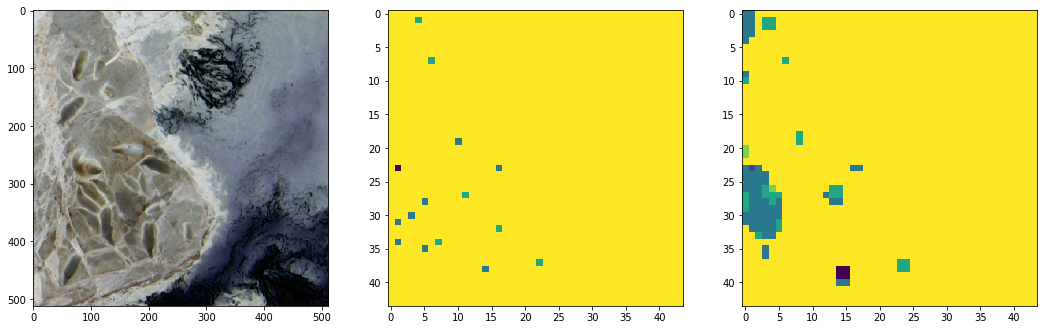

In [68]:
i = 15
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(y_pred[i,...], axis=-1))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
unet.save("../data/unet_segmentation_ellipse_dmap_sgd_10epochs_200steps.h5")

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
batch_ypred = unet.predict(batch_x)

In [ ]:
batch_ypred.shape

In [ ]:
np.min(batch_ypred[:,:,2])

In [ ]:
gg = np.argmax(batch_ypred, axis=-1)

In [ ]:
np.unique(gg, return_counts=True)

In [ ]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(batch_ypred[i,...], axis=-1))

In [ ]:
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]) > 0.0007)

In [ ]:
i = 7
print("GT: ", np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0])))
print("Pred: ", np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0])))

In [ ]:
def full_image_process(im, net, patchGenerator, patch_size=(224, 224), batch_size=8, overlap=(64, 64)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    dmap = np.zeros((h, w, 1), dtype=np.float32)
    dmap_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    batch_pos = np.zeros((batch_size, 4), dtype=np.int32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos[current_batch_size, :] = np.array([y_start, y_end, x_start, x_end])
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_ylog = net.predict(batch_x_normed)
                batch_y = patchGenerator.denormalize_output(batch_ylog)
                # Fill the full dmap
                for i in range(current_batch_size):
                    y_start, y_end, x_start, x_end = tuple(batch_pos[i,:])
                    dmap[y_start:y_end, x_start:x_end, :] += batch_y[i,:,:,:]
                    dmap_count[y_start:y_end, x_start:x_end] += 1
                current_batch_size = 0
                
    return dmap, dmap_count

In [ ]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [ ]:
dmap, dmap_count = full_image_process(im, unet, valPatchesGenerator)

In [ ]:
plt.imshow(dmap[:,:,0])

In [ ]:
dmap_avg = dmap/dmap_count

In [ ]:
dmap_count.shape

In [ ]:
np.sum(dmap)

In [ ]:
np.sum(dmap_avg)

In [ ]:
dmap_gt = np.load("../data/sealion/TrainDensity/872_0.npz")